# Segmentación de Clientes (Prueba técnica para PyperLab)

## Problema propuesto

La prueba consiste en resolver un problema bastante frecuente que sucede en las empresas, la segmentación de clientes. En este caso, suponemos que un cliente, una empresa aseguradora, nos ha pedido realizar esta segmentación y para ello, nos ha pasado dos datasets:

     - data_seg.csv: datos del número de productos que tiene cada cliente contratado por tipo.
     - data_prof.csv: datos de perfil de cada uno de los clientes.

En el paquete `data_segmentacion.zip`, adjunto en este email, contiene estos dos ficheros. La idea es aplicar algoritmos de clustering automático sobre los datos del fichero `data_seg.csv`, interpretar los grupos de clientes que aparecen y, con los datos del fichero `data_prof.csv` interpretar el perfil de cada cluster. En particular, se pide aplicar estos dos algoritmos:

     - K-means: un algoritmo de clustering clásico donde se introduce como parámetros el conjunto de datos y el número de clusters que tiene que calcular (k). Es importante explicar y justificar cómo se realiza esta elección del k.
     - DBscan: un algoritmo de clustering más moderno que, en vez de tener el k como parámetros, hay una medida de distancia entre puntos.


## Planing de la prueba

    - Exploración de los datos y limpieza de datos
    - Análisis previo de clientes
    - Planteamiento de hipótesis
    - Modelización
    - Análisis de resultados
    
**Explororación y Limpieza**

    En este paso realizaremos un exploración de los datos de `data_seg.csv`, para tratar de localizar valores nulos en el caso de que los hubiera y trabajar en ingeniería de variables si se da el caso
    
**Análisis previo de clientes**

    Aquí realizaré un análisis exploratorio de ambos data sets con la intención de hacer una clasificación previa de tipo de clientes que tiene la empresa, para poder trabajar mejor en la fase de modelización
    
**Planteamiento de hipótesis**

    Una vez explorados los datos podremos establecer una serie de hipótesis iniciales sobre las cuales diseñar nuestros experimentos para crear los modelos, con esto me refiero a, es mejor crear un único modelo para todos los clientes o se puede hacer primero una división en base a ciertos perfiles identificados en la fase anterior y crear un modelo para cada uno de los grupos que podamos extraer de este análisis.
    
**Modelización**

    Construcción de modelos requeridos en la prueba y aplicarlos a los diferentes experimentos propuestos
    
**Análisis de resultados**

    Una vez obtenidas las predicciones, se procederá al análisis de los resultados obtenidos para cada uno de los modelos y de los experimentos propuestos
    

    


## Librerias

In [2]:
import os
from tqdm.notebook import tqdm

#análisis y visualización
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import silhouette_visualizer

#Procesamiento de datos
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from umap import UMAP

# Modelos
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

#otros
import warnings
warnings.filterwarnings('ignore')

## Funciones Auxiliares

In [129]:
def plot_corr(df:pd.DataFrame, save:bool=False)->None:
    
    '''
        Autor: Enrique Revuelta Garcia
        Fecha: 19/11/2022
        email: enrique.revuelta@enriquerevueltagarcia.com
        LinkedIn: https://www.linkedin.com/in/kike-rev/
        github: https://github.com/Gobuub
        
        
        Función que muestra la matriz de correlación de un dataframe recibido como parámetro a través de un heatmap,
        limitada a la triangular inferior
        
        
        Parametros:
        -----------
        
           - df: Recibe un pandas DataFrame al que posteriormente le calcularemos su matriz de correlación.
           - save: Booleano por defecto False, si le pasamos True podremos guardar el gráfico para utilizarlo posteriormente en 
                   informes, si no exite la carpeta de destino podremos crear una nueva
        
        Return:
        -------
        
                La función no devuelve nada, muestra por pantalla un gráfico en forma de heatmap, con los valores de correlación de
            los datos proporcionados.
            
    '''
    
    plt.figure(figsize=(15,10))
    
    sns.set(style='white')

    mask=np.triu(np.ones_like(df.corr(), dtype=bool))

    cmap=sns.diverging_palette(0, 10, as_cmap=True)


    sns.heatmap(df.corr(),
               mask=mask,
              cmap=cmap,
              center=0,
              square=True,
              annot=True,
              linewidths=0.5,
              cbar_kws={'shrink': 0.5})
    
    if save:
        title = input('Introduce un nombre para el grafico')
        try:
            plt.savefig(f'graphics/{title}.png')
        except:
            destino = input('No exite la carpeta de destino, introduce un nombre para la carpeta de destino: ')
            os.mkdir(destino)
            plt.savefig(f'{destino}/{title}.png')
    
    plt.show();
    
def plot_productos_x_cluster(df:pd.DataFrame, cluster:int, save:bool=False)->None:
    
    '''
        Autor: Enrique Revuelta Garcia
        Fecha: 19/11/2022
        email: enrique.revuelta@enriquerevueltagarcia.com
        LinkedIn: https://www.linkedin.com/in/kike-rev/
        github: https://github.com/Gobuub
        
        
        Función que crea un gráfico en base al número de productos contratados por cliente en un cluster determinado.
        
        Parametros:
        -----------
        
           - df: Pandas DataFrame
           - cluster: int, número del cluster por el que queremos filtrar el dataframe
           - save: bool, guarda el gráfico en la ruta determinada, si no existe la carpeta de destino, pedirá crear una nueva
        
        Return:
        -------
        
            No devuelve nada, muestra el gráfico por pantalla.
                
    
    '''
    
    plt.figure(figsize=(15,10))
    sns.barplot(y=df[df.cluster==cluster]['familia_captacion'].value_counts().index, x=df[df.cluster==cluster]['familia_captacion'].value_counts().values)
    plt.title(f'Contrataciones por tipo de producto cluster {cluster}, total clientes {df[df.cluster==cluster].shape[0]}')
    
    if save:
        title = f'Contrataciones por tipo de producto cluster {cluster}, total clientes {df[df.cluster==cluster].shape[0]}'
        try:
            plt.savefig(f'graphics/{title}.png')
        except:
            destino = input('No exite la carpeta de destino, introduce un nombre para la carpeta de destino: ')
            os.mkdir(destino)
            plt.savefig(f'{destino}/{title}.png')
    
    plt.show();
    
def plot_total_productos_x_cluster(df:pd.DataFrame, cluster:int, hue:str = None, save:bool=False)->None:
      
    '''
        Autor: Enrique Revuelta Garcia
        Fecha: 19/11/2022
        email: enrique.revuelta@enriquerevueltagarcia.com
        LinkedIn: https://www.linkedin.com/in/kike-rev/
        github: https://github.com/Gobuub
        
        Función que devuelve un gráfico en el que muestra el recuento de productos que tiene contratado un cliente y los agrupa 
        por número de productos contratados.
        
        
        Parametros:
        -----------
        
           - df: Pandas DataFrame
           - cluster: int, número del cluster por el que queremos filtrar el dataframe
           - hue: str, columna categorica normalmente por la que queremos agrupar los resultados de nuestro gráfico
           - save: bool, guarda el gráfico en la ruta determinada, si no existe la carpeta de destino, pedirá crear una nueva
        
        Return:
        -------
        
            No devuelve nada, muestra el gráfico por pantalla.
                
    
    '''
    
    plt.figure(figsize=(15,10))
    sns.countplot(data=df[df.cluster==cluster], y='total_productos', hue=hue)
    plt.title(f'Cantidad de productos contratados por cliente, cluster {cluster}')
    
    if save:
        title = f'Cantidad de productos contratados por cliente, cluster {cluster}'
        try:
            plt.savefig(f'graphics/{title}.png')
        except:
            destino = input('No exite la carpeta de destino, introduce un nombre para la carpeta de destino: ')
            os.mkdir(destino)
            plt.savefig(f'{destino}/{title}.png')
    
    plt.show();

def cal_angle(x1:int,x2:int,y1:float,y2:float)->float:
    
    '''
        Autor: Enrique Revuelta Garcia
        Fecha: 24/11/2022
        email: enrique.revuelta@enriquerevueltagarcia.com
        LinkedIn: https://www.linkedin.com/in/kike-rev/
        github: https://github.com/Gobuub
        
        
        Función que devuelve el angulo entre dos vectores
        
        
        Parametros:
        -----------
        
           - x1: int, valor en el eje x del punto 1
           - x2: int, valor en el eje x del punto 2
           - y1: float, valor en el eje y del punto 1
           - y2: float, valor en el eje y del punto 2
        
        Return:
        -------
        
            Devuelve el ángulo formado por dos vectores, a partir de las coordenadas en los ejes x,y de dos puntos.
            
    '''
    
    x = np.array([x1, x2])
    y = np.array([y1, y2])

    lx = np.sqrt(x.dot(x))
    ly = np.sqrt(y.dot(y))

    cos_angle = x.dot(y)/(lx*ly)
    
    angle = np.arccos(cos_angle)
    
    angle2 = angle*360/2/np.pi
    
    return angle2
    
def plot_elbow(inertias:list, start:int=2, end:int=10,annot:bool=False,save:bool=False)->None:
    
    '''
        Autor: Enrique Revuelta Garcia
        Fecha: 19/11/2022
        email: enrique.revuelta@enriquerevueltagarcia.com
        LinkedIn: https://www.linkedin.com/in/kike-rev/
        github: https://github.com/Gobuub
        
        Función que muestra por pantalla el gráfico obtenido a partir de las inercias obtenidas del modelo Kmeans, y marca el que 
        debería ser el punto óptimo de clusters.
        
        Parametros:
        -----------
        
            - inertias: list, lista obtenida a partir de las inercias obtenidas por entrenar un modelo Kmeans
            - start: int, punto de inicio para generar el plot, por defecto 2.
            - end: int, punto para finalizar el rango del plot, por defecto 10.
            - annot: bool, muestra una flecha apuntando al punto óptimo de k clusters en base a diferencia del valor de inercias
            - save: bool, parámetro para guardar el gráfico generado con la función.
        
        
        Return:
        -------
        
             No devuelve nada, muestra el gráfico por pantalla.   
    
    '''
    
    #dif = [inertias[i]-inertias[i+1] for i in range(len(inertias)-1)]
    #max_el = max(dif)
    
    an = [cal_angle(i+start,i+(start+1), inertias[i],inertias[i+1]) for i,e in enumerate(inertias) if i<(end-3)]

    dif_an = [180-(90-an[i]-(90-an[i+1])) for i in range(len(an)-1)]
    max_ch = [dif_an[i+1]-dif_an[i] for i in range(len(dif_an)-1)]
    max_ = max_ch.index(min(max_ch))
    
    #for i in range(len(dif)):
    #    if dif[i] == max_el:
    #       opt = i
    
    plt.figure(figsize=(15, 10))
    plt.plot(range(start, end), inertias, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Inertia", fontsize=14)
    if annot:
        plt.annotate(f'K óptimo = {max_+start+1}, inertia = {round(inertias[max_],2)}',
                     xy=(max_+start+1, inertias[max_+1]),
                     xytext=(0.4, 0.75),
                     textcoords='figure fraction',
                     fontsize=16,
                     arrowprops=dict(facecolor='red', shrink=0.1)
                    )
    if save:
        title = input('Introduce un nombre para el grafico')
        try:
            plt.savefig(f'graphics/{title}.png')
        except:
            destino = input('No exite la carpeta de destino, introduce un nombre para la carpeta de destino: ')
            os.mkdir(destino)
            plt.savefig(f'{destino}/{title}.png')
    
    plt.show();
    
def plot_silhouette_scores(silhouette_scores:list, start:int=2, end:int=10, save:bool=False)->None: 

    '''
        Autor: Enrique Revuelta Garcia
        Fecha: 19/11/2022
        email: enrique.revuelta@enriquerevueltagarcia.com
        LinkedIn: https://www.linkedin.com/in/kike-rev/
        github: https://github.com/Gobuub
        
        
        
        Parametros:
        -----------
        
            - silhouette_scores: list, lista de silohuette scores obtenida del modelo Kmeans
            - start: int, punto de inicio para generar el plot, por defecto 2.
            - end: int, punto para finalizar el rango del plot, por defecto 10.
            - save: bool, parámetro para guardar el gráfico generado con la función.
        
        Return:
        -------
        
            - No devuelve nada, muestra el gráfico por pantalla.  
                
    
    '''
    
    min_ = min(silhouette_scores)-0.2
    max_ = max(silhouette_scores)+0.2
    plt.figure(figsize=(15, 10))
    plt.plot(range(start, end), silhouette_scores, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Silhouette score", fontsize=14)
    plt.axis([start-0.2, end+0.2, min_, max_])
    plt.title('Silhouette Scores')
    
    if save:
        title = input('Introduce un nombre para el grafico')
        try:
            plt.savefig(f'graphics/{title}.png')
        except:
            destino = input('No exite la carpeta de destino, introduce un nombre para la carpeta de destino: ')
            os.mkdir(destino)
            plt.savefig(f'{destino}/{title}.png')
    
    plt.show();
    
def plot_KElbowVisualizer(df:pd.DataFrame, ks:tuple=(2,15))->None:

    '''
        Autor: Enrique Revuelta Garcia
        Fecha: 19/11/2022
        email: enrique.revuelta@enriquerevueltagarcia.com
        LinkedIn: https://www.linkedin.com/in/kike-rev/
        github: https://github.com/Gobuub
        
        
        Función similar para obtener el valor optimo de clusters a través de la técnica del elbow a partir de la distancia entre las 
        inercias del modelo, usa la libreria yellowbrick, y muestra las inercias frente al tiempo de calculo de las predicciones en base 
        al número de clusters, y en base a estas dos métricas indica el número óptimo de clusters.
        
        Parametros:
        -----------
        
            - df: pandas DataFrame, datos que recibirá el modelo para calcular los clusters
            - ks: tuple, rango de clusters a entrenar para ajustar el modelo

        
        Return:
        -------
        
            - No devuelve nada, muestra el gráfico por pantalla.
                
    
    '''
    
    plt.figure(figsize=(15,10))
    visual=KElbowVisualizer(KMeans(random_state=42), k=ks)
    visual.fit(df)
    
    visual.show();
    

def plot_silhouette_visualizer(df:pd.DataFrame, k:int)->None:

    '''
        Autor: Enrique Revuelta Garcia
        Fecha: 19/11/2022
        email: enrique.revuelta@enriquerevueltagarcia.com
        LinkedIn: https://www.linkedin.com/in/kike-rev/
        github: https://github.com/Gobuub
        
        Función para generar un gráfico de shiloutte, en el que muestra como se distribuyen los datos en cada cluster a partir
        del número de clusters pasado como parámetro. 
        
        Parametros:
        -----------
            - df: pandas DataFrame, datos que recibirá el modelo para calcular los clusters
            - k: int, numero de clusters a entrenar para ajustar el modelo
            - save: bool, parámetro para guardar el gráfico.
           
        
        Return:
        -------
            - No devuelve nada, muestra el gráfico por pantalla.
    
    '''
    plt.figure(figsize=(15,10))
    visual = silhouette_visualizer(KMeans(k, random_state=42), df, colors='yellowbrick')
    visual.show();
    
def get_umap(data:pd.DataFrame, n:int):

    '''
        Autor: Enrique Revuelta Garcia
        Fecha: 19/11/2022
        email: enrique.revuelta@enriquerevueltagarcia.com
        LinkedIn: https://www.linkedin.com/in/kike-rev/
        github: https://github.com/Gobuub
        
        Función para reducir las dimensiones del dataframe pasado como parámetro, y reducirlas a un número dado. 
        UMAP son las siglas de Uniform Manifold Approximation and Projection for Dimension Reduction, mas info en
        !['UMAP'](https://umap-learn.readthedocs.io/en/latest/index.html)
        
        Parametros:
        -----------
        
            - data: pandas DataFrame
            - n: int, numero de columnas a las que queremos reducir nuestros datos
           
        
        Return:
        -------
        
            Devuelve un pandas DataFrame con los embeddins obtenidos después de aplicar la reducción de dimensiones.
    
    '''
    
    umap=UMAP(n_components=n,random_state=42)
    emb=umap.fit_transform(data)
    
    return pd.DataFrame(emb, columns=[f'emb_{i+1}' for i in range(n)])

def plot_clusters(df:pd.DataFrame, model, centroids:bool=True, palette:str='Spectral', save:bool=False)->None:
    
    '''
        Autor: Enrique Revuelta Garcia
        Fecha: 20/11/2022
        email: enrique.revuelta@enriquerevueltagarcia.com
        LinkedIn: https://www.linkedin.com/in/kike-rev/
        github: https://github.com/Gobuub
        
        Función para imprimir la dispersión de los datos recibidos como parámetro y mostrar su distribución entre los diferentes
        clusters propuestos por el modelo, marcando su posición en el gráfico
        
        Parametros:
        -----------
        
            - df: Pandas dataframe tratado con la función get_umap perteneciente a esta clase.
            - model: Modelo utilizado para la creación de los clusters, su principal función es poder obtener los centroides para 
                    poder mostrarlos en el gráfico.
            - centroids: Por defecto True, si está activado, obtendrá los centroides calculados por el modelo y posteriormente los 
                        mostrará en el gráfico
            - palette: Paleta de colores para mostrar los clusters, por defecto 'Spectral'
            - save: Permite guardar el gráfico en un archivo para poder utilizarlo posteriormente, si no exite el directorio por defecto
                    pedíra crear uno nuevo
        
        Return:
        -------
        
                La función no devuelve ningún valor, imprime el gráfico de dispersión junto con los centroides y su división por 
            clusters por pantalla.
    
    '''
    if centroids:
        centroids = pd.DataFrame(model.cluster_centers_, columns=['x','y'])
        plt.figure(figsize=(15,10))
        sns.scatterplot(data=df, x='emb_1', y='emb_2', hue='cluster', palette= palette)
    
        plt.scatter(data=centroids, x='x', y='y',
                    marker='+', s=30, linewidths=30,
                    color='limegreen', zorder=11, alpha=1)
        for i in range(len(centroids)):
            plt.annotate(f'Cluster {i}', (centroids['x'][i]-0.03,centroids['y'][i]+0.05), zorder=13, color='red')
    else:
        plt.figure(figsize=(15,10))
        sns.scatterplot(data=df, x='emb_1', y='emb_2', hue='cluster', palette= palette)
    plt.title(f'Distribución de clientes por Cluster en {model}')
    
    title = f'Distribución de clientes por Cluster en {model}'
    
    if save:
        try:
            plt.savefig(f'graphics/{title}.png')
        except:
            destino = input('No exite la carpeta de destino, introduce un nombre para la carpeta de destino: ')
            os.mkdir(destino)
            plt.savefig(f'{destino}/{title}.png')
            
    plt.show();

def countplot_cluster(df:pd.DataFrame, cluster:int ,col:str, hue:str, save:bool=False )->None:
    
    '''
        Autor: Enrique Revuelta Garcia
        Fecha: 20/11/2022
        email: enrique.revuelta@enriquerevueltagarcia.com
        LinkedIn: https://www.linkedin.com/in/kike-rev/
        github: https://github.com/Gobuub
        
        
        Función que muestra un countplot de una columna determinada de un dataframe, filtrado por el número
        de cluster y agrupando los datos por una columna categórica dada.
        
        Parametros:
        -----------
        
            - df: pandas DataFrame, datos que queremos usar para realizar el gráfico.
            - cluster: int, cluster por que el queremos filtrar nuestros datos.
            - col: str, columna categórica sobre la que queremos realizar el countplot.
            - hue: str, columna categórica que queremos usar para agrupar los datos y mostrarlos separados en +
                  el gráfico divididos por colores.
            - save: bool, parámetro para guardar el gráfico.
           
        
        Return:
        -------
            
            La función no devuelve nada, muestra el gráfico por pantalla en base a los parámetros dados.
    
    '''
    
    plt.figure(figsize=(15,10))
    sns.countplot(data=df[df.cluster==cluster], x=col, hue=hue)
    plt.title(f'Cluster {cluster}: {col} por {hue}')
    
    if save:
        title = f'Cluster {cluster}: {col} por {hue}'
        try:
            plt.savefig(f'graphics/{title}.png')
        except:
            destino = input('No exite la carpeta de destino, introduce un nombre para la carpeta de destino: ')
            os.mkdir(destino)
            plt.savefig(f'{destino}/{title}.png')
    
    plt.show();


## Carga de Datos

In [4]:
df = pd.read_csv('data/data_seg.csv', sep=';')
df.head()

id_cliente  n_polizas_tomador_ahorro  n_polizas_tomador_autos  \
0           1                         0                        0   
1           2                         0                        0   
2           3                         5                        0   
3           4                         0                        0   
4           5                         0                        0   

   n_polizas_tomador_jubilacion  n_polizas_tomador_jubilacion_golf  \
0                             0                                  0   
1                             0                                  0   
2                             0                                  0   
3                             0                                  0   
4                             0                                  0   

   n_polizas_tomador_no_vida  n_polizas_tomador_rc  n_polizas_tomador_rentas  \
0                          1                     0                         0   
1                          1                     0                         0   
2                          0                     0                         2   
3                          1                     0                         0   
4                          1                     0                         0   

   n_polizas_tomador_riesgo_tomador  n_polizas_tomador_vida_riesgo  \
0                                 0                              0   
1                                 0                              0   
2                                 1                              0   
3                                 0                              0   
4                                 0                              0   

   n_polizas_tomador_vida_riesgo_pm  n_polizas_tomador_no_vida.1  
0                                 0                            1  
1                                 0                            1  
2                                 0                            0  
3                                 0                            1  
4                                 0                            1

In [5]:
clientes = pd.read_csv('data/data_prof.csv', sep=';')

## EDA

### EDA de data segmentation

En esta fase del proyecto nos centraremos en la exploración de ambos datasets `data_seg.csv` y `data_prof`, con la idea de ver como están los datos, si están limpios, si contienen datos nulos o ausentes, ver como es su distribución, si el tipo de dato de la colomna corresponde con el tipo de dato que trata de contener dicha columna, etc.

Una vez que esté todo correcto, realizaremos un análisis exploratorio con la intención de entender mejor los datos para abordar el problema propuesto de la forma más optima posible, que nos ayude a conseguir unos resultados aceptables.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   id_cliente                         30000 non-null  int64
 1   n_polizas_tomador_ahorro           30000 non-null  int64
 2   n_polizas_tomador_autos            30000 non-null  int64
 3   n_polizas_tomador_jubilacion       30000 non-null  int64
 4   n_polizas_tomador_jubilacion_golf  30000 non-null  int64
 5   n_polizas_tomador_no_vida          30000 non-null  int64
 6   n_polizas_tomador_rc               30000 non-null  int64
 7   n_polizas_tomador_rentas           30000 non-null  int64
 8   n_polizas_tomador_riesgo_tomador   30000 non-null  int64
 9   n_polizas_tomador_vida_riesgo      30000 non-null  int64
 10  n_polizas_tomador_vida_riesgo_pm   30000 non-null  int64
 11  n_polizas_tomador_no_vida.1        30000 non-null  int64
dtypes: int64(12)
memor

In [7]:
df.describe().T

count          mean          std  min  \
id_cliente                         30000.0  15000.500000  8660.398374  1.0   
n_polizas_tomador_ahorro           30000.0      1.220300     1.675847  0.0   
n_polizas_tomador_autos            30000.0      0.155633     0.763172  0.0   
n_polizas_tomador_jubilacion       30000.0      0.066133     0.298266  0.0   
n_polizas_tomador_jubilacion_golf  30000.0      0.072300     0.334579  0.0   
n_polizas_tomador_no_vida          30000.0      0.629600     0.732863  0.0   
n_polizas_tomador_rc               30000.0      0.004833     0.070310  0.0   
n_polizas_tomador_rentas           30000.0      0.059767     0.320413  0.0   
n_polizas_tomador_riesgo_tomador   30000.0      0.064767     0.363102  0.0   
n_polizas_tomador_vida_riesgo      30000.0      0.001467     0.039974  0.0   
n_polizas_tomador_vida_riesgo_pm   30000.0      0.084267     0.312360  0.0   
n_polizas_tomador_no_vida.1        30000.0      0.629600     0.732863  0.0   

                                       25%      50%       75%      max  
id_cliente                         7500.75  15000.5  22500.25  30000.0  
n_polizas_tomador_ahorro              0.00      1.0      2.00     26.0  
n_polizas_tomador_autos               0.00      0.0      0.00     21.0  
n_polizas_tomador_jubilacion          0.00      0.0      0.00     10.0  
n_polizas_tomador_jubilacion_golf     0.00      0.0      0.00     12.0  
n_polizas_tomador_no_vida             0.00      1.0      1.00     12.0  
n_polizas_tomador_rc                  0.00      0.0      0.00      2.0  
n_polizas_tomador_rentas              0.00      0.0      0.00      9.0  
n_polizas_tomador_riesgo_tomador      0.00      0.0      0.00     10.0  
n_polizas_tomador_vida_riesgo         0.00      0.0      0.00      2.0  
n_polizas_tomador_vida_riesgo_pm      0.00      0.0      0.00      4.0  
n_polizas_tomador_no_vida.1           0.00      1.0      1.00     12.0

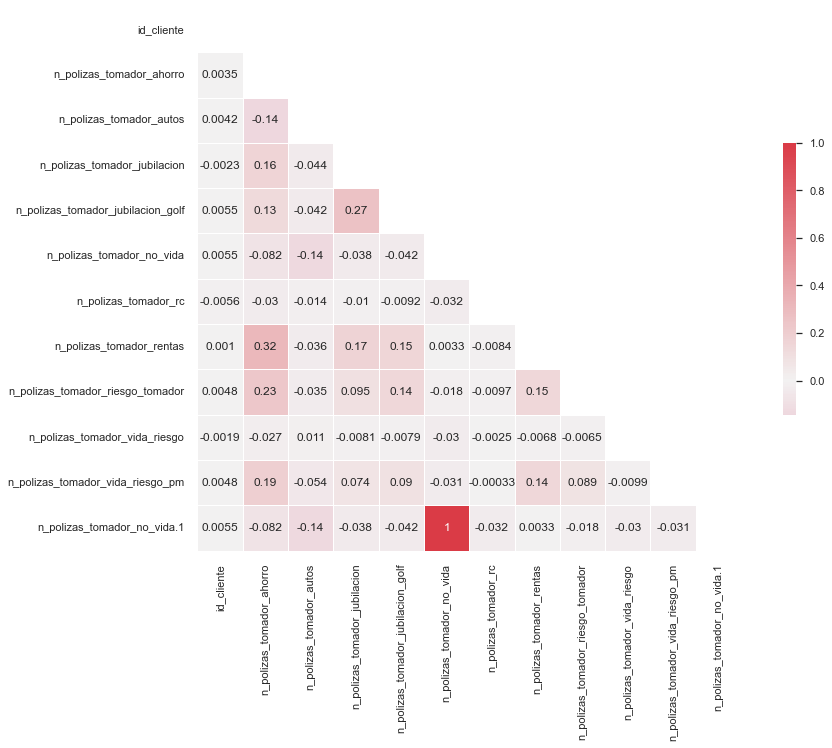

In [8]:
plot_corr(df)

Vemos que tenemos dos columnas que básicamente nos están aportando la misma información, si nos fijamos en el nombre vemos que puede haber sido un error porque es el mismo salvo por el dígito final

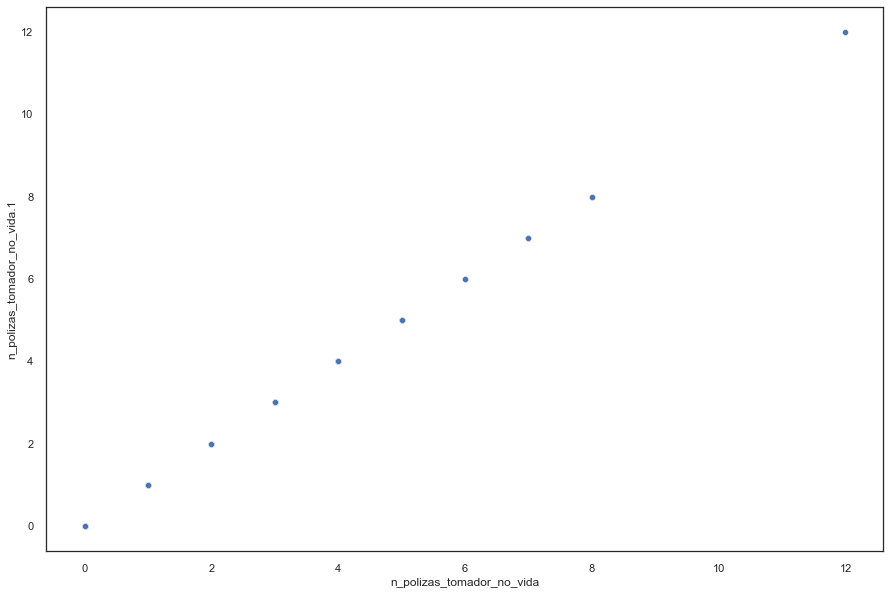

In [9]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='n_polizas_tomador_no_vida', y='n_polizas_tomador_no_vida.1');

Para evitar meter ruido al modelo y viendo que nos aporta la misma información vamos a quedarnos únicamente con una de ellas. Aprovechamos también para quitar la columna de client_id.

In [10]:
X = df.drop(['id_cliente', 'n_polizas_tomador_no_vida.1'], axis=1)

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   n_polizas_tomador_ahorro           30000 non-null  int64
 1   n_polizas_tomador_autos            30000 non-null  int64
 2   n_polizas_tomador_jubilacion       30000 non-null  int64
 3   n_polizas_tomador_jubilacion_golf  30000 non-null  int64
 4   n_polizas_tomador_no_vida          30000 non-null  int64
 5   n_polizas_tomador_rc               30000 non-null  int64
 6   n_polizas_tomador_rentas           30000 non-null  int64
 7   n_polizas_tomador_riesgo_tomador   30000 non-null  int64
 8   n_polizas_tomador_vida_riesgo      30000 non-null  int64
 9   n_polizas_tomador_vida_riesgo_pm   30000 non-null  int64
dtypes: int64(10)
memory usage: 2.3 MB


In [12]:
X.sum()

n_polizas_tomador_ahorro             36609
n_polizas_tomador_autos               4669
n_polizas_tomador_jubilacion          1984
n_polizas_tomador_jubilacion_golf     2169
n_polizas_tomador_no_vida            18888
n_polizas_tomador_rc                   145
n_polizas_tomador_rentas              1793
n_polizas_tomador_riesgo_tomador      1943
n_polizas_tomador_vida_riesgo           44
n_polizas_tomador_vida_riesgo_pm      2528
dtype: int64

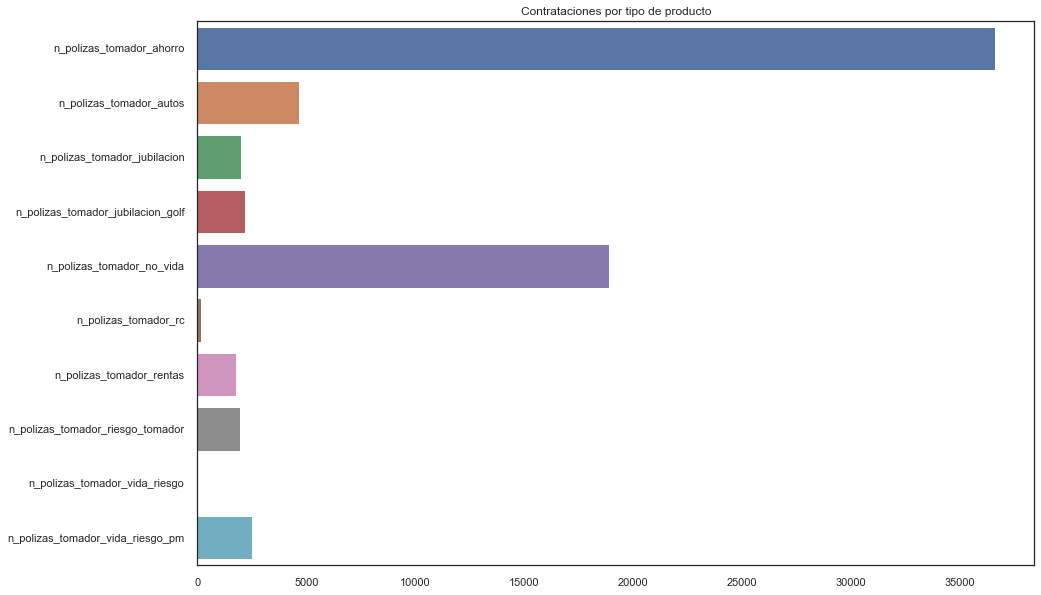

In [13]:
plt.figure(figsize=(15,10))
sns.barplot(y=X.columns, x=X.sum(), orient= 'h')
plt.title('Contrataciones por tipo de producto');

Según podemos ver en el gráfico anterior, hay clientes que contratan varirios productos, incluso hacen varias contratataciones de un mismo producto, ya que tenemos 30000 observaciones en nuestro set de datos y por poner un ejemplo en la columna de polizas_tomador_ahorro el valor supera las 35000 contrataciones.
Así mismo vemos que los productos más demandados son Ahorro y No_vida, por lo que cabría la posibilidad de hacer una división inicial entre los clientes que contratan este tipo de productos y los que no, y después hacer una clusterización de cada uno de estos dos grupos. 

Para comenzar realizaremos un estudio de todos los clientes en conjunto y seguidamente valoraremos, la opción de hacer la división.

Para tratar de tener un poco de información más detallada del número de productos que tienen contratados nuestros clientes vamos a generar una columna auxiliar cuyo resultado será la suma total de productos contratados por cada cliente

In [14]:
X['total_productos'] = [sum(r.values) for i,r in X.iterrows()]
X.head()

n_polizas_tomador_ahorro  n_polizas_tomador_autos  \
0                         0                        0   
1                         0                        0   
2                         5                        0   
3                         0                        0   
4                         0                        0   

   n_polizas_tomador_jubilacion  n_polizas_tomador_jubilacion_golf  \
0                             0                                  0   
1                             0                                  0   
2                             0                                  0   
3                             0                                  0   
4                             0                                  0   

   n_polizas_tomador_no_vida  n_polizas_tomador_rc  n_polizas_tomador_rentas  \
0                          1                     0                         0   
1                          1                     0                         0   
2                          0                     0                         2   
3                          1                     0                         0   
4                          1                     0                         0   

   n_polizas_tomador_riesgo_tomador  n_polizas_tomador_vida_riesgo  \
0                                 0                              0   
1                                 0                              0   
2                                 1                              0   
3                                 0                              0   
4                                 0                              0   

   n_polizas_tomador_vida_riesgo_pm  total_productos  
0                                 0                1  
1                                 0                1  
2                                 0                8  
3                                 0                1  
4                                 0                1

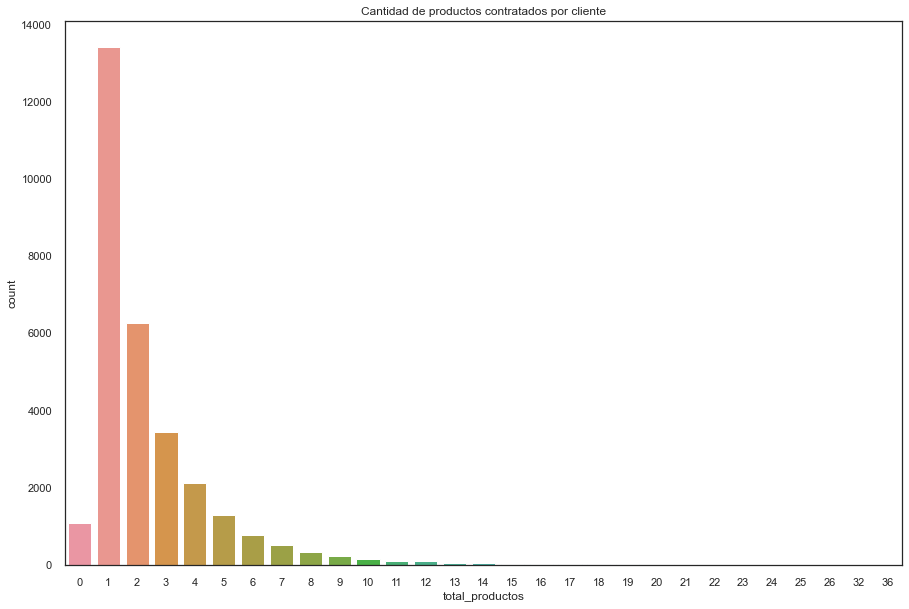

In [15]:
plt.figure(figsize=(15,10))
sns.countplot(data=X, x='total_productos')
plt.title('Cantidad de productos contratados por cliente');

In [16]:
X[X.total_productos > 10].groupby('total_productos').mean()

n_polizas_tomador_ahorro  n_polizas_tomador_autos  \
total_productos                                                      
11                               6.870000                 0.370000   
12                               6.588235                 0.964706   
13                               7.488372                 0.441860   
14                               7.500000                 1.194444   
15                               8.080000                 0.520000   
16                               9.000000                 0.000000   
17                               9.076923                 1.307692   
18                              10.666667                 0.000000   
19                              11.285714                 0.000000   
20                              15.000000                 0.000000   
21                               8.875000                 2.625000   
22                              11.000000                 0.000000   
23                              12.000000                 0.000000   
24                              18.000000                 0.000000   
25                              13.000000                 0.000000   
26                              19.000000                 0.000000   
32                              15.000000                 0.000000   
36                              26.000000                 0.000000   

                 n_polizas_tomador_jubilacion  \
total_productos                                 
11                                   0.520000   
12                                   0.576471   
13                                   0.651163   
14                                   0.666667   
15                                   0.480000   
16                                   0.750000   
17                                   0.538462   
18                                   0.777778   
19                                   0.857143   
20                                   0.666667   
21                                   0.500000   
22                                   2.000000   
23                                   1.000000   
24                                   1.000000   
25                                   1.000000   
26                                   0.000000   
32                                   0.666667   
36                                   0.000000   

                 n_polizas_tomador_jubilacion_golf  n_polizas_tomador_no_vida  \
total_productos                                                                 
11                                        0.330000                   1.280000   
12                                        0.741176                   1.294118   
13                                        0.906977                   1.372093   
14                                        0.583333                   1.444444   
15                                        0.800000                   1.360000   
16                                        0.958333                   1.541667   
17                                        1.076923                   1.384615   
18                                        1.888889                   1.111111   
19                                        1.285714                   1.571429   
20                                        0.333333                   1.000000   
21                                        0.750000                   2.750000   
22                                        2.000000                   2.000000   
23                                        3.000000                   3.000000   
24                                        0.000000                   5.000000   
25                                        3.000000                   0.000000   
26                                        0.000000                   0.000000   
32                                        2.333333                   2.000000   
36                                        0.000000                   0.000000   

              

##### Conclusiones preliminares

De este gráfico podemos destacar que la mayoría de clientes tienen contratado un único producto, de la misma forma hay clientes en la base de datos que ya no tienen contratado ningún producto, esto puede ser debido a que se dieron de baja de la compañia pero no se han borrado sus datos.
Aproximadamente el 1% de nuestros clientes tiene contratados más de 10 productos, en la mayoría de casos suelen ser varias pólizas del mismo producto y

**Antes de aplicar los algoritmos de clusterización vamos a realizar un estudio preliminar de los datos de clientes**

    Este estudio previo nos puede dar una idea aproximada del número de clusters o segmentos que podemos tener entre los clientes de la compañia

### EDA data clientes

In [17]:
clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id_cliente         30000 non-null  int64 
 1   sexo               29971 non-null  object
 2   estado_civil       22423 non-null  object
 3   tipo_baja          30000 non-null  object
 4   familia_captacion  30000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


Podemos ver que tenemos una serie de valores nulos dentro de los datos vamos a ver si podemos tratar de corregir estos valores, para poder hacer un análisis posterior de los clientes segmentados de la manera más fiel posible.

In [18]:
clientes.sexo.unique()

array(['H', 'M', nan], dtype=object)

Vamos a rellenar los valores nulos en la columna de sexo con un NS, a modo de desconocido.

In [19]:
clientes.sexo.fillna('NS', inplace=True)

In [20]:
clientes.estado_civil.unique()

array(['C', 'S', nan, 'D', 'V'], dtype=object)

Al igual que en la columna de sexo rellenaremos los datos de los cuales no tenemos esta información con un NS, a modo de desconocido.

In [21]:
clientes.estado_civil.fillna('NS', inplace=True)

In [22]:
clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id_cliente         30000 non-null  int64 
 1   sexo               30000 non-null  object
 2   estado_civil       30000 non-null  object
 3   tipo_baja          30000 non-null  object
 4   familia_captacion  30000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


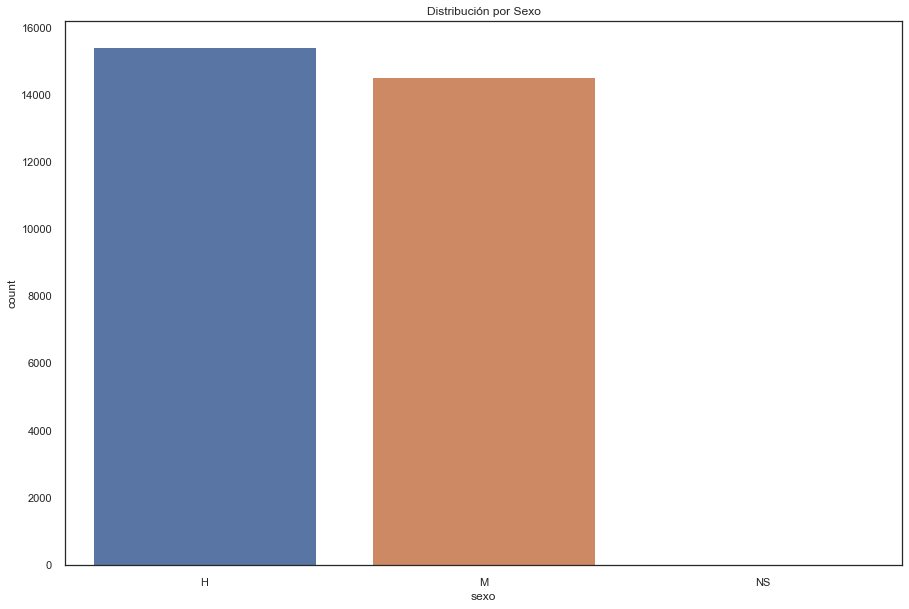

In [23]:
plt.figure(figsize=(15,10))
sns.countplot(data=clientes, x='sexo')
plt.title('Distribución por Sexo');

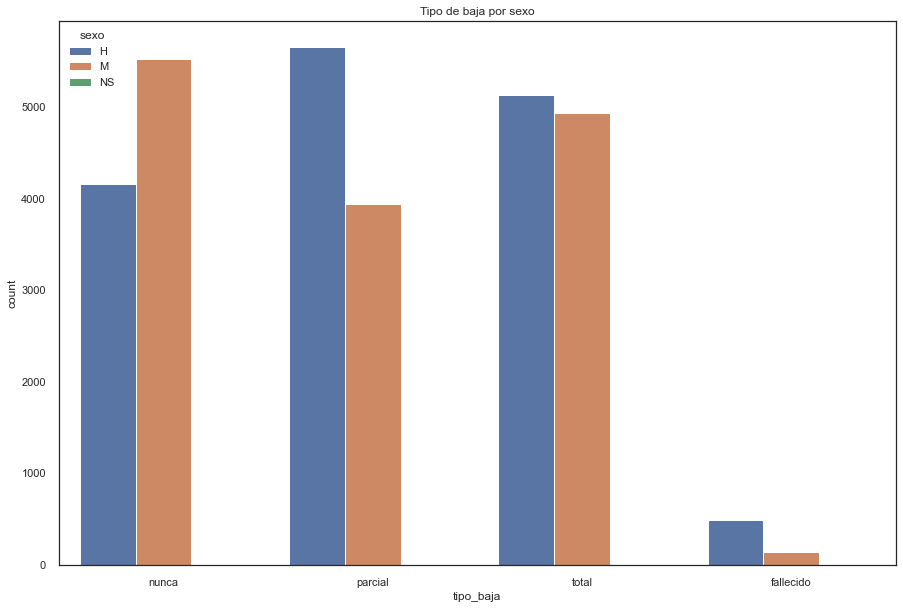

In [24]:
plt.figure(figsize=(15,10))
sns.countplot(data=clientes, x='tipo_baja', hue='sexo', dodge=True)
plt.title('Tipo de baja por sexo');

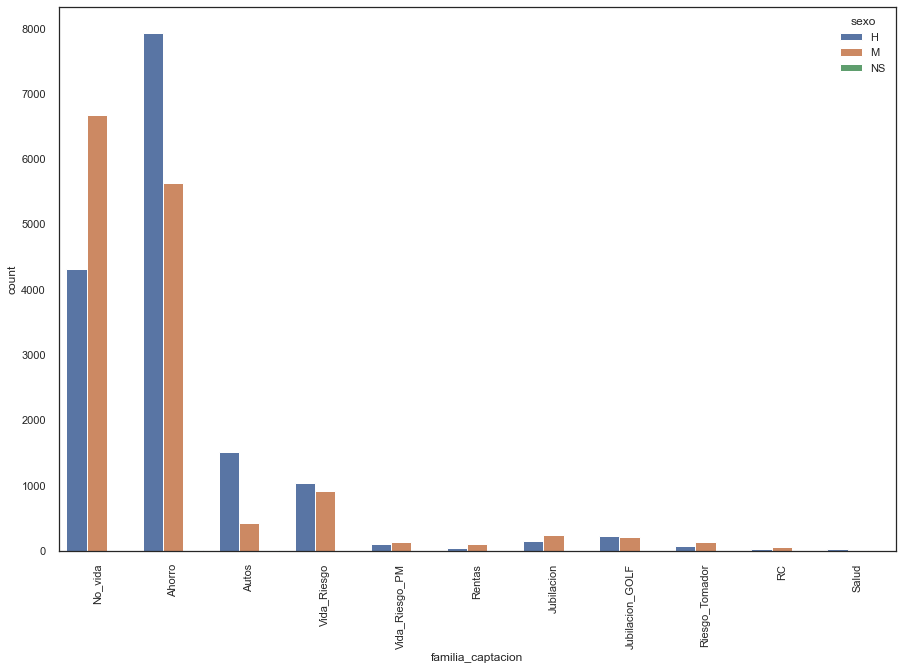

In [25]:
plt.figure(figsize=(15,10))
sns.countplot(data=clientes, x='familia_captacion', hue='sexo')
plt.xticks(rotation=90);

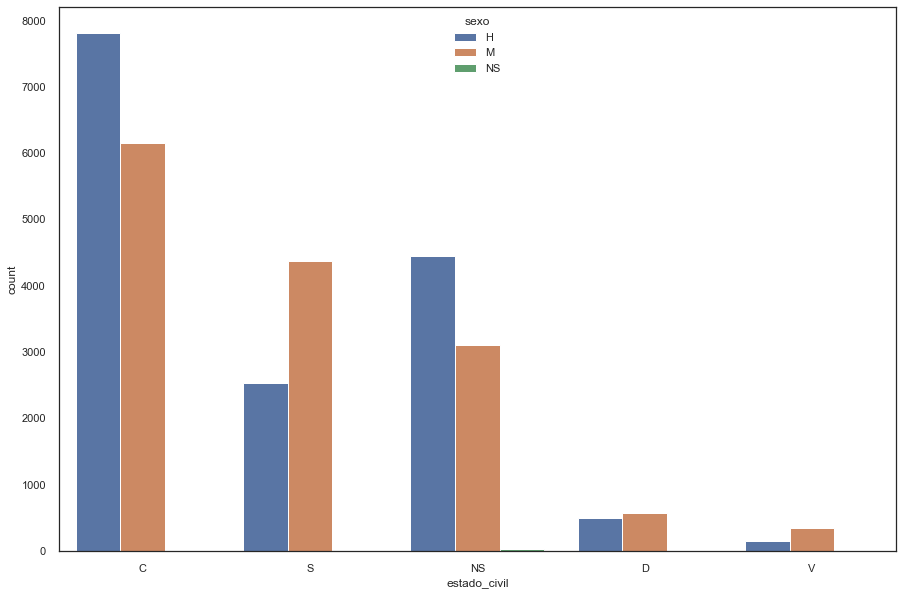

In [26]:
plt.figure(figsize=(15,10))
sns.countplot(data=clientes, x='estado_civil', hue='sexo');

In [27]:
clientes.groupby(['sexo', 'estado_civil']).count()

id_cliente  tipo_baja  familia_captacion
sexo estado_civil                                          
H    C                   7812       7812               7812
     D                    489        489                489
     NS                  4443       4443               4443
     S                   2539       2539               2539
     V                    141        141                141
M    C                   6160       6160               6160
     D                    564        564                564
     NS                  3106       3106               3106
     S                   4370       4370               4370
     V                    347        347                347
NS   C                      1          1                  1
     NS                    28         28                 28

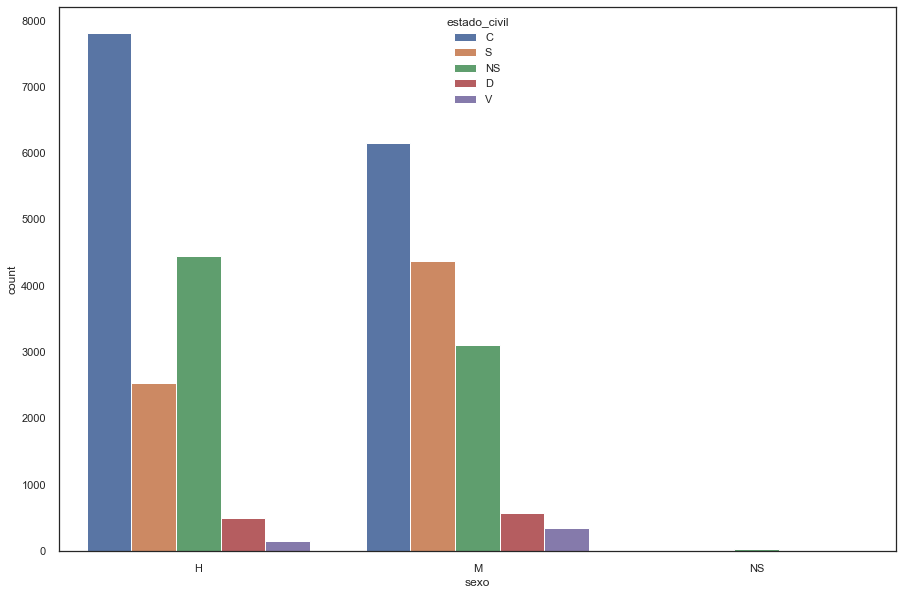

In [28]:
plt.figure(figsize=(15,10))
sns.countplot(data=clientes, x='sexo', hue='estado_civil');

##### Conclusiones preliminares

A primera vista sin realizar una segmentación de clientes vemos que casi la mitad de nuestros clientes están casados, contratan principalmente productos de no_vida y ahorro, y no hay diferenciación por género en número total de clientes. Si tratamos de hacer una diferenciación por sexo, los hombres suelen ser más volátiles, los hombres contratan más pólizas de Ahorro y las mujeres de No vida, y los seguros de coches principalmente son contratados por hombres.

## Kmeans

`K-means` es un algoritmo de clasificación no supervisada (clusterización) que agrupa objetos en $k$ grupos basándose en sus características. El agrupamiento se realiza minimizando la suma de distancias entre cada objeto y el centroide de su grupo o cluster. Se suele usar la distancia cuadrática.

El algoritmo consta de tres pasos: 

**1. Inicialización:** una vez escogido el número de grupos, $k$, se establecen k centroides en el espacio de los datos, por ejemplo, escogiéndolos aleatoriamente.

**2. Asignación objetos a los centroides:** cada objeto de los datos es asignado a su centroide más cercano.

**3. Actualización centroides:** se actualiza la posición del centroide de cada grupo tomando como nuevo centroide la posición del promedio de los objetos pertenecientes a dicho grupo.

Se repiten los pasos 2 y 3 hasta que los centroides no se mueven, o se mueven por debajo de una distancia umbral en cada paso.

El algoritmo `k-means` resuelve un problema de optimización, siendo la función a optimizar (minimizar) la suma de las distancias cuadráticas de cada objeto al centroide de su cluster.

Antes de aplicar el algoritmo si queremos que este funcione de manera correcta, o más óptima es conveniente standarizar los datos

### StandarScaler

El algoritmo de normalización StandarScaler se basa en la siguiente fórmula:

$$
    z =\frac{(x-\mu)}{\omega}
$$

In [29]:
X = X.drop('total_productos',axis=1) # eliminamos la columna total_productos ya que es una combinación lineal del resto de columnas y puede ensuciar el modelo final.

In [30]:
sc = StandardScaler()
mm = MinMaxScaler()

X_sc = pd.DataFrame(sc.fit_transform(X), columns=X.columns)
X_mm = pd.DataFrame(mm.fit_transform(X), columns=X.columns)

In [31]:
X_sc.head()

n_polizas_tomador_ahorro  n_polizas_tomador_autos  \
0                 -0.728181                -0.203933   
1                 -0.728181                -0.203933   
2                  2.255435                -0.203933   
3                 -0.728181                -0.203933   
4                 -0.728181                -0.203933   

   n_polizas_tomador_jubilacion  n_polizas_tomador_jubilacion_golf  \
0                      -0.22173                          -0.216096   
1                      -0.22173                          -0.216096   
2                      -0.22173                          -0.216096   
3                      -0.22173                          -0.216096   
4                      -0.22173                          -0.216096   

   n_polizas_tomador_no_vida  n_polizas_tomador_rc  n_polizas_tomador_rentas  \
0                   0.505423             -0.068745                 -0.186533   
1                   0.505423             -0.068745                 -0.186533   
2                  -0.859111             -0.068745                  6.055509   
3                   0.505423             -0.068745                 -0.186533   
4                   0.505423             -0.068745                 -0.186533   

   n_polizas_tomador_riesgo_tomador  n_polizas_tomador_vida_riesgo  \
0                         -0.178373                      -0.036691   
1                         -0.178373                      -0.036691   
2                          2.575720                      -0.036691   
3                         -0.178373                      -0.036691   
4                         -0.178373                      -0.036691   

   n_polizas_tomador_vida_riesgo_pm  
0                         -0.269778  
1                         -0.269778  
2                         -0.269778  
3                         -0.269778  
4                         -0.269778

Para encontrar el calor óptimo de `k` entrenaremos una serie de modelos y calcularemos sus inercias, estas inercias son el resultado de calcular la media de las distanias de cada punto a su centroide, el algoritmo inicializa los centroides de manera aleatoria y va ajustando el centroide hasta que el valor de la inercia no disminuye, en ese momento para y devuelve el el valor de inercia.

Con las inercias obtenidas realizaremos un gráfico, y podremos determinar el `k` optimo a partir de un cambio de pendiente brusco en la recta que une todos los puntos.

In [89]:
kmeans_per_k = [KMeans(n_clusters=k,random_state=42).fit(X_sc) for k in tqdm(range(2,15))]
inertias = [model.inertia_ for model in tqdm(kmeans_per_k)]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

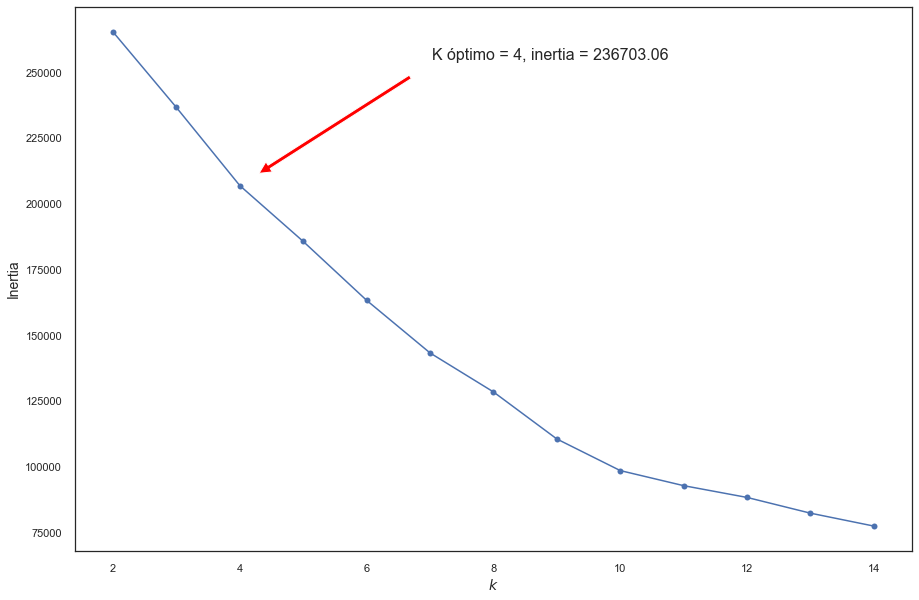

In [130]:
plot_elbow(inertias, start=2, end=15, annot=True, save=False)

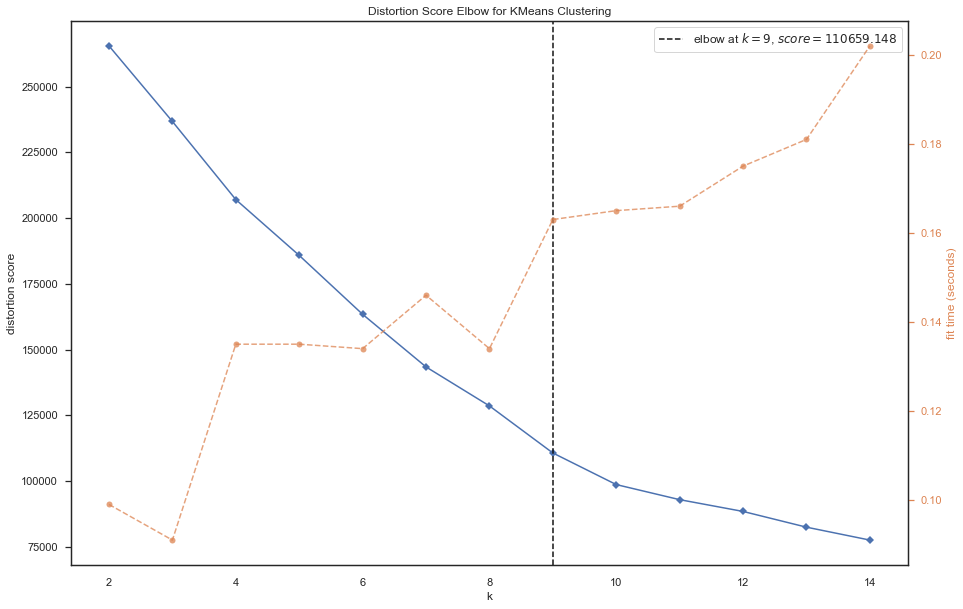

In [41]:
plot_KElbowVisualizer(X_sc)

Viendo que aplicando la técnica de 'elbow' para tratar de detectar el número de clusters óptimo vamos a probar con el silhoutte score a ver si nos aporta un poco más de lucidez.

El *silhouette score*, consiste en la media de los coeficientes *silhouette* sobre todos los puntos. Este coeficiente se calcula como $(b-a)/\max(a,b)$, siendo $a$ la distancia media de los puntos en el mismo cluster (distancia intra-cluster), y $b$ la distancia media al cluster más cercano.

In [38]:
silhouette_scores = [silhouette_score(X_sc, model.labels_) for model in tqdm(kmeans_per_k)]

  0%|          | 0/13 [00:00<?, ?it/s]

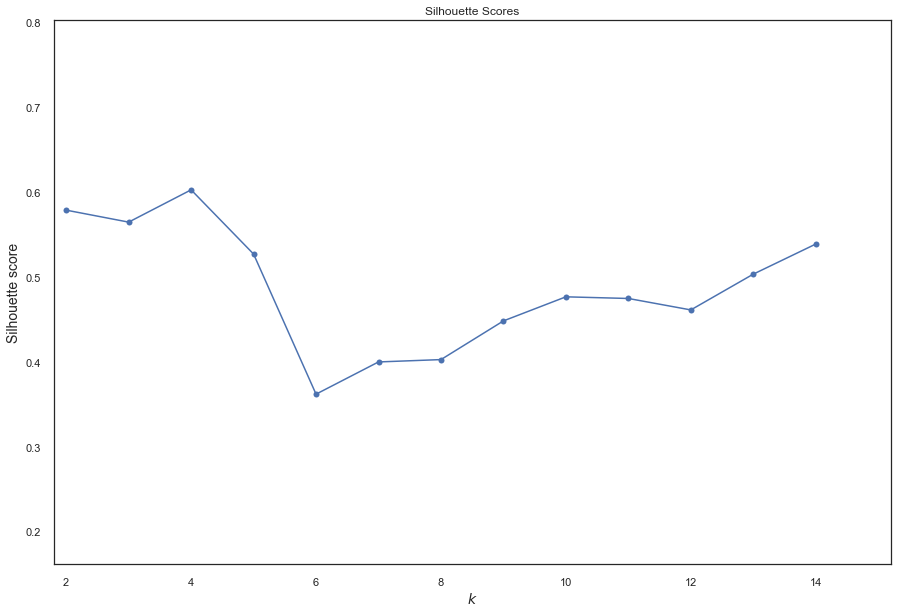

In [70]:
plot_silhouette_scores(silhouette_scores, end=15,save=False)

Si valoramos conjuntamente el silhoutte score y la técnica del 'elbow' vemos que el número optimo de clusters entre los usuarios de nuestro cliente es 4, vamos a realizar una predicción de estos clusters y realizaremos un análisis de los mismos para ver su distribución.

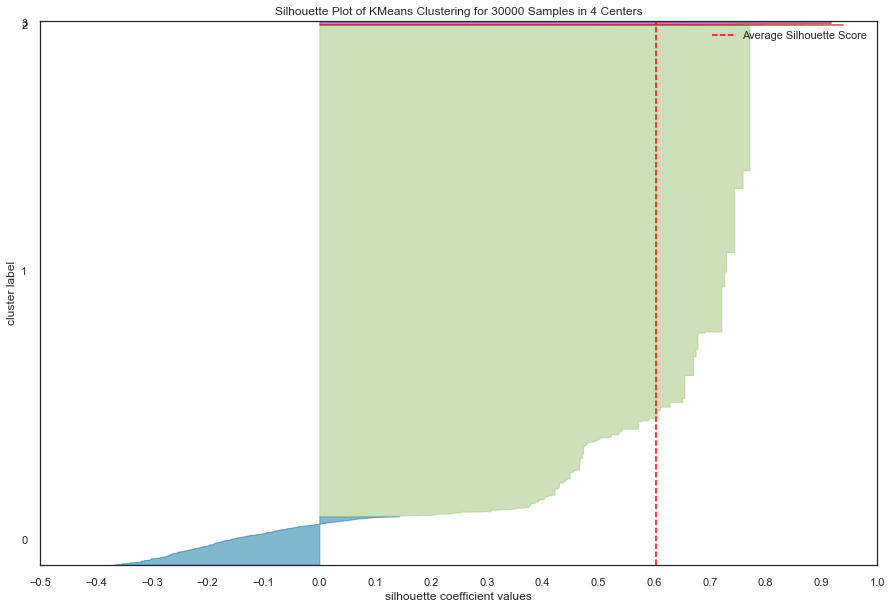

In [71]:
plot_silhouette_visualizer(X_sc, 4)

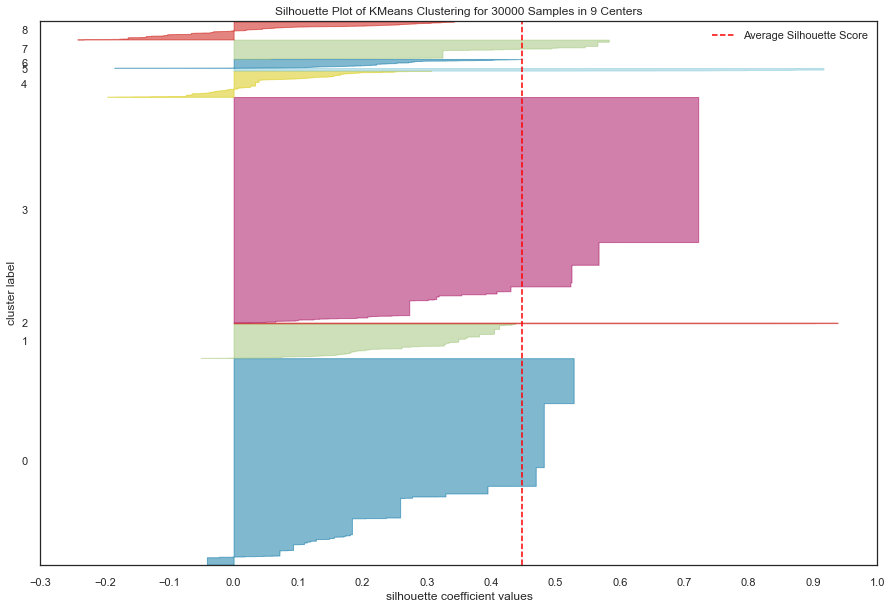

In [72]:
plot_silhouette_visualizer(X_sc, 9)

### MinMaxScaler

La normalización mediante minmaxscaler sigue la sieguiente fórmula:

$$
    z = \frac{x-min}{max-min}
$$

In [74]:
kmeans_per_k_mm = [KMeans(n_clusters=k,random_state=42).fit(X_mm) for k in tqdm(range(2,15))]
inertias_mm = [model.inertia_ for model in tqdm(kmeans_per_k)]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

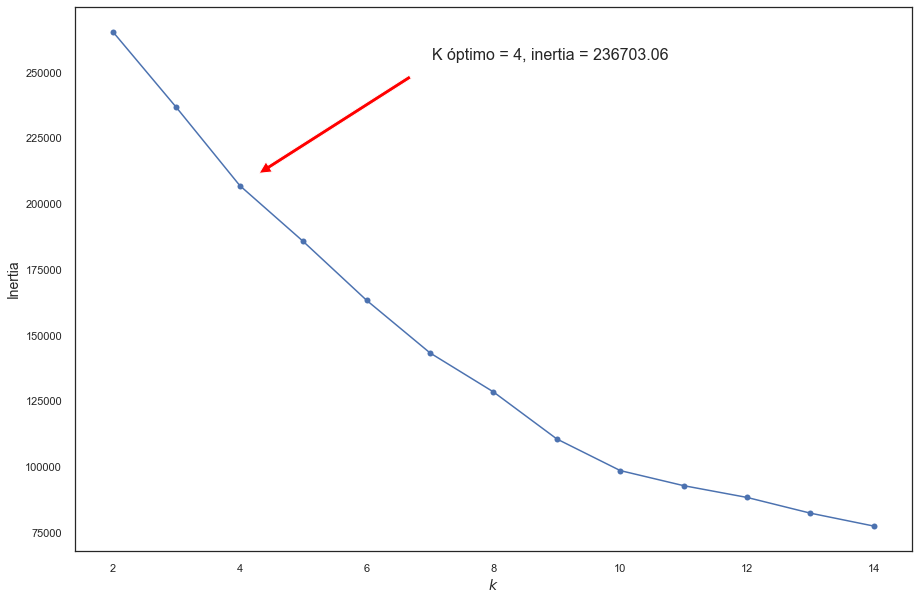

In [131]:
plot_elbow(inertias_mm, end=15, annot=True, save=False)

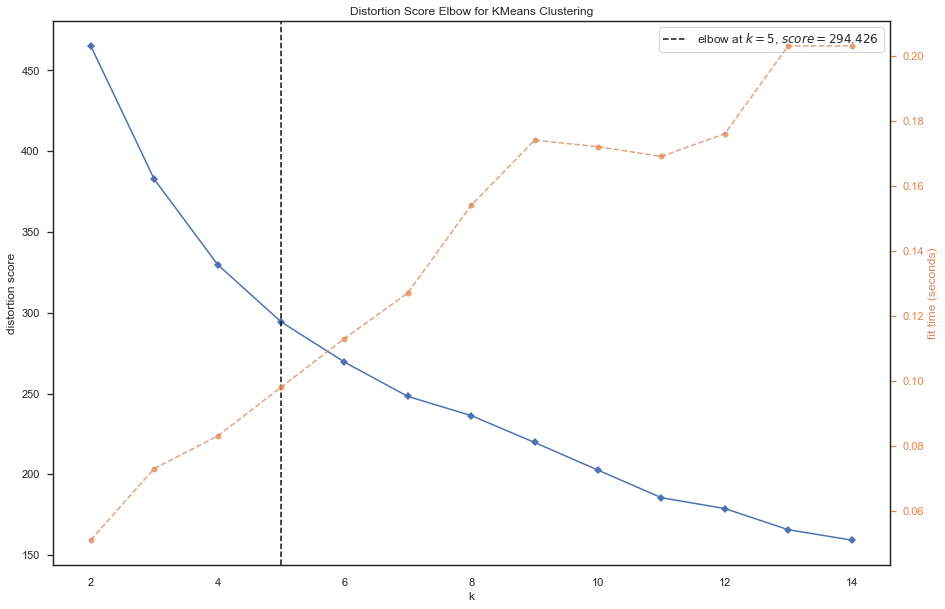

In [42]:
plot_KElbowVisualizer(X_mm)

In [44]:
silhouette_scores_mm = [silhouette_score(X_mm, model.labels_) for model in tqdm(kmeans_per_k)]

  0%|          | 0/13 [00:00<?, ?it/s]

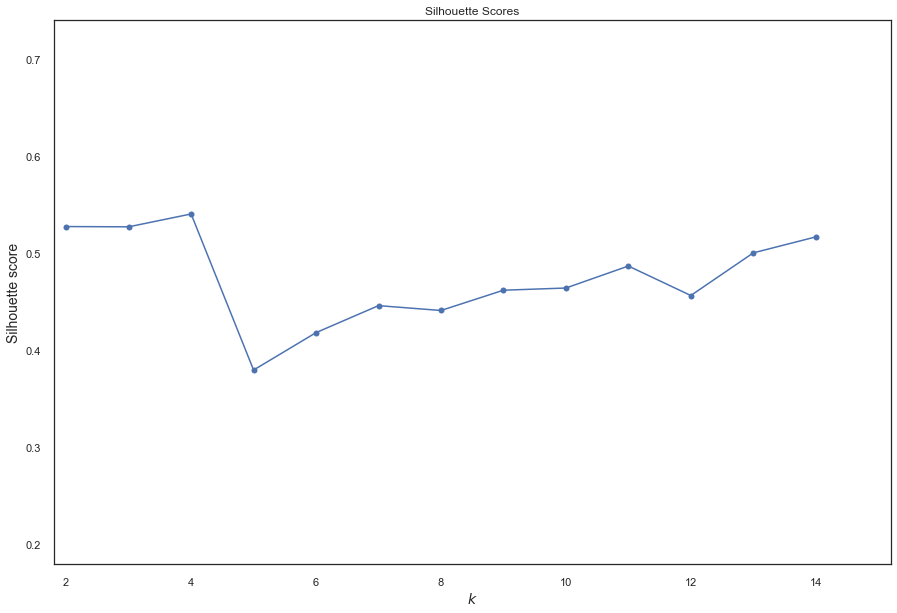

In [45]:
plot_silhouette_scores(silhouette_scores_mm, end=15, save=False)

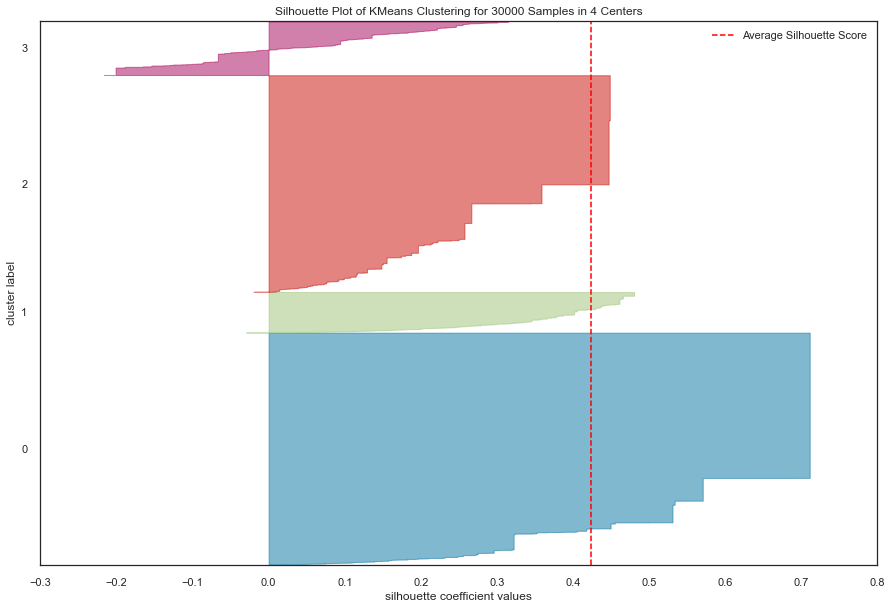

In [46]:
plot_silhouette_visualizer(X_mm,4)

Podemos observar que al aplicar la normalización de minmax el algoritmo trabaja un poco mejor, más claro el número de clusters tanto con la técnica del 'elbow' como con sihloutte score, los diagramas de siluetas no nos aportan mucho valor en ninguno de los casos.

Vamos a entrenar un modelo para 4 clusters y realizaremos las predicciones

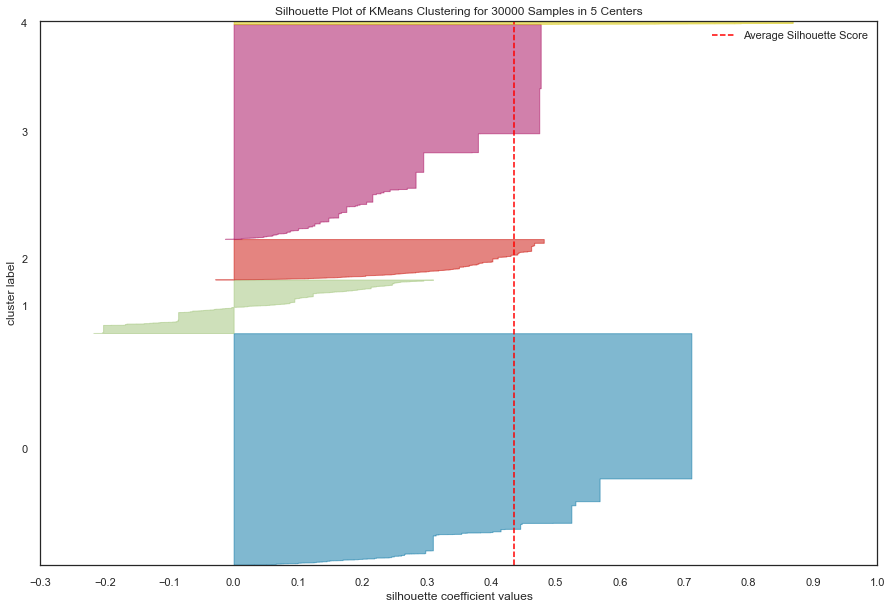

In [47]:
plot_silhouette_visualizer(X_mm,5)

In [48]:
kmeans_k4 = KMeans(n_clusters=4, random_state=42).fit(X_mm)

In [49]:
y_pred = kmeans_k4.predict(X_mm)

In [50]:
y_pred[:10]

array([0, 0, 3, 0, 0, 2, 2, 0, 0, 0])

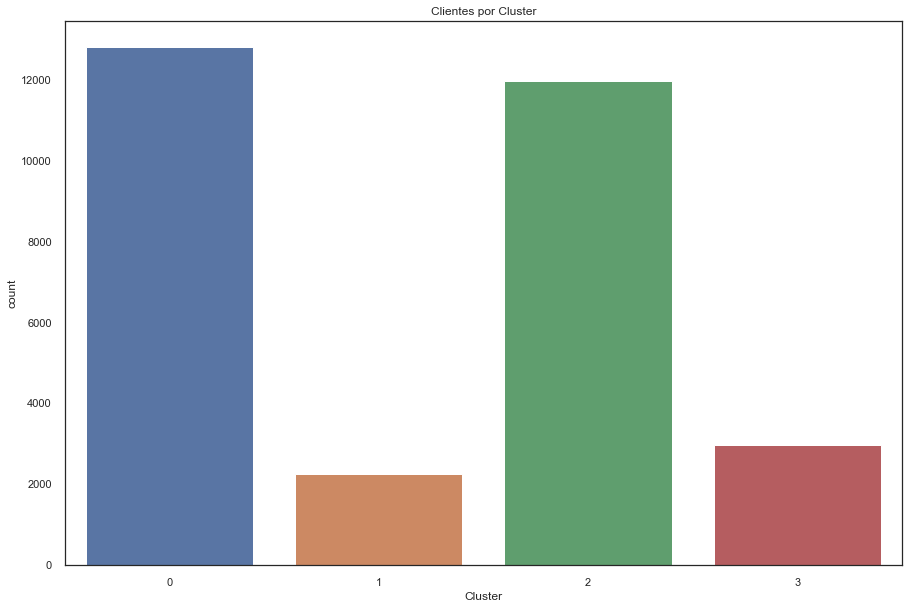

In [51]:
plt.figure(figsize=(15,10))
sns.countplot(x=y_pred)
plt.title('Clientes por Cluster')
plt.xlabel('Cluster');

**Vamos a realizar una reducción de dimensiones de los datos de segmentación para poder hacer gráficos de dispersión y poder ver como están distribuidos los clusters**

In [52]:
X_umap=get_umap(X,2)

In [61]:
X_umap['cluster'] = y_pred

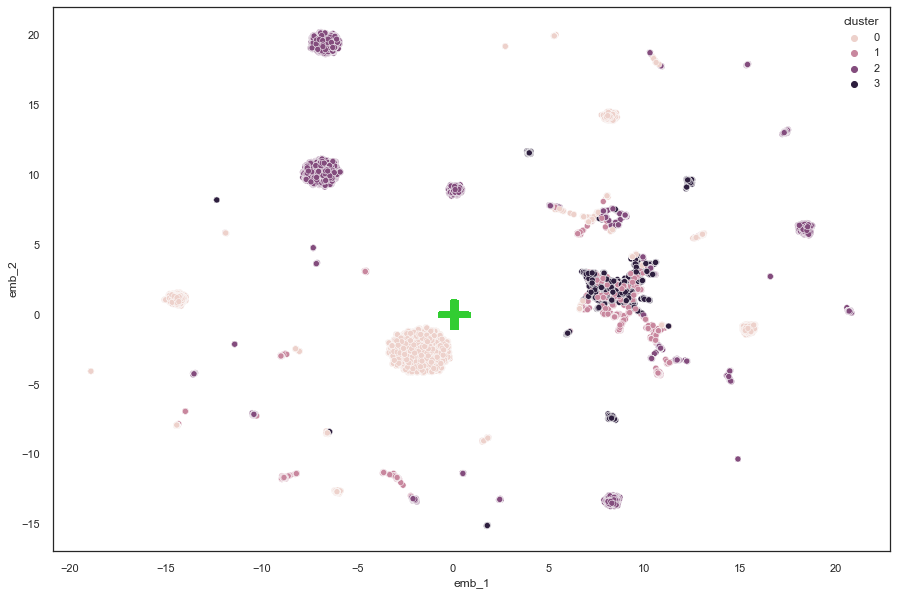

In [62]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=X_umap, x='emb_1', y='emb_2', hue='cluster')
'''plt.scatter(x=kmeans_k4.cluster_centers_[:, 0], y=kmeans_k4.cluster_centers_[:, 1],
                marker='+', s=30, linewidths=30,
                color='limegreen', zorder=11, alpha=1)'''
plt.show();

Como observamos en la imagen el algoritmo no está trabajando muy bien, y los clusters no parecen estar del todo bien definidos, así como sus centroides, que prácticamente los coloca todos muy cercanos, vamos a probar a entrenar un nuevo algoritmo con los datos obtenidos por Umap a través de la reducción de dimensiones a ver si podemos obtener mejores resultados

In [63]:
X_umap.describe().T

count      mean       std        min       25%       50%       75%  \
emb_1    30000.0  1.066087  8.668202 -18.914513 -6.445811 -1.390819  8.310186   
emb_2    30000.0  2.636710  8.717685 -15.141111 -2.818899  0.819702  9.676349   
cluster  30000.0  1.169300  1.092372   0.000000  0.000000  1.000000  2.000000   

               max  
emb_1    20.833784  
emb_2    20.255259  
cluster   3.000000

Al igual que con los datos anteriores vemos que la desviación estandar y la media están bastante dispersas, por lo que vamos a normalizar los datos para tratar de obtener mejores resultados, directamente utilizaremos el minmaxscaler que en el ejemplo anterior vimos que ayudaba un poco mejor al algoritmo.

### Umap

UMAP son las siglas de Uniform Mainfold Approximation and Projection, es un algoritmo que se usa en machine learning para aplicarlo en reducción de dimensiones, aplicar esta reducción en ocasiones es util para mejorar el desempeño computacional del modelo como para agrupar los datos y dismunir su dispersión.

In [64]:
X_umap = X_umap.drop('cluster', axis=1)

In [65]:
mm_umap = MinMaxScaler()
X_umap_mm = mm_umap.fit_transform(X_umap)

In [66]:
kmeans_per_k_umap = [KMeans(n_clusters=k,random_state=42).fit(X_umap_mm) for k in tqdm(range(2,10))]
inertias_umap = [model.inertia_ for model in tqdm(kmeans_per_k_umap)]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

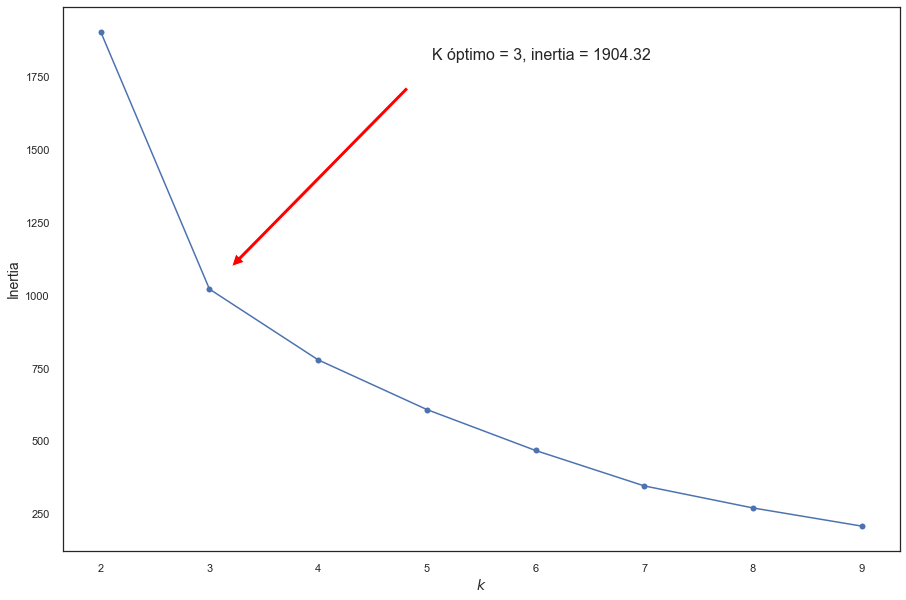

In [132]:
plot_elbow(inertias_umap, annot=True, save=False)

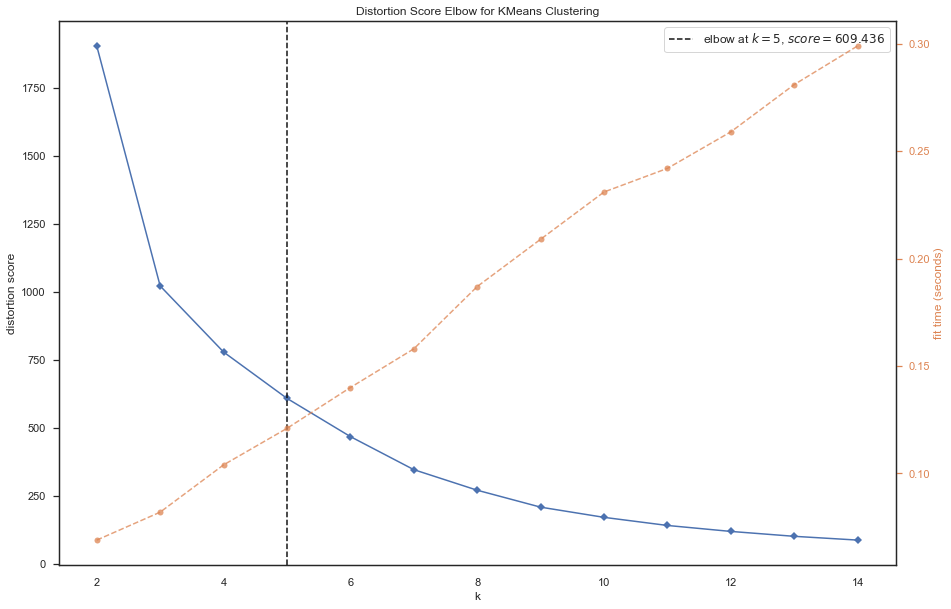

In [64]:
plot_KElbowVisualizer(X_umap_mm)

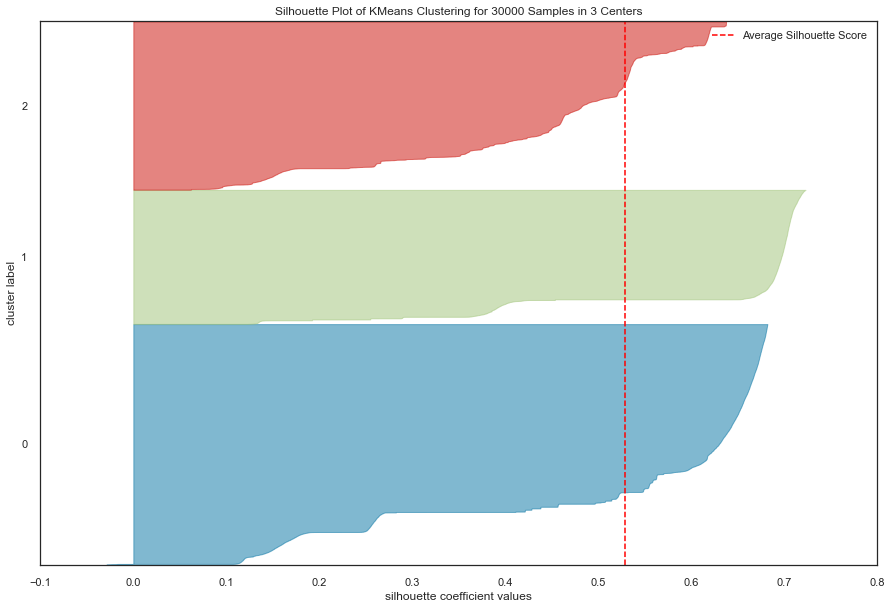

In [65]:
plot_silhouette_visualizer(X_umap_mm,3)

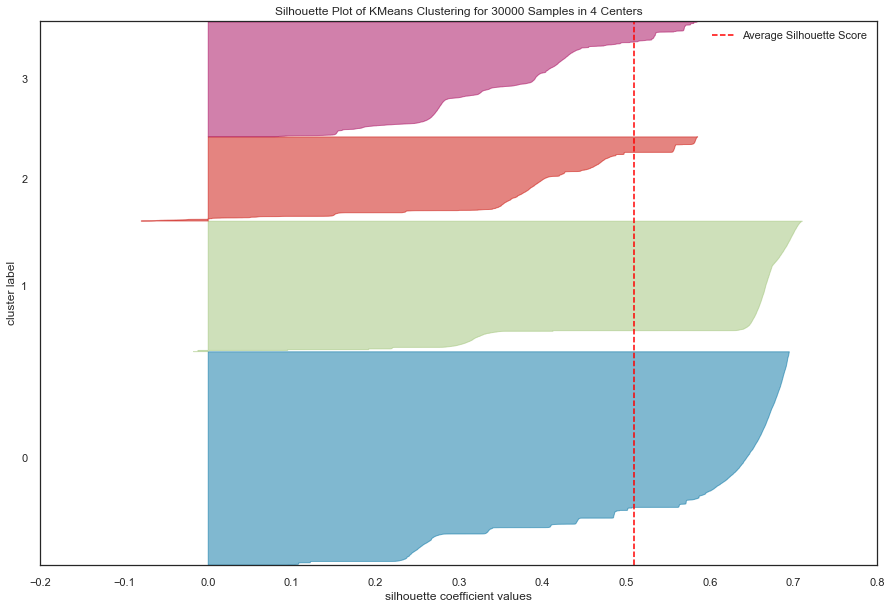

In [66]:
plot_silhouette_visualizer(X_umap_mm,4)

Al comparar ambos diagramas de silhouttes para 3 y 4 clusters vemos que agrupa mejor con 3 clusters ya que los grupos son mas homogéneos y carecen de outliers, ya que en el modelo de 4 clusters vemos que en el grupo 1 y 2 hay algunos valores con coeficiente negativo lo que nos indica valores que el modelo no ha podido identificar del todo bien en ese grupo

In [67]:
kmeans_umap = KMeans(n_clusters=3, random_state=42)

In [68]:
y_pred_umap = kmeans_umap.fit_predict(X_umap_mm)

In [69]:
X_umap_mm = pd.DataFrame(X_umap_mm, columns=X_umap.columns)

In [70]:
X_umap_mm['id_cliente'] = df.id_cliente
X_umap_mm['total_productos'] = [sum(r[:-1].values) for i,r in X.iterrows()]
data2 = pd.merge(left=X_umap_mm, right=clientes, left_on='id_cliente', right_on='id_cliente')
data2['cluster'] = y_pred_umap

In [71]:
centroids = pd.DataFrame(kmeans_umap.cluster_centers_, columns=['x','y'])

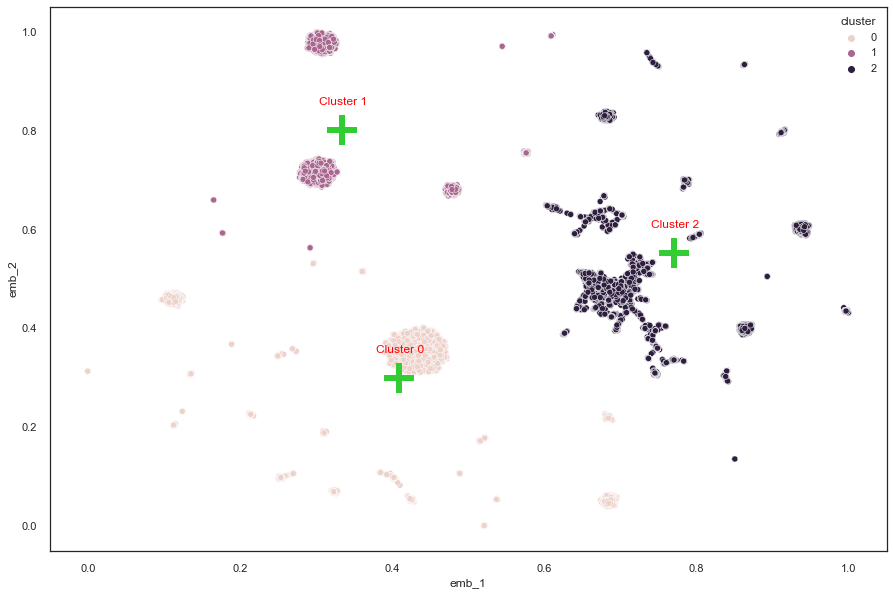

In [72]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=data2, x='emb_1', y='emb_2', hue='cluster')
plt.scatter(data=centroids, x='x', y='y',
                marker='+', s=30, linewidths=30,
                color='limegreen', zorder=11, alpha=1)
for i in range(3):
    plt.annotate(f'Cluster {i}', (centroids['x'][i]-0.03,centroids['y'][i]+0.05), zorder=13, color='red')
    
plt.show();

### Análisis de Clusters Kmeans

Una vez determinados los clusters por nuestro modelo elegido que en este caso es una combinación de Kmeans + Umap con los datos normalizados mediante la transformación MinMaxScaler, vamos a proceder al análisis de los clusters proporcionados por el modelo, para tratar de comprender el perfil de cliente de cada uno de los clusters.

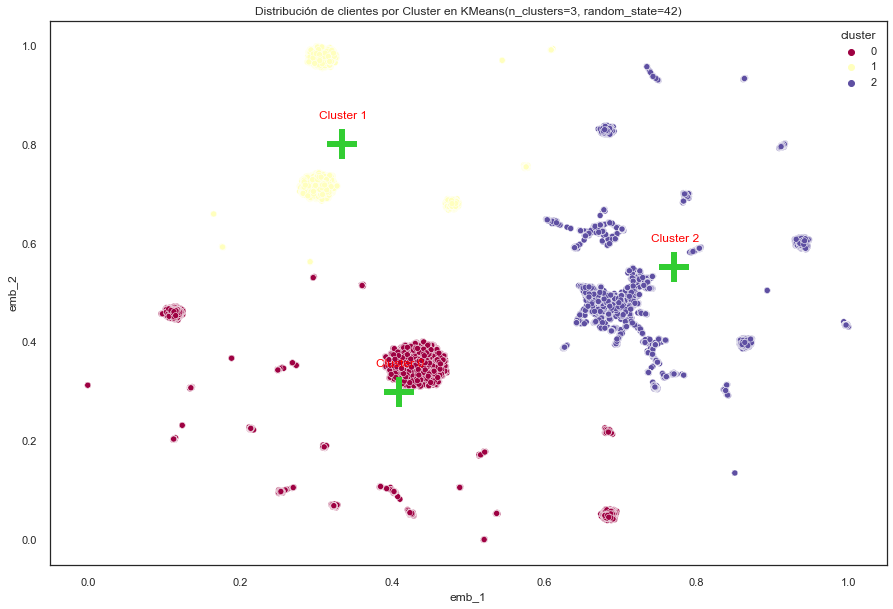

In [73]:
plot_clusters(data2, kmeans_umap, save=True)

In [74]:
data2[data2.cluster==0].head()

emb_1     emb_2  id_cliente  total_productos sexo estado_civil  \
0  0.428088  0.356755           1                1    H            C   
1  0.410045  0.339224           2                1    M            C   
3  0.440719  0.393209           4                1    M            C   
4  0.450774  0.385100           5                1    M            S   
7  0.406595  0.381677           8                1    M            C   

  tipo_baja familia_captacion  cluster  
0     nunca           No_vida        0  
1   parcial           No_vida        0  
3     total           No_vida        0  
4     nunca           No_vida        0  
7     total           No_vida        0

#### Cluster 0

In [75]:
print(f'Total de clientes en cluster 0 --> {len(data2[data2.cluster==0])}')

Total de clientes en cluster 0 --> 13292


In [76]:
data2[data2.cluster==0]['familia_captacion'].value_counts()

No_vida            9692
Vida_Riesgo        1382
Ahorro             1160
Jubilacion_GOLF     317
Vida_Riesgo_PM      210
Jubilacion          190
Riesgo_Tomador      102
RC                   89
Rentas               77
Autos                73
Name: familia_captacion, dtype: int64

##### Contrataciones por tipo de producto

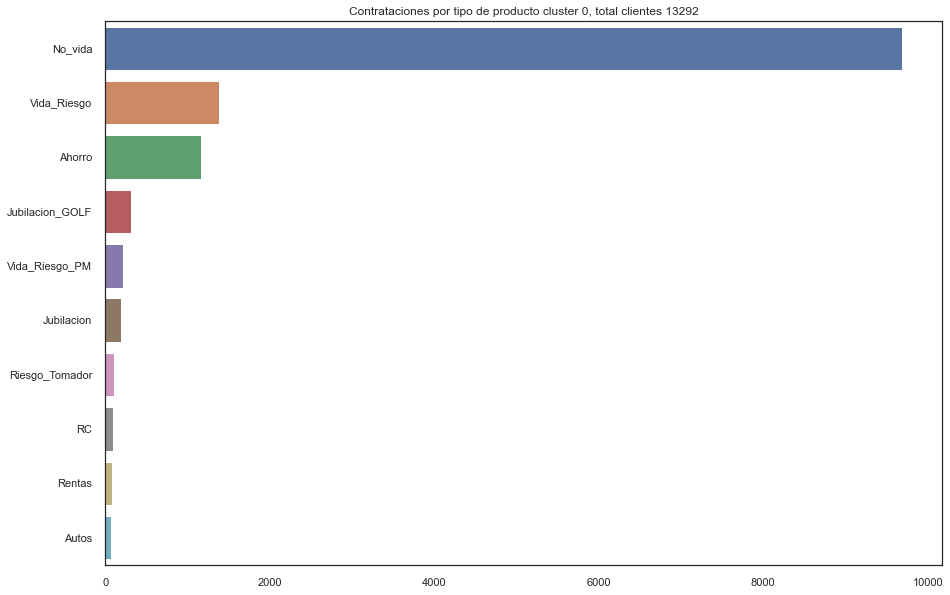

In [77]:
plot_productos_x_cluster(data2, 0,True)

##### Total Productos contratados

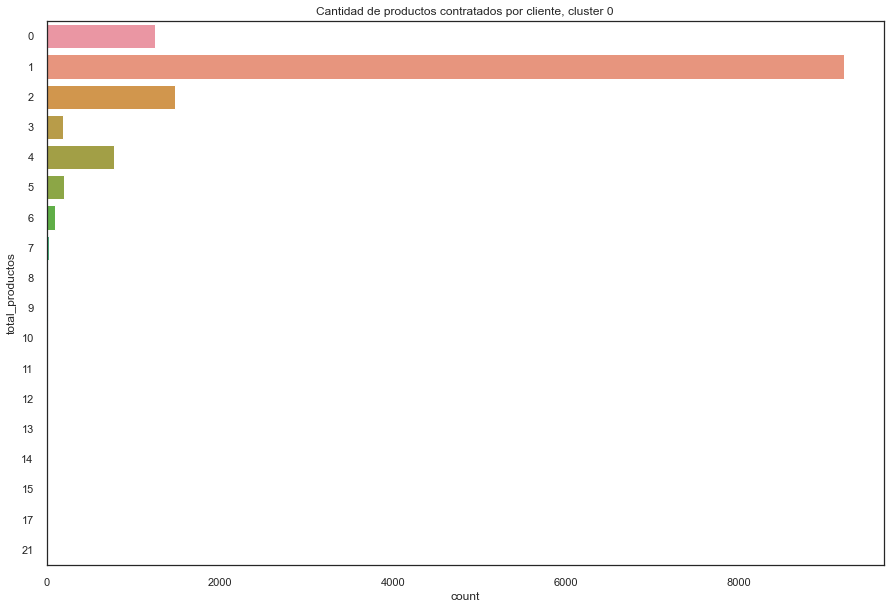

In [78]:
plot_total_productos_x_cluster(data2, 0,True)

##### Perfil de cliente

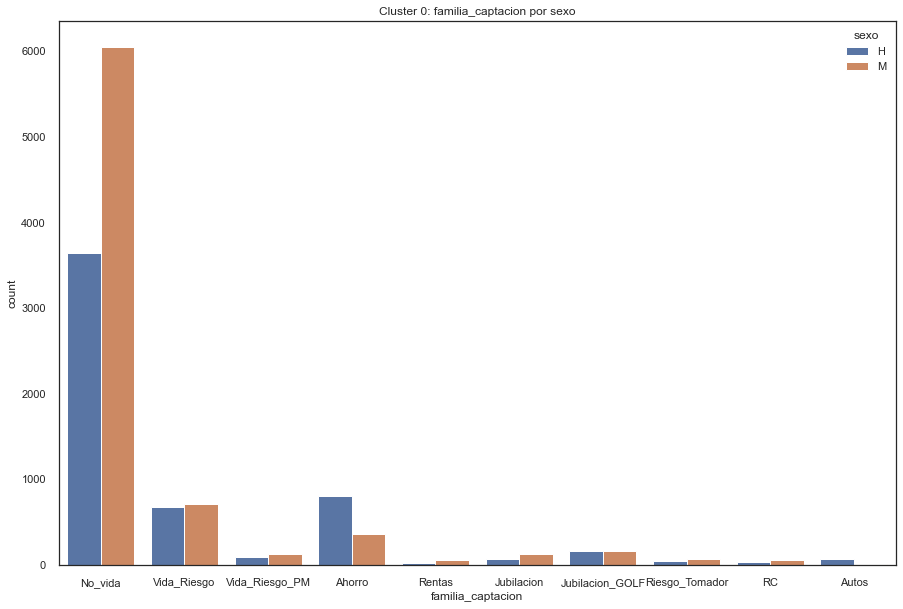

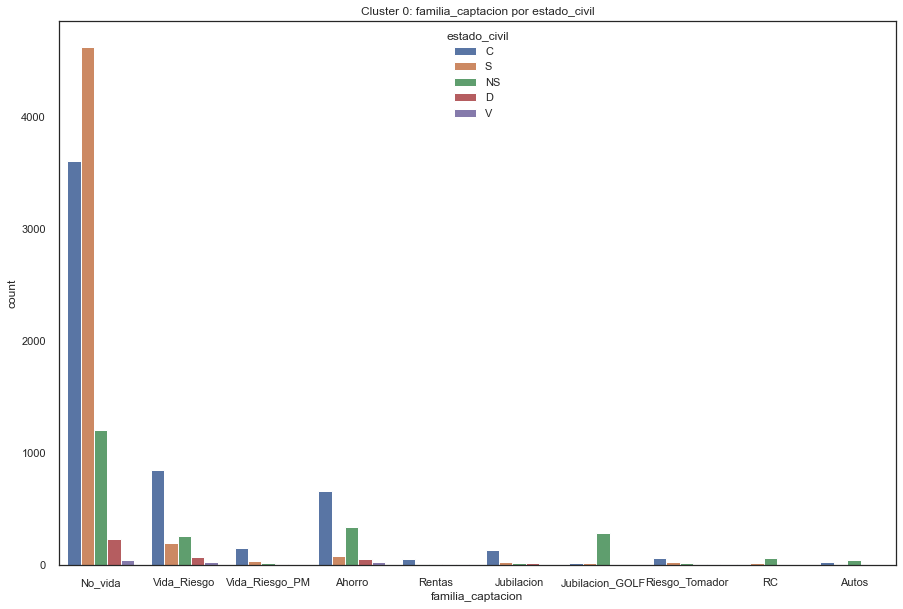

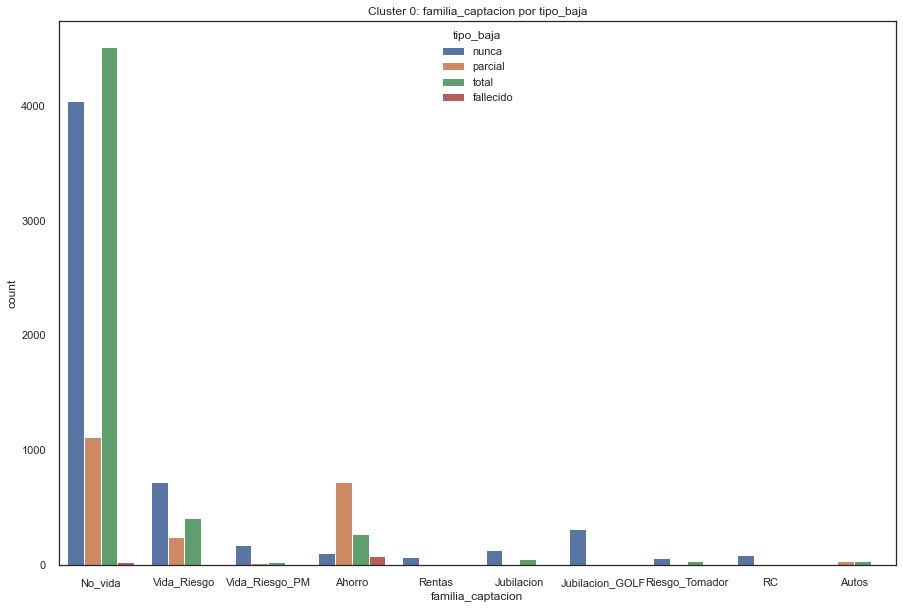

In [79]:
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(data2, 0,'familia_captacion', e,True)

    Con los datos obtenidos podemos determinar que el perfil de nuestro cliente tipo en el cluster 0 es de mujeres solteras, que como norma general contratan un único producto, principalmente polizas de No vida, con un arraigo importante con la compañia ya que no suelen darse de baja, pero si lo hacen lo hacen forma total.

#### Cluster 1

In [80]:
print(f'Total de clientes en cluster 1 --> {len(data2[data2.cluster==1])}')

Total de clientes en cluster 1 --> 7408


In [81]:
data2[data2.cluster==1]['familia_captacion'].value_counts()

Ahorro            6144
Autos              960
Vida_Riesgo        226
No_vida             66
Riesgo_Tomador      10
Jubilacion           2
Name: familia_captacion, dtype: int64

##### Contrataciones por tipo de producto

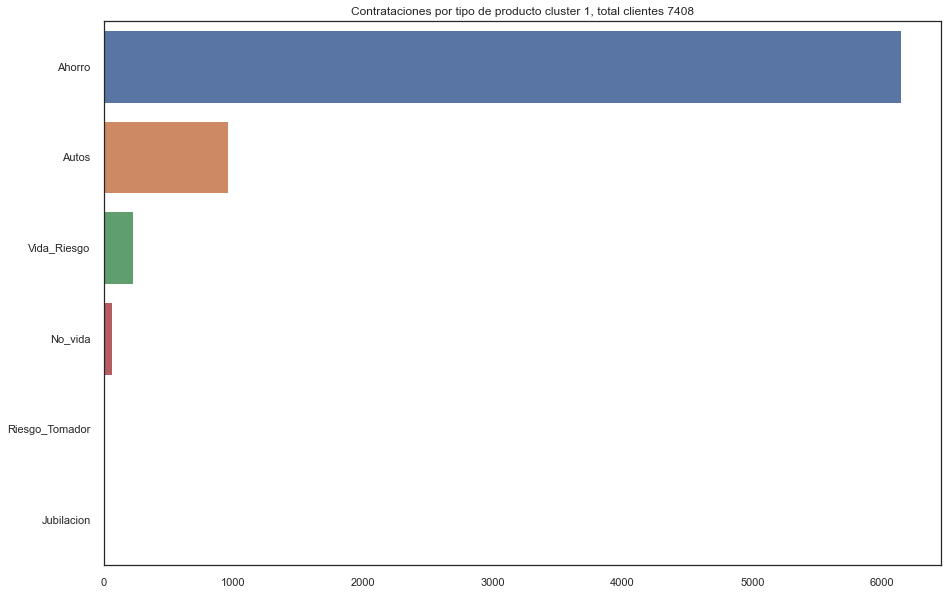

In [82]:
plot_productos_x_cluster(data2, 1,True)

##### Total de productos contratados

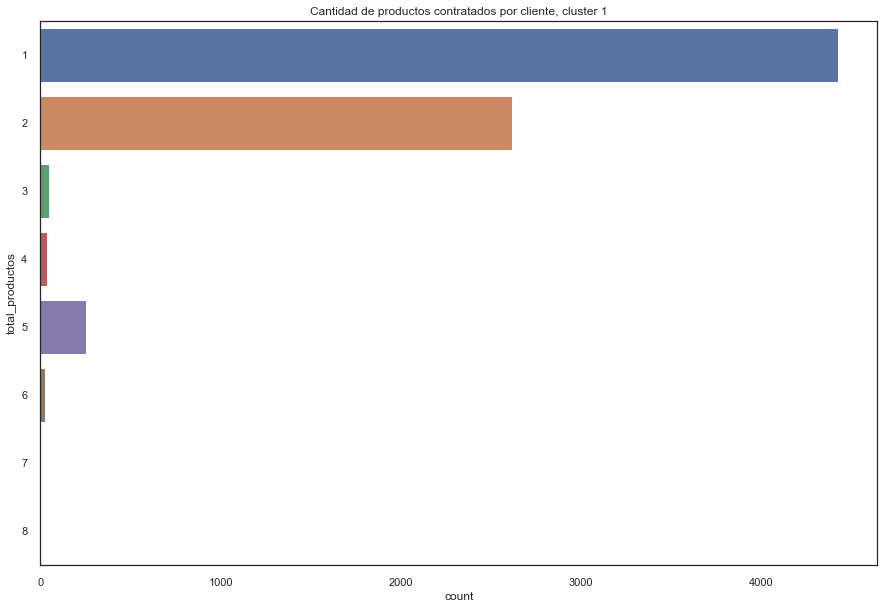

In [83]:
plot_total_productos_x_cluster(data2, 1,True)

##### Perfil de cliente

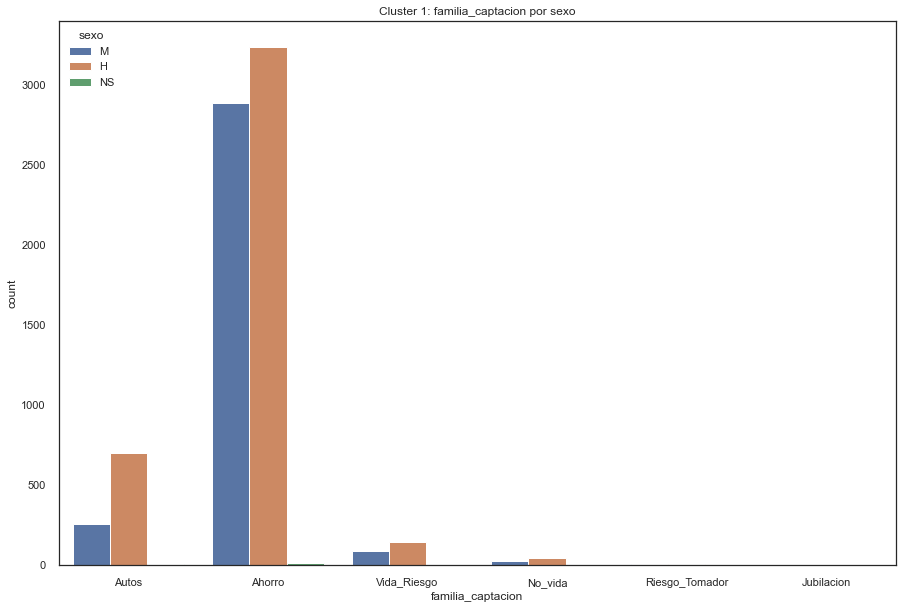

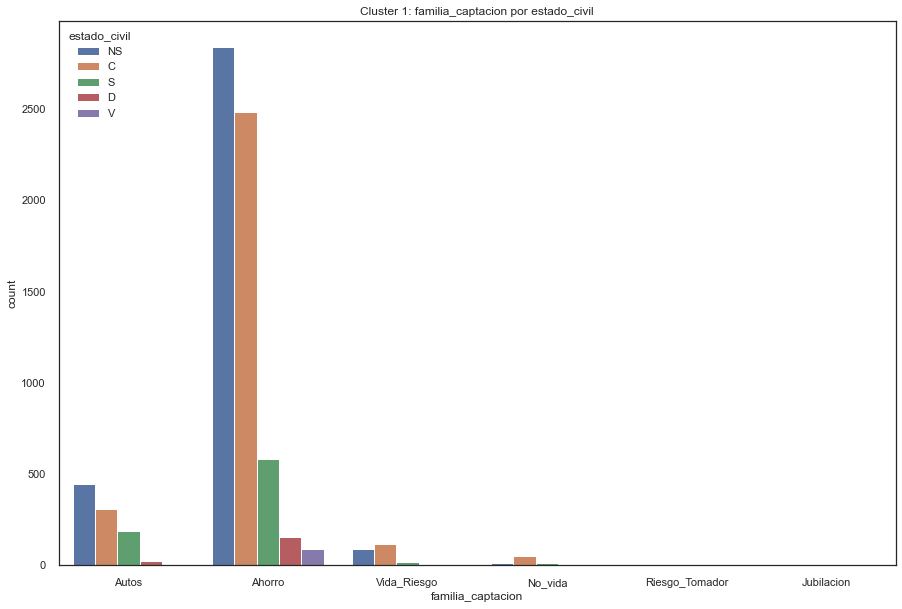

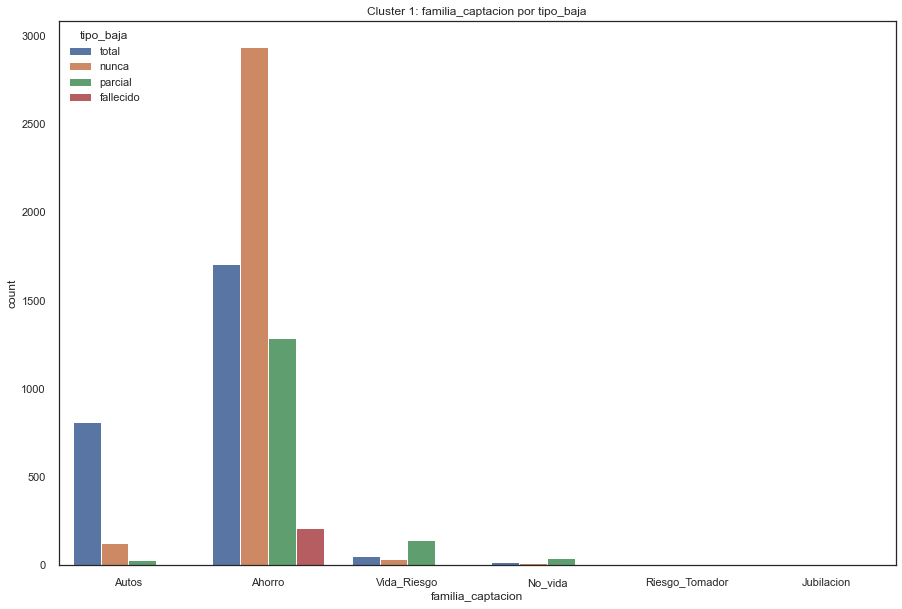

In [84]:
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(data2, 1,'familia_captacion', e, True)

    El perfil del cliente del cluster 1 son hombres o mujeres en su mayoría casados, aunque hay muchos que no han querido establecer su estado civil, que contratan entre 1 y 2 pólizas, principalmente de Ahorro y Coche y suelen tener un arraigo importante con la compañia, siendo bastante fieles y casi nunca han causado baja, o si lo hacen lo hacen de forma parcial en las pólizas de ahorro, pero este hecho cambia radicalmente en las polizas de coches, en los que la baja siempre es total.

#### Cluster 2

In [85]:
print(f'Total de clientes en cluster 2 --> {len(data2[data2.cluster==2])}')

Total de clientes en cluster 2 --> 9300


In [86]:
data2[data2.cluster==2]['familia_captacion'].value_counts()

Ahorro             6276
No_vida            1239
Autos               921
Vida_Riesgo         338
Jubilacion          197
Jubilacion_GOLF     112
Riesgo_Tomador      100
Rentas               62
Salud                34
Vida_Riesgo_PM       21
Name: familia_captacion, dtype: int64

##### Contrataciones por tipo de producto

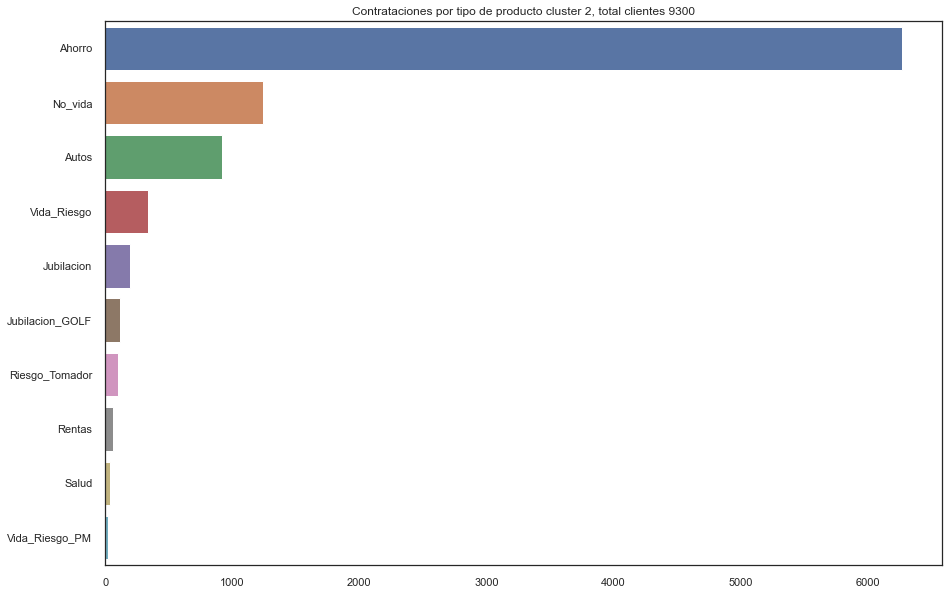

In [87]:
plot_productos_x_cluster(data2, 2,True)

##### Total de productos contratados

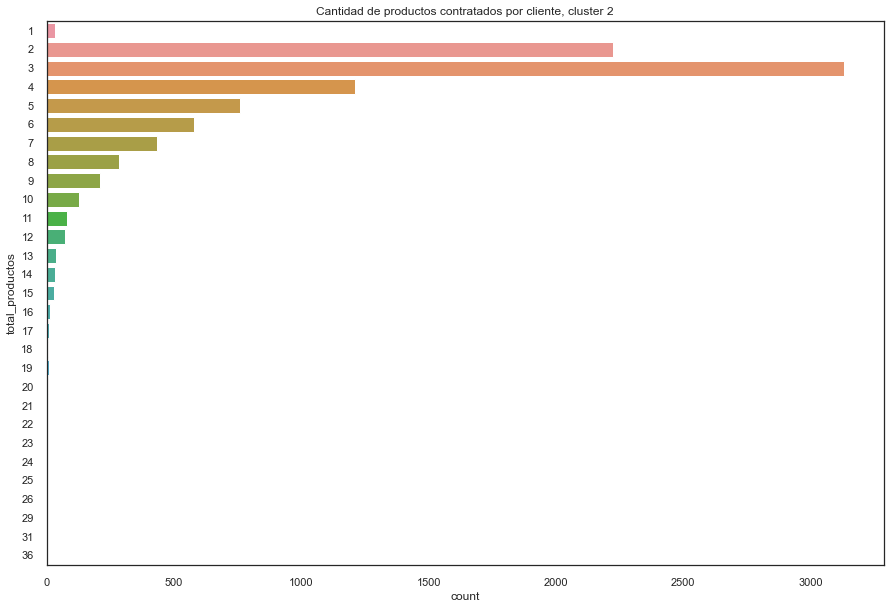

In [88]:
plot_total_productos_x_cluster(data2, 2, True)

In [89]:
data2[data2.cluster==2]['familia_captacion'].value_counts()

Ahorro             6276
No_vida            1239
Autos               921
Vida_Riesgo         338
Jubilacion          197
Jubilacion_GOLF     112
Riesgo_Tomador      100
Rentas               62
Salud                34
Vida_Riesgo_PM       21
Name: familia_captacion, dtype: int64

##### Perfil de cliente

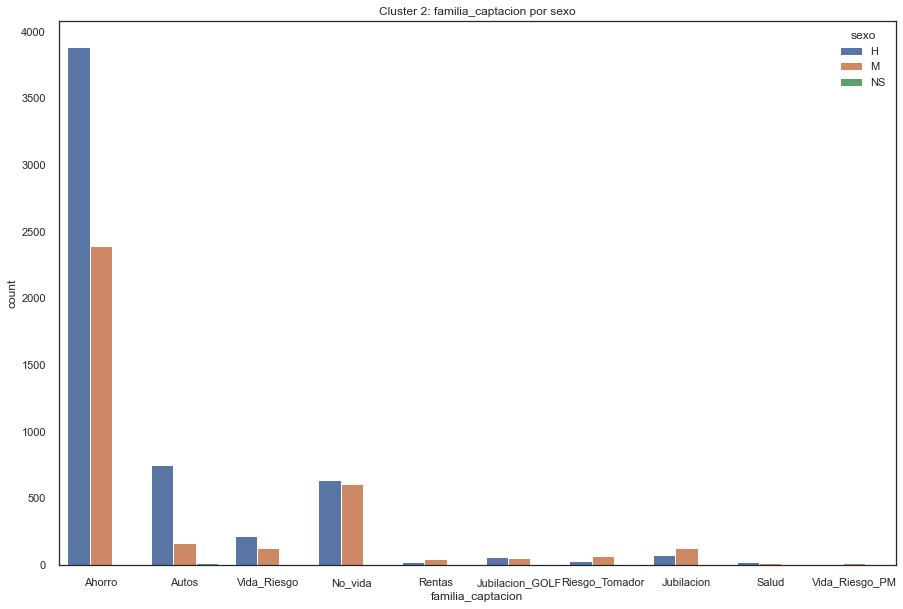

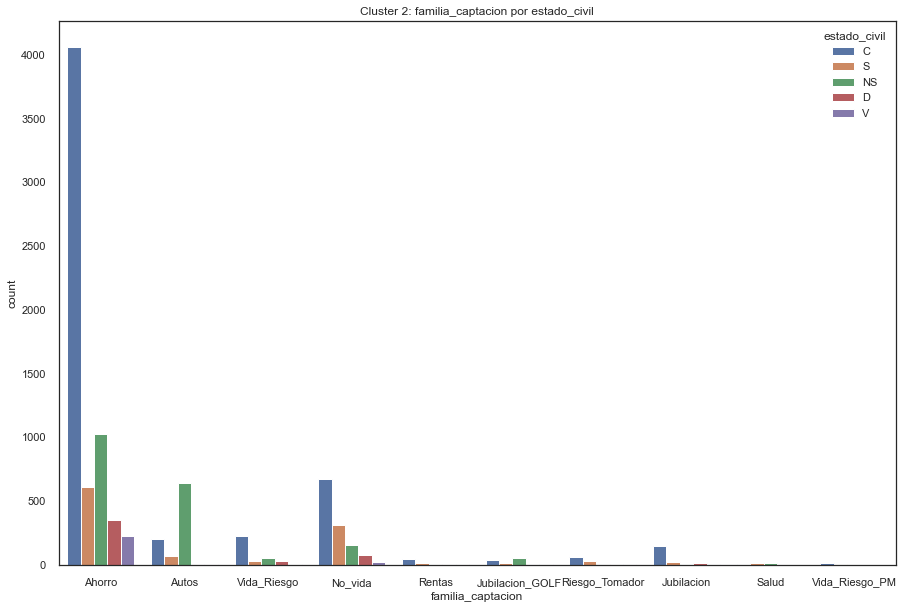

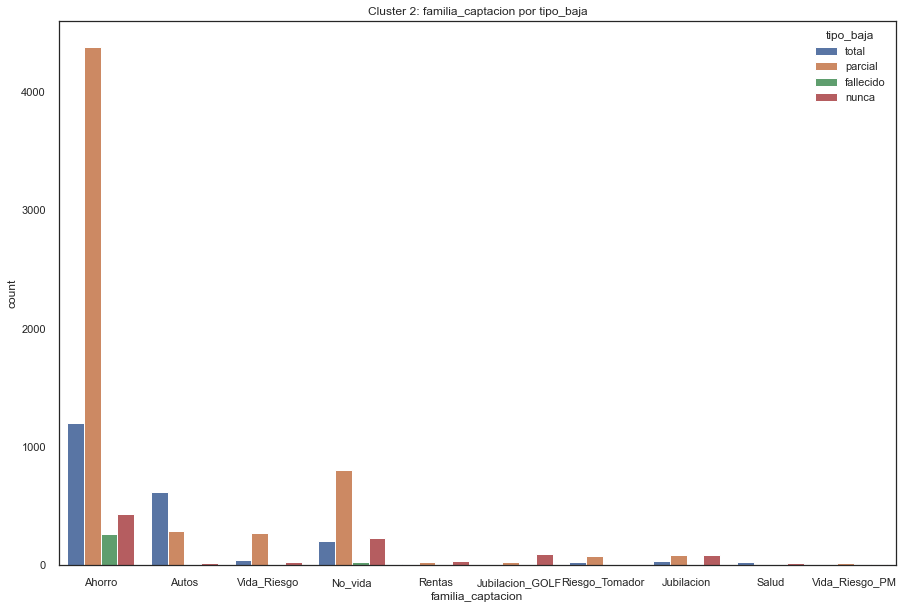

In [90]:
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(data2, 2,'familia_captacion', e, True)

    El perfil de clientes que nos encontramos el último cluster propuesto por el modelo es un cliente en su mayoria de sexo masculino, casado y que tiene contratados más de 2 pólizas con la compañía siendo los productos más contratodos pólizas de Ahorro, Coche y No vida, pero con cierta volatilidad en estos productos porque suele incurrir en bajas parciales, principalmente en las pólizas de Ahorro.

## DBScan 

En la prueba se nos pide que apliquemos otros algoritmos de agrupación además de `Kmeans` como es `DBScan`. A diferencia de `Kmeans` que se basa en la distancia de cada punto (observación) al centroide del cluster, `DBScan` basa su trabajo en la distribución de la densidad de los puntos, empieza por un punto de forma aleatoria y determina los clusters en base a un número mínimo de puntos para cada cluster y una distancia epsilon entre los puntos.

**Ventajas**

    - No necesita especificar el número de clusters
    - Puede hacer clusters con formas geomtrícas arbitrarias, al contrario que Kmeans que si o si son esféricos
    - Es fuerte detectando outliers
    - Requiere únicamente dos parametros epsilon y min_samples

**Desventajas**

    - Es poco determinista, un punto puede pertenercer a más de un cluster
    - La calidad de DBScan depende de la distancia determinada en la función, normalmente la euclídea, especialmente cuando los datos tienen alta dispersión, pero es un problema que puede aparecer en cualquier algoritmo basado en la distancia euclidea.
    - No agrupa bien con grupos de varias densidades ya que su desempeño se basa enun número minimo de elementos por cluster

Al igual que con el algoritmo de `Kmeans` vamos a proponer distintos experimentos para ver como se comporta mejor el algoritmo, primero usaremos los datos normalizados con `StandarScaler` y `MinMaxScaler`, para después aplicar `Umap` tanto para poder visualizar los cluster como para entrenar un modelo con los datos redimensionados, y realizar un posterior análisis de los cluster propuestos por el modelo. 

### StandarScaler

In [91]:
X_sc.head()

n_polizas_tomador_ahorro  n_polizas_tomador_autos  \
0                 -0.728181                -0.203933   
1                 -0.728181                -0.203933   
2                  2.255435                -0.203933   
3                 -0.728181                -0.203933   
4                 -0.728181                -0.203933   

   n_polizas_tomador_jubilacion  n_polizas_tomador_jubilacion_golf  \
0                      -0.22173                          -0.216096   
1                      -0.22173                          -0.216096   
2                      -0.22173                          -0.216096   
3                      -0.22173                          -0.216096   
4                      -0.22173                          -0.216096   

   n_polizas_tomador_no_vida  n_polizas_tomador_rc  n_polizas_tomador_rentas  \
0                   0.505423             -0.068745                 -0.186533   
1                   0.505423             -0.068745                 -0.186533   
2                  -0.859111             -0.068745                  6.055509   
3                   0.505423             -0.068745                 -0.186533   
4                   0.505423             -0.068745                 -0.186533   

   n_polizas_tomador_riesgo_tomador  n_polizas_tomador_vida_riesgo  \
0                         -0.178373                      -0.036691   
1                         -0.178373                      -0.036691   
2                          2.575720                      -0.036691   
3                         -0.178373                      -0.036691   
4                         -0.178373                      -0.036691   

   n_polizas_tomador_vida_riesgo_pm  
0                         -0.269778  
1                         -0.269778  
2                         -0.269778  
3                         -0.269778  
4                         -0.269778

In [92]:
X_sc.describe().T

count          mean       std       min  \
n_polizas_tomador_ahorro           30000.0  3.552714e-17  1.000017 -0.728181   
n_polizas_tomador_autos            30000.0  1.681618e-17  1.000017 -0.203933   
n_polizas_tomador_jubilacion       30000.0 -5.376440e-17  1.000017 -0.221730   
n_polizas_tomador_jubilacion_golf  30000.0 -4.357995e-17  1.000017 -0.216096   
n_polizas_tomador_no_vida          30000.0 -3.789561e-17  1.000017 -0.859111   
n_polizas_tomador_rc               30000.0  2.475057e-17  1.000017 -0.068745   
n_polizas_tomador_rentas           30000.0 -1.705303e-17  1.000017 -0.186533   
n_polizas_tomador_riesgo_tomador   30000.0 -4.689582e-17  1.000017 -0.178373   
n_polizas_tomador_vida_riesgo      30000.0 -9.355479e-18  1.000017 -0.036691   
n_polizas_tomador_vida_riesgo_pm   30000.0 -6.394885e-17  1.000017 -0.269778   

                                        25%       50%       75%        max  
n_polizas_tomador_ahorro          -0.728181 -0.131458  0.465265  14.786624  
n_polizas_tomador_autos           -0.203933 -0.203933 -0.203933  27.313270  
n_polizas_tomador_jubilacion      -0.221730 -0.221730 -0.221730  33.305935  
n_polizas_tomador_jubilacion_golf -0.216096 -0.216096 -0.216096  35.650470  
n_polizas_tomador_no_vida         -0.859111  0.505423  0.505423  15.515297  
n_polizas_tomador_rc              -0.068745 -0.068745 -0.068745  28.377260  
n_polizas_tomador_rentas          -0.186533 -0.186533 -0.186533  27.902654  
n_polizas_tomador_riesgo_tomador  -0.178373 -0.178373 -0.178373  27.362562  
n_polizas_tomador_vida_riesgo     -0.036691 -0.036691 -0.036691  49.996954  
n_polizas_tomador_vida_riesgo_pm  -0.269778 -0.269778 -0.269778  12.536154

Para tratar de obtener un epsilon y mínimo número de elementos por cluster voy a utilizar la siguiente fórmula, para el epsilón voy a probar calculando la media del rango de valor entre el máximo y el mínimo de cada columna y tomando el 2,5% de ese valor como epsilon para el modelo, y para el número mínimo de observaciones por cluster he decidido tomar un 2,5% del valor total de observaciones.

In [146]:
epsilon_cal = round(np.mean([(max(X_sc[c])-min(X_sc[c])) for c in X_sc.columns])*0.0025,2)

In [147]:
samples_min = int(len(X_sc)*0.025)

In [148]:
dbscan_sc = DBSCAN(eps=epsilon_cal, min_samples=samples_min)
dbscan_sc.fit(X_sc)

DBSCAN(eps=0.07, min_samples=750)

In [149]:
set(dbscan_sc.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8}

In [150]:
dbscan_df = pd.DataFrame(X_umap_mm)

In [151]:
dbscan_df['cluster']= dbscan_sc.labels_

In [152]:
dbscan_df.cluster.value_counts()

-1    9884
 0    8031
 3    3542
 6    2491
 2    1259
 4    1081
 7    1039
 8     972
 1     881
 5     820
Name: cluster, dtype: int64

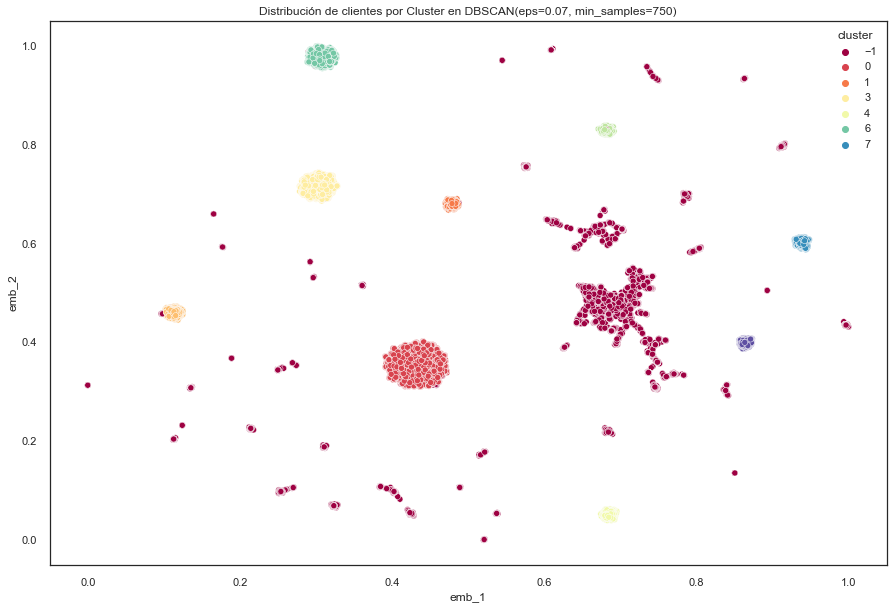

In [153]:
plot_clusters(dbscan_df, dbscan_sc, centroids=False)

Como podemos observar en los resultados y en el gráfico el resultado no es muy óptimo ya que el algoritmo está categorizando mas de 8000 como un outlier (cluster -1), y en el gráfico observamos como los clusters no quedan bien determinados, podemos descartar este modelo y probar otro.

### MinMaxScaler

In [154]:
X_mm.head()

n_polizas_tomador_ahorro  n_polizas_tomador_autos  \
0                  0.000000                      0.0   
1                  0.000000                      0.0   
2                  0.192308                      0.0   
3                  0.000000                      0.0   
4                  0.000000                      0.0   

   n_polizas_tomador_jubilacion  n_polizas_tomador_jubilacion_golf  \
0                           0.0                                0.0   
1                           0.0                                0.0   
2                           0.0                                0.0   
3                           0.0                                0.0   
4                           0.0                                0.0   

   n_polizas_tomador_no_vida  n_polizas_tomador_rc  n_polizas_tomador_rentas  \
0                   0.083333                   0.0                  0.000000   
1                   0.083333                   0.0                  0.000000   
2                   0.000000                   0.0                  0.222222   
3                   0.083333                   0.0                  0.000000   
4                   0.083333                   0.0                  0.000000   

   n_polizas_tomador_riesgo_tomador  n_polizas_tomador_vida_riesgo  \
0                               0.0                            0.0   
1                               0.0                            0.0   
2                               0.1                            0.0   
3                               0.0                            0.0   
4                               0.0                            0.0   

   n_polizas_tomador_vida_riesgo_pm  
0                               0.0  
1                               0.0  
2                               0.0  
3                               0.0  
4                               0.0

In [155]:
X_mm.describe().T

count      mean       std  min  25%  \
n_polizas_tomador_ahorro           30000.0  0.046935  0.064456  0.0  0.0   
n_polizas_tomador_autos            30000.0  0.007411  0.036342  0.0  0.0   
n_polizas_tomador_jubilacion       30000.0  0.006613  0.029827  0.0  0.0   
n_polizas_tomador_jubilacion_golf  30000.0  0.006025  0.027882  0.0  0.0   
n_polizas_tomador_no_vida          30000.0  0.052467  0.061072  0.0  0.0   
n_polizas_tomador_rc               30000.0  0.002417  0.035155  0.0  0.0   
n_polizas_tomador_rentas           30000.0  0.006641  0.035601  0.0  0.0   
n_polizas_tomador_riesgo_tomador   30000.0  0.006477  0.036310  0.0  0.0   
n_polizas_tomador_vida_riesgo      30000.0  0.000733  0.019987  0.0  0.0   
n_polizas_tomador_vida_riesgo_pm   30000.0  0.021067  0.078090  0.0  0.0   

                                        50%       75%  max  
n_polizas_tomador_ahorro           0.038462  0.076923  1.0  
n_polizas_tomador_autos            0.000000  0.000000  1.0  
n_polizas_tomador_jubilacion       0.000000  0.000000  1.0  
n_polizas_tomador_jubilacion_golf  0.000000  0.000000  1.0  
n_polizas_tomador_no_vida          0.083333  0.083333  1.0  
n_polizas_tomador_rc               0.000000  0.000000  1.0  
n_polizas_tomador_rentas           0.000000  0.000000  1.0  
n_polizas_tomador_riesgo_tomador   0.000000  0.000000  1.0  
n_polizas_tomador_vida_riesgo      0.000000  0.000000  1.0  
n_polizas_tomador_vida_riesgo_pm   0.000000  0.000000  1.0

In [156]:
epsilon_cal = round(np.mean([(max(X_mm[c])-min(X_mm[c])) for c in X_sc.columns])*0.025,3)
dbscan_mm = DBSCAN(eps=epsilon_cal, min_samples=samples_min)
dbscan_mm.fit(X_mm)
print(dbscan_mm)
dbscan_mm_df = pd.DataFrame(X_umap_mm)
dbscan_mm_df['cluster']= dbscan_mm.labels_
dbscan_mm_df.cluster.value_counts()

DBSCAN(eps=0.025, min_samples=750)


-1    9884
 0    8031
 3    3542
 6    2491
 2    1259
 4    1081
 7    1039
 8     972
 1     881
 5     820
Name: cluster, dtype: int64

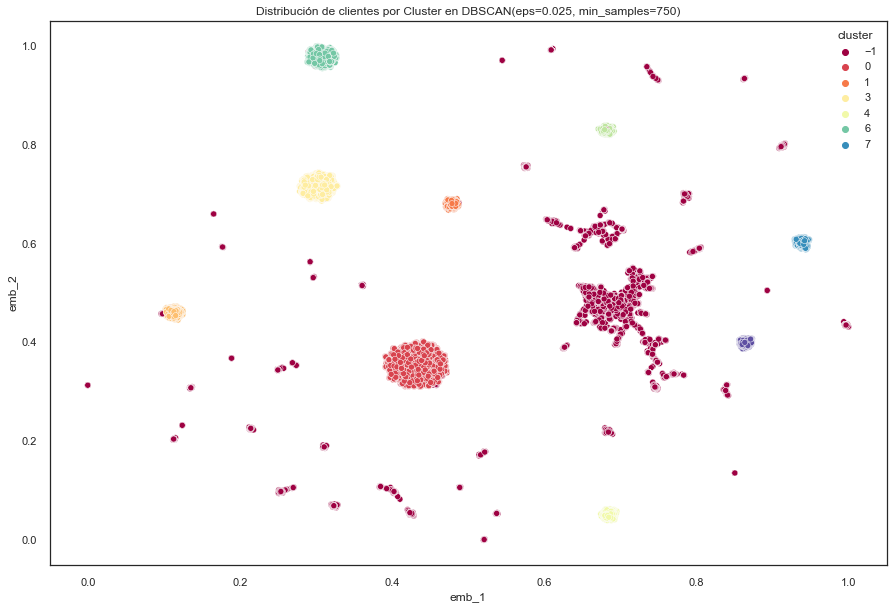

In [157]:
plot_clusters(dbscan_mm_df, dbscan_mm, centroids=False)

Como podemos observar este modelo tampoco está funcionando muy bien, ya que nos está haciendo 8 clusters, y nos está clasificando casi 10000 observaciones como outliers lo que supone casi un 33% de todo el grueso de datos, lo cual no tiene mucho sentido

### Umap

In [158]:
X_umap_mm.head()

emb_1     emb_2  id_cliente  total_productos  cluster
0  0.428088  0.356755           1                1        0
1  0.410045  0.339224           2                1        0
2  0.701678  0.492283           3                8       -1
3  0.440719  0.393209           4                1        0
4  0.450774  0.385100           5                1        0

In [159]:
X_umap_mm = X_umap_mm[['emb_1', 'emb_2']]
X_umap_mm.head()

emb_1     emb_2
0  0.428088  0.356755
1  0.410045  0.339224
2  0.701678  0.492283
3  0.440719  0.393209
4  0.450774  0.385100

In [160]:
X_umap_mm.describe().T

count      mean       std  min       25%       50%       75%  max
emb_1  30000.0  0.502678  0.218077  0.0  0.313691  0.440867  0.684927  1.0
emb_2  30000.0  0.502250  0.246288  0.0  0.348121  0.450917  0.701130  1.0

In [161]:
epsilon_cal = round(np.mean([(max(X_umap_mm[c])-min(X_umap_mm[c])) for c in X_umap_mm.columns])*0.5,3)
dbscan_umap_mm = DBSCAN(eps=epsilon_cal, min_samples=samples_min*4)
dbscan_umap_mm.fit(X_umap_mm)
print(dbscan_umap_mm)
dbscan_umap_mm_df = pd.DataFrame(X_umap_mm)
dbscan_umap_mm_df['cluster']= dbscan_mm.labels_
dbscan_umap_mm_df.cluster.value_counts()

DBSCAN(min_samples=3000)


-1    9884
 0    8031
 3    3542
 6    2491
 2    1259
 4    1081
 7    1039
 8     972
 1     881
 5     820
Name: cluster, dtype: int64

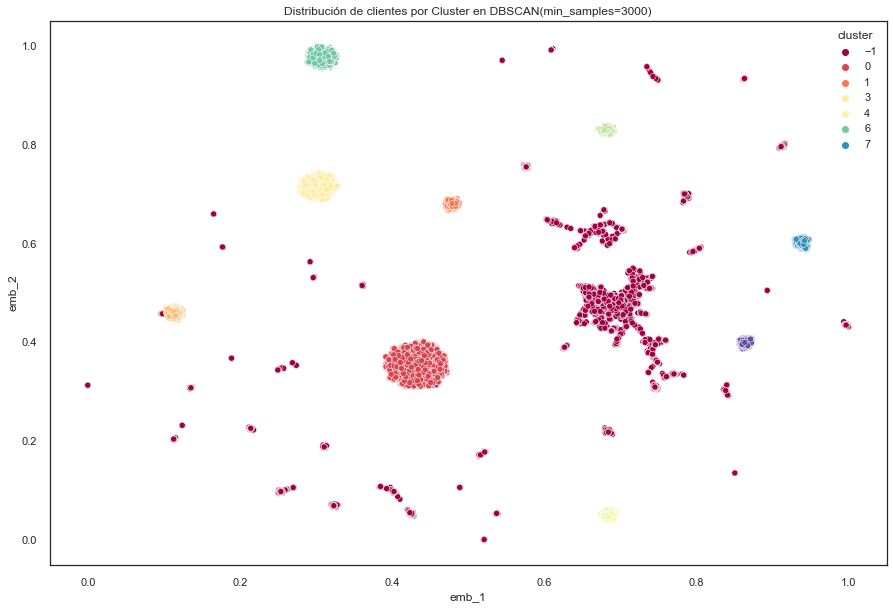

In [162]:
plot_clusters(dbscan_umap_mm_df, dbscan_umap_mm, centroids=False)

In [163]:
X_umap_mm['id_cliente'] = df.id_cliente
X_umap_mm['total_productos'] = [sum(r[:-1].values) for i,r in X.iterrows()]
data3 = pd.merge(left=X_umap_mm, right=clientes, left_on='id_cliente', right_on='id_cliente')

In [164]:
data3.head()

emb_1     emb_2  cluster  id_cliente  total_productos sexo estado_civil  \
0  0.428088  0.356755        0           1                1    H            C   
1  0.410045  0.339224        0           2                1    M            C   
2  0.701678  0.492283       -1           3                8    H            C   
3  0.440719  0.393209        0           4                1    M            C   
4  0.450774  0.385100        0           5                1    M            S   

  tipo_baja familia_captacion  
0     nunca           No_vida  
1   parcial           No_vida  
2     total            Ahorro  
3     total           No_vida  
4     nunca           No_vida

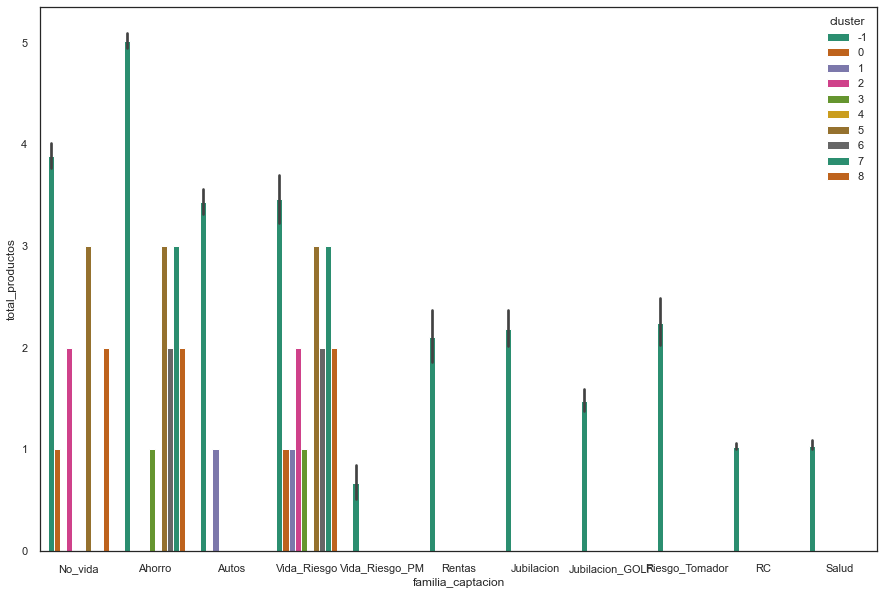

In [168]:
plt.figure(figsize=(15,10))
sns.barplot(data=data3, x='familia_captacion' ,y='total_productos', hue='cluster', palette='Dark2');

Con este gráfico podemos comprobar como se está comportando el algoritmo, lo que está haciendo básicamente es diferenciar entre los usuarios que contratan seguros de No_vida, Ahorro, Autos y Vida_Riesgo, el resto de servicios los trata como outliers, y está haciendo básicamente lo mismo en todos los experimentos realizados con dbscan, es cierto que al realizar el experimento con Umap, hace una clusterización mas clara o por lo menos con más sentido que con los datos sin tratar, pero aún así desde mi punto de vista no mejora los resultados obtenidos con el modelo de Kmeans + Umap

Como podemos observar en cluster -1 es un cajón de sastre en el que está metiendo a todos los clientes que considera outliers, principalmente son usuarios Casados que contratan principalmente polizas de Ahorro, junto con otros productos, pólizas de No vida y Auto principalmente, y su compromiso con la compañia no es muy arraigado ya que suelen tener bajas parciales, lo que puede indicar que están contentos con la compañía, pero que si reciben alguna oferta de otra compañia en alguno de los productos no dudan en cambiar ese producto específicamente y continúan en la compañía con el resto de productos.

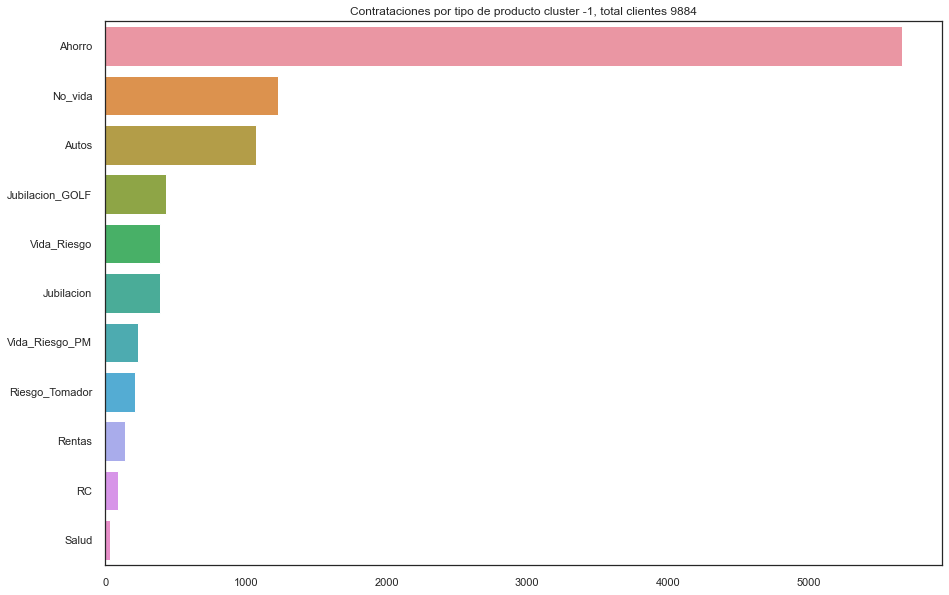

In [169]:
plot_productos_x_cluster(data3, -1, save=True)

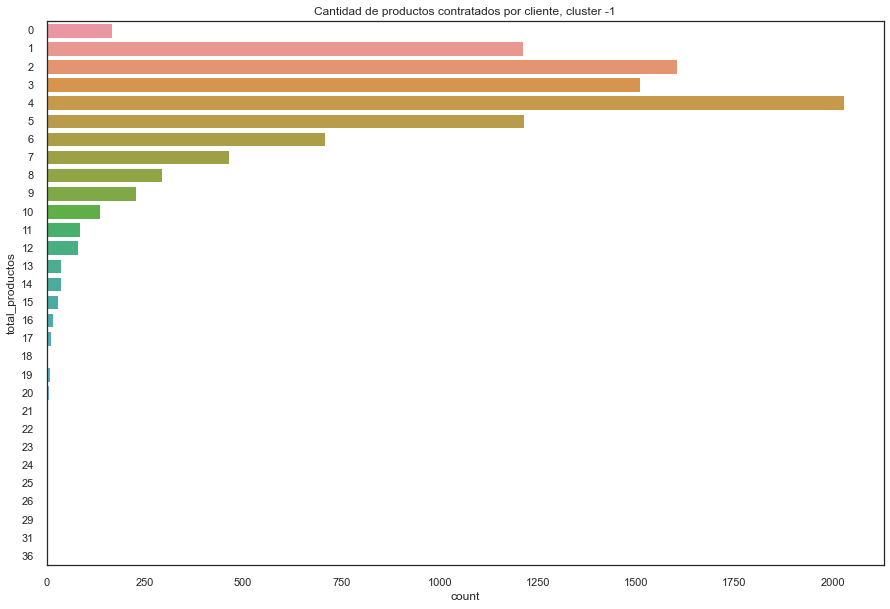

In [170]:
plot_total_productos_x_cluster(data3, -1)

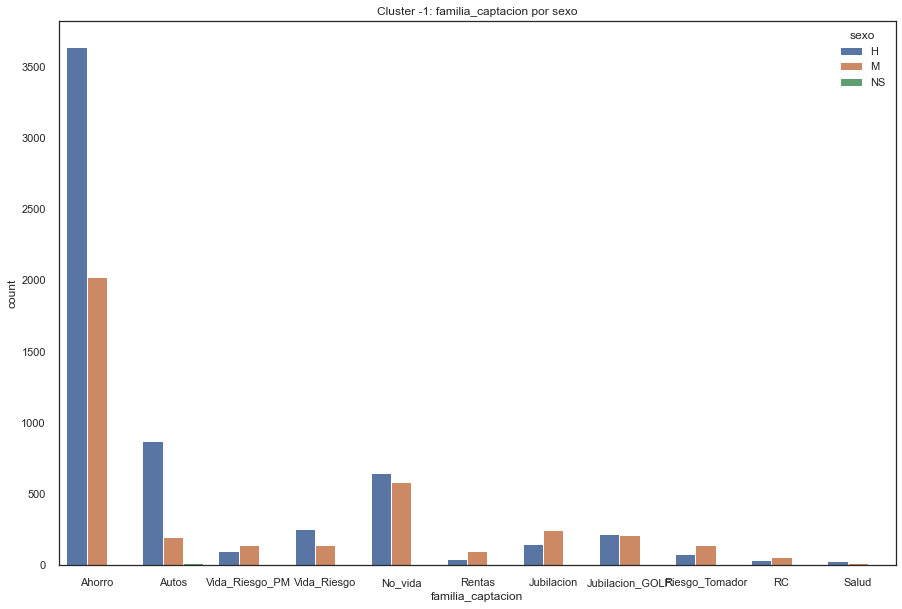

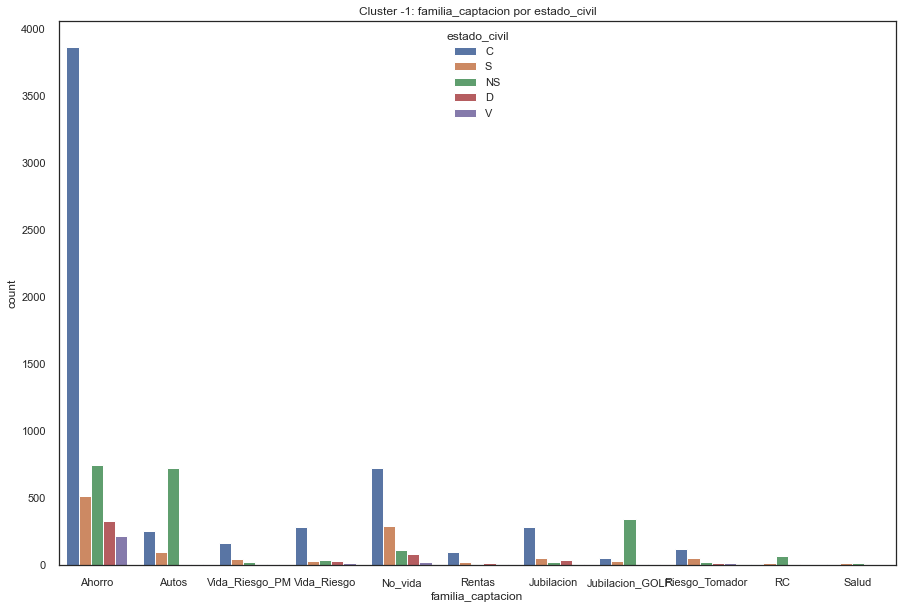

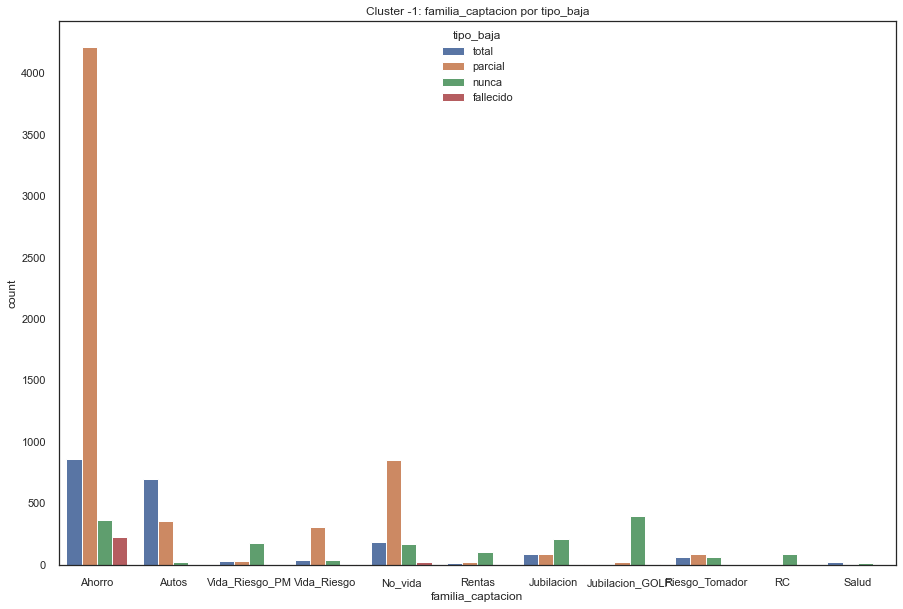

In [171]:
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(data3, -1,'familia_captacion', e)

### Análisis de Cluster de DBScan

A continuación veremos como están distribuidos los clusters de forma gráfica:

    - Cluster 0: Mujer Soltera con una sola póliza contratada, mayoritariamente de No vida, con arraigo por la empresa, pero que si lo deja se va definitivamente.
    
    - Cluster -1: Hombres Casados que contratan principalmente polizas de Ahorro, junto con otros productos, pólizas de No vida y Auto principalmente, y su compromiso con la compañia no es muy arraigado ya que suelen tener bajas parciales, lo que puede indicar que están contentos con la compañía, pero que si reciben alguna oferta de otra compañia en alguno de los productos no dudan en cambiar ese producto específicamente y continúan en la compañía con el resto de productos.
    
    - Cluster 1: Hombres Casados, que contratan pólizas de Auto, con poco arraigo por la empresa.
    
    - Cluster 2: Principalmente Mujer Soltera con dos pólizas contratadas de No vida y Riesgo de vida, y poco arraigo por la empresa, suele causar baja total o parcial en la mayoría de casos.
    
    - Cluster 3: Principalmente Mujeres casadas con una única póliza contratada, principalmente de Ahorro y con mucho arraigo por la compañia.
    
    - Cluster 4: Cliente que no tiene contratado ya ningún producto con la empresa, principalmente Hombres Casados y con bastante arraigo por la empresa.
    
    - Cluster 5: Hombres casados con 3 productos contratados, con poco arraigo con el producto contratado, contrata principalmente pólizas de Ahorro, No vida y Riesgo de vida.
    
    - Cluster 6: Hombre Casado con dos productos contratados con poco arraigo por el producto, contrata principalmente Ahorro y Riesgo de vida
    
    - Cluster 7: Hombre Casado con tres productos contratados (más de un producto del mismo tipo) con poco arraigo por el producto, contrata principalmente Ahorro y Riesgo de vida.
    
    - Cluster 8: Mujer Casada con 2 productos contratados, principalmente Ahorro, Riesgo de vida y No vida, con poco arraigo hacia el producto contratado
    
    

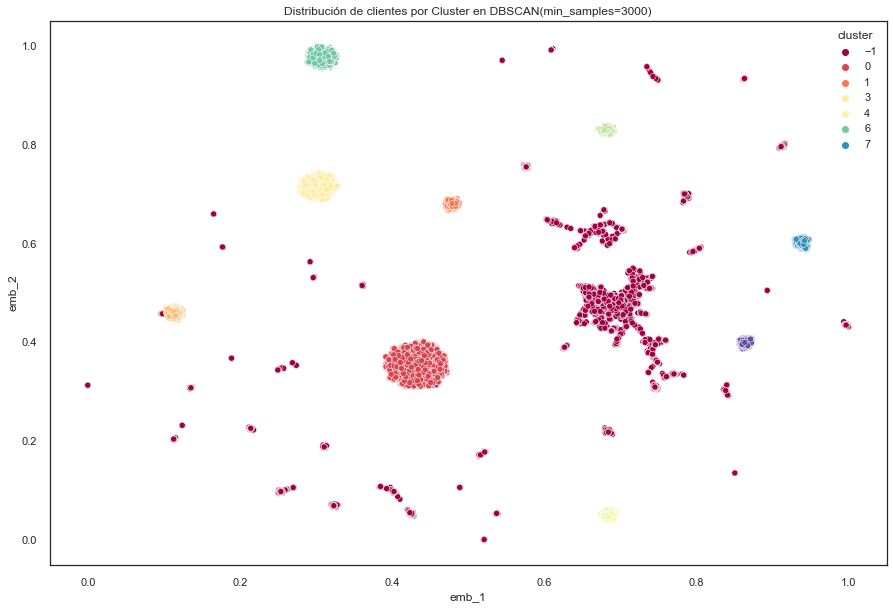

In [175]:
plot_clusters(dbscan_umap_mm_df, dbscan_umap_mm, centroids= False)

Cluster 0

No_vida        7893
Vida_Riesgo     138
Name: familia_captacion, dtype: int64 



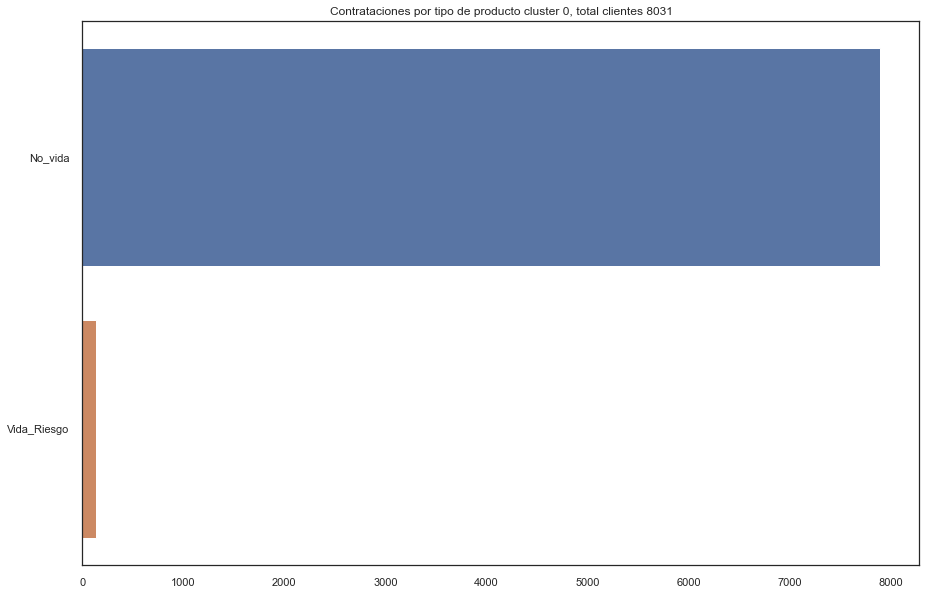

1    8031
Name: total_productos, dtype: int64 



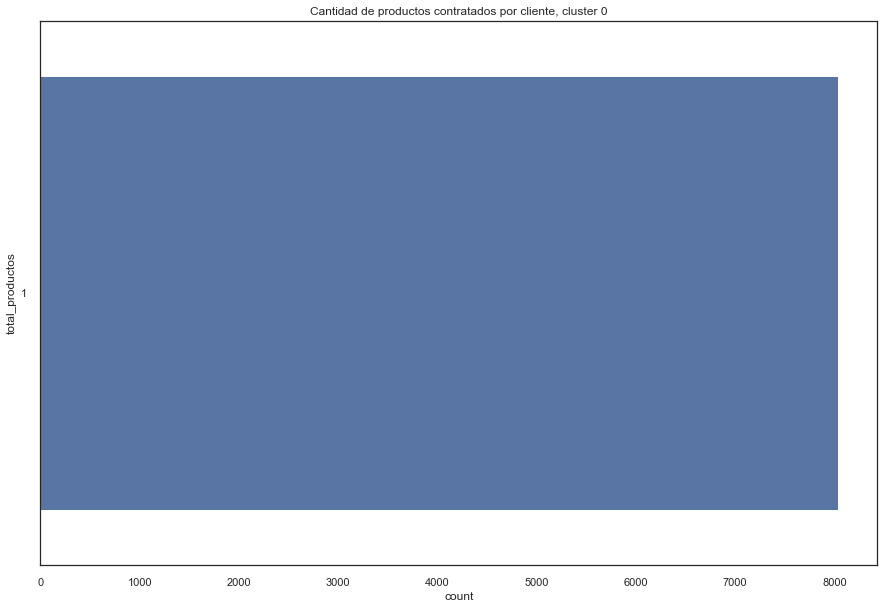

M    5045
H    2986
Name: sexo, dtype: int64 



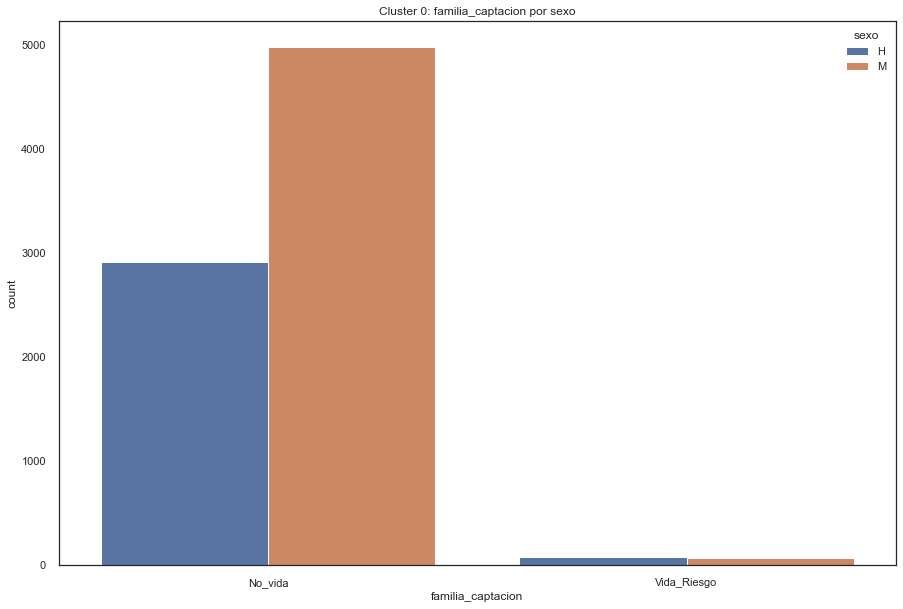

S     3869
C     2899
NS    1072
D      160
V       31
Name: estado_civil, dtype: int64 



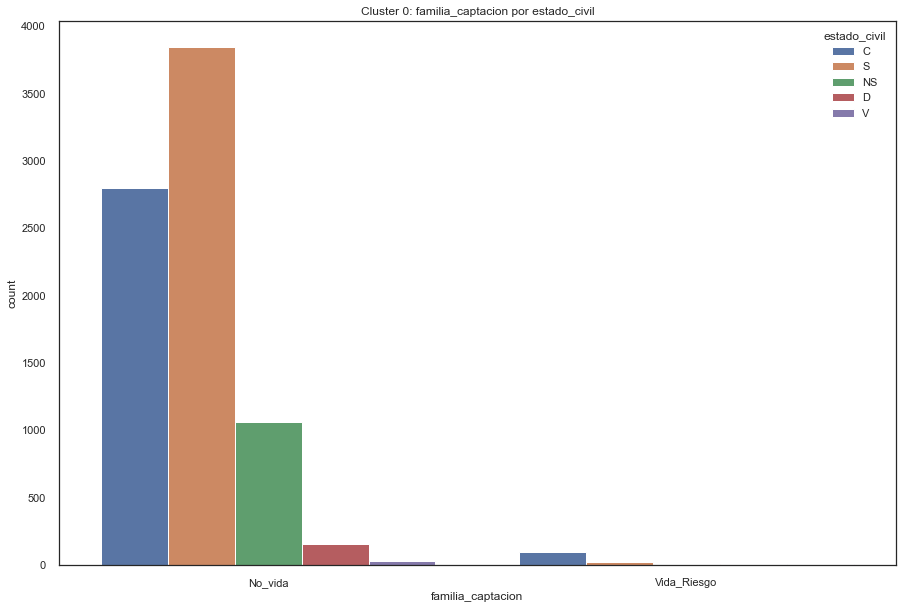

total        3961
nunca        3906
parcial       154
fallecido      10
Name: tipo_baja, dtype: int64 



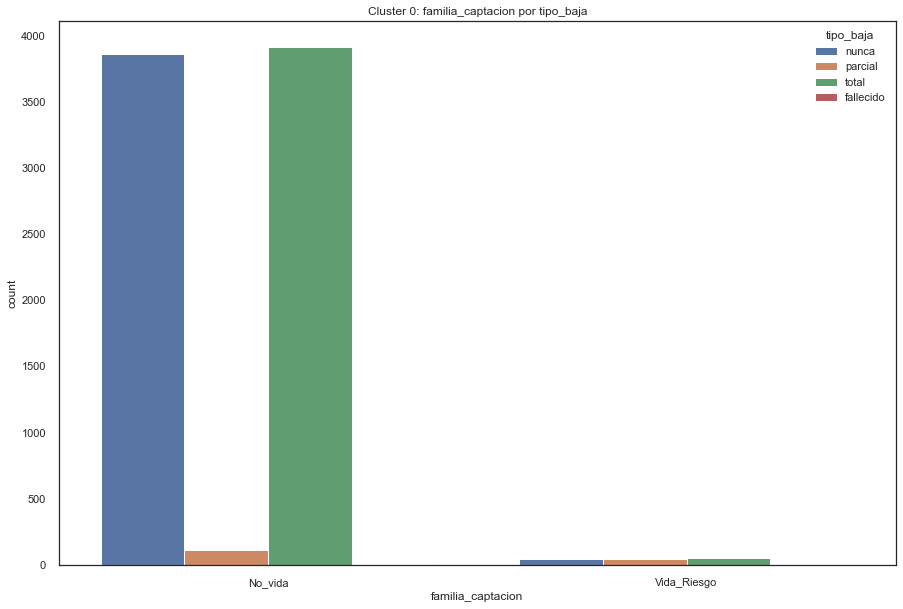

Siguiente cluster


Cluster -1

Ahorro             5668
No_vida            1229
Autos              1074
Jubilacion_GOLF     429
Vida_Riesgo         390
Jubilacion          389
Vida_Riesgo_PM      231
Riesgo_Tomador      212
Rentas              139
RC                   89
Salud                34
Name: familia_captacion, dtype: int64 



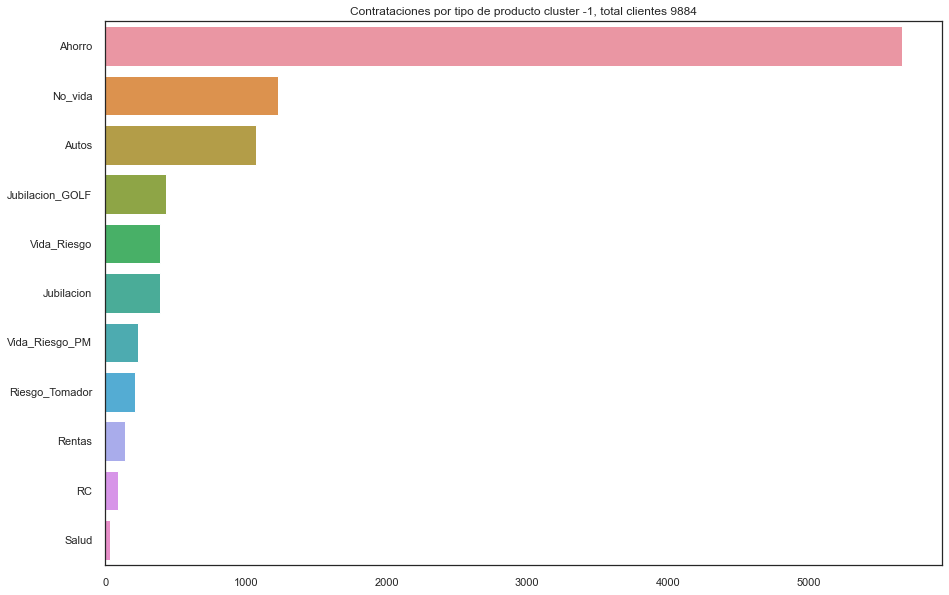

4     2028
2     1603
3     1509
5     1214
1     1211
6      707
7      465
8      294
9      227
0      167
10     137
11      84
12      80
13      37
14      36
15      29
16      15
17      12
19       8
20       6
18       4
31       2
21       2
25       1
23       1
36       1
26       1
24       1
29       1
22       1
Name: total_productos, dtype: int64 



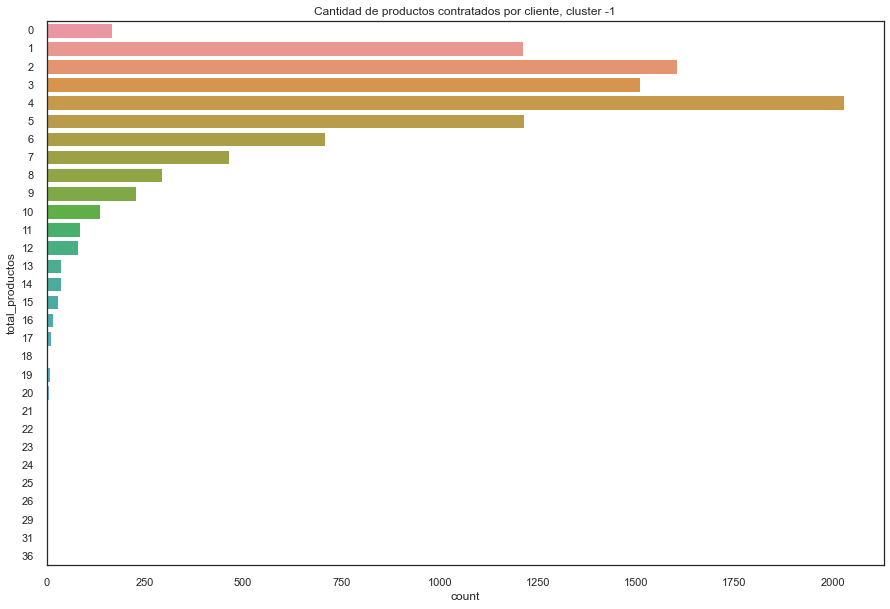

H     6035
M     3836
NS      13
Name: sexo, dtype: int64 



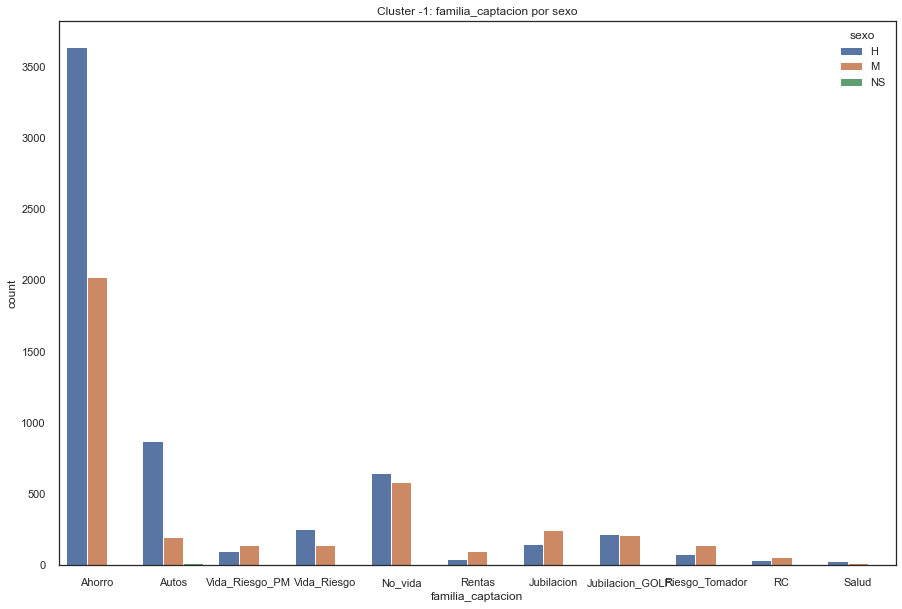

C     5853
NS    2093
S     1145
D      509
V      284
Name: estado_civil, dtype: int64 



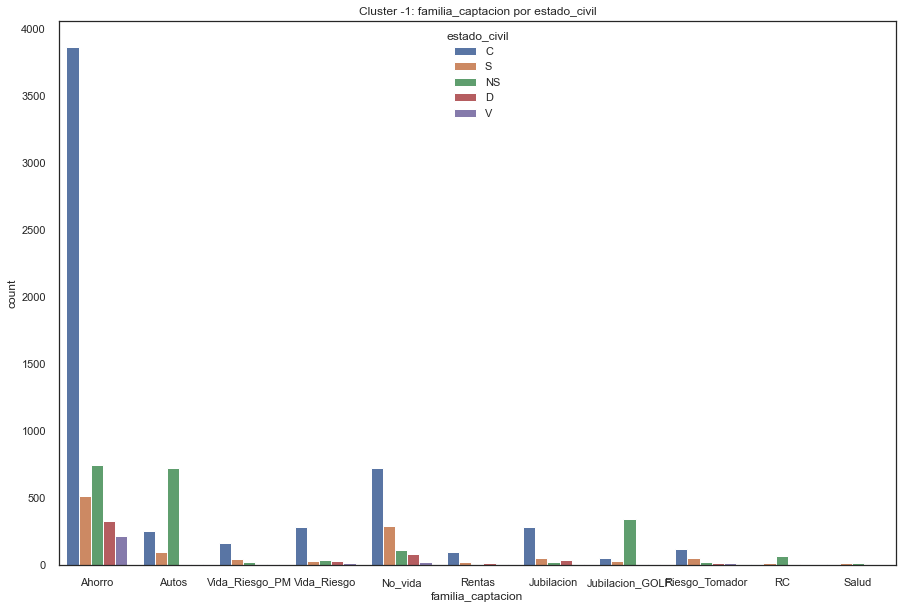

parcial      5983
total        1999
nunca        1635
fallecido     267
Name: tipo_baja, dtype: int64 



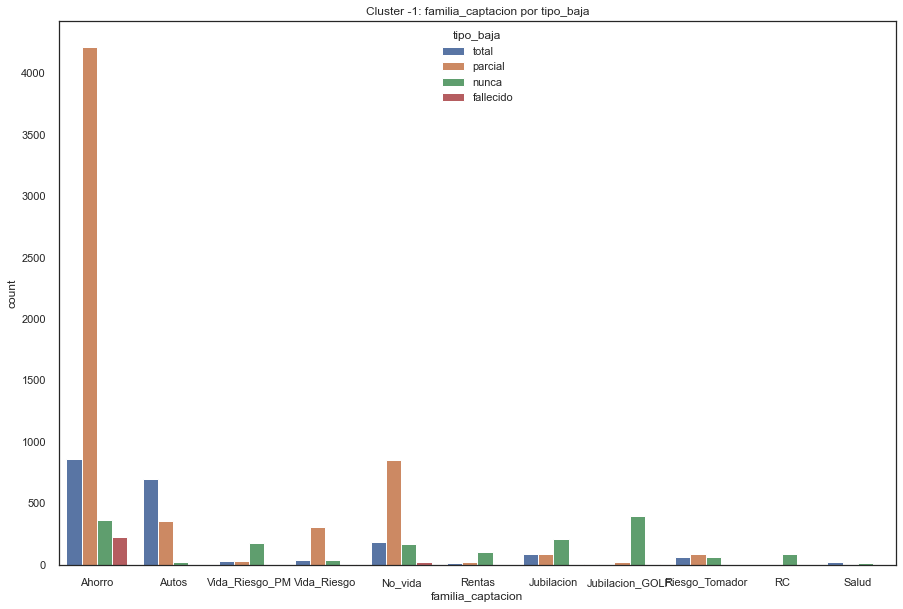

Siguiente cluster


Cluster 1

Autos          880
Vida_Riesgo      1
Name: familia_captacion, dtype: int64 



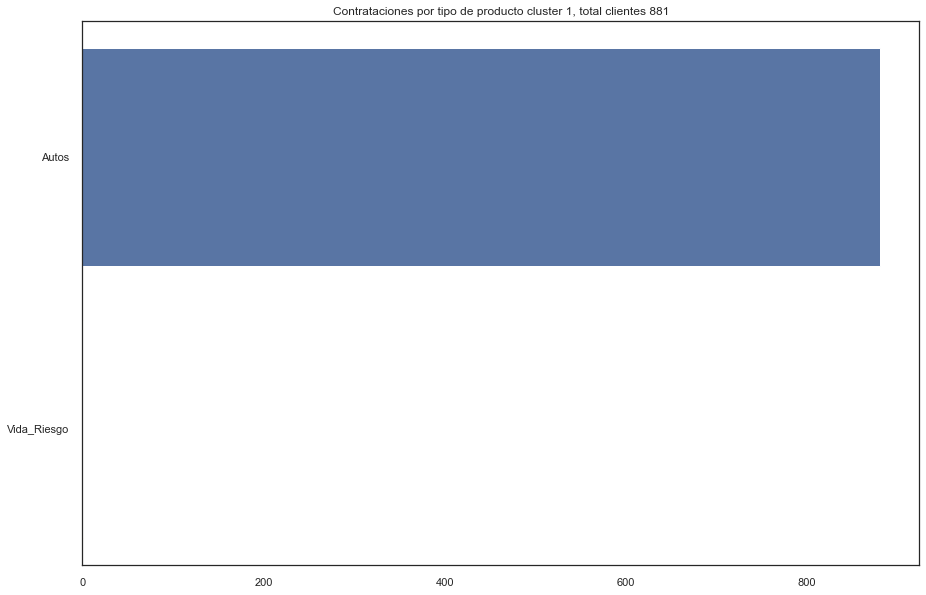

1    881
Name: total_productos, dtype: int64 



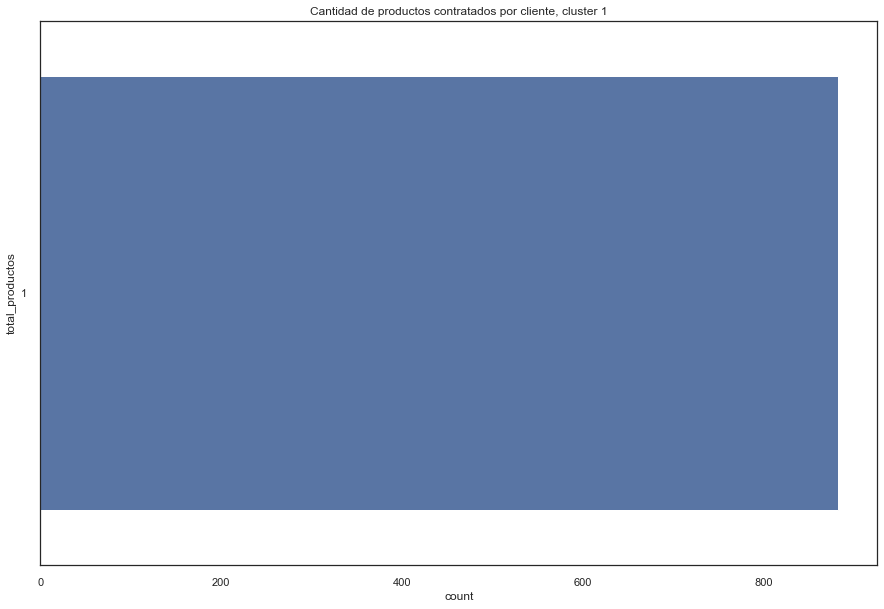

H     646
M     232
NS      3
Name: sexo, dtype: int64 



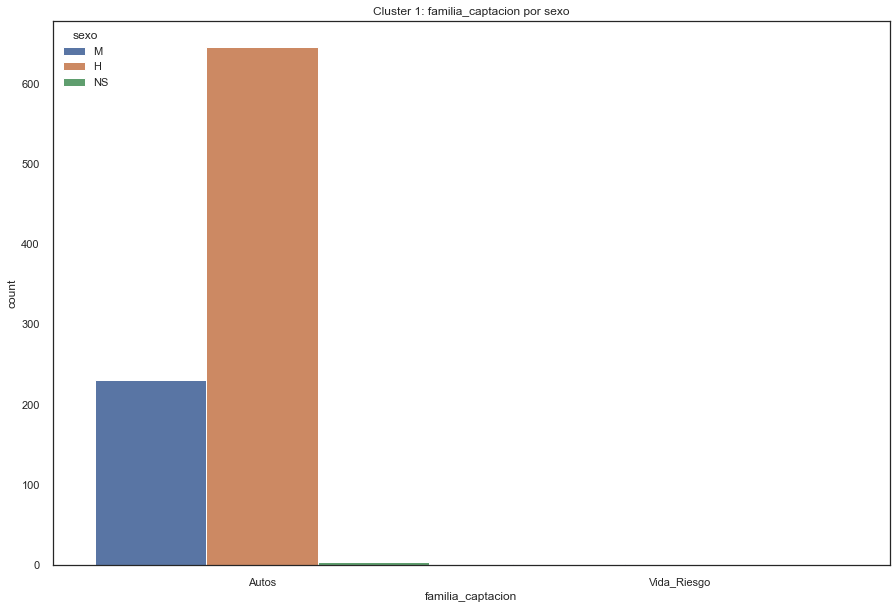

NS    406
C     282
S     166
D      21
V       6
Name: estado_civil, dtype: int64 



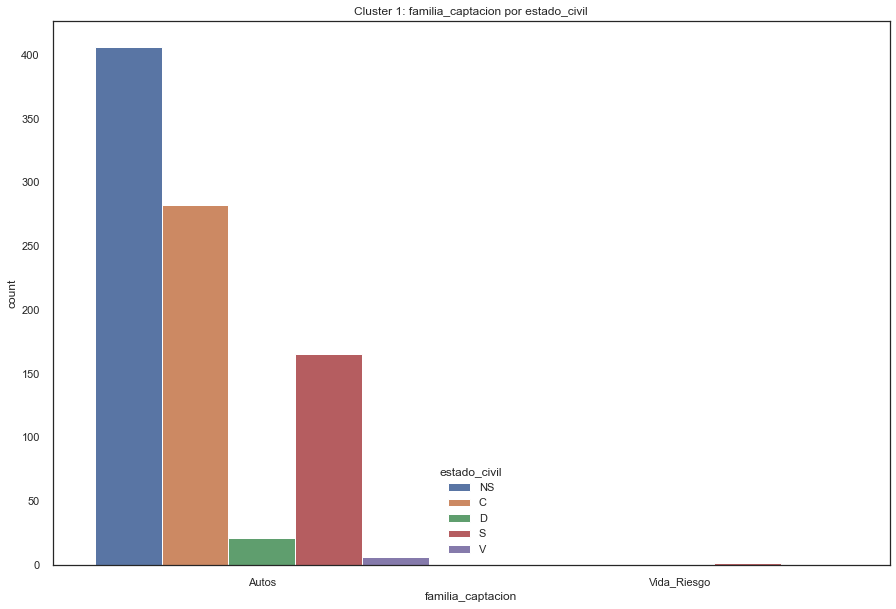

total      764
nunca      115
parcial      2
Name: tipo_baja, dtype: int64 



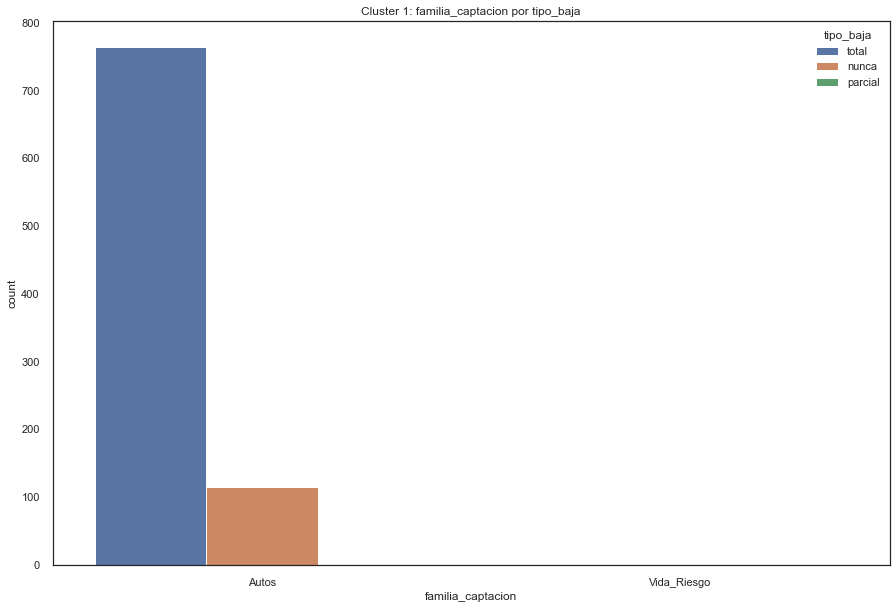

Siguiente cluster


Cluster 2

No_vida        1243
Vida_Riesgo      16
Name: familia_captacion, dtype: int64 



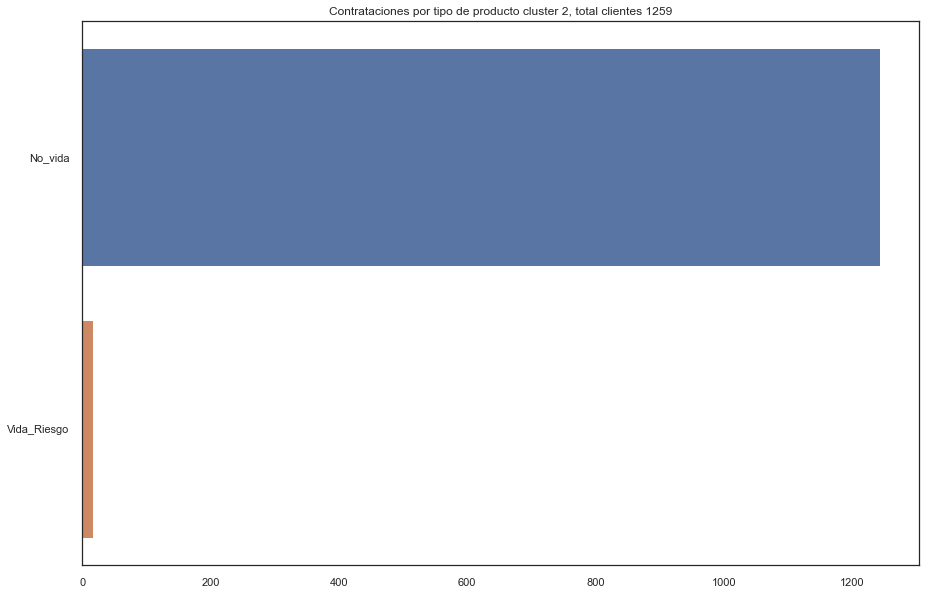

2    1259
Name: total_productos, dtype: int64 



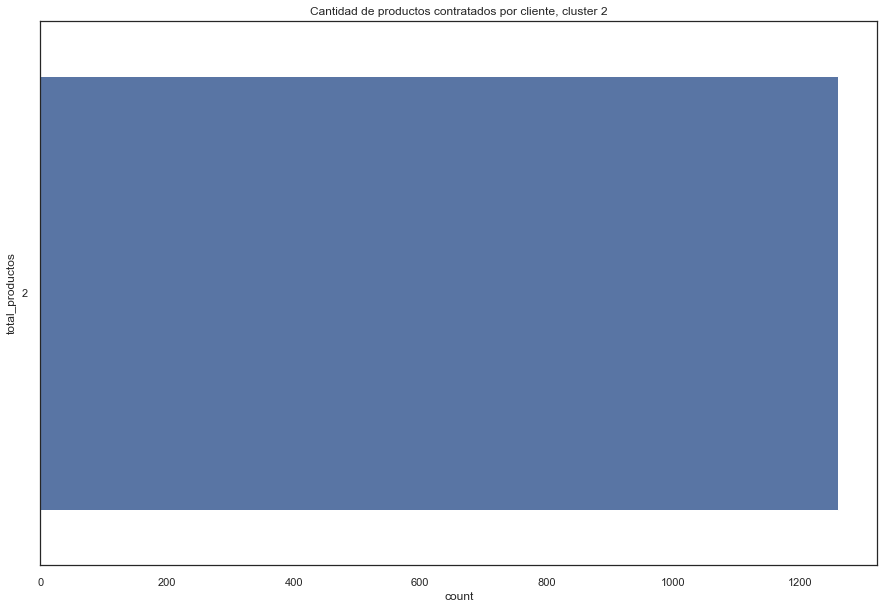

M    801
H    458
Name: sexo, dtype: int64 



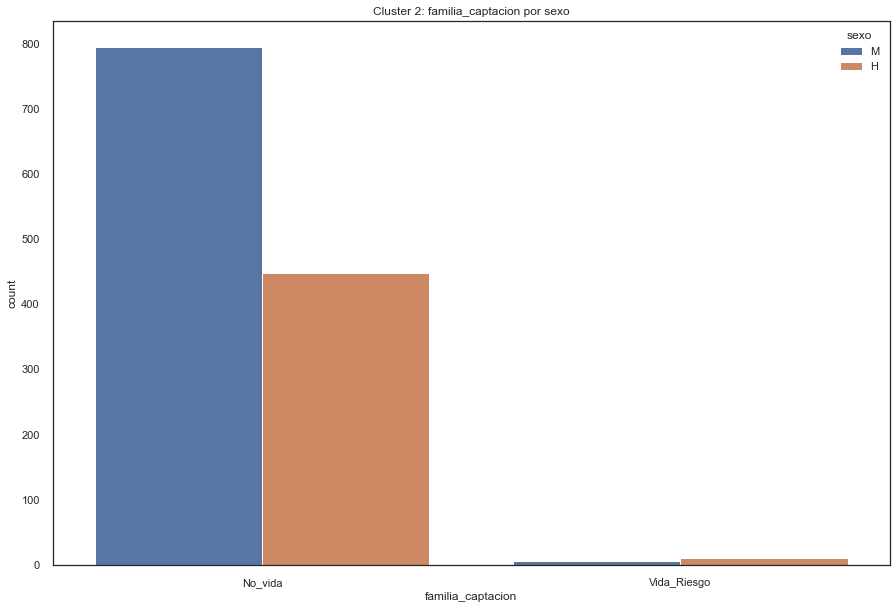

S     627
C     505
NS     78
D      38
V      11
Name: estado_civil, dtype: int64 



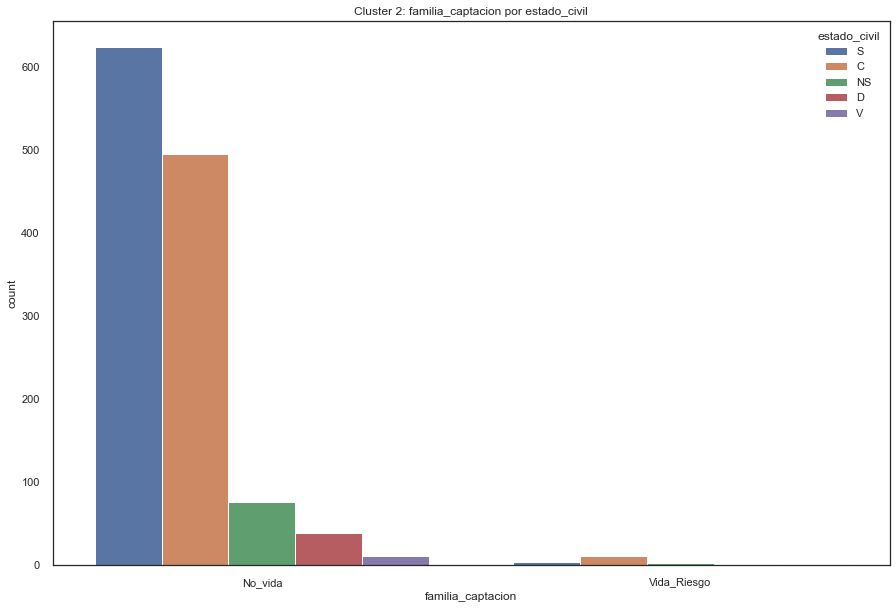

parcial      657
total        502
nunca         99
fallecido      1
Name: tipo_baja, dtype: int64 



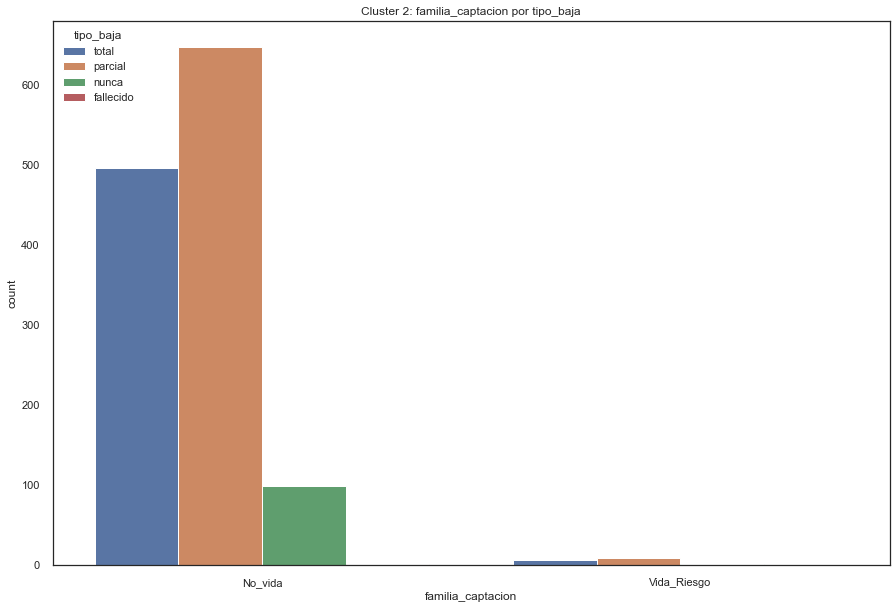

Siguiente cluster


Cluster 3

Ahorro         3410
Vida_Riesgo     132
Name: familia_captacion, dtype: int64 



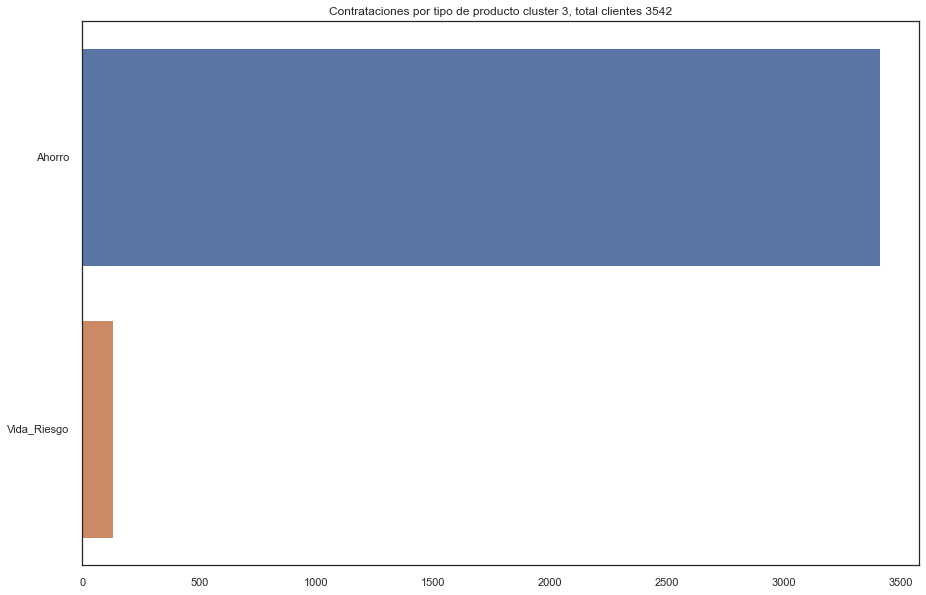

1    3542
Name: total_productos, dtype: int64 



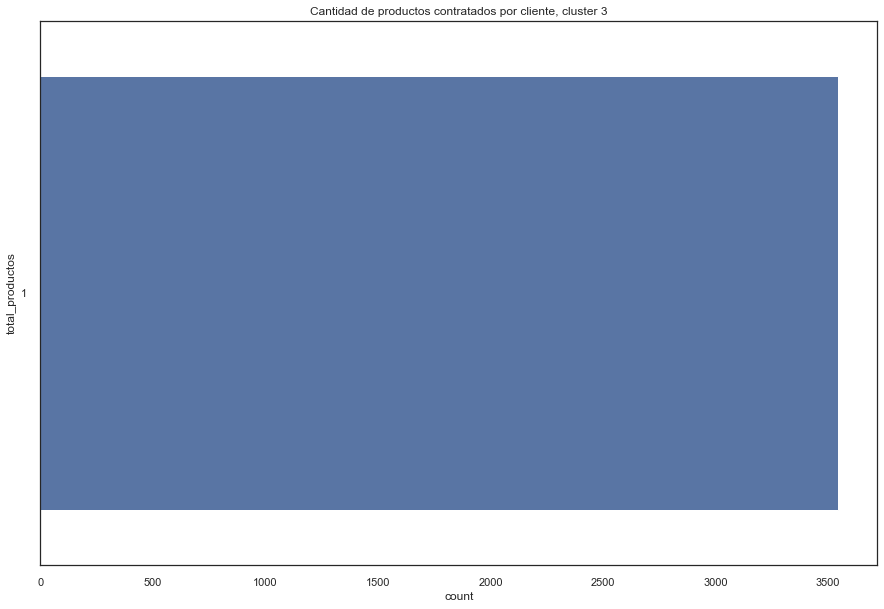

M     1877
H     1653
NS      12
Name: sexo, dtype: int64 



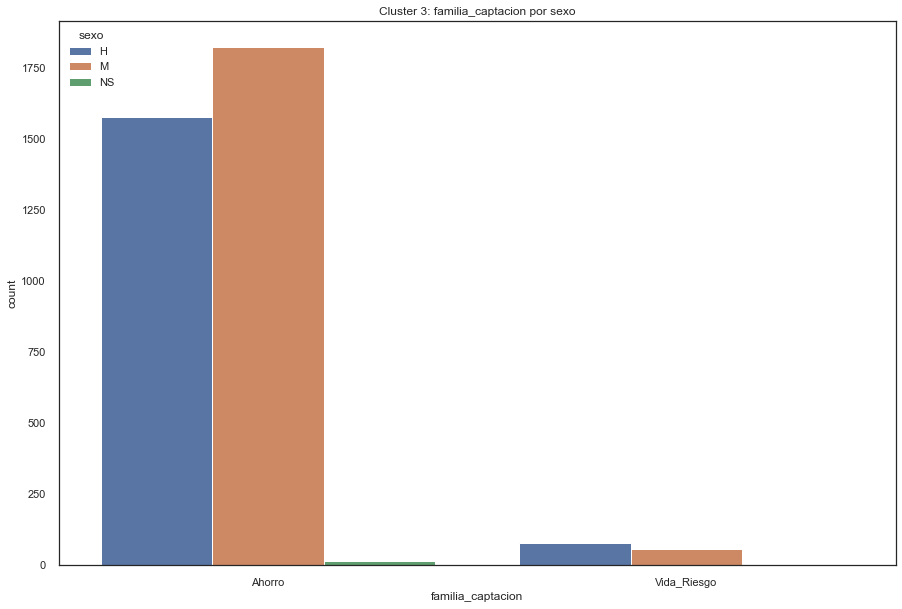

NS    1548
C     1450
S      423
D       73
V       48
Name: estado_civil, dtype: int64 



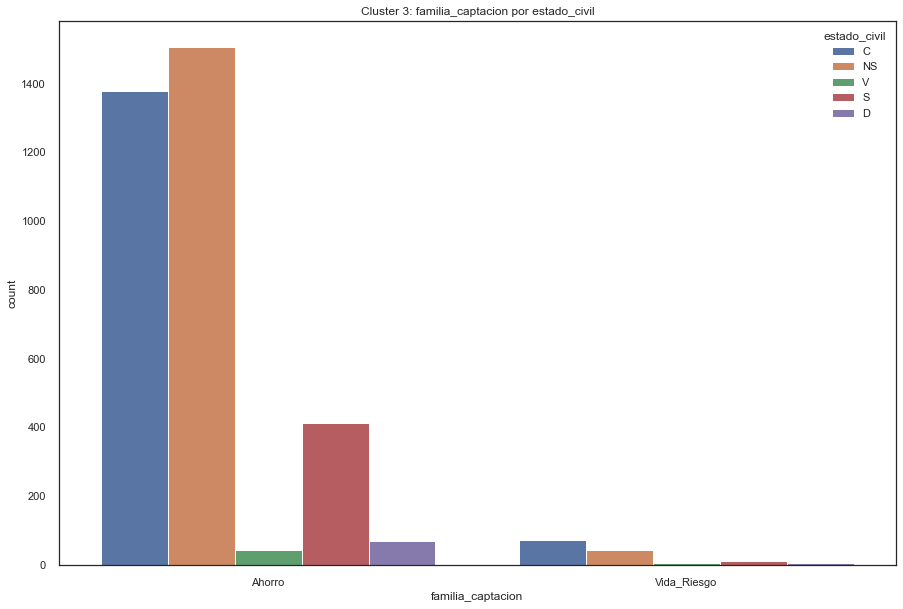

nunca        2496
total         774
parcial       202
fallecido      70
Name: tipo_baja, dtype: int64 



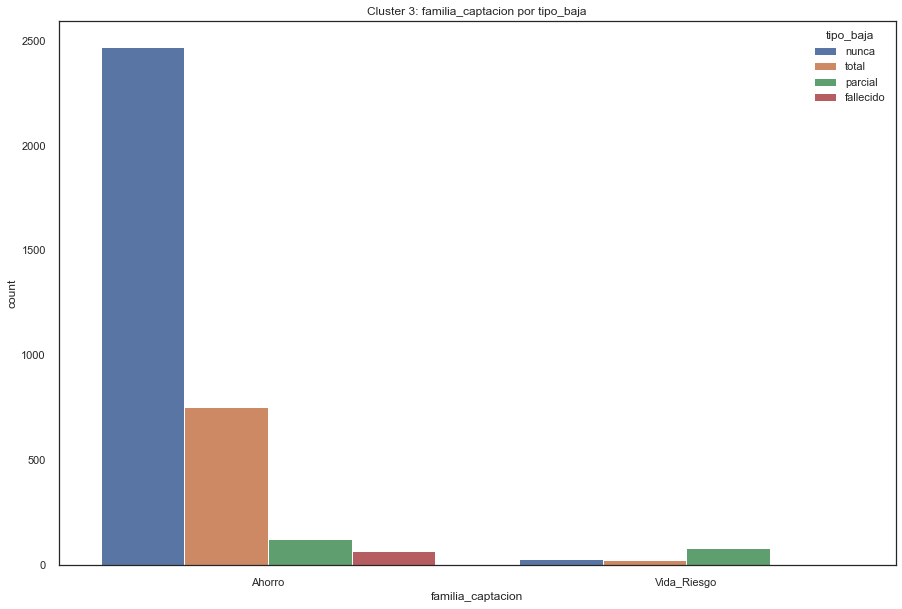

Siguiente cluster


Cluster 4

Vida_Riesgo    1081
Name: familia_captacion, dtype: int64 



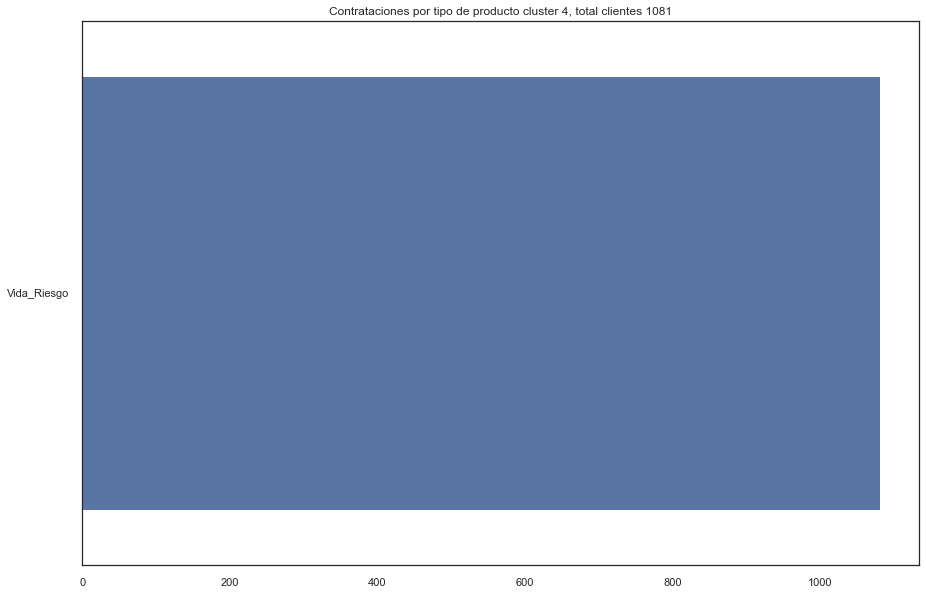

0    1081
Name: total_productos, dtype: int64 



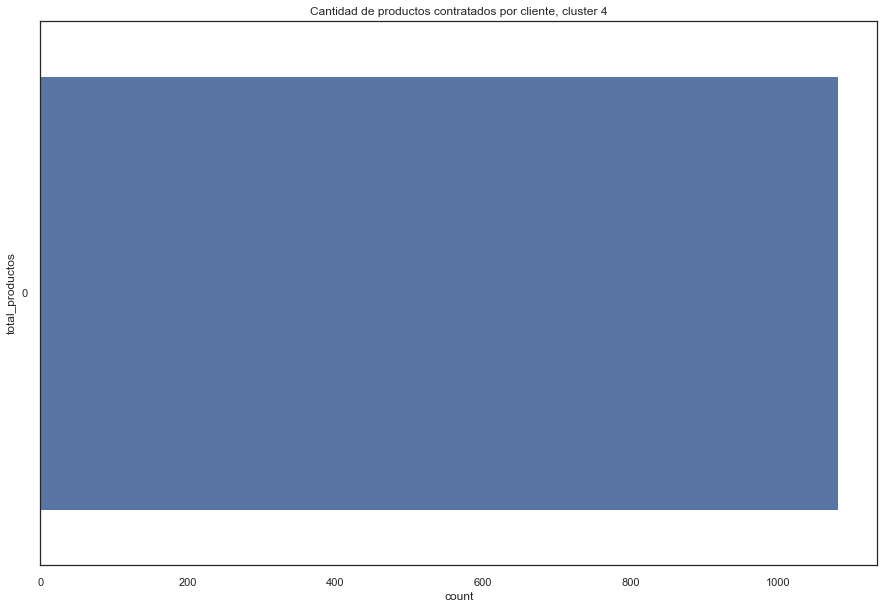

M    592
H    489
Name: sexo, dtype: int64 



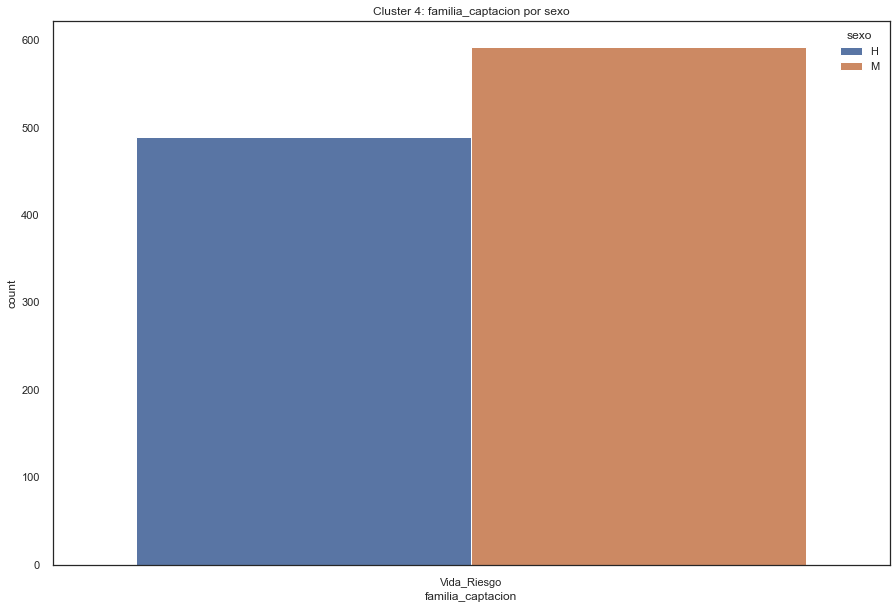

C     636
NS    230
S     154
D      47
V      14
Name: estado_civil, dtype: int64 



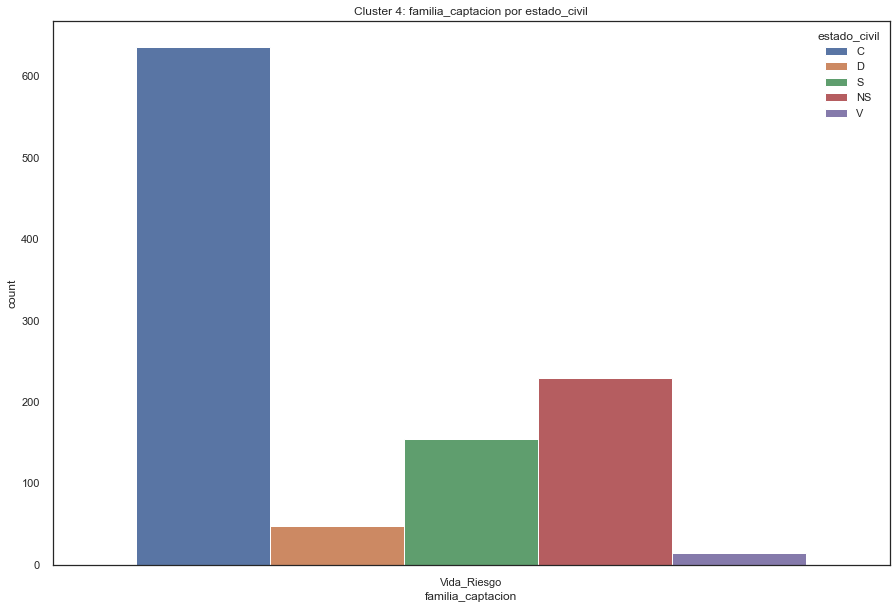

nunca        648
total        336
parcial       92
fallecido      5
Name: tipo_baja, dtype: int64 



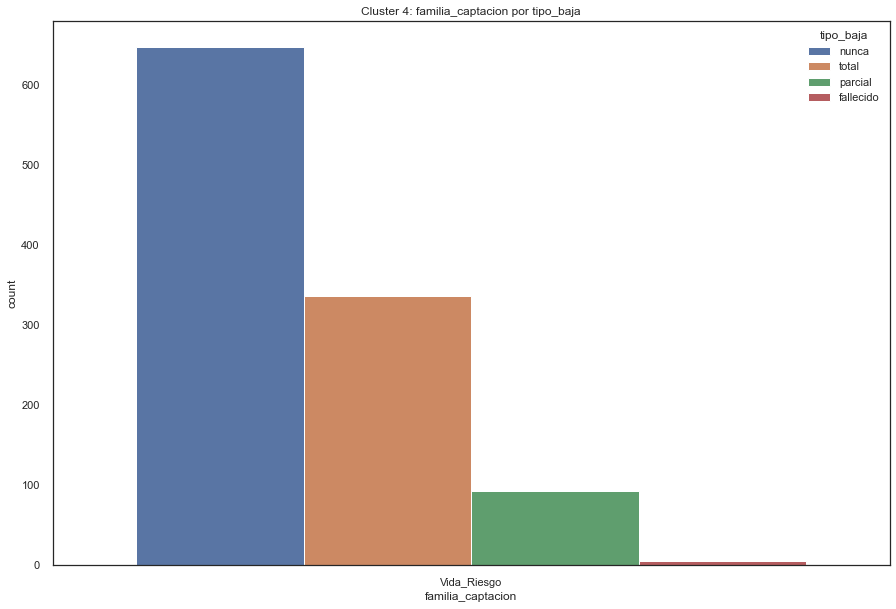

Siguiente cluster


Cluster 5

Ahorro         624
No_vida        165
Vida_Riesgo     31
Name: familia_captacion, dtype: int64 



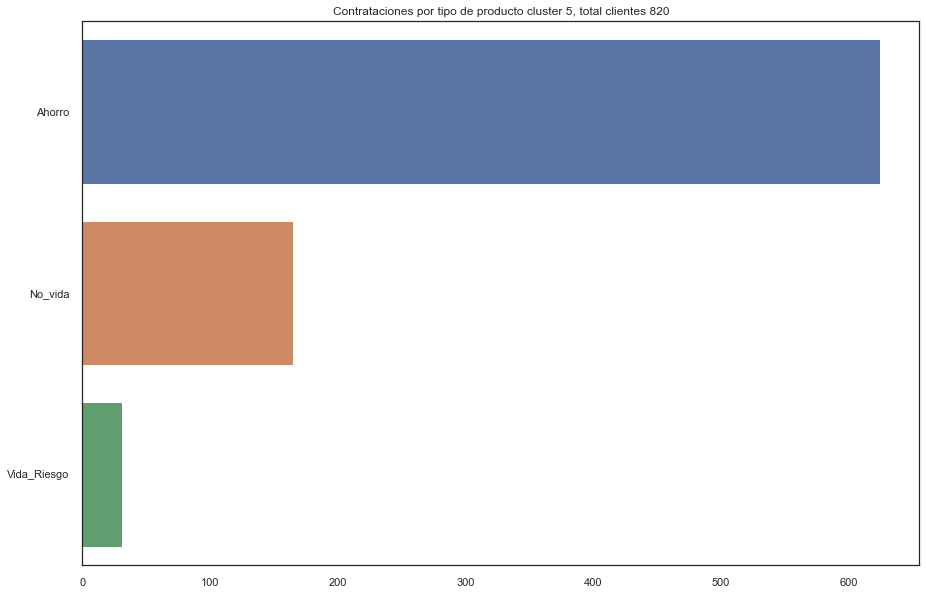

3    820
Name: total_productos, dtype: int64 



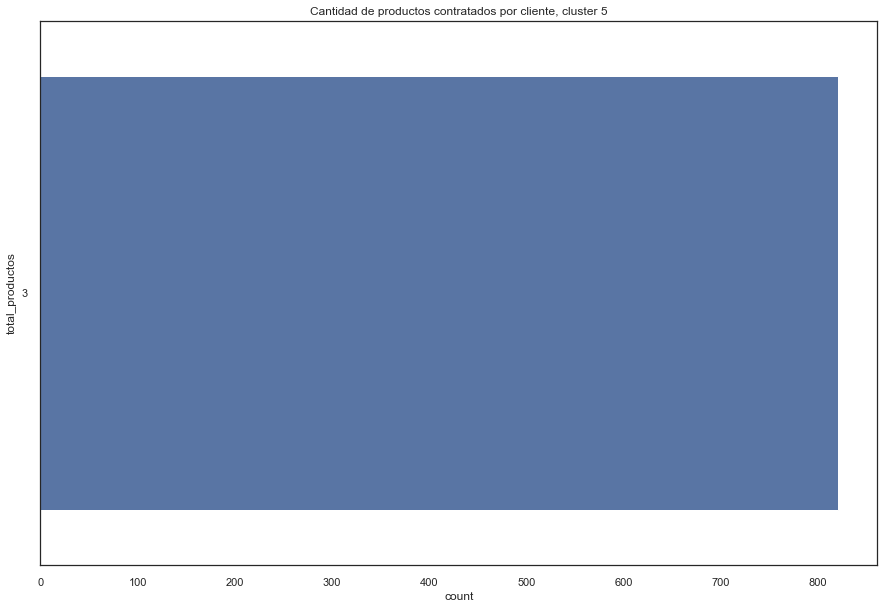

H    564
M    256
Name: sexo, dtype: int64 



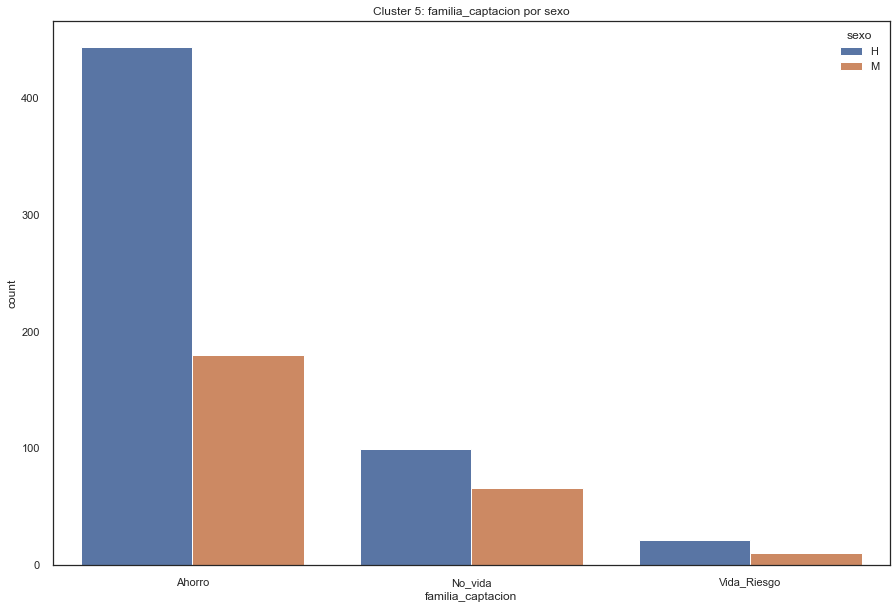

NS    370
C     333
S      74
D      30
V      13
Name: estado_civil, dtype: int64 



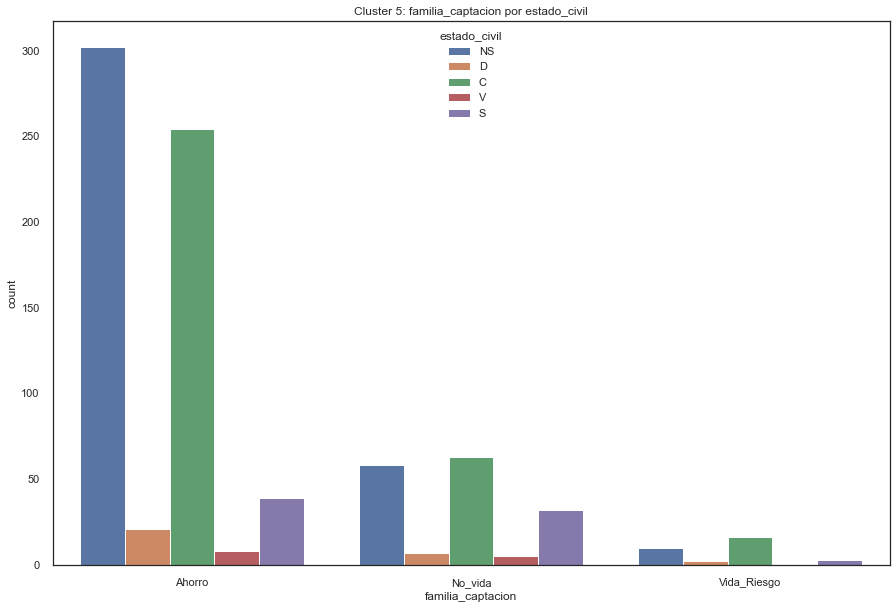

parcial      470
total        233
fallecido     73
nunca         44
Name: tipo_baja, dtype: int64 



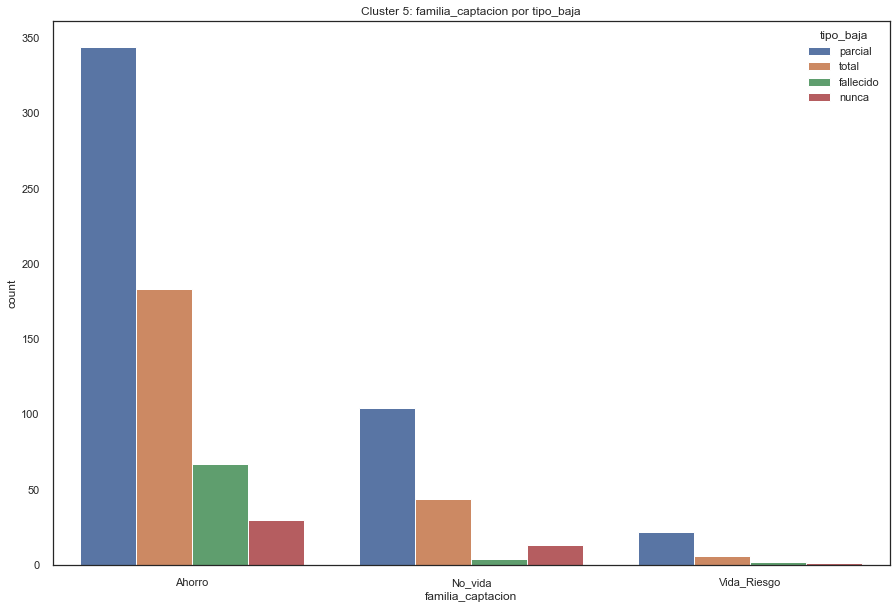

Siguiente cluster


Cluster 6

Ahorro         2408
Vida_Riesgo      83
Name: familia_captacion, dtype: int64 



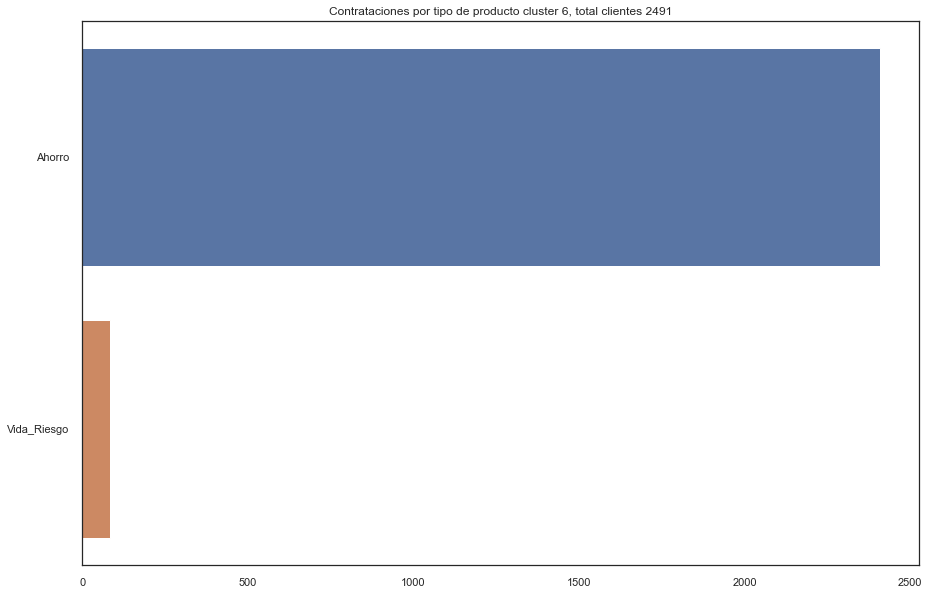

2    2491
Name: total_productos, dtype: int64 



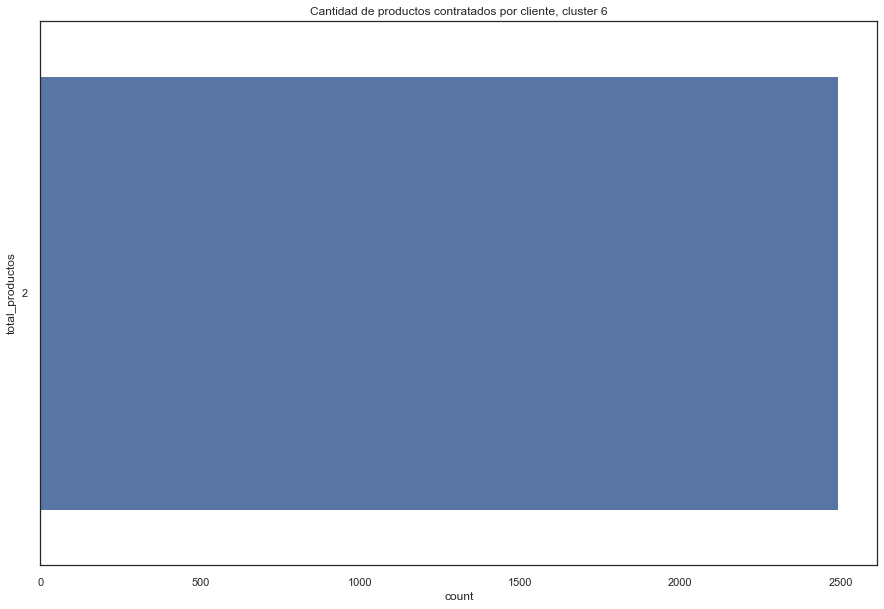

H     1494
M      996
NS       1
Name: sexo, dtype: int64 



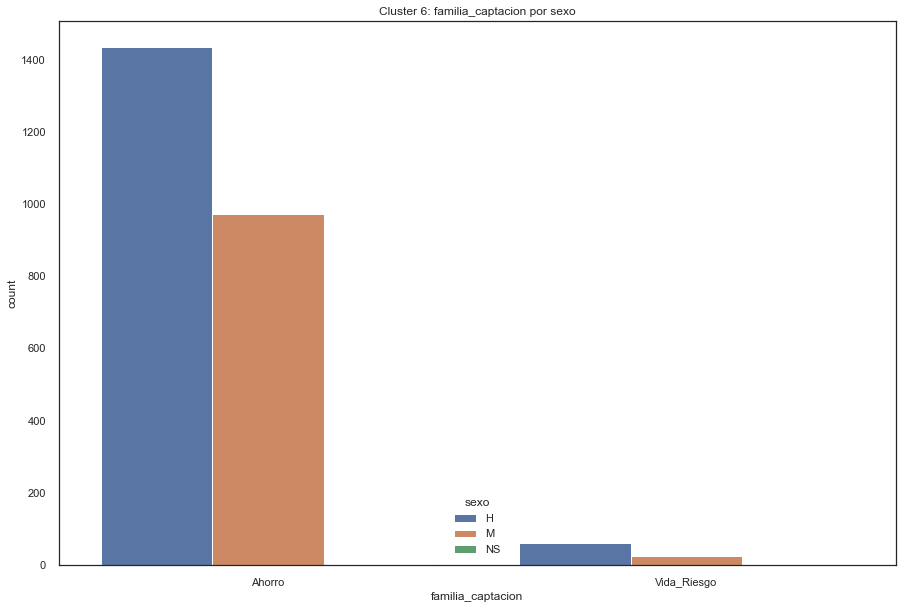

NS    1300
C      932
S      144
D       74
V       41
Name: estado_civil, dtype: int64 



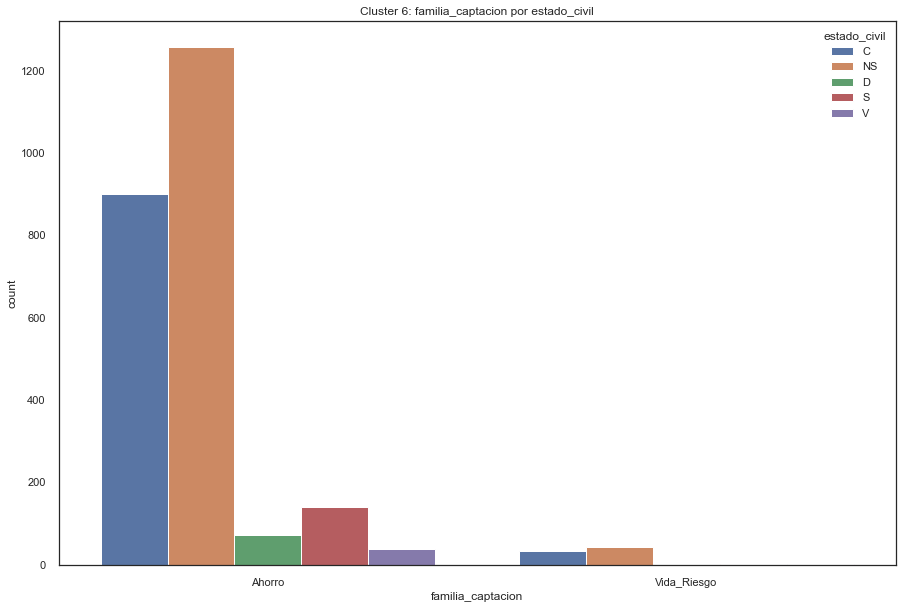

parcial      1001
total         891
nunca         468
fallecido     131
Name: tipo_baja, dtype: int64 



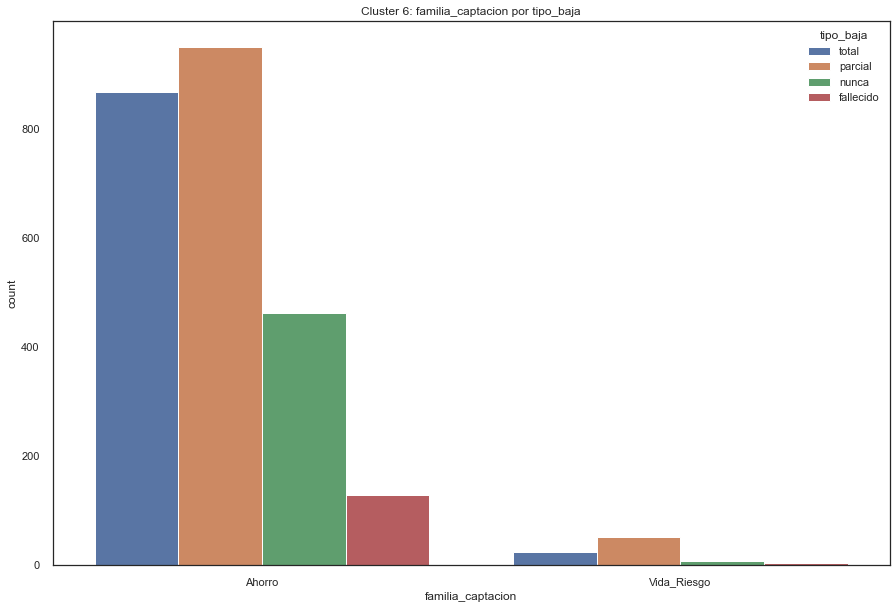

Siguiente cluster


Cluster 7

Ahorro         1008
Vida_Riesgo      31
Name: familia_captacion, dtype: int64 



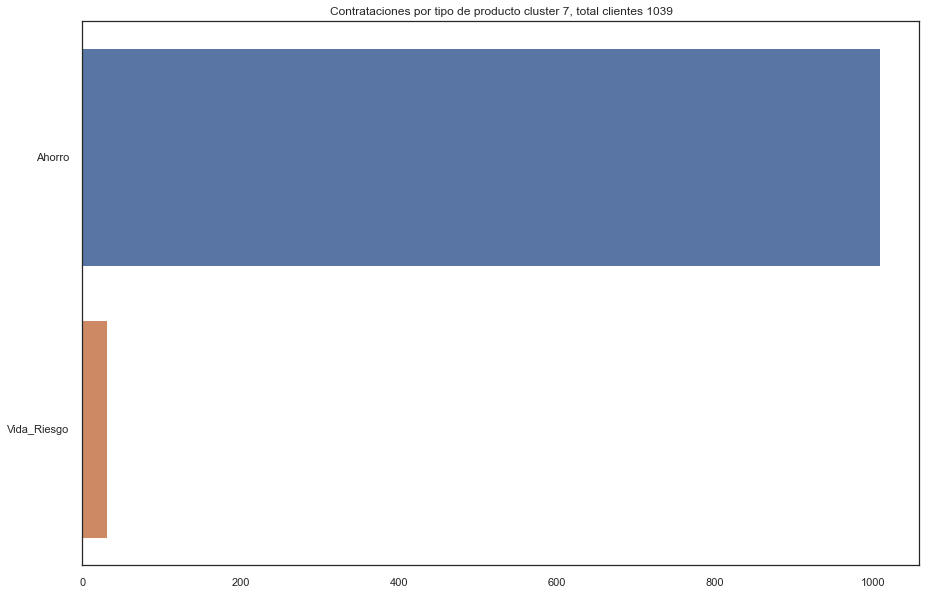

3    1039
Name: total_productos, dtype: int64 



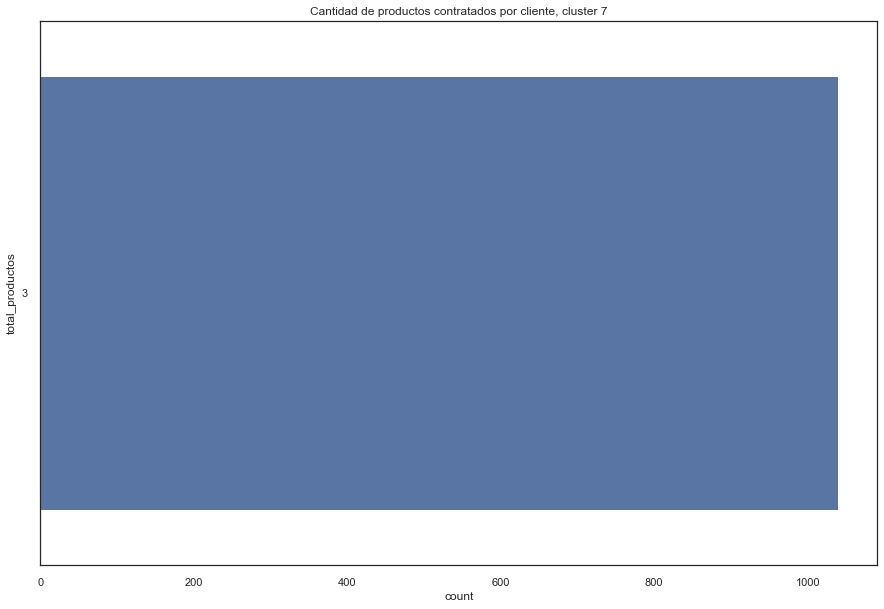

H    630
M    409
Name: sexo, dtype: int64 



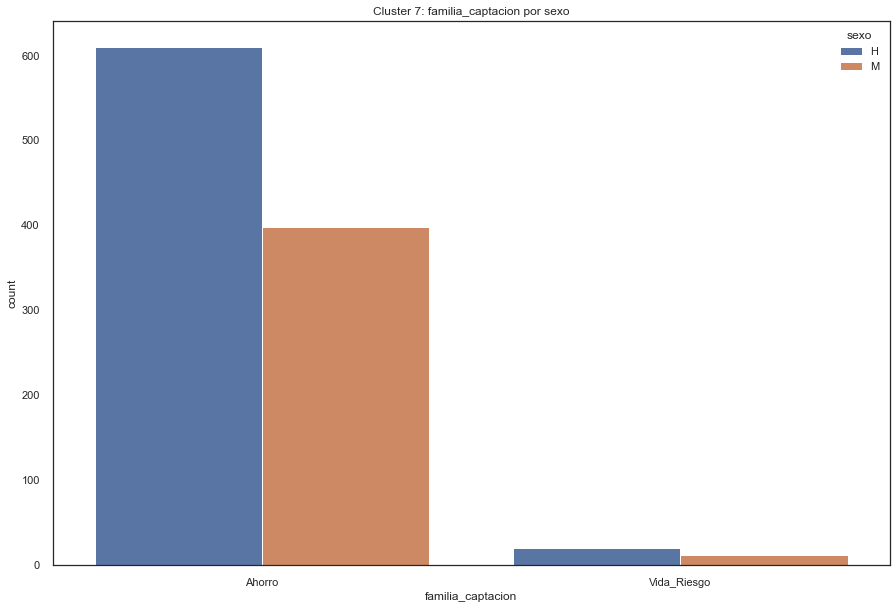

C     547
NS    323
S      92
D      48
V      29
Name: estado_civil, dtype: int64 



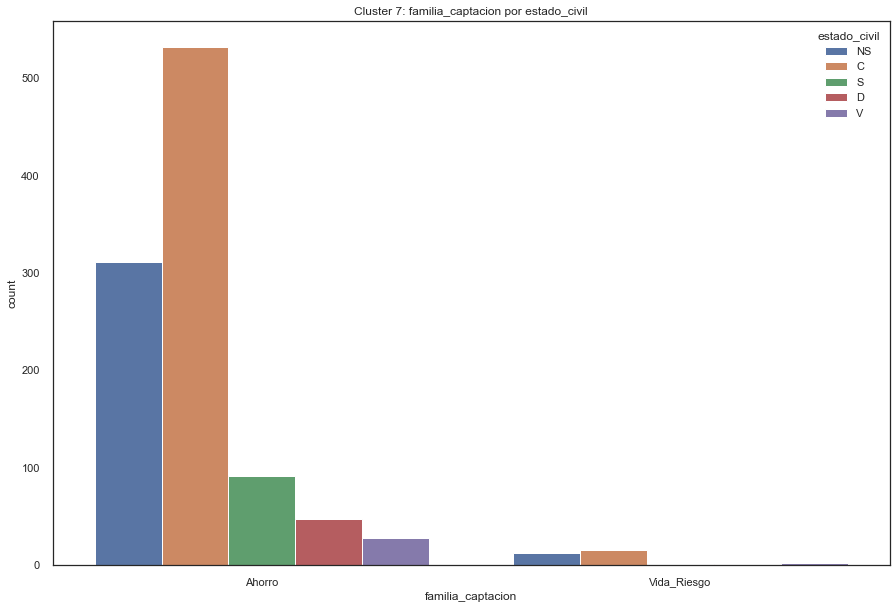

parcial      566
total        352
nunca         67
fallecido     54
Name: tipo_baja, dtype: int64 



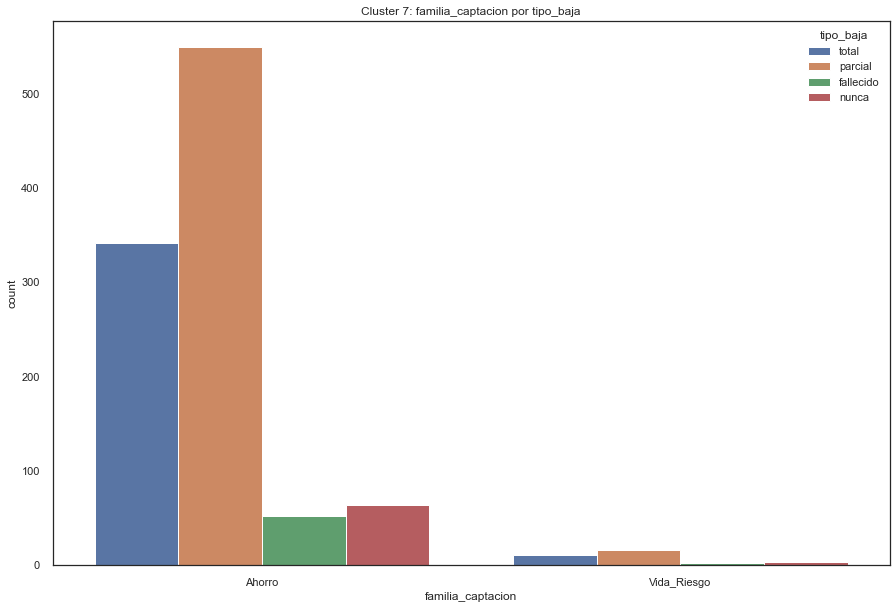

Siguiente cluster


Cluster 8

No_vida        467
Ahorro         462
Vida_Riesgo     43
Name: familia_captacion, dtype: int64 



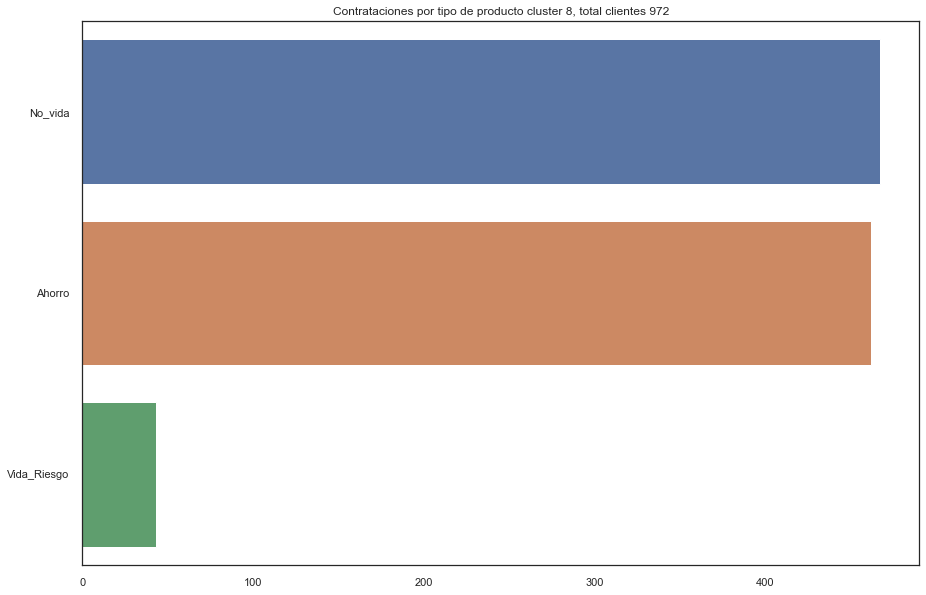

2    972
Name: total_productos, dtype: int64 



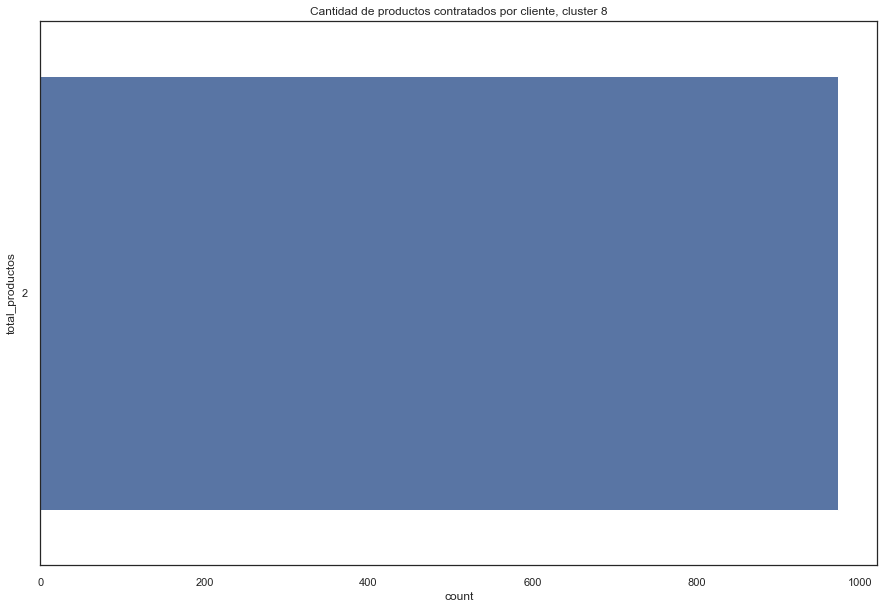

M    503
H    469
Name: sexo, dtype: int64 



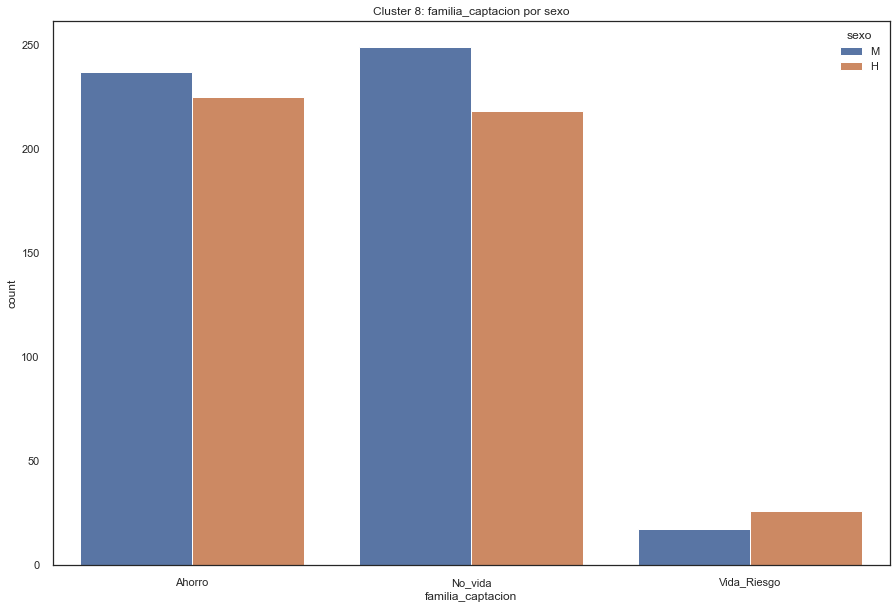

C     536
S     215
NS    157
D      53
V      11
Name: estado_civil, dtype: int64 



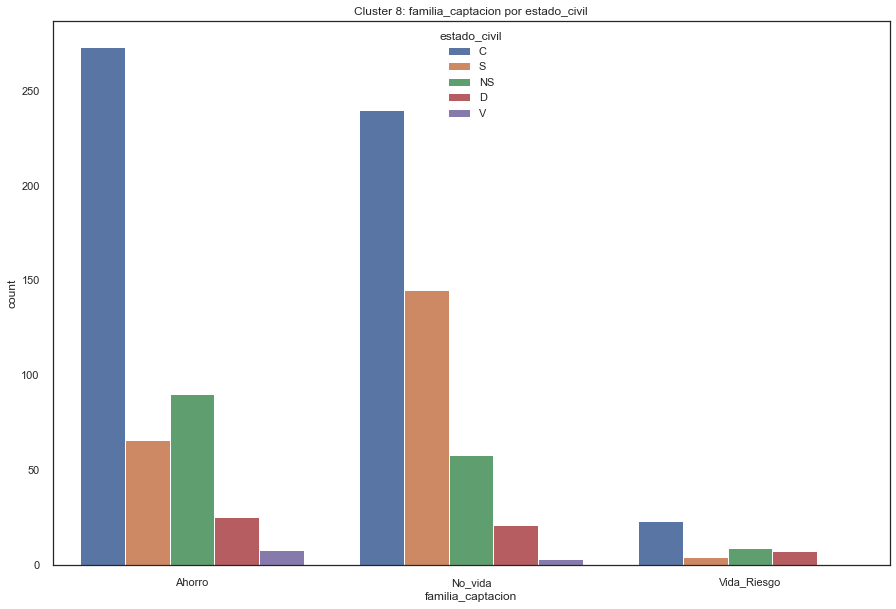

parcial      481
total        263
nunca        215
fallecido     13
Name: tipo_baja, dtype: int64 



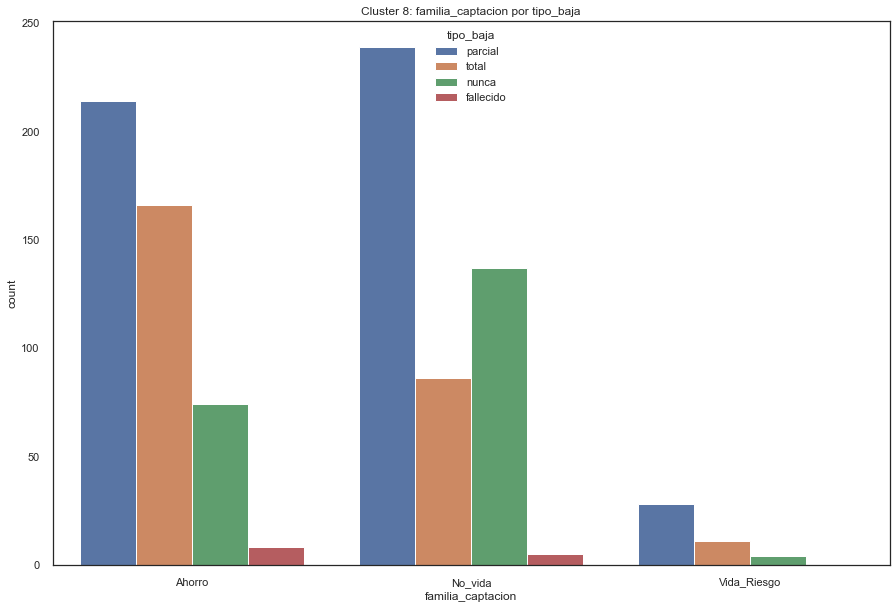

Siguiente cluster




In [176]:
for i in data3.cluster.unique():
    print(f'Cluster {i}\n')
    print(data3[data3.cluster==i].familia_captacion.value_counts(),'\n')
    plot_productos_x_cluster(data3, i)
    print(data3[data3.cluster==i].total_productos.value_counts(),'\n')
    plot_total_productos_x_cluster(data3, i)
    
    for e in ['sexo', 'estado_civil', 'tipo_baja']:
        print(data3[data3.cluster==i][e].value_counts(),'\n')
        countplot_cluster(data3, i,'familia_captacion', e)
        plt.show();
    
    print('Siguiente cluster\n\n')

## Guardar Resultados

Vamos a salvar los resultados de los embbedings de umap y la clasificación de los clusters de cada modelo por si quisieramos trabajar con ellos en herramientas externas, como Power BI o Tableau

In [177]:
#data2.to_csv('results/results_kmeans_umap.csv', index=False)

In [178]:
#data3.to_csv('results/results_dbscan_umap.csv', index=False)

## Opción con Ahorro y No vida, separado del resto de productos

### EDA Productos Grupo 1 y Grupo 2

Como podemos observar el grueso de nuestros clientes se centra en estos dos tipos de productos las pólizas de Ahorro y de No vida, por lo que vamos a realizar un filtro en base a estas dos categorias para un grupo y el resto para otro.

In [135]:
id_ = df.id_cliente
X = df.drop(['id_cliente','n_polizas_tomador_no_vida.1'], axis=1)
X['total_productos'] = [sum(r.values) for i,r in X.iterrows()]
X['id_cliente'] = id_

In [136]:
porcentaje_clientes_Ahorro_no_vida = (X[(X.n_polizas_tomador_ahorro>=1) | (X.n_polizas_tomador_no_vida>=1)].shape[0]/X.shape[0])*100
porcentaje_clientes_Ahorro_no_vida

85.96000000000001

In [137]:
X[(X.n_polizas_tomador_ahorro>=1) | (X.n_polizas_tomador_no_vida>=1)].shape, X[(X.n_polizas_tomador_ahorro==0) & (X.n_polizas_tomador_no_vida== 0)].shape

((25788, 12), (4212, 12))

In [138]:
g1 = X[(X.n_polizas_tomador_ahorro>=1) | (X.n_polizas_tomador_no_vida>=1)]
g2 = X[(X.n_polizas_tomador_ahorro==0) & (X.n_polizas_tomador_no_vida== 0)]

In [139]:
g1.head()

n_polizas_tomador_ahorro  n_polizas_tomador_autos  \
0                         0                        0   
1                         0                        0   
2                         5                        0   
3                         0                        0   
4                         0                        0   

   n_polizas_tomador_jubilacion  n_polizas_tomador_jubilacion_golf  \
0                             0                                  0   
1                             0                                  0   
2                             0                                  0   
3                             0                                  0   
4                             0                                  0   

   n_polizas_tomador_no_vida  n_polizas_tomador_rc  n_polizas_tomador_rentas  \
0                          1                     0                         0   
1                          1                     0                         0   
2                          0                     0                         2   
3                          1                     0                         0   
4                          1                     0                         0   

   n_polizas_tomador_riesgo_tomador  n_polizas_tomador_vida_riesgo  \
0                                 0                              0   
1                                 0                              0   
2                                 1                              0   
3                                 0                              0   
4                                 0                              0   

   n_polizas_tomador_vida_riesgo_pm  total_productos  id_cliente  
0                                 0                1           1  
1                                 0                1           2  
2                                 0                8           3  
3                                 0                1           4  
4                                 0                1           5

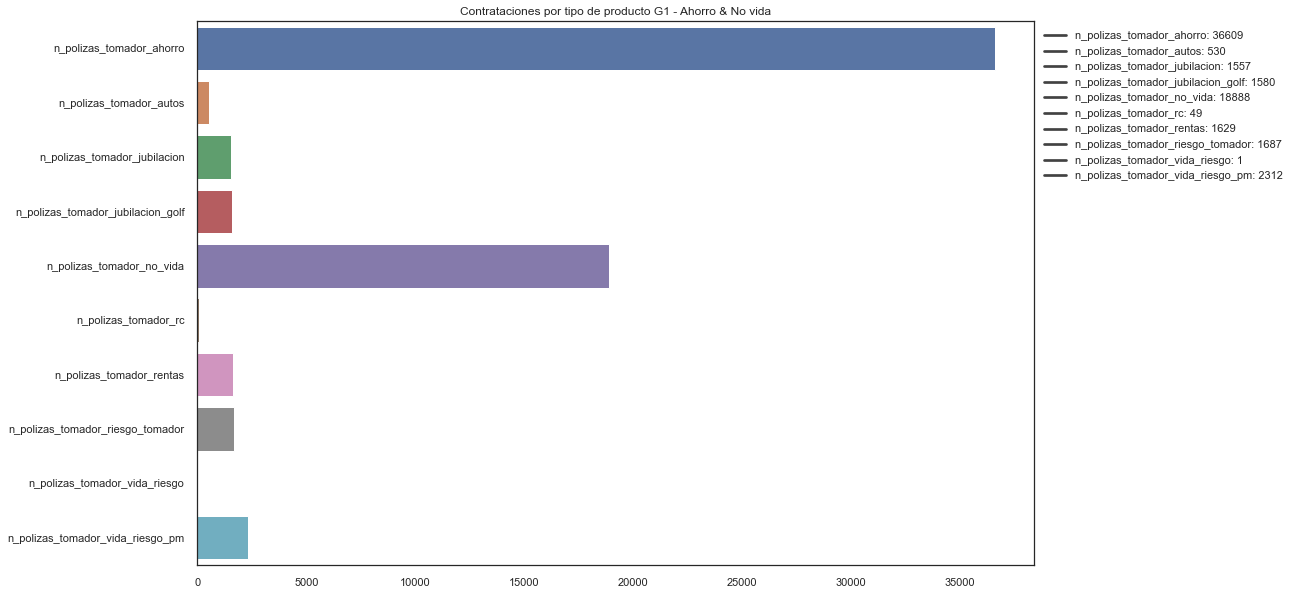

In [140]:
labels =[f"{g1.drop(['id_cliente','total_productos'],axis=1).columns[i]}: {g1.drop(['id_cliente','total_productos'],axis=1).sum()[i]}" for i in range(len(g1.drop(['id_cliente','total_productos'],axis=1).columns))]
plt.figure(figsize=(15,10))
sns.barplot(y=g1.drop(['id_cliente','total_productos'],axis=1).columns, x=g1.drop(['id_cliente','total_productos'],axis=1).sum(), orient= 'h', )
plt.title('Contrataciones por tipo de producto G1 - Ahorro & No vida')
plt.legend(labels= labels , loc = 2, bbox_to_anchor = (1,1))
plt.show();

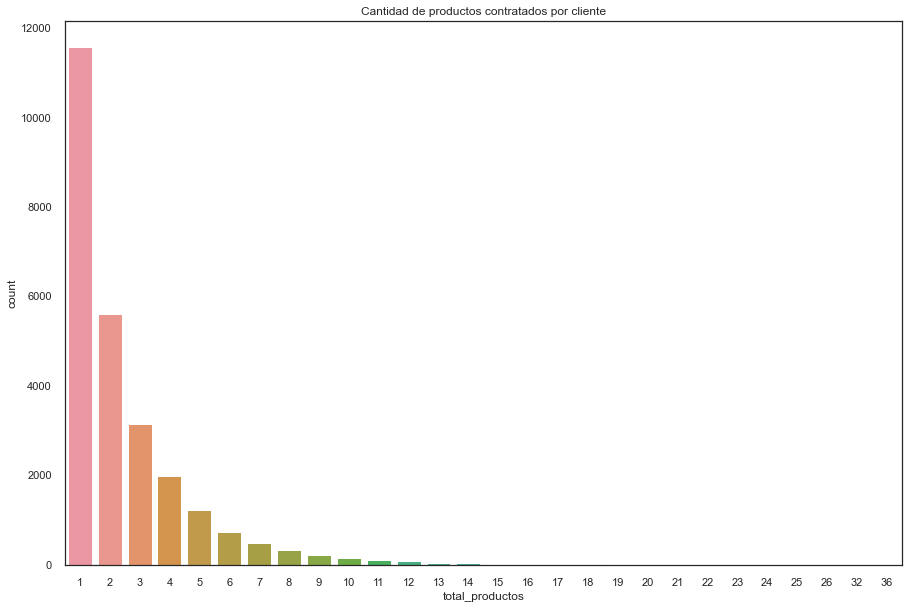

In [141]:
plt.figure(figsize=(15,10))
sns.countplot(data=g1, x='total_productos')
plt.title('Cantidad de productos contratados por cliente')
plt.show();

En el grupo 1 observamos que el 40% de clientes contratan un único producto, principalmente ahorro, y el 60% restante 2 o más siendo no vida la segunda opción y vida riesgo pm la tercera.

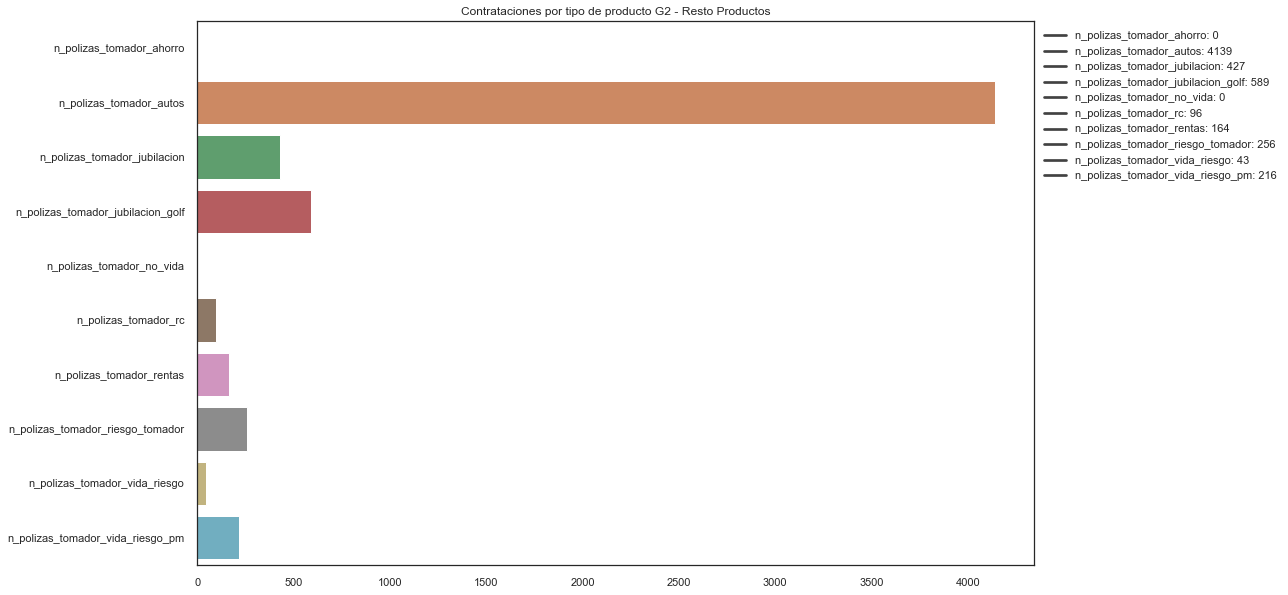

In [142]:
labels =[f"{g2.drop(['id_cliente','total_productos'],axis=1).columns[i]}: {g2.drop(['id_cliente','total_productos'],axis=1).sum()[i]}" for i in range(len(g2.drop(['id_cliente','total_productos'],axis=1).columns))]
plt.figure(figsize=(15,10))
sns.barplot(y=g2.drop(['id_cliente','total_productos'],axis=1).columns, x=g2.drop(['id_cliente','total_productos'],axis=1).sum(), orient= 'h')
plt.title('Contrataciones por tipo de producto G2 - Resto Productos')
plt.legend(labels= labels , loc = 2, bbox_to_anchor = (1,1))
plt.show();

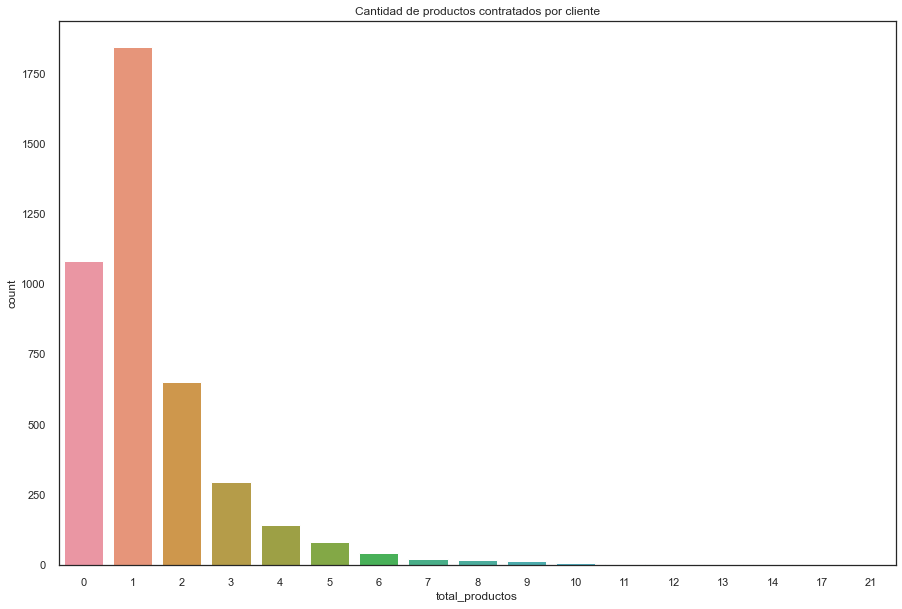

In [143]:
plt.figure(figsize=(15,10))
sns.countplot(data=g2, x='total_productos')
plt.title('Cantidad de productos contratados por cliente');

In [144]:
g2.total_productos.value_counts(normalize=True)

1     0.438034
0     0.256648
2     0.154796
3     0.070038
4     0.033713
5     0.019468
6     0.010209
7     0.004511
8     0.004036
9     0.003561
10    0.001899
12    0.000950
14    0.000712
11    0.000475
13    0.000475
21    0.000237
17    0.000237
Name: total_productos, dtype: float64

Según los datos mostrados anteriormente podemos deducir que el tipo de cliente en este grupo tiene contratado entre 1 y 2 productos, siendo el producto estrella las pólizas de Auto, seguidas por las de jubilación (ya sean de golf o generales).

También podemos observar que aparecen los clientes que no tienen contratado ya ningún producto pero que siguen en la base de datos de la compañía, que en total suponen un 25,66% del total de clientes de este grupo, podríamos quitarlos para realizar una segmentación más fidedigna del tipo de clientes que tenemos en este grupo, pero vamos a dejarlos porque quizás nos de un perfil del tipo de cliente que se va de la empresa y si tenemos el perfil detectado en un futuro podríamos actuar sobre ellos con antelación para evitar su marcha.

### EDA data clientes Grupo1 y Grupo 2

In [145]:
g1_c = pd.merge(g1, clientes, on='id_cliente')
g2_c = pd.merge(g2, clientes, on='id_cliente')

In [146]:
g1_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25788 entries, 0 to 25787
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   n_polizas_tomador_ahorro           25788 non-null  int64 
 1   n_polizas_tomador_autos            25788 non-null  int64 
 2   n_polizas_tomador_jubilacion       25788 non-null  int64 
 3   n_polizas_tomador_jubilacion_golf  25788 non-null  int64 
 4   n_polizas_tomador_no_vida          25788 non-null  int64 
 5   n_polizas_tomador_rc               25788 non-null  int64 
 6   n_polizas_tomador_rentas           25788 non-null  int64 
 7   n_polizas_tomador_riesgo_tomador   25788 non-null  int64 
 8   n_polizas_tomador_vida_riesgo      25788 non-null  int64 
 9   n_polizas_tomador_vida_riesgo_pm   25788 non-null  int64 
 10  total_productos                    25788 non-null  int64 
 11  id_cliente                         25788 non-null  int64 
 12  sexo

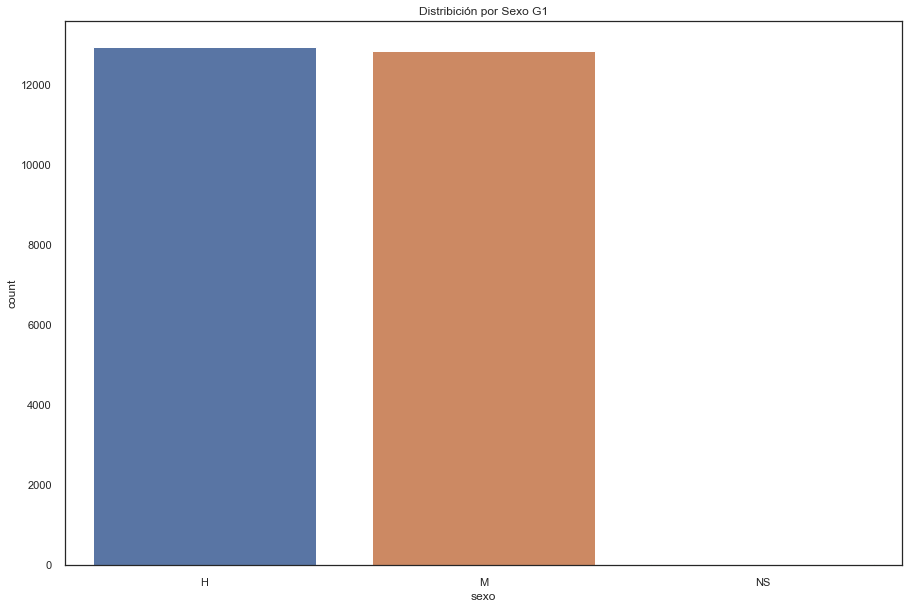

In [147]:
plt.figure(figsize=(15,10))
sns.countplot(data=g1_c, x='sexo')
plt.title('Distribición por Sexo G1');

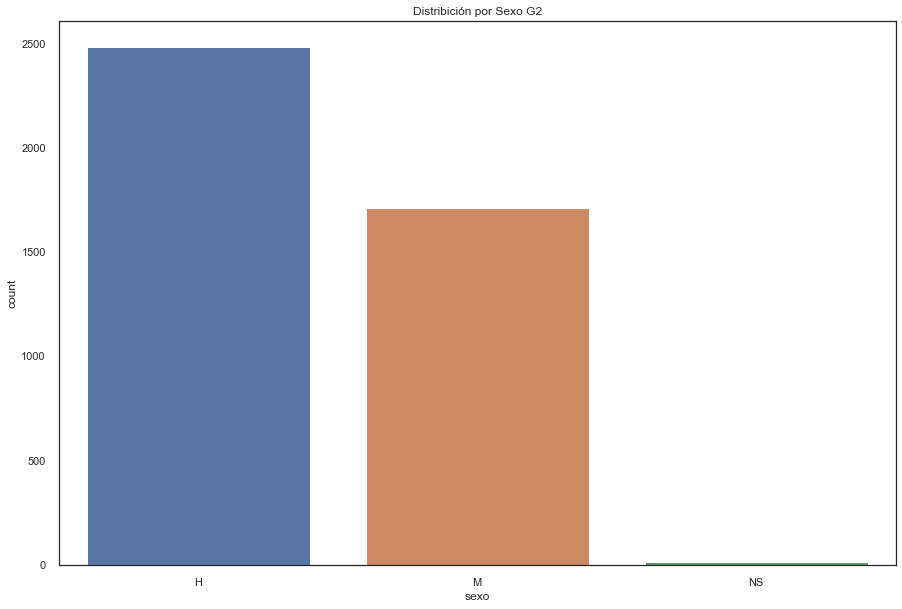

In [148]:
plt.figure(figsize=(15,10))
sns.countplot(data=g2_c, x='sexo')
plt.title('Distribición por Sexo G2');

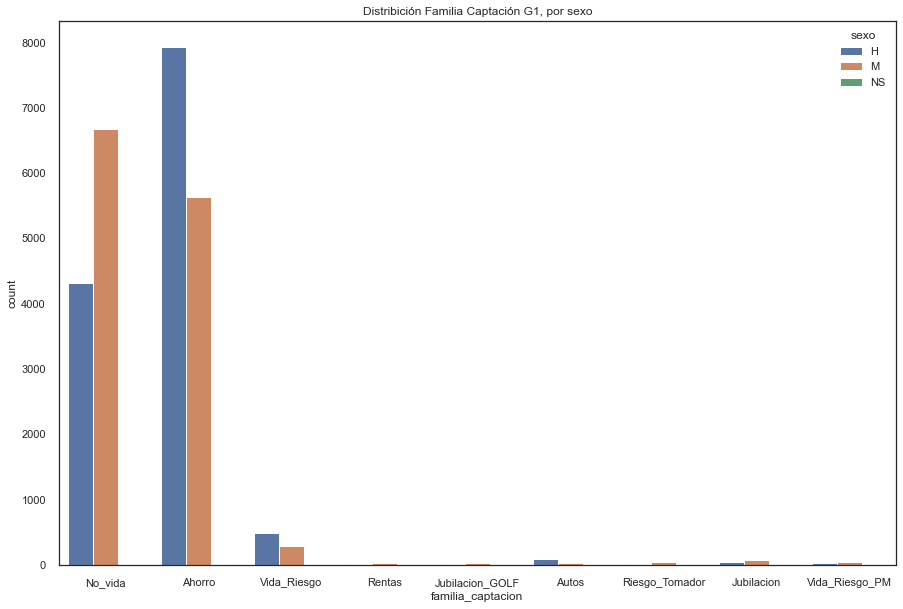

In [149]:
plt.figure(figsize=(15,10))
sns.countplot(data=g1_c, x='familia_captacion', hue='sexo')
plt.title('Distribición Familia Captación G1, por sexo');

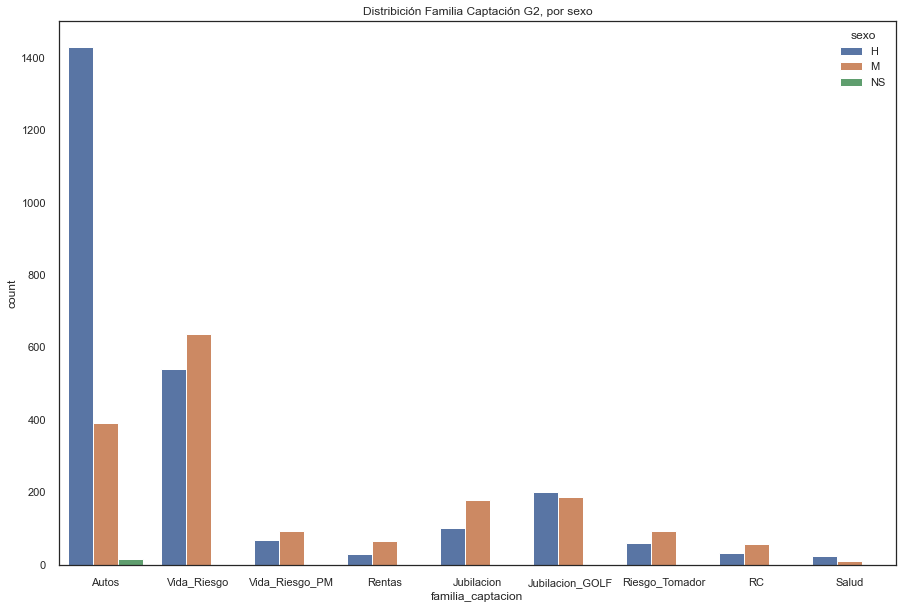

In [150]:
plt.figure(figsize=(15,10))
sns.countplot(data=g2_c, x='familia_captacion', hue='sexo')
plt.title('Distribición Familia Captación G2, por sexo');

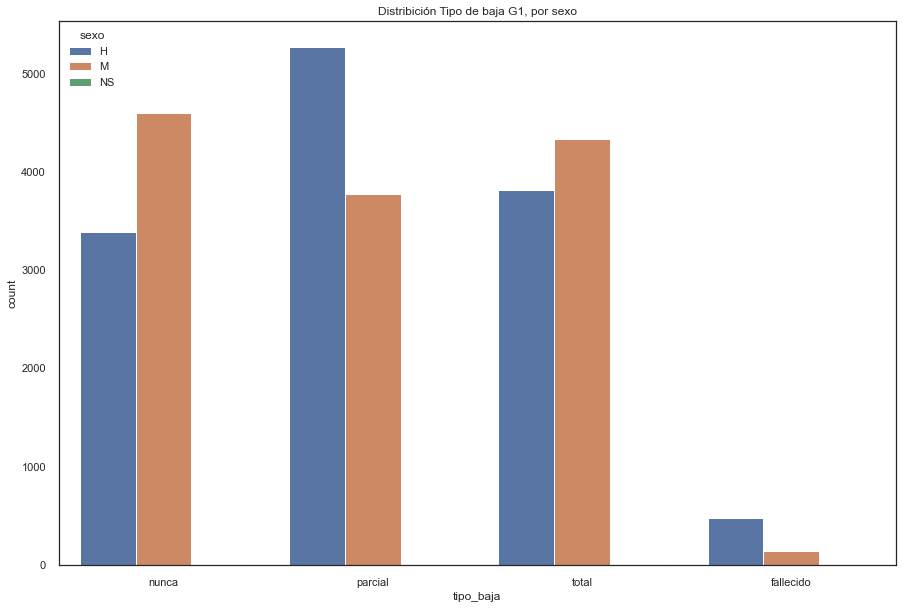

In [151]:
plt.figure(figsize=(15,10))
sns.countplot(data=g1_c, x='tipo_baja', hue='sexo')
plt.title('Distribición Tipo de baja G1, por sexo');

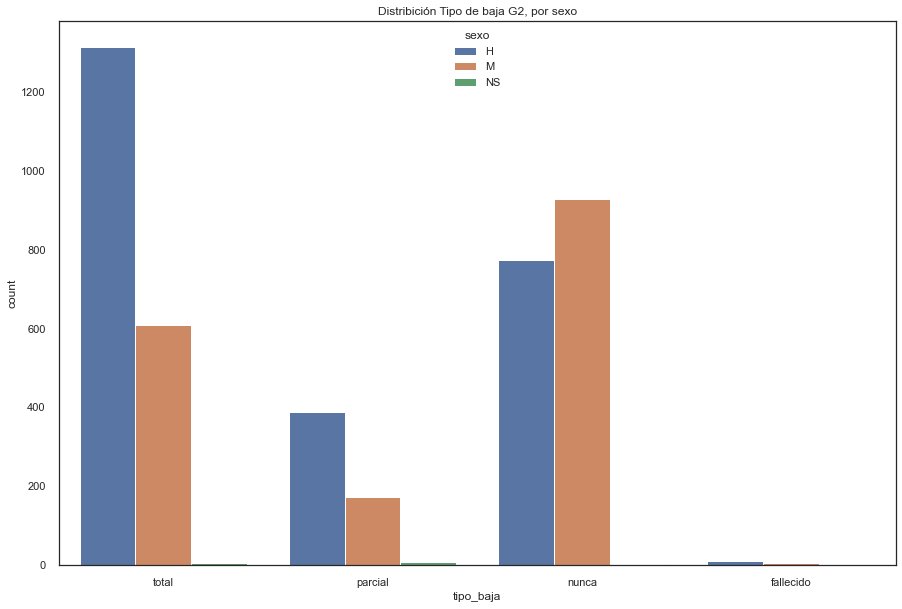

In [152]:
plt.figure(figsize=(15,10))
sns.countplot(data=g2_c, x='tipo_baja', hue='sexo')
plt.title('Distribición Tipo de baja G2, por sexo');

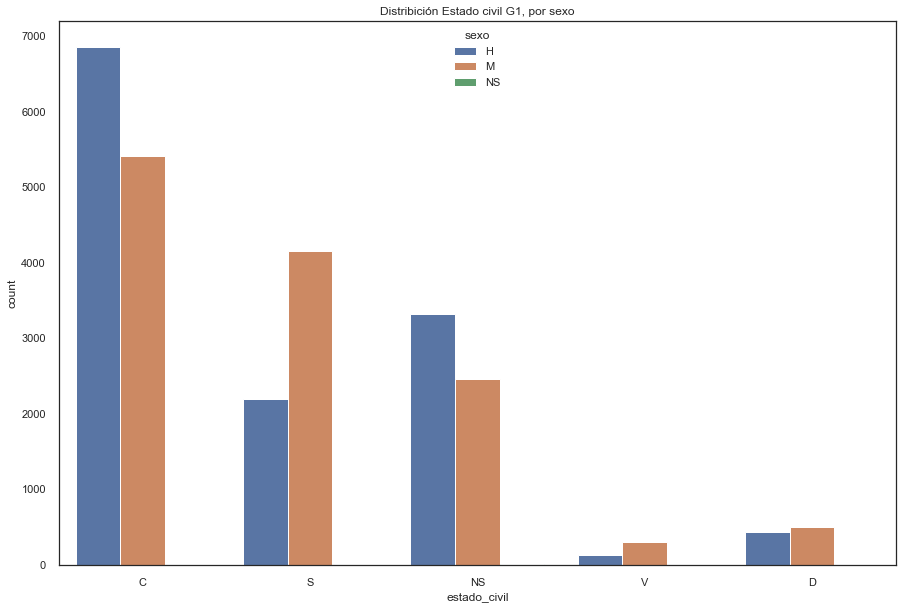

In [153]:
plt.figure(figsize=(15,10))
sns.countplot(data=g1_c, x='estado_civil', hue='sexo')
plt.title('Distribición Estado civil G1, por sexo');

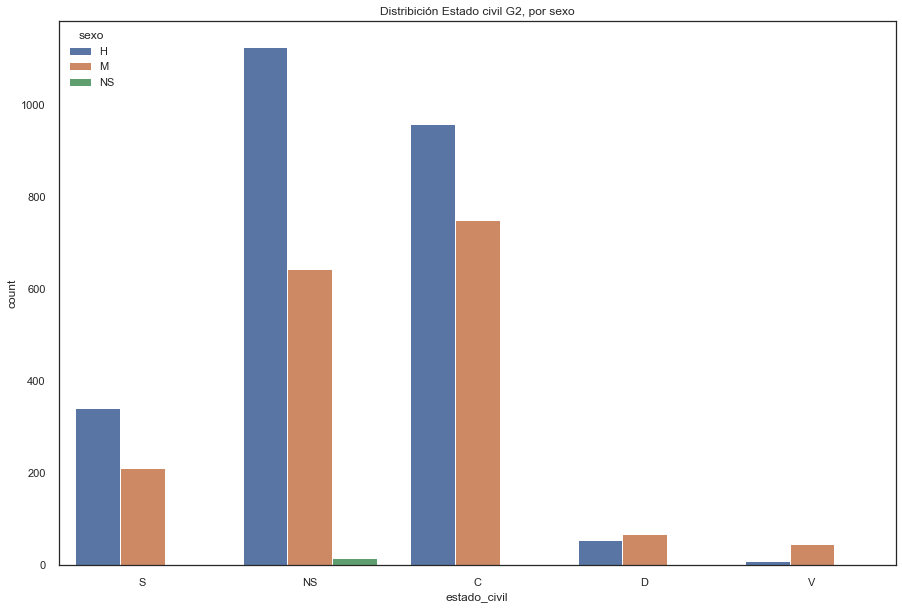

In [154]:
plt.figure(figsize=(15,10))
sns.countplot(data=g2_c, x='estado_civil', hue='sexo')
plt.title('Distribición Estado civil G2, por sexo');

Añadir conclusiones de g1 y g2

### Kmeans

Como comprobamos en el anterior ejemplo Kmeans funcionaba mejor utilizando MinMaxScaler combinado con UMAP, podríamos ir directamente a la opción que mejor funcionó en el anterior caso, pero como nuestros datos son ahora ligeramente diferentes vamos a realizar dos experimentos por separado para cada uno de los grupos, uno utilizando UMAP y otro sin utilizarlo

#### Kmeans G1

##### Kmeans MinMaxScaler

In [155]:
x1 = g1.drop(['id_cliente','total_productos'],axis=1)
mm = MinMaxScaler()
x1_mm = pd.DataFrame(mm.fit_transform(x1), columns=x1.columns)

In [156]:
kmeans_per_k_x1 = [KMeans(n_clusters=k,random_state=42).fit(x1_mm) for k in tqdm(range(2,10))]
inertias_x1 = [model.inertia_ for model in tqdm(kmeans_per_k_x1)]
silhouette_scores_mm_x1 = [silhouette_score(x1_mm, model.labels_) for model in tqdm(kmeans_per_k_x1)]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

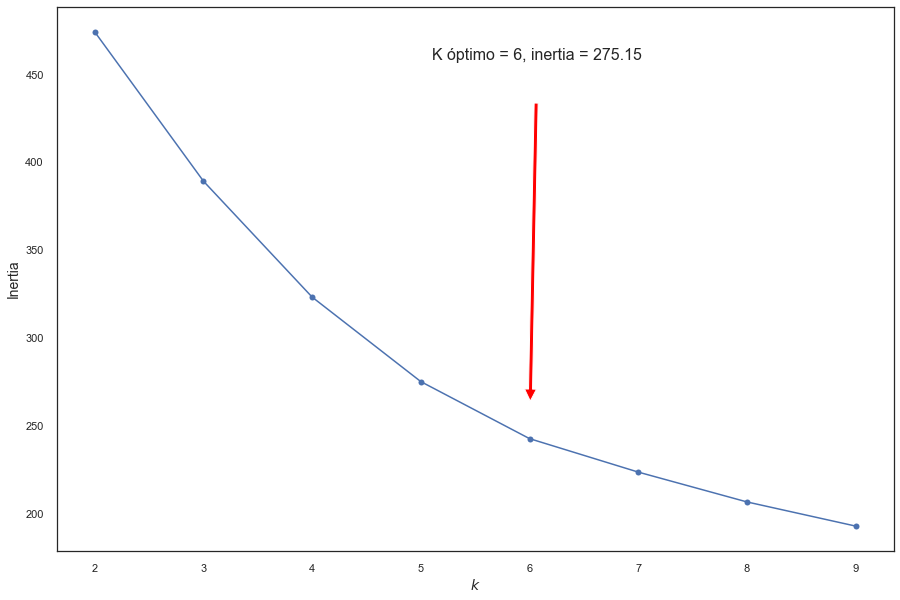

In [157]:
plot_elbow(inertias_x1, annot=True,save=False)

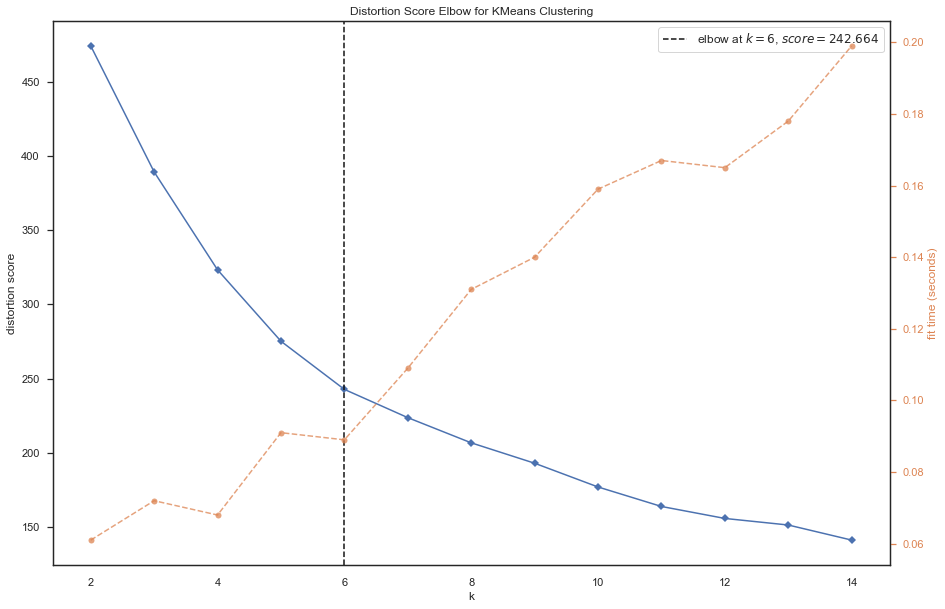

In [158]:
plot_KElbowVisualizer(x1_mm)

Introduce un nombre para el grafico MM_Silhouette_Scores_Kmeans_G1


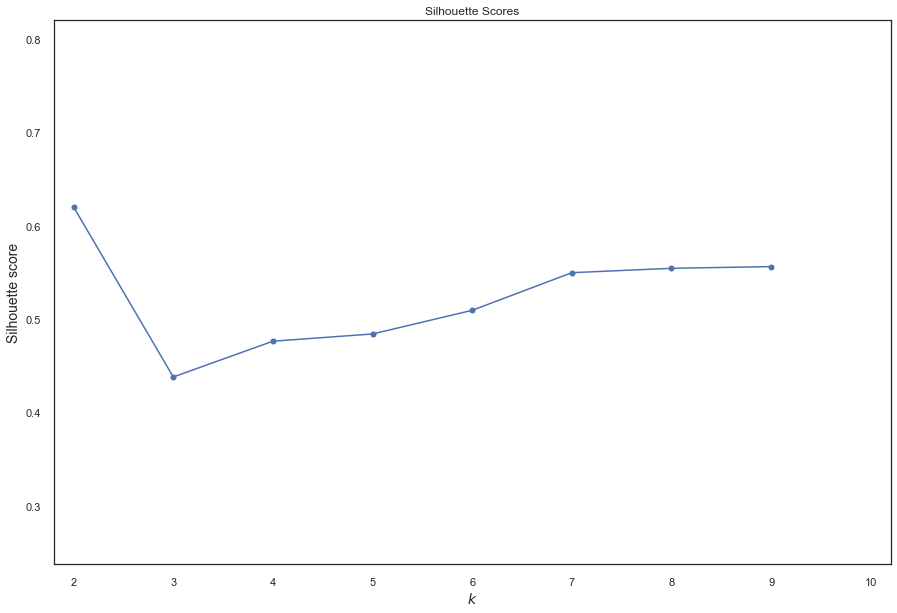

In [159]:
plot_silhouette_scores(silhouette_scores_mm_x1, save=False)

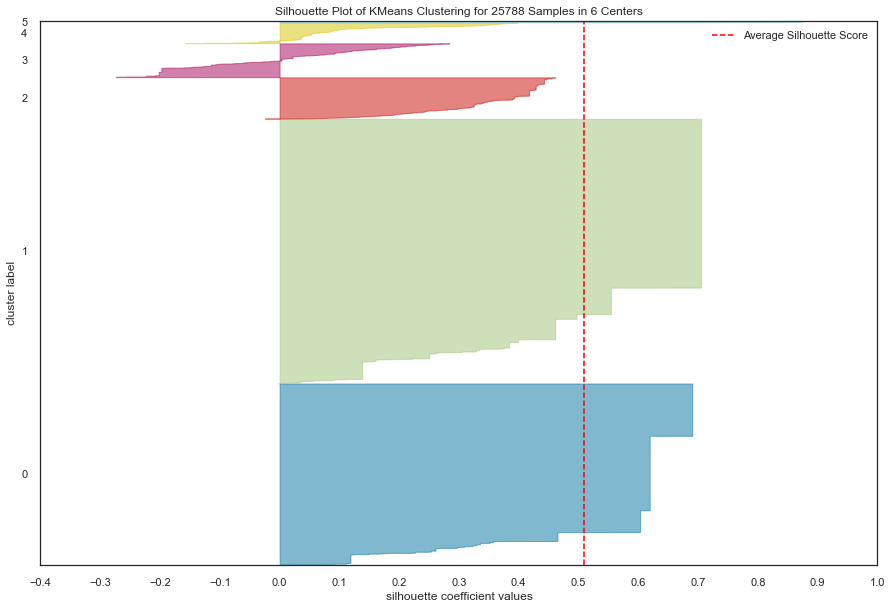

In [160]:
plot_silhouette_visualizer(x1_mm,6)

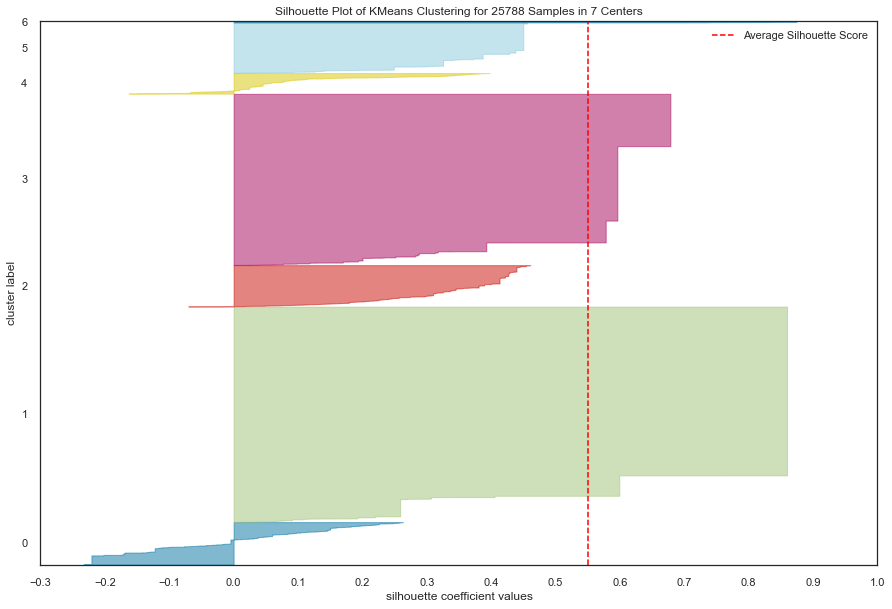

In [161]:
plot_silhouette_visualizer(x1_mm,7)

In [162]:
kmeans_k6 = KMeans(n_clusters=6, random_state=42).fit(x1_mm)
y_pred = kmeans_k6.predict(x1_mm)

In [163]:
x1_umap=get_umap(x1_mm,2)

In [173]:
x1_umap['cluster'] = y_pred

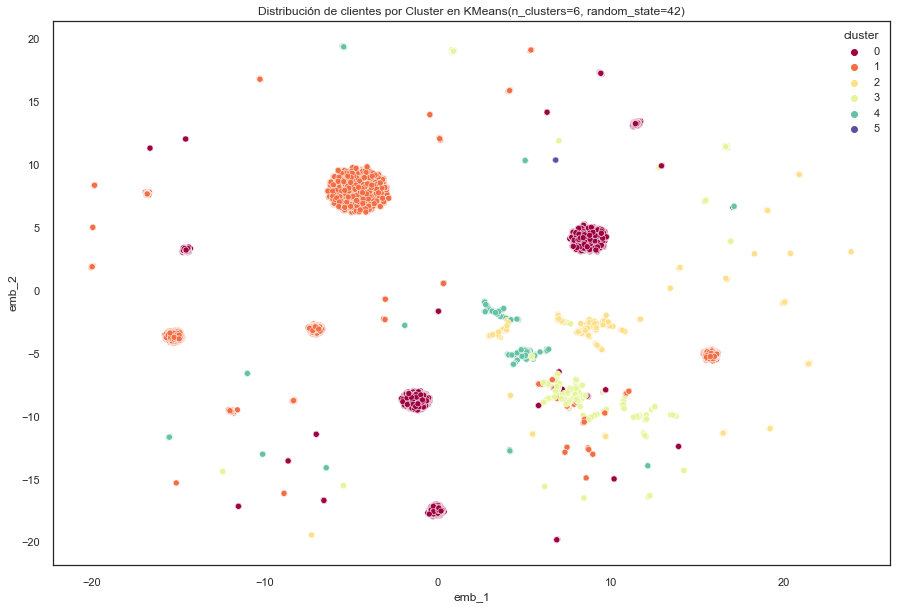

In [174]:
plot_clusters(x1_umap, kmeans_k6, centroids=False)

##### Kmeans MinMaxScaler + UMAP

In [175]:
x1_umap = x1_umap.drop('cluster', axis=1)
g1_mm_umap = MinMaxScaler()
x1_umap_mm = g1_mm_umap.fit_transform(x1_umap)

In [177]:
kmeans_per_k_umap_x1 = [KMeans(n_clusters=k,random_state=42).fit(x1_umap_mm) for k in tqdm(range(2,10))]
inertias_umap_x1 = [model.inertia_ for model in tqdm(kmeans_per_k_umap_x1)]
silhouette_scores_mm_x1 = [silhouette_score(x1_umap_mm, model.labels_) for model in tqdm(kmeans_per_k_umap_x1)]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

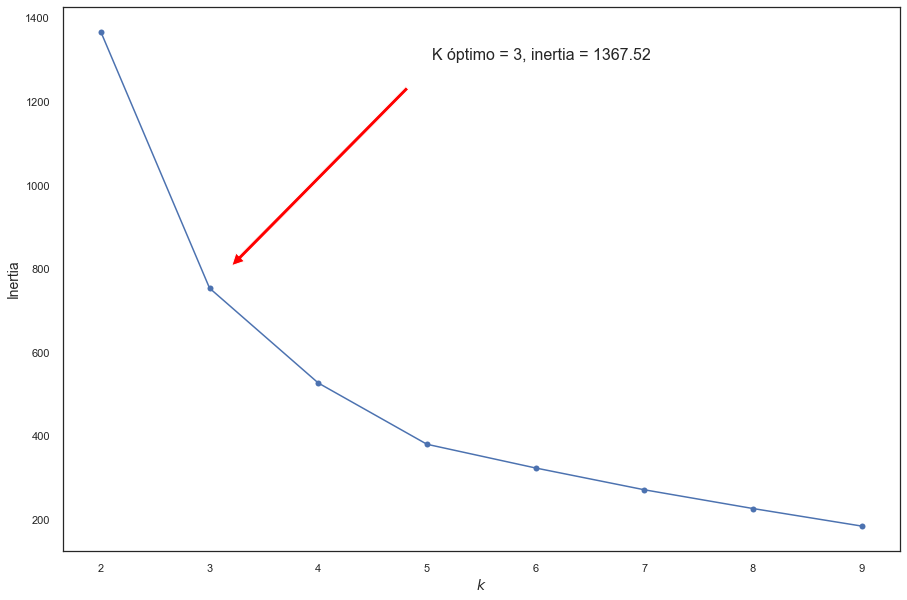

In [179]:
plot_elbow(inertias_umap_x1, annot=True,save=False)

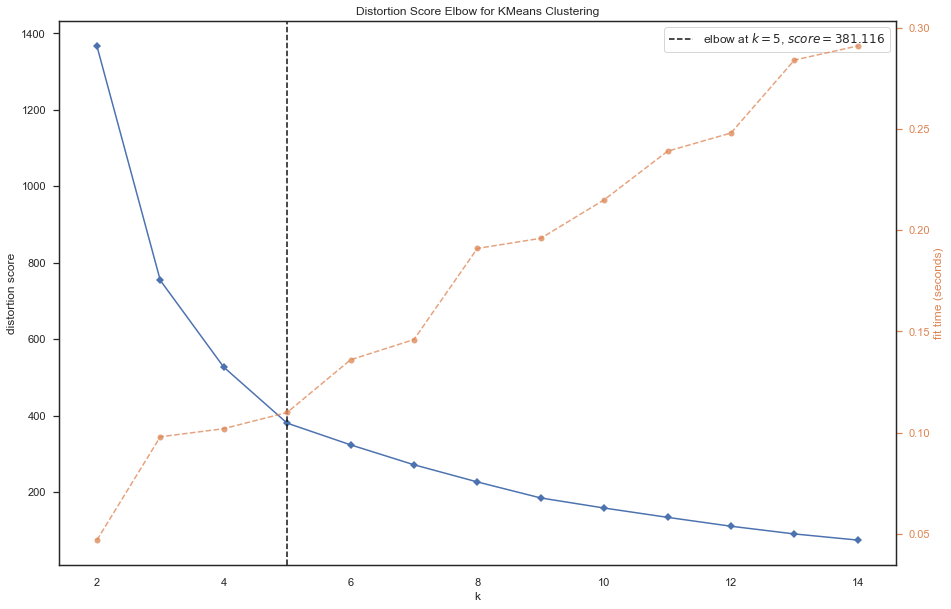

In [180]:
plot_KElbowVisualizer(x1_umap_mm)

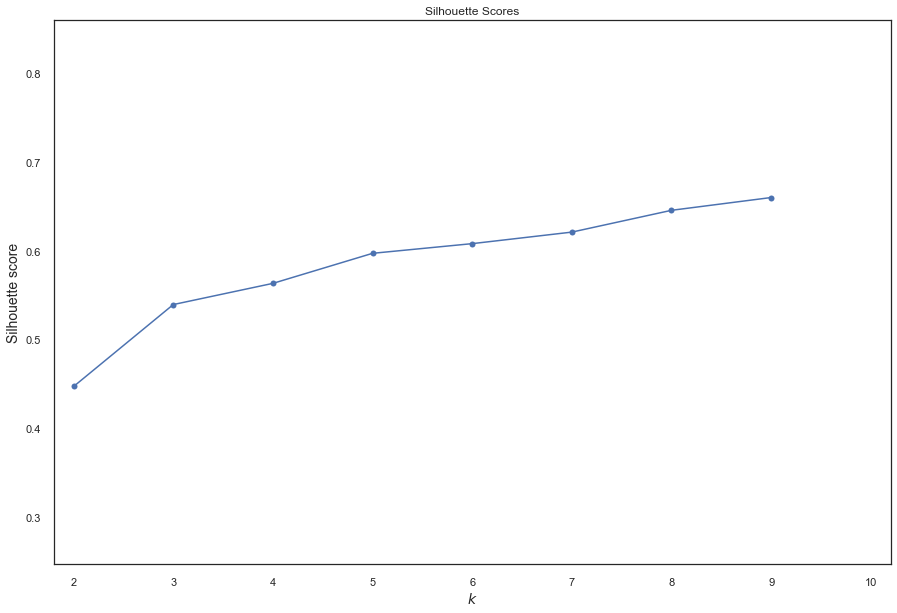

In [181]:
plot_silhouette_scores(silhouette_scores_mm_x1, save=False)

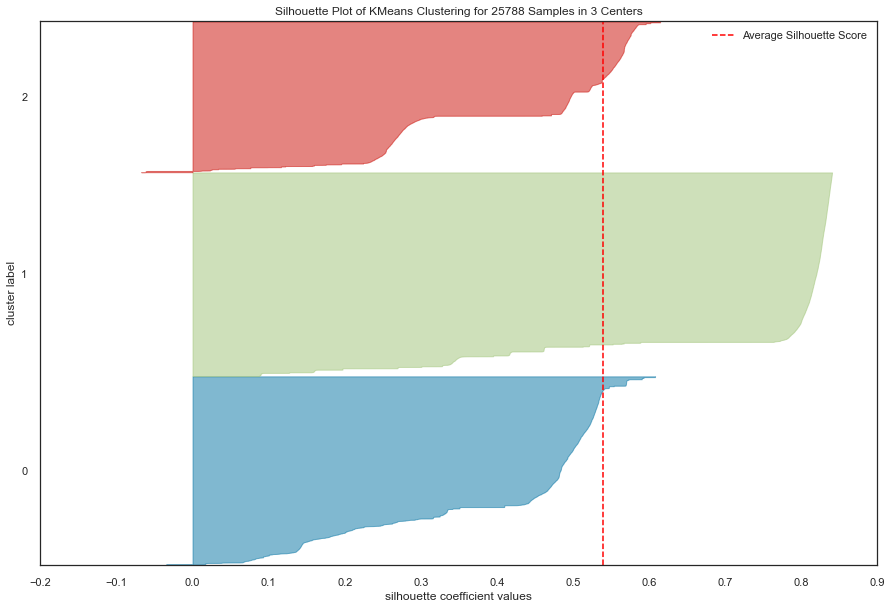

In [182]:
plot_silhouette_visualizer(x1_umap_mm,3)

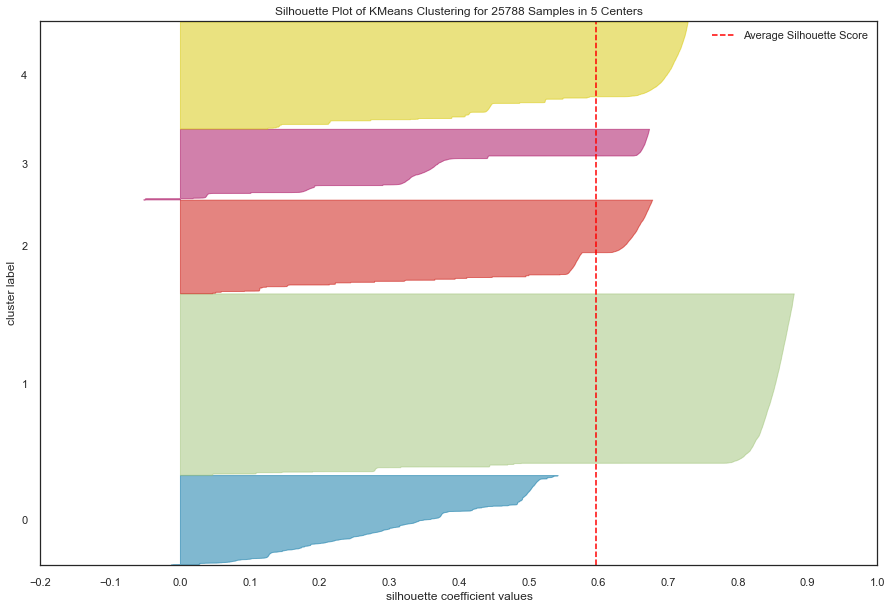

In [183]:
plot_silhouette_visualizer(x1_umap_mm,5)

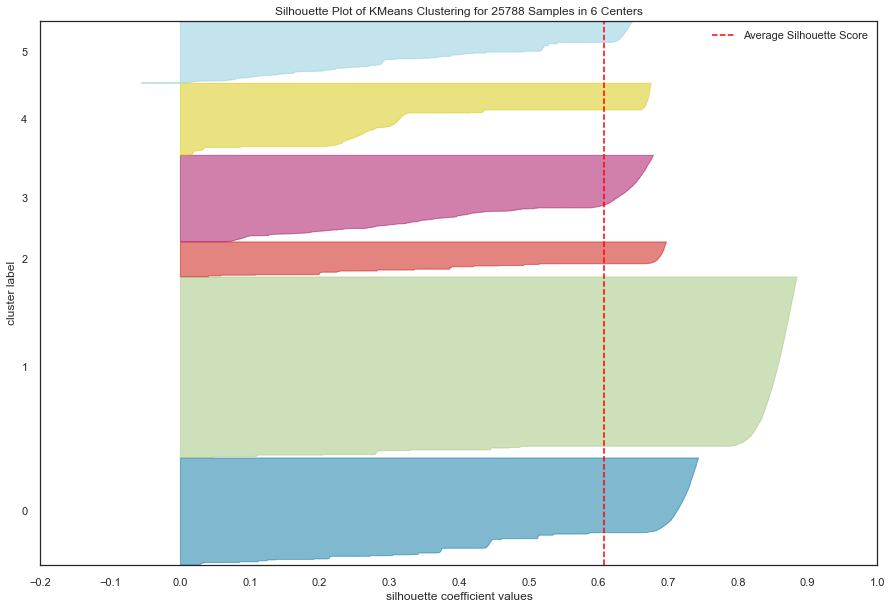

In [220]:
plot_silhouette_visualizer(x1_umap_mm,6)

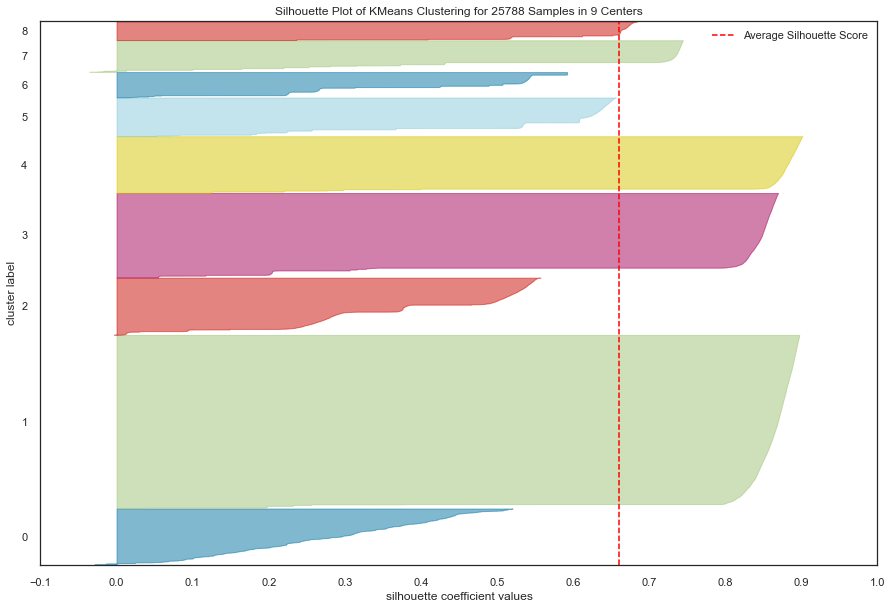

In [184]:
plot_silhouette_visualizer(x1_umap_mm,9)

In [336]:
x1_umap_mm = pd.DataFrame(x1_umap_mm, columns=x1_umap.columns)

In [337]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42).fit(x1_umap_mm)
y_pred = kmeans_k3.predict(x1_umap_mm)
x1_umap_mm['cluster'] = y_pred

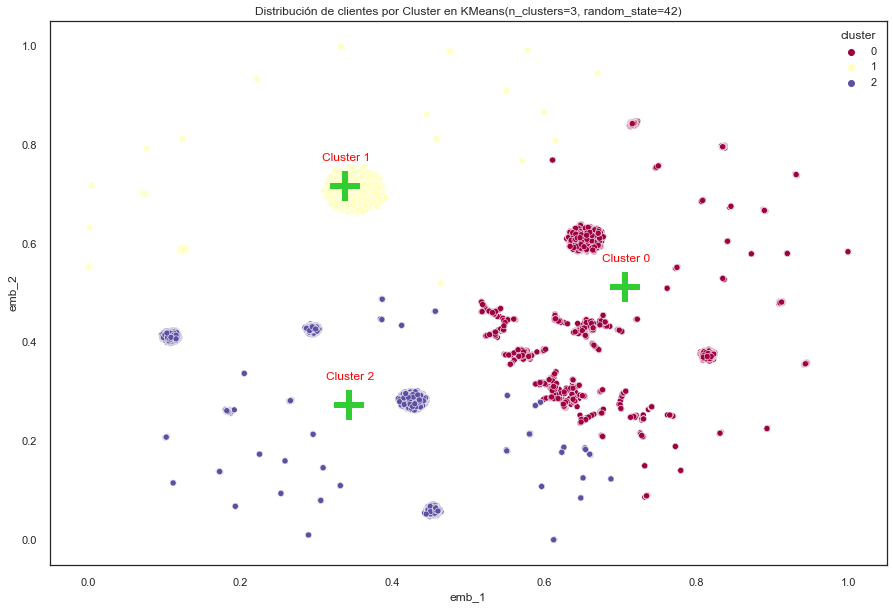

In [338]:
plot_clusters(x1_umap_mm, kmeans_k3, centroids=True ,save=False)

#### Analisis Kmeans G1

In [339]:
g1_c['cluster']=y_pred

##### Cluster 0

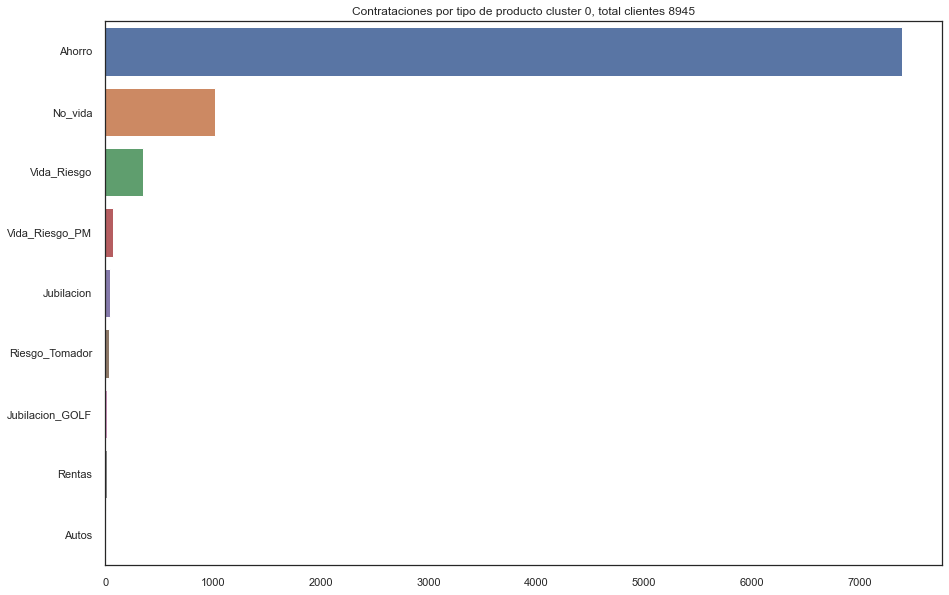

In [188]:
plot_productos_x_cluster(g1_c, 0)

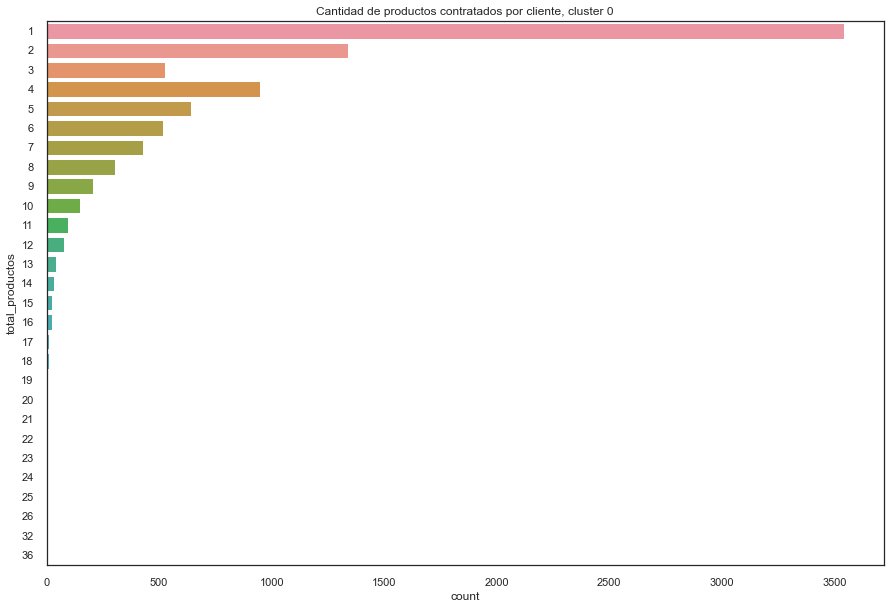

In [243]:
plot_total_productos_x_cluster(g1_c, 0)

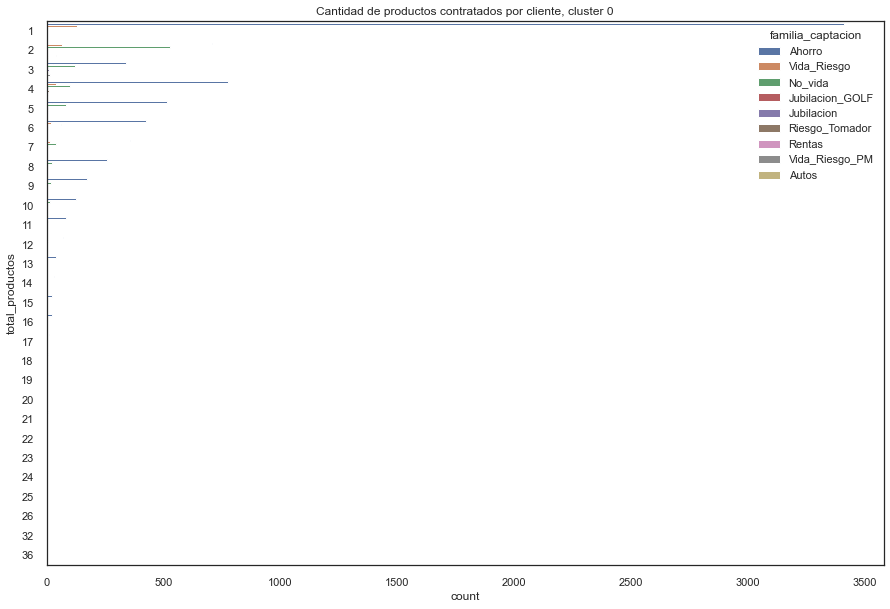

In [244]:
plot_total_productos_x_cluster(g1_c, 0, save=True, hue='familia_captacion')

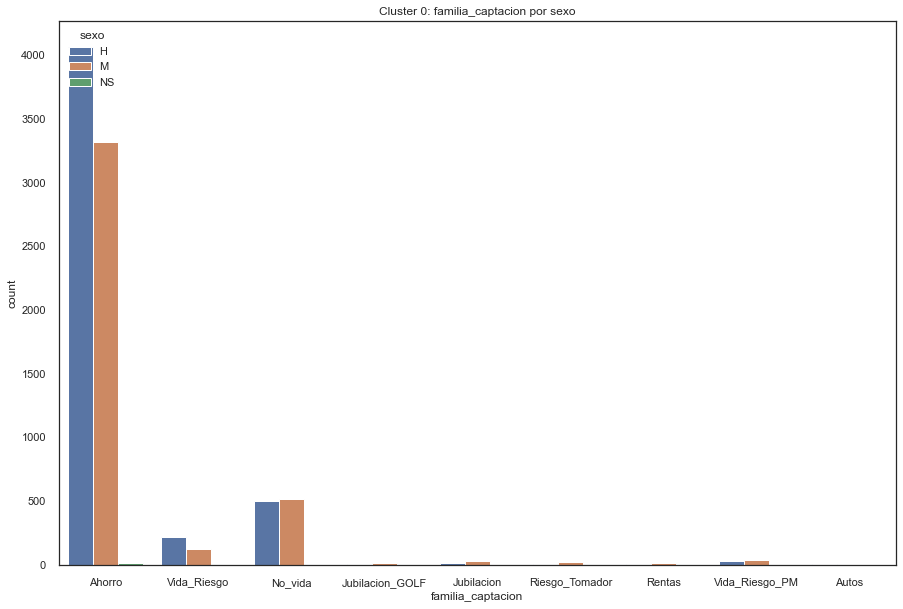

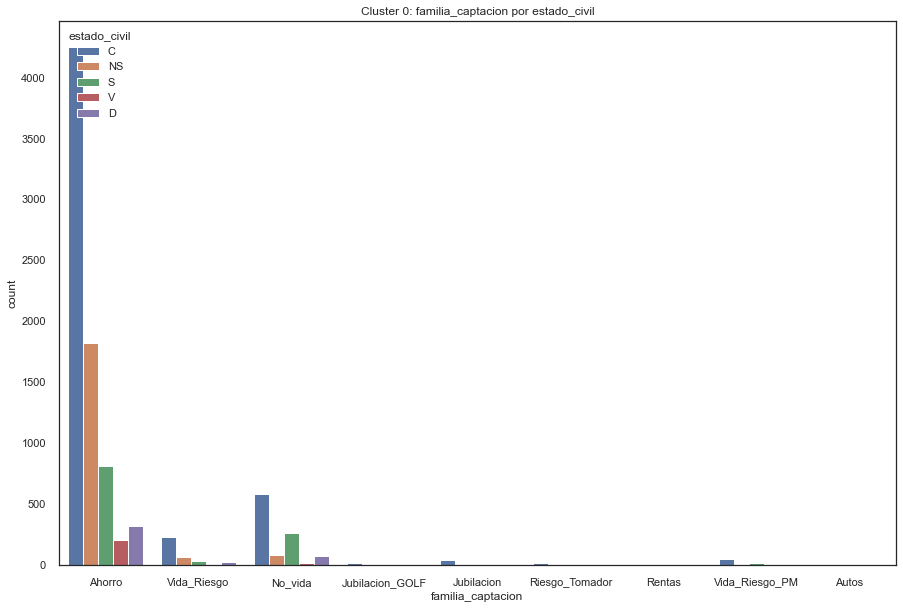

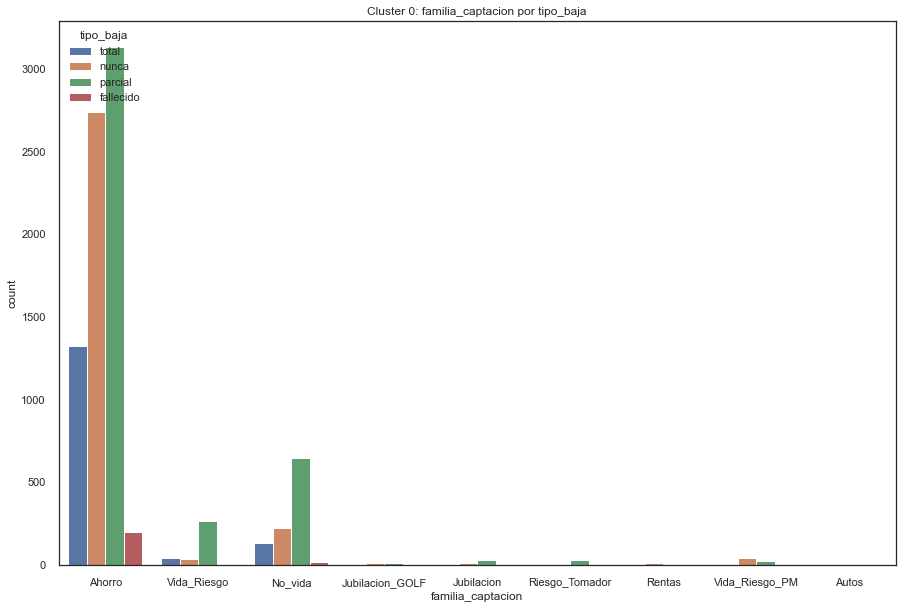

In [246]:
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g1_c, 0,'familia_captacion', e, save=False)

El perfil del cliente del cluster cero del grupo 1 es un cliente que tiene principalmente un producto de ahorro y si tiene varios productos contratados son también de este tipo, suele ser un cliente casado, y que tiene bastante arraigo por la empresa, porque no se da de baja con facilidad.

##### Cluster 1

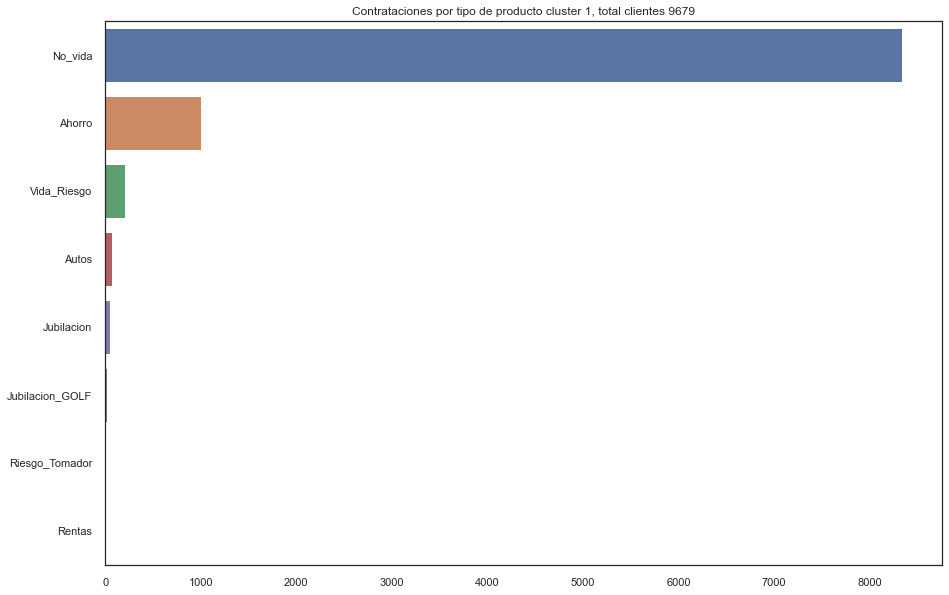

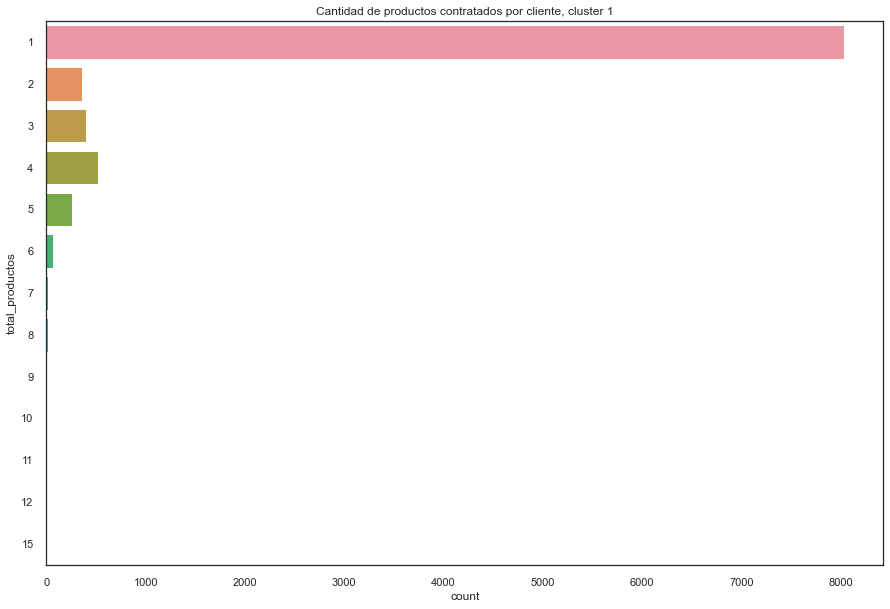

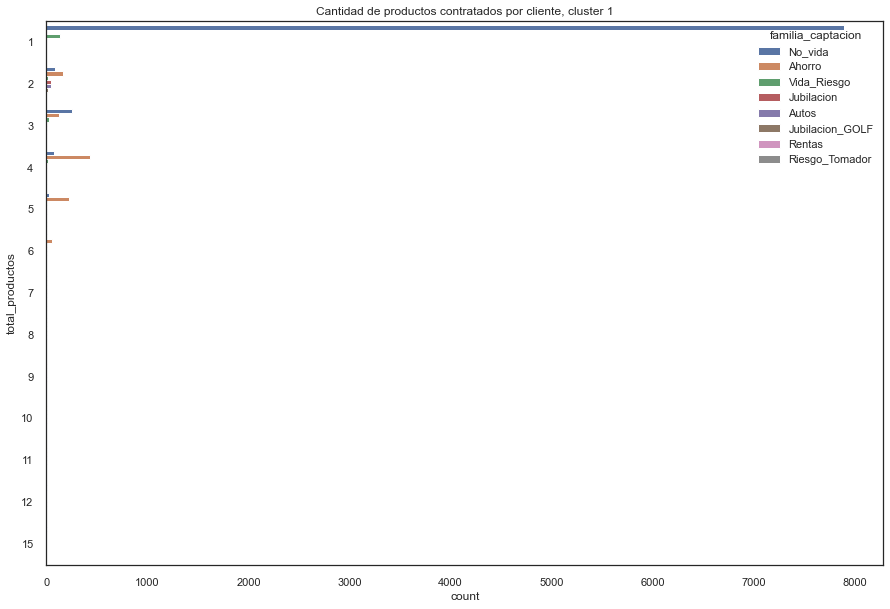

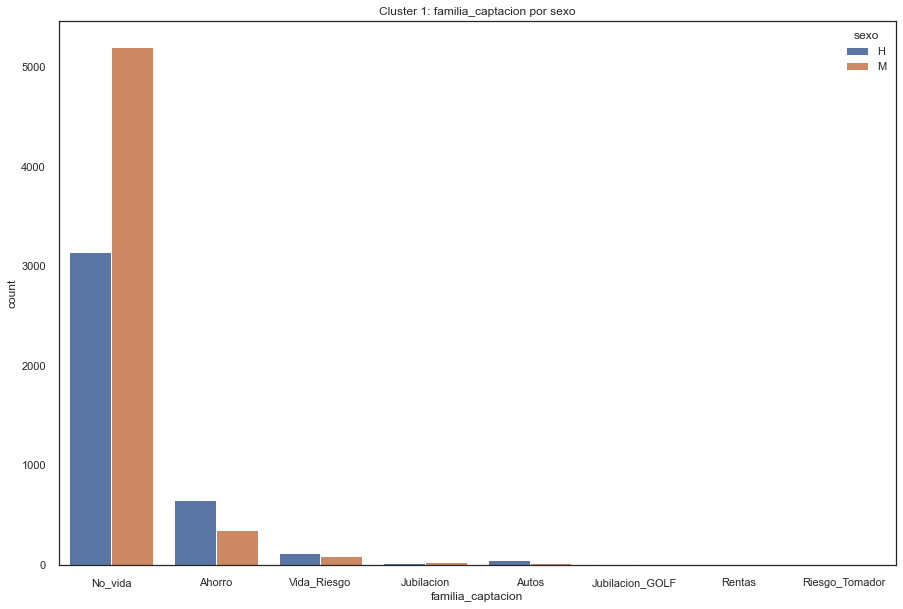

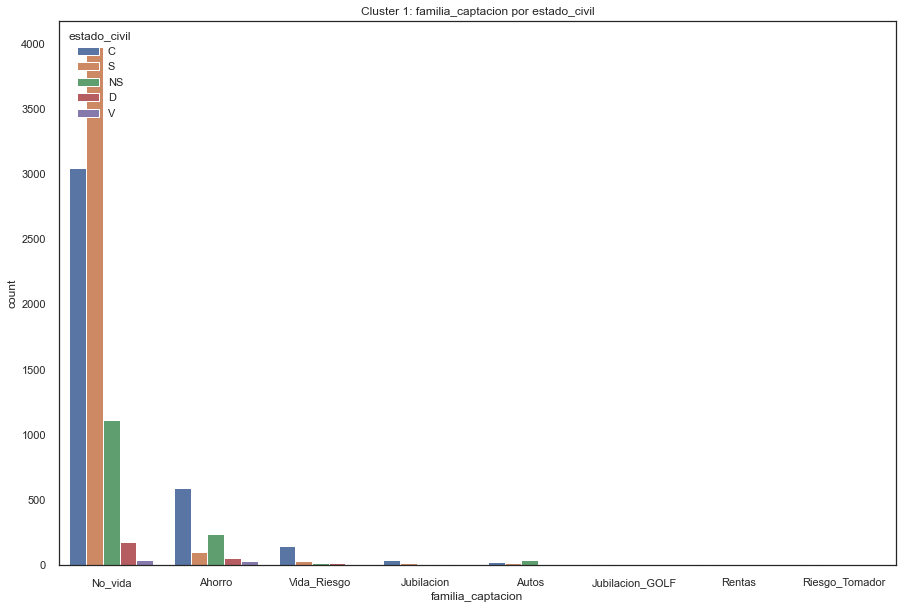

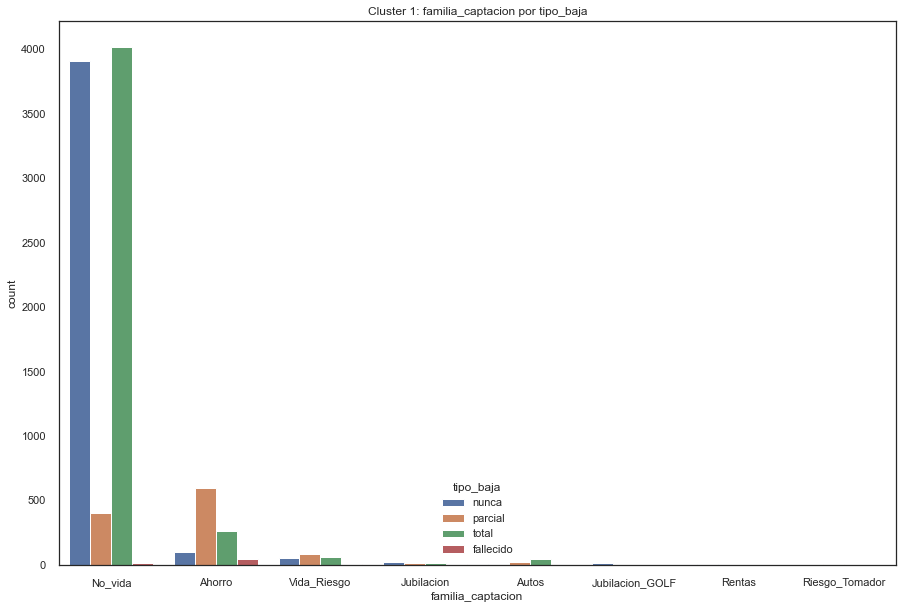

In [247]:
plot_productos_x_cluster(g1_c, 1)
plot_total_productos_x_cluster(g1_c, 1)
plot_total_productos_x_cluster(g1_c, 1, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g1_c, 1,'familia_captacion', e)

El perfil del cluster 1 es una mujer soltera que contrata principalmente productos de No vida, y como norma general no más de un producto, y suele ser bastante extremista porque o no se da de baja o lo hace de forma total.

##### Cluster 2

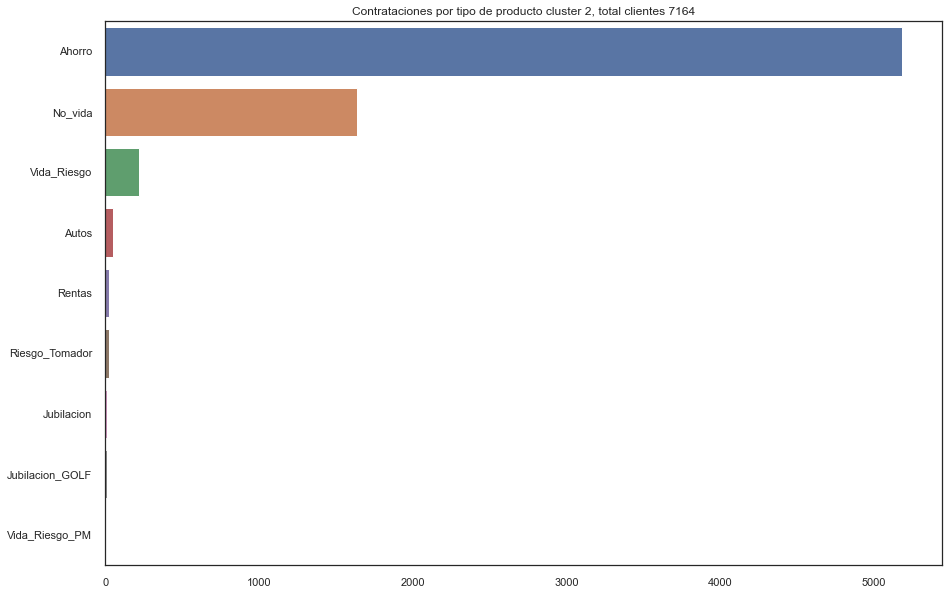

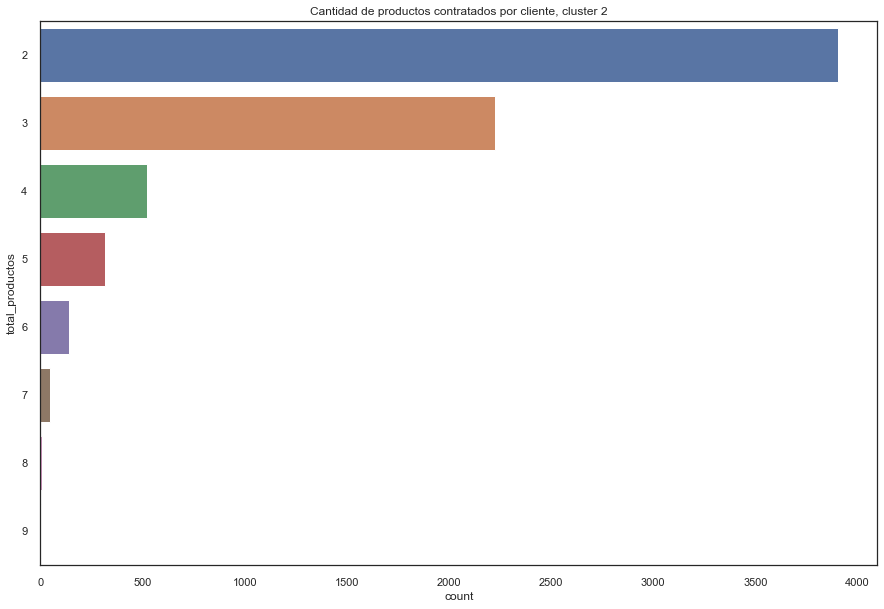

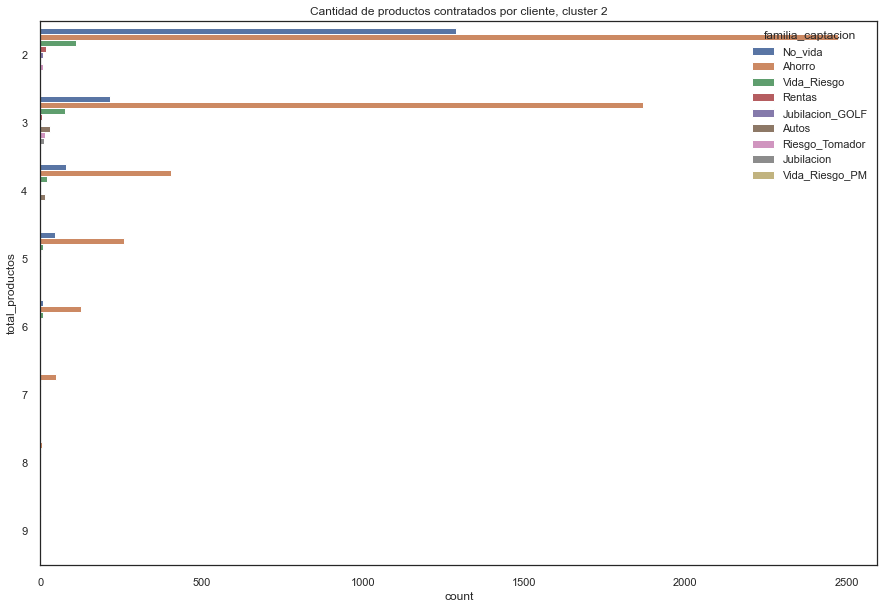

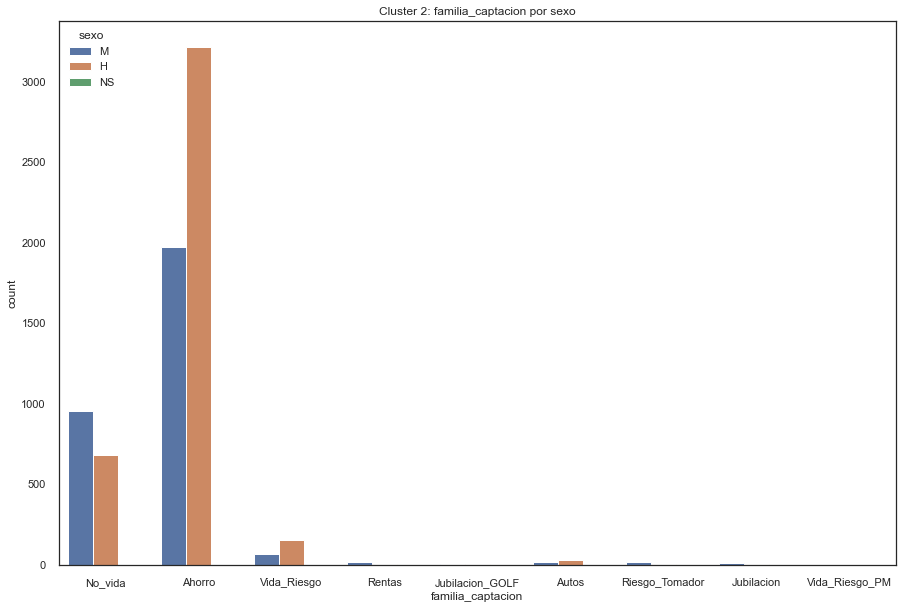

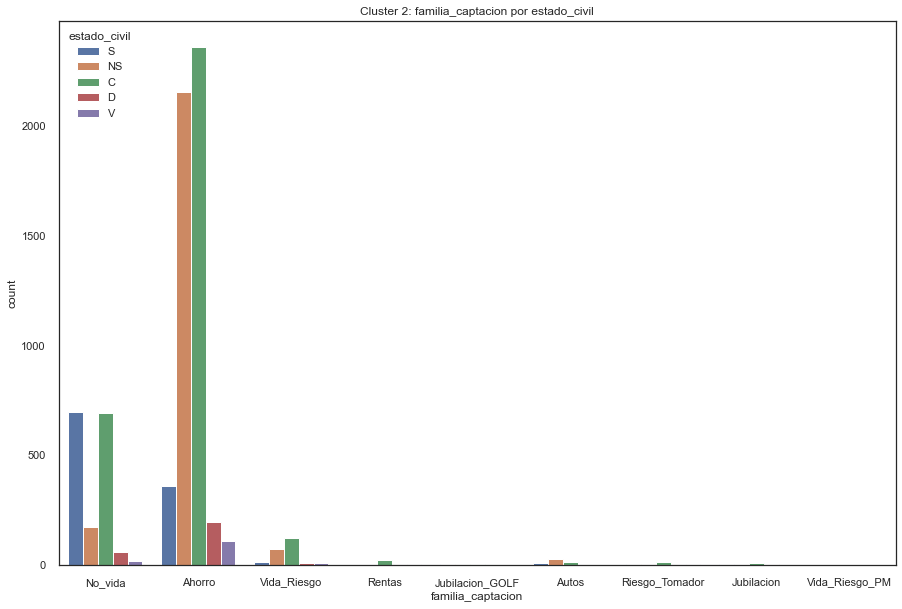

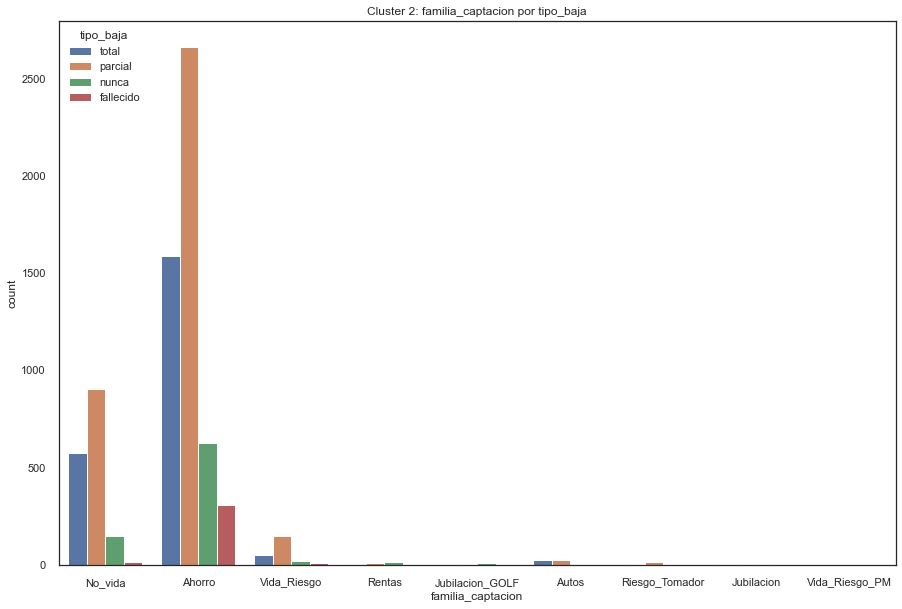

In [248]:
plot_productos_x_cluster(g1_c, 2)
plot_total_productos_x_cluster(g1_c, 2)
plot_total_productos_x_cluster(g1_c, 2, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g1_c, 2,'familia_captacion', e)

El perfil de este cluster es un hombre casado que contrata entre 2-3 productos , en la mayoría de los casos 3 y casi siempre todos del mismo tipo, Ahorro, con bastante fluctuación en las contrataciones ya que suele causar baja de algunos de ellos.

In [193]:
plot_productos_x_cluster(g1_c, 3)
plot_total_productos_x_cluster(g1_c, 3)
plot_total_productos_x_cluster(g1_c, 3,hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g1_c, 3,'familia_captacion', e, save=False)

ValueError: min() arg is an empty sequence

<Figure size 1080x720 with 0 Axes>

En este cluster encontramos un perfil de cliente de hombre casado, que contrata 2 productos o más, en la mayoría de casos 2 productos en la la familia de Ahorro, en algunos casos combinado con vida riesgo, y si contrata más de dos productos suele hacer combinado con no vida, muestra poco arraigo con el producto porque suele causar baja con asiduidad ya sea de forma total o parcial.

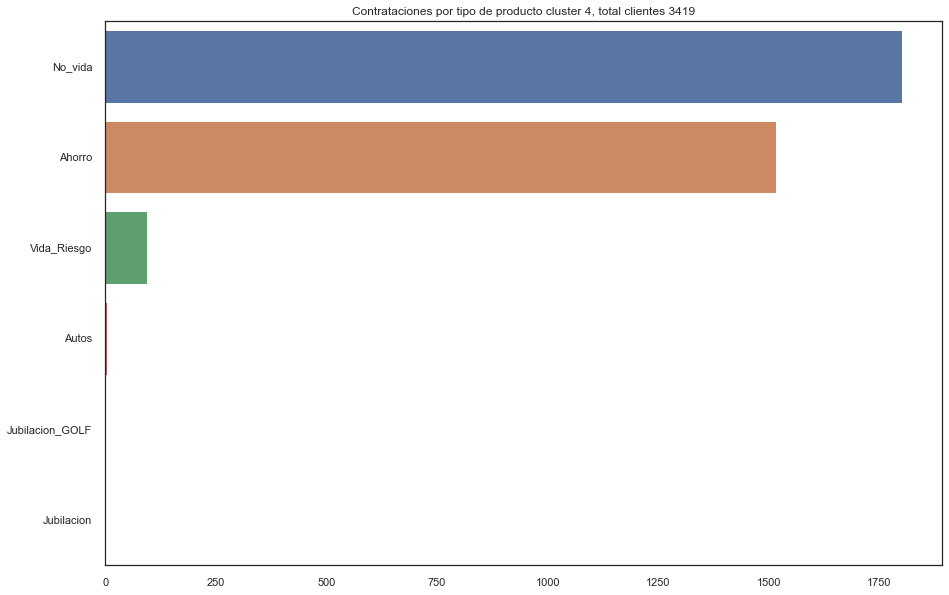

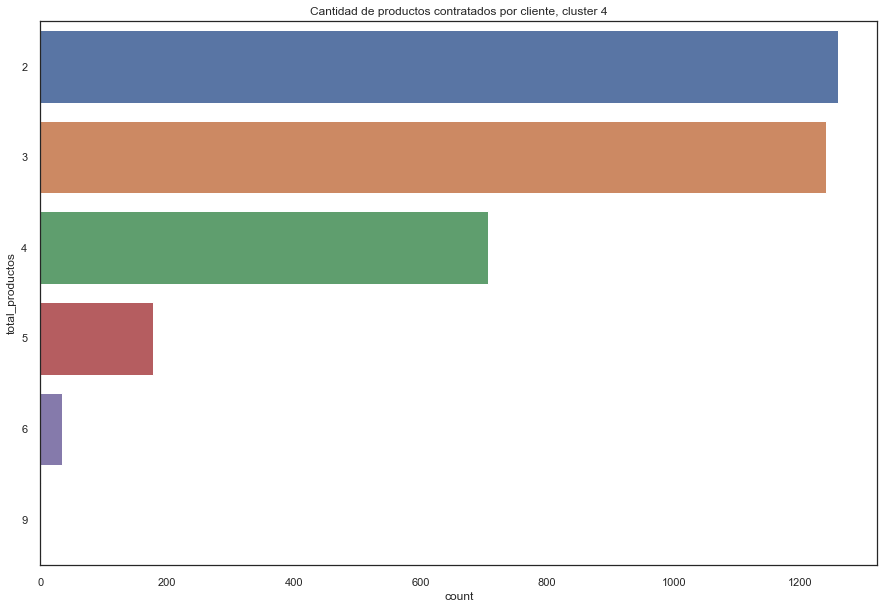

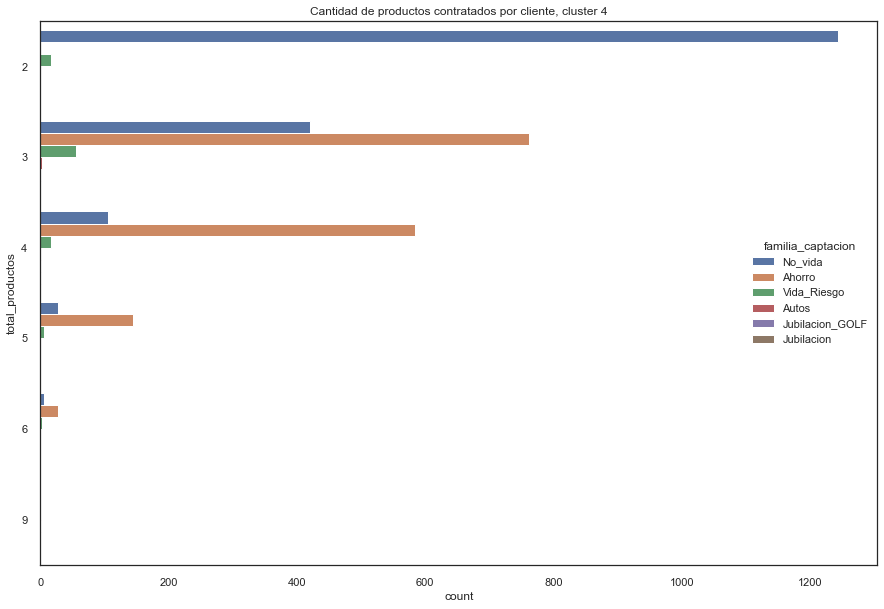

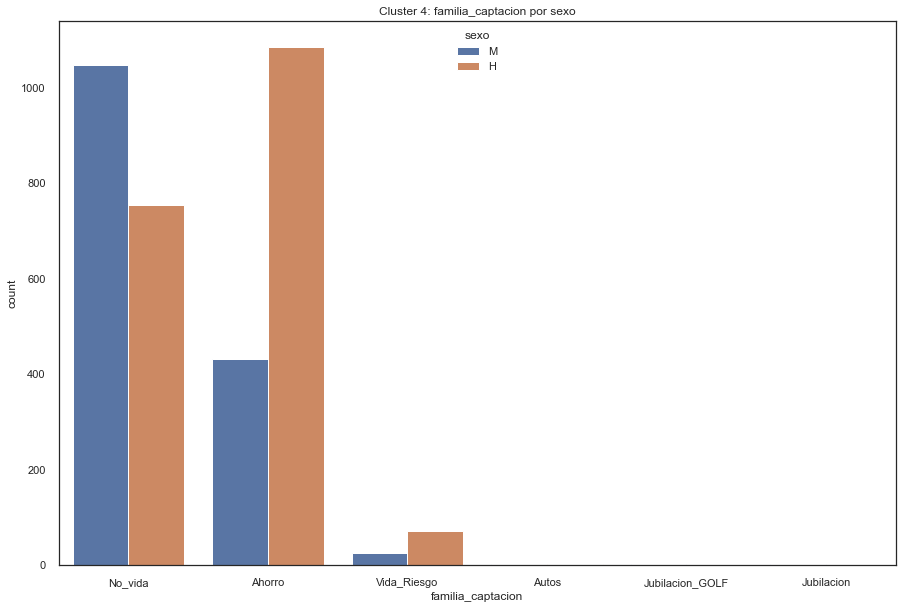

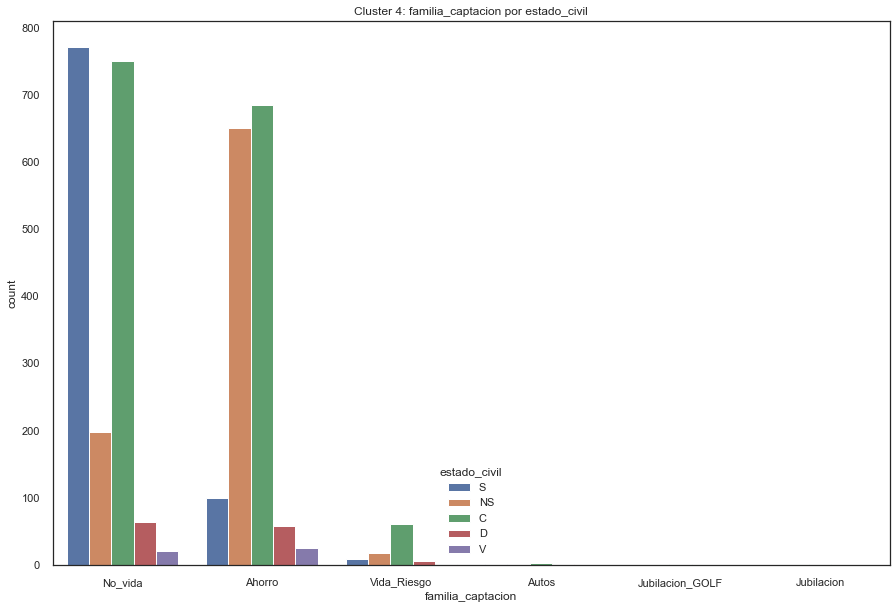

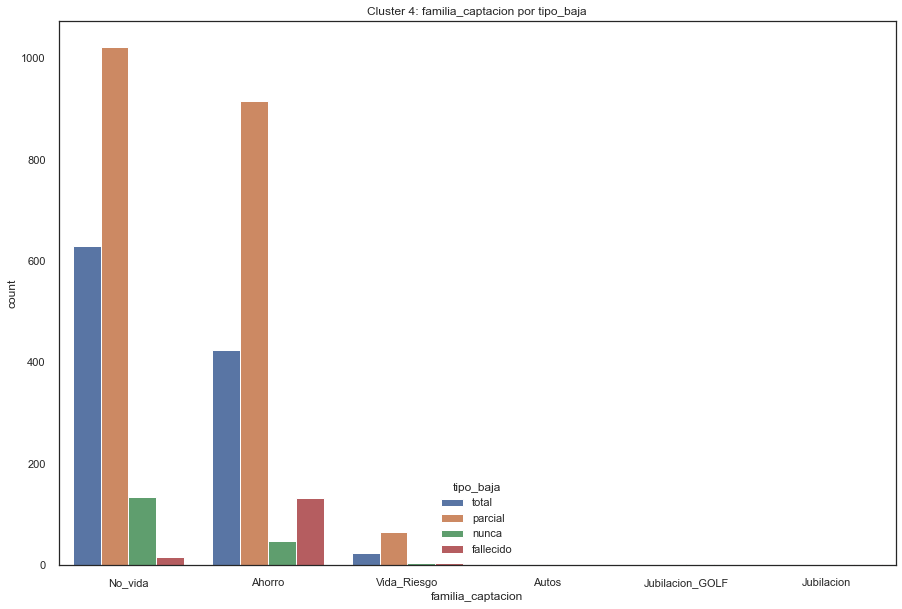

In [239]:
plot_productos_x_cluster(g1_c, 4)
plot_total_productos_x_cluster(g1_c, 4)
plot_total_productos_x_cluster(g1_c, 4,hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g1_c, 4,'familia_captacion', e, save=False)

El perfil de este cluster no acaba de estar del todo claro, ya que encontramos dos tendencias, en la mayoría de casos encontramos con una contratación de 2-3 productos, con una marcada tendencia, si el cliente tiene contratado dos productos suele ser un hombre casado que contrata no vida, con una alta volatilidad de permanencia, y si contrata 3 productos es una mujer casada con preferencia por polizas de Ahorro junto a no vida y/o riesgo, también con una volatilidad muy marcada.

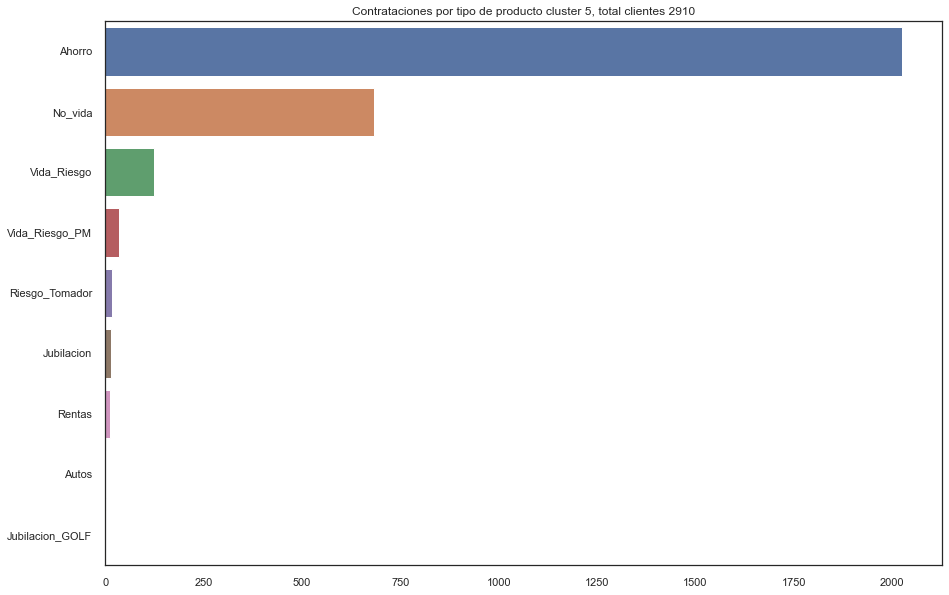

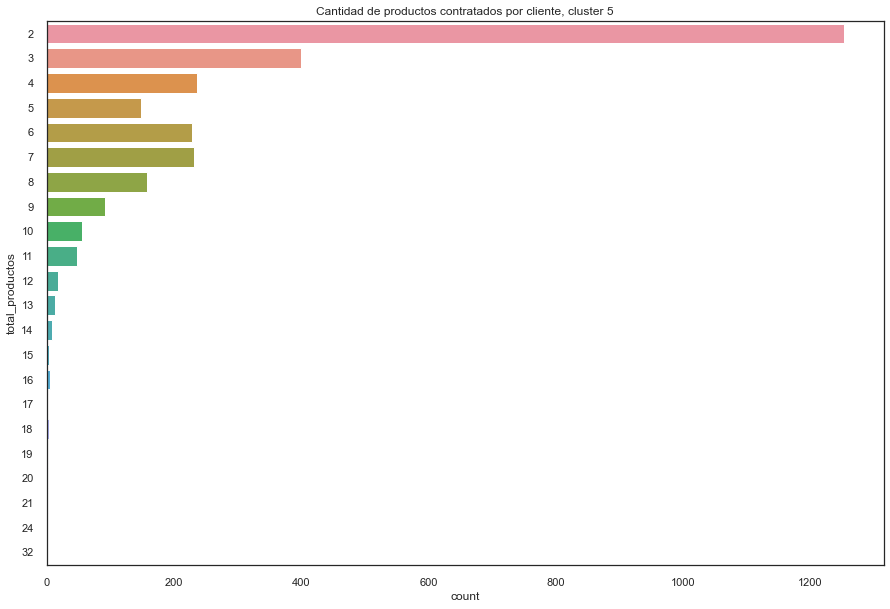

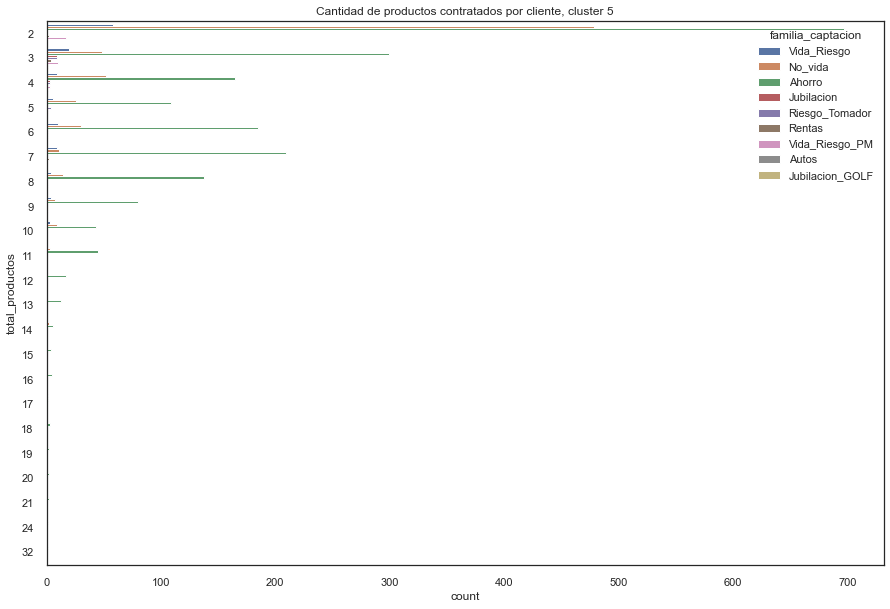

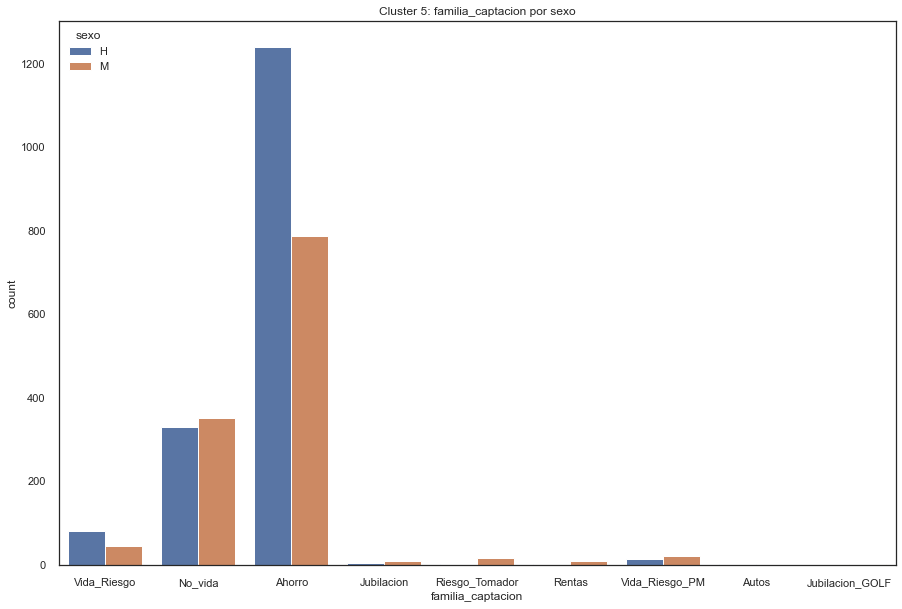

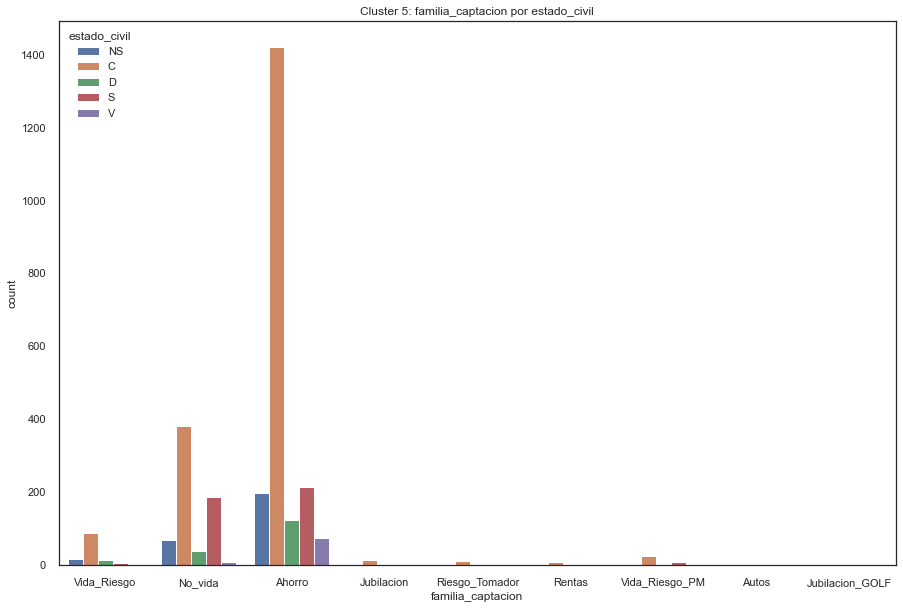

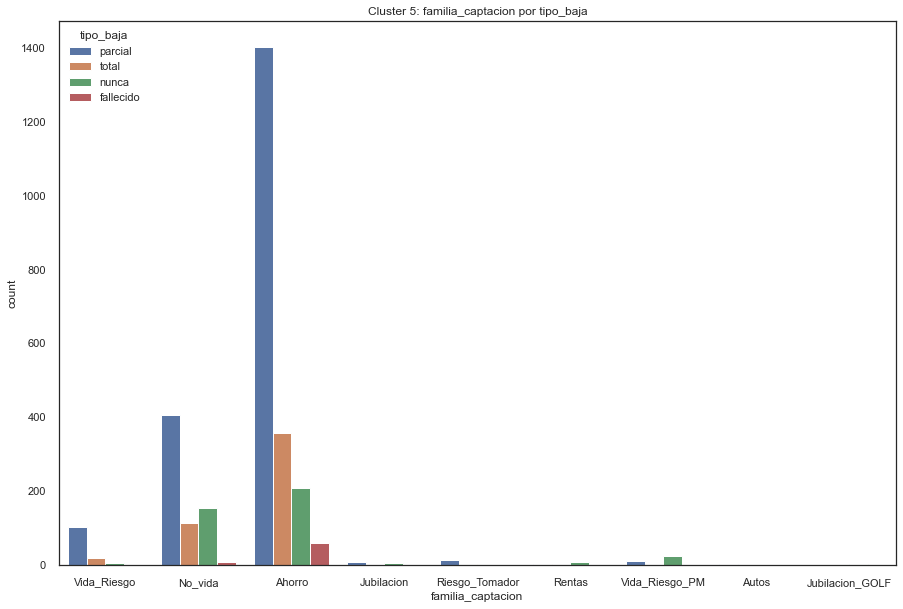

In [240]:
plot_productos_x_cluster(g1_c, 5)
plot_total_productos_x_cluster(g1_c, 5)
plot_total_productos_x_cluster(g1_c, 5, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g1_c, 5,'familia_captacion', e, save=False)

El perfil de este cluster suele ser un hombre casado que contrata entre 2-3 productos combinados en la mayoría de casos Ahorro junto a No vida, presenta una marcada volatilidad a permanecer con los productos.

#### Kmeans G2

##### Kmeans MinMaxScaler

In [194]:
x2 = g2.drop(['id_cliente','total_productos'],axis=1)
mm = MinMaxScaler()
x2_mm = pd.DataFrame(mm.fit_transform(x2), columns=x2.columns)

In [195]:
kmeans_per_k_x2 = [KMeans(n_clusters=k,random_state=42).fit(x2_mm) for k in tqdm(range(2,15))]
inertias_x2 = [model.inertia_ for model in tqdm(kmeans_per_k_x2)]
silhouette_scores_mm_x2 = [silhouette_score(x2_mm, model.labels_) for model in tqdm(kmeans_per_k_x2)]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

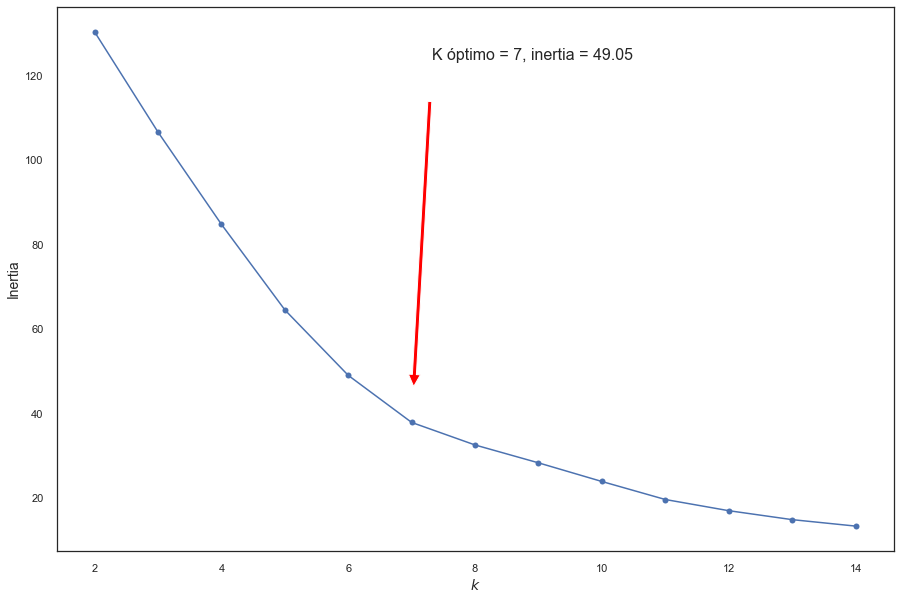

In [198]:
plot_elbow(inertias_x2, end=15,annot=True,save=False)

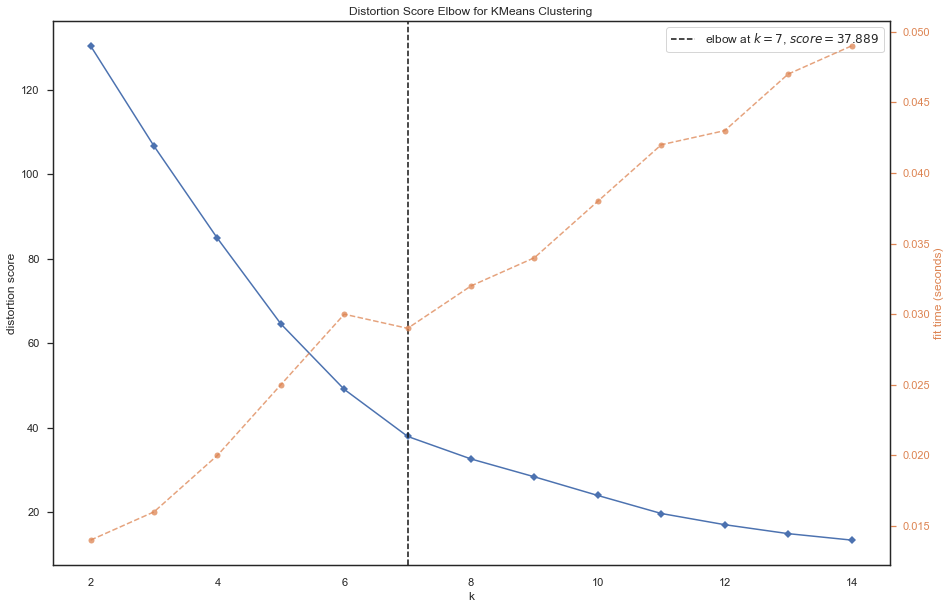

In [199]:
plot_KElbowVisualizer(x2_mm)

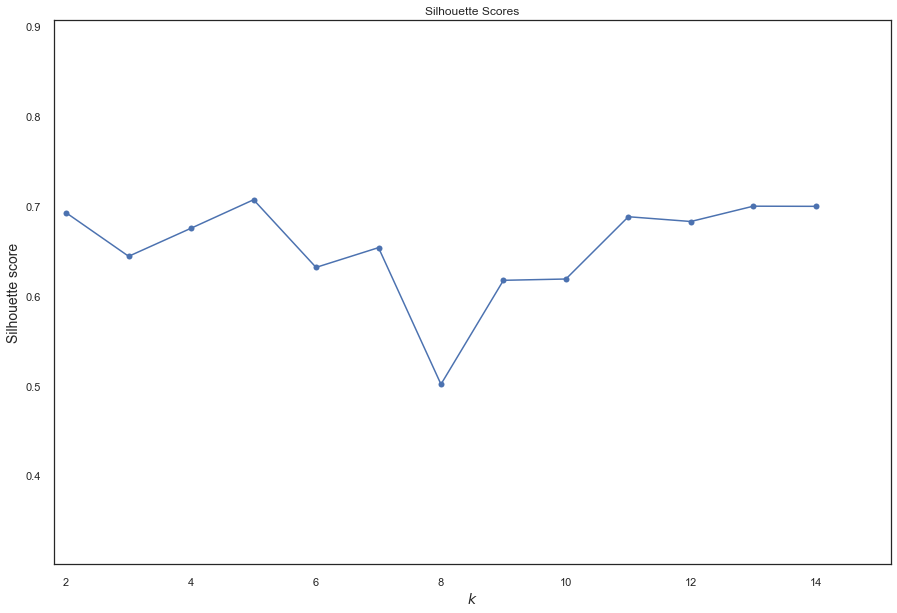

In [201]:
plot_silhouette_scores(silhouette_scores_mm_x2, end=15,save=False)

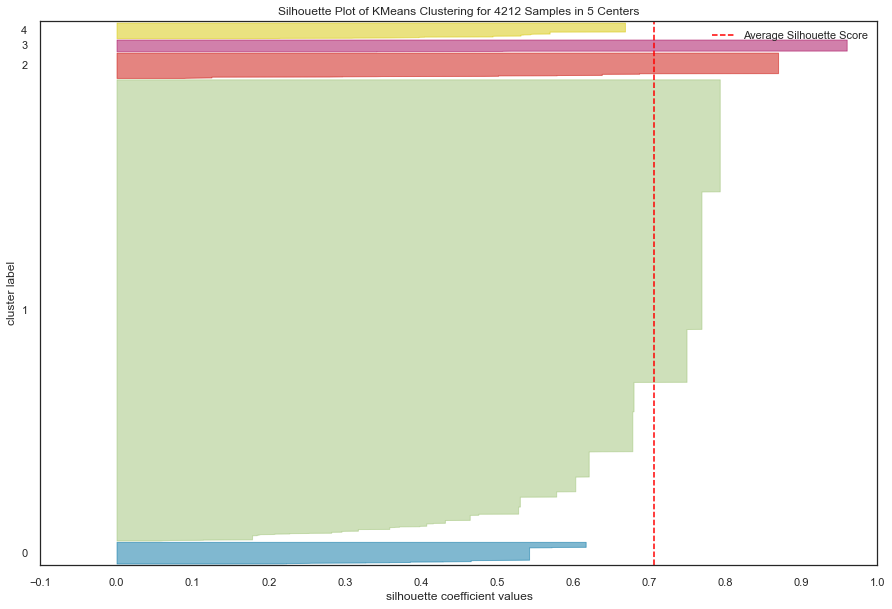

In [202]:
plot_silhouette_visualizer(x2_mm,5)

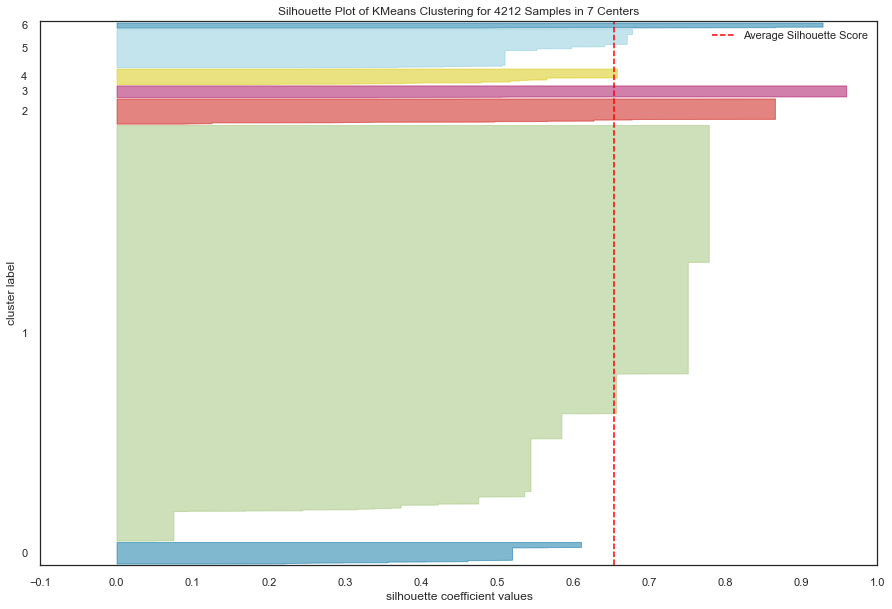

In [203]:
plot_silhouette_visualizer(x2_mm,7)

In [204]:
kmeans_k7 = KMeans(n_clusters=7, random_state=42).fit(x2_mm)
y_pred = kmeans_k7.predict(x2_mm)

In [205]:
x2_umap=get_umap(x2_mm,2)
x2_umap['cluster'] = y_pred

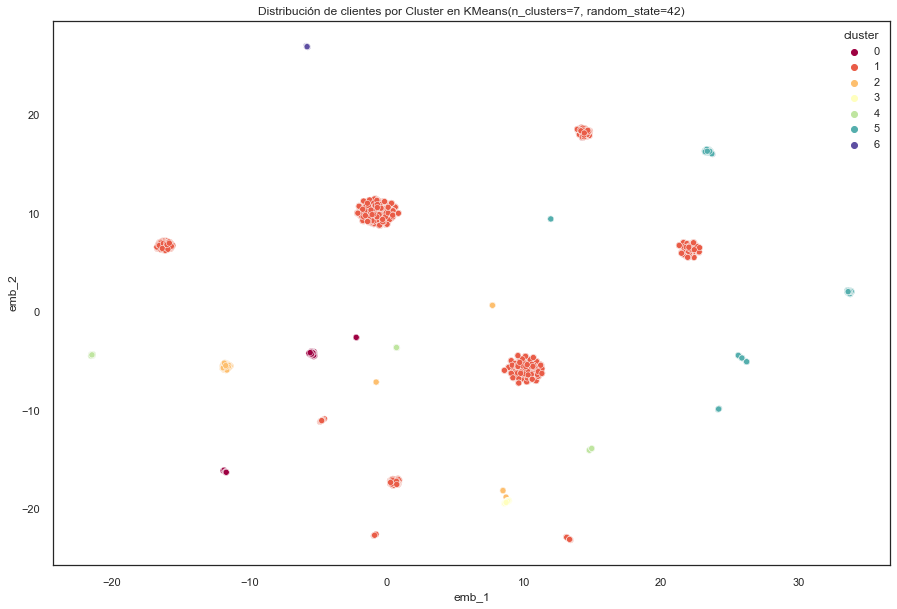

In [206]:
plot_clusters(x2_umap, kmeans_k7, centroids=False ,save=False)

##### Kmeans MinMaxScaler + UMAP

In [207]:
x2_umap = x2_umap.drop('cluster', axis=1)
g2_mm_umap = MinMaxScaler()
x2_umap_mm = g2_mm_umap.fit_transform(x2_umap)

In [208]:
kmeans_per_k_umap_x2 = [KMeans(n_clusters=k,random_state=42).fit(x2_umap_mm) for k in tqdm(range(2,15))]
inertias_umap_x2 = [model.inertia_ for model in tqdm(kmeans_per_k_umap_x2)]
silhouette_scores_mm_x2 = [silhouette_score(x2_umap_mm, model.labels_) for model in tqdm(kmeans_per_k_umap_x2)]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Introduce un nombre para el grafico MM_Elbow_Kmeans_UMAP_G2


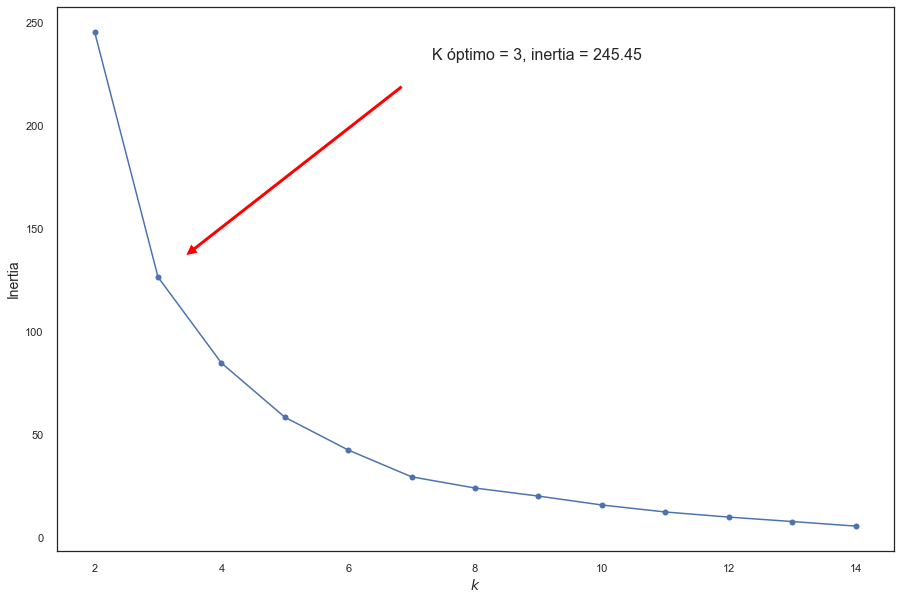

In [209]:
plot_elbow(inertias_umap_x2, annot=True, end=15,save=True)

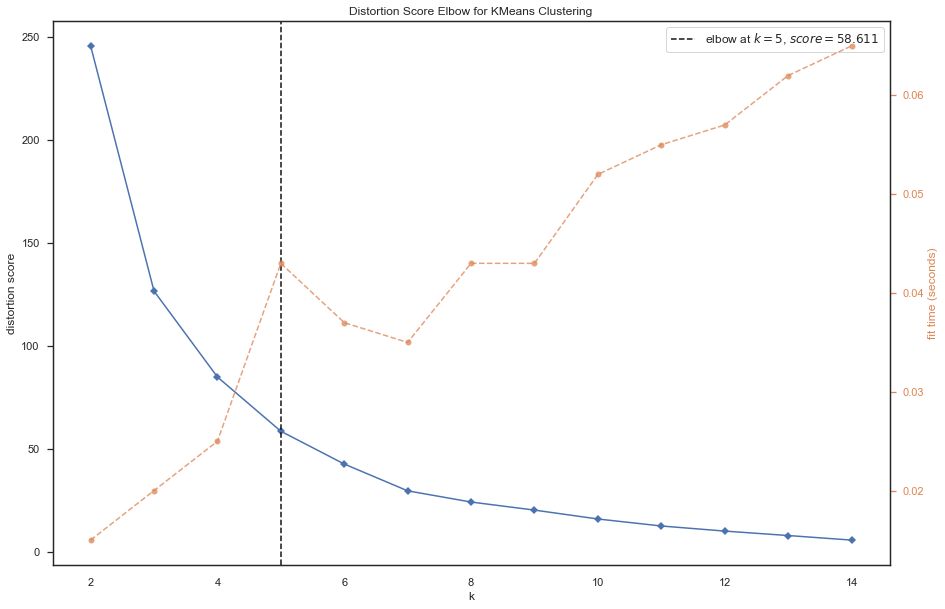

In [210]:
plot_KElbowVisualizer(x2_umap_mm)

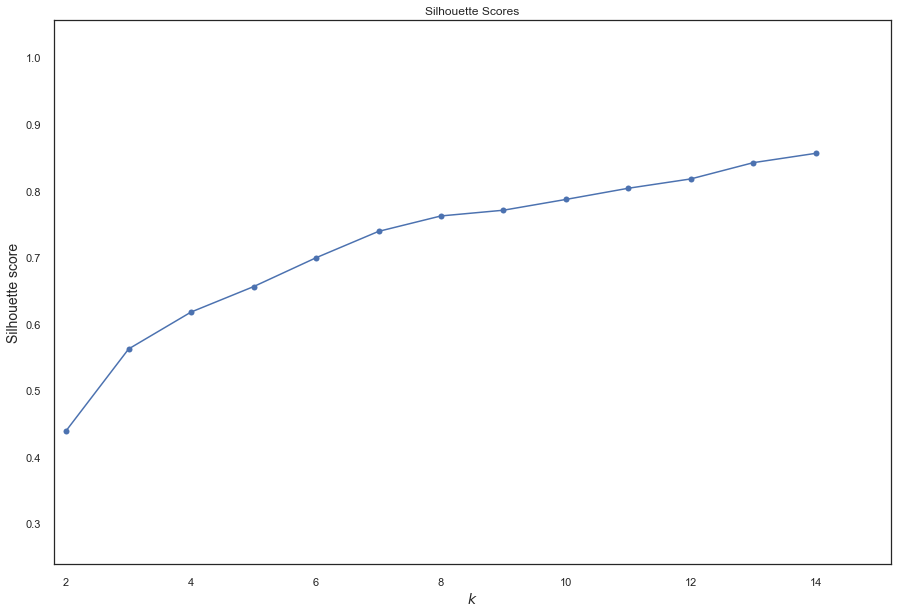

In [211]:
plot_silhouette_scores(silhouette_scores_mm_x2, end=15, save=False)

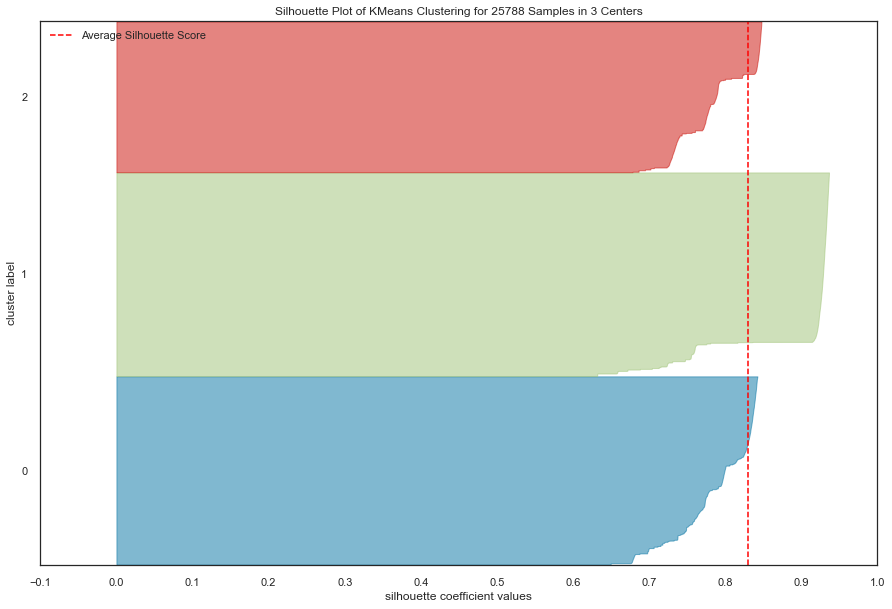

In [233]:
plot_silhouette_visualizer(x1_umap_mm,3)

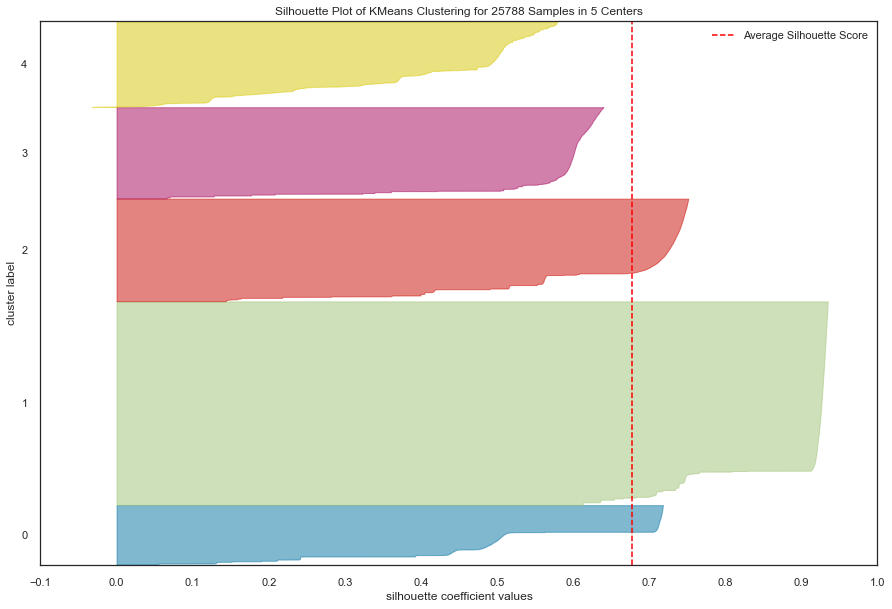

In [212]:
plot_silhouette_visualizer(x1_umap_mm,5)

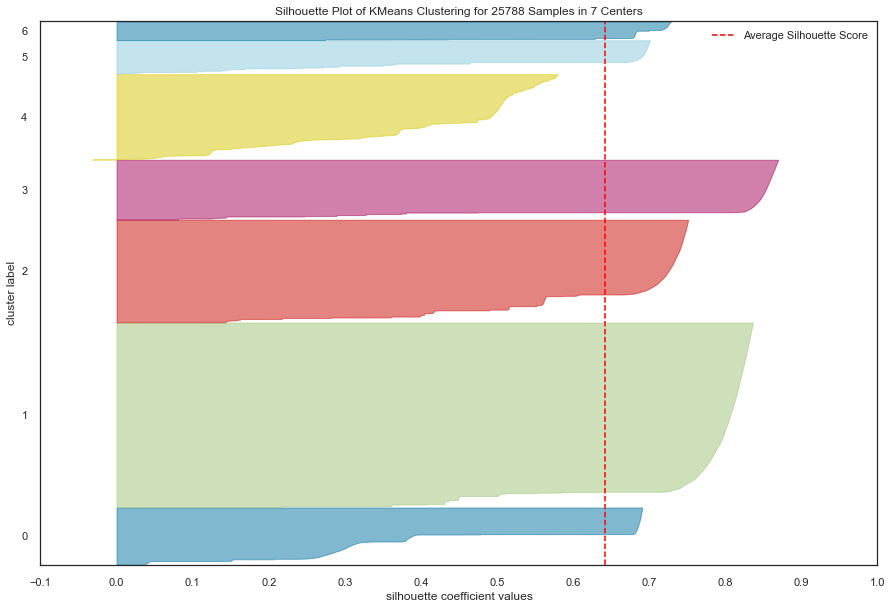

In [213]:
plot_silhouette_visualizer(x1_umap_mm,7)

In [234]:
x2_umap_mm = pd.DataFrame(x2_umap_mm, columns=x2_umap.columns)

In [235]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42).fit(x2_umap_mm)
y_pred = kmeans_k3.predict(x2_umap_mm)
x2_umap_mm['cluster'] = y_pred

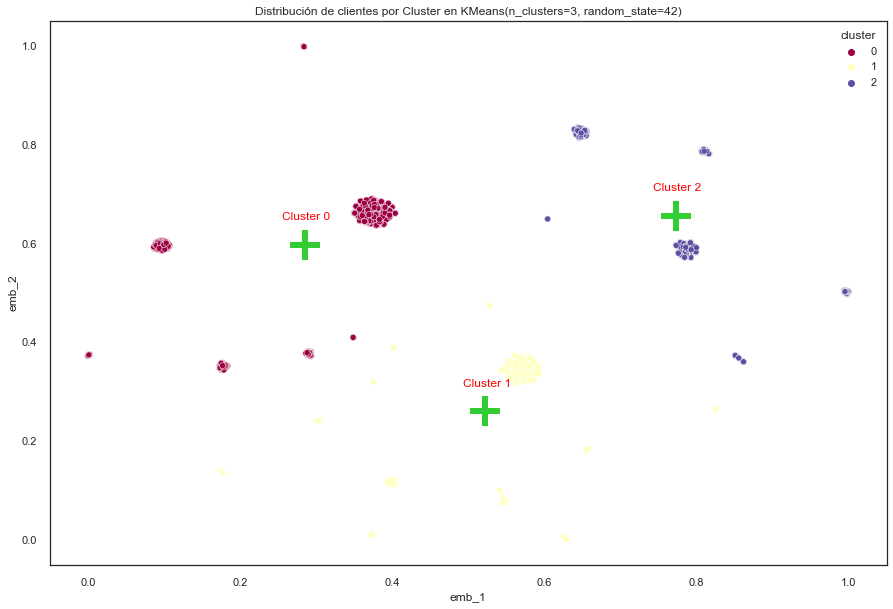

In [236]:
plot_clusters(x2_umap_mm, kmeans_k3, centroids=True ,save=False)

In [ ]:
x2_umap_mm = pd.DataFrame(x2_umap_mm, columns=x2_umap.columns)

In [219]:
kmeans_k5 = KMeans(n_clusters=5, random_state=42).fit(x2_umap_mm)
y_pred = kmeans_k5.predict(x2_umap_mm)
x2_umap_mm['cluster'] = y_pred

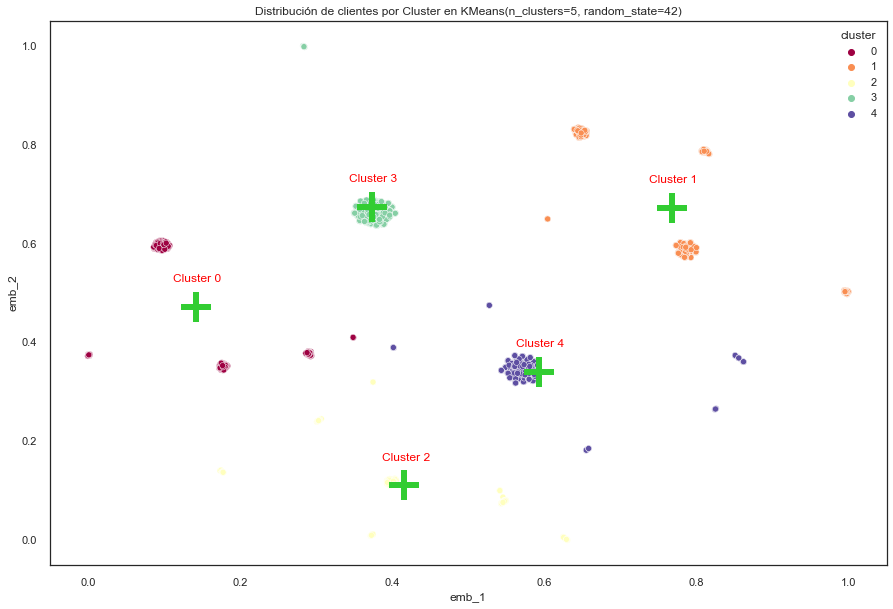

In [220]:
plot_clusters(x2_umap_mm, kmeans_k5, centroids=True ,save=False)

In [340]:
x2_umap_mm = pd.DataFrame(x2_umap_mm, columns=x2_umap.columns)

In [341]:
kmeans_k7 = KMeans(n_clusters=7, random_state=42).fit(x2_umap_mm)
y_pred = kmeans_k7.predict(x2_umap_mm)
x2_umap_mm['cluster'] = y_pred

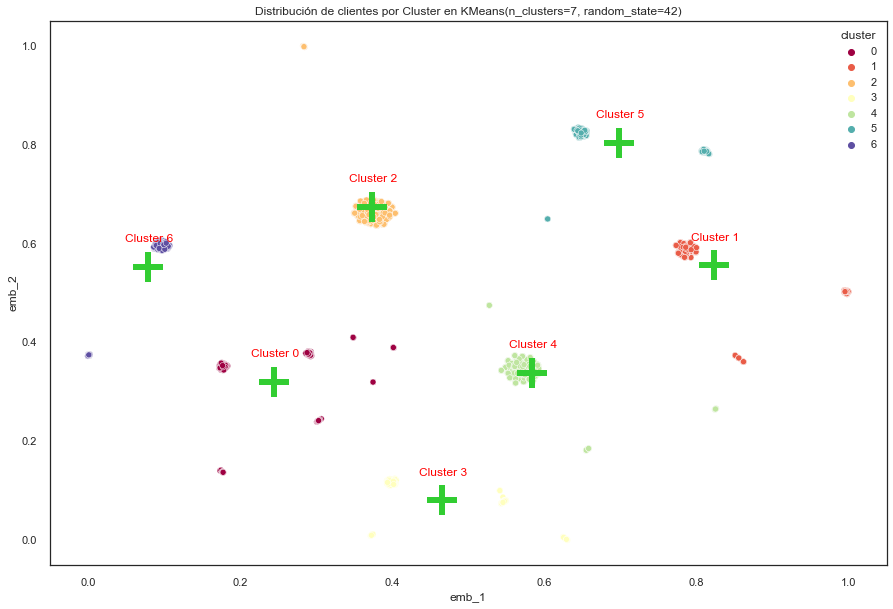

In [342]:
plot_clusters(x2_umap_mm, kmeans_k7, centroids=True ,save=False)

#### Análisis G2

In [343]:
g2_c['cluster'] = y_pred

In [238]:
g2_c[g2_c.cluster == 0]

n_polizas_tomador_ahorro  n_polizas_tomador_autos  \
4                            0                        0   
5                            0                        0   
6                            0                        0   
10                           0                        0   
17                           0                        0   
...                        ...                      ...   
4196                         0                        0   
4201                         0                        0   
4205                         0                        0   
4206                         0                        0   
4207                         0                        0   

      n_polizas_tomador_jubilacion  n_polizas_tomador_jubilacion_golf  \
4                                0                                  0   
5                                0                                  0   
6                                0                                  0   
10                               0                                  0   
17                               0                                  1   
...                            ...                                ...   
4196                             0                                  0   
4201                             0                                  0   
4205                             0                                  0   
4206                             0                                  0   
4207                             0                                  0   

      n_polizas_tomador_no_vida  n_polizas_tomador_rc  \
4                             0                     0   
5                             0                     0   
6                             0                     0   
10                            0                     0   
17                            0                     0   
...                         ...                   ...   
4196                          0                     0   
4201                          0                     0   
4205                          0                     0   
4206                          0                     0   
4207                          0                     0   

      n_polizas_tomador_rentas  n_polizas_tomador_riesgo_tomador  \
4                            0                                 0   
5                            0                                 0   
6                            0                                 0   
10                           1                                 0   
17                           0                                 0   
...                        ...                               ...   
4196                         0                                 0   
4201                         0                                 0   
4205                         1                                 0   
4206                         0                                 0   
4207                         0                                 0   

      n_polizas_tomador_vida_riesgo  n_polizas_tomador_vida_riesgo_pm  \
4                                 0                                 0   
5                                 0                                 1   
6                                 0                                 1   
10                                0                                 0   
17                                0                                 0   
...                             ...                               ...   
4196                              0                                 0   
4201                              0                                 0   
4205                              0                                 0   
4206                              0                                 1   
4207                              0                                 0   

      total_productos  id_cliente sexo es

##### Cluster 0

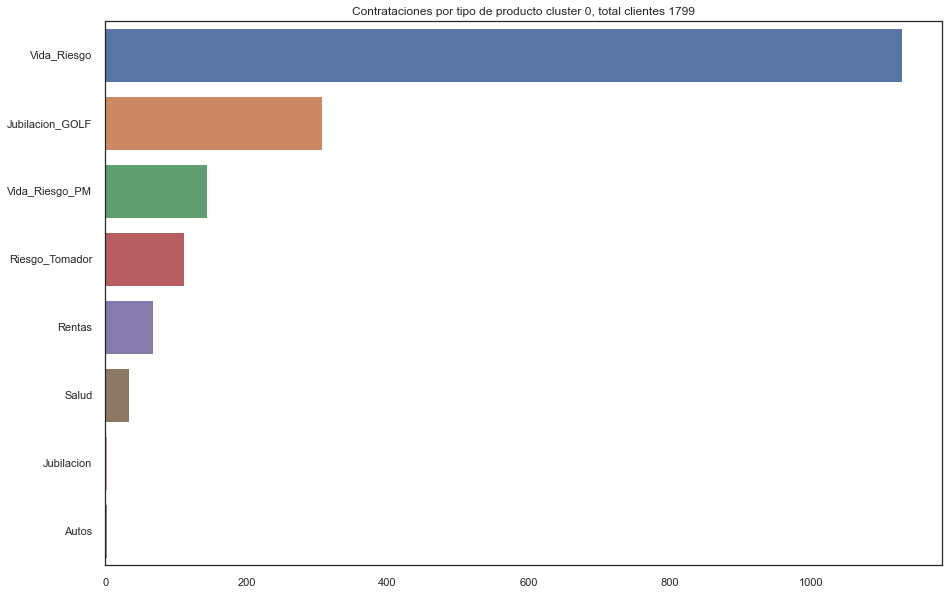

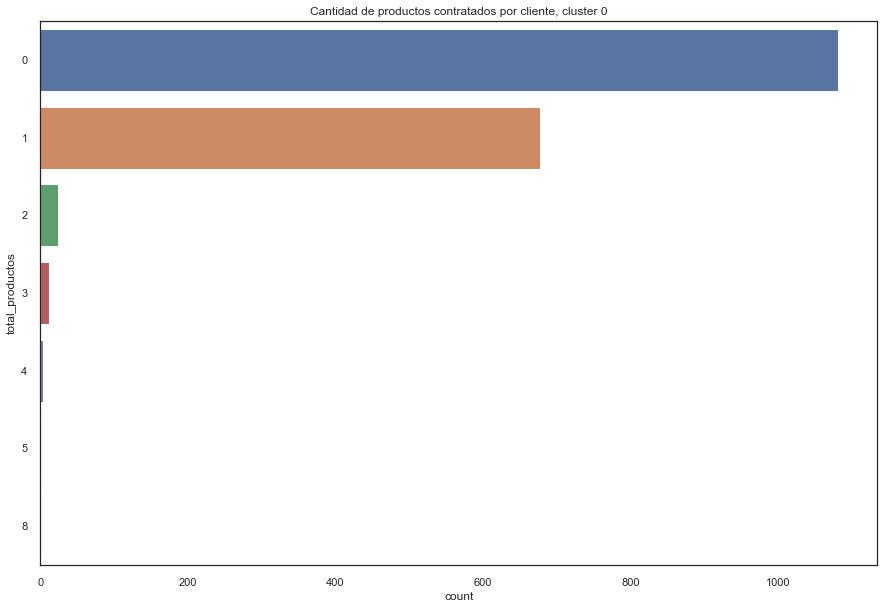

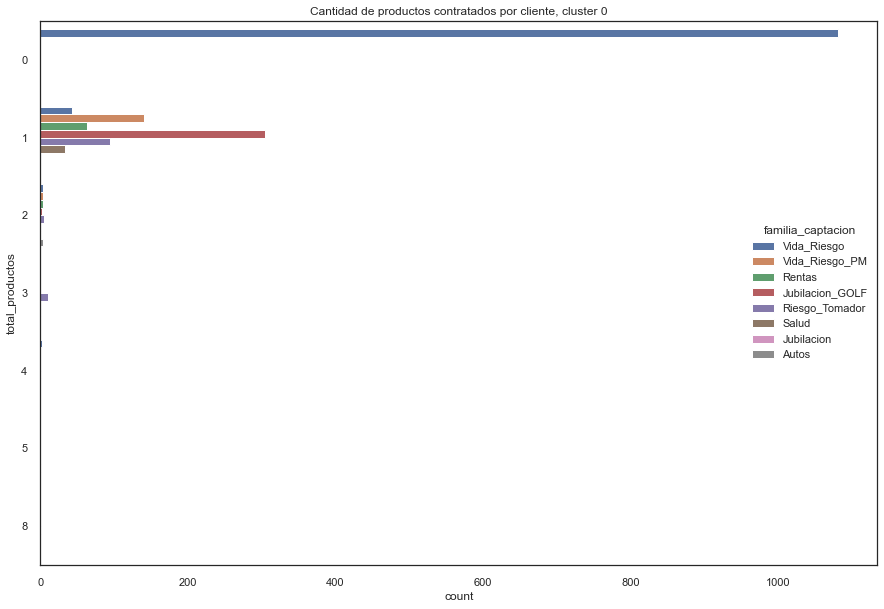

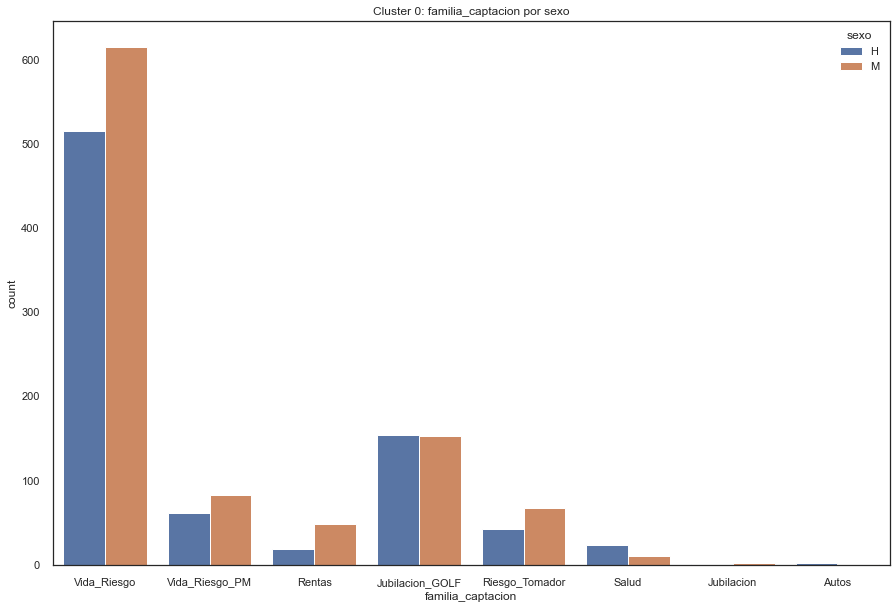

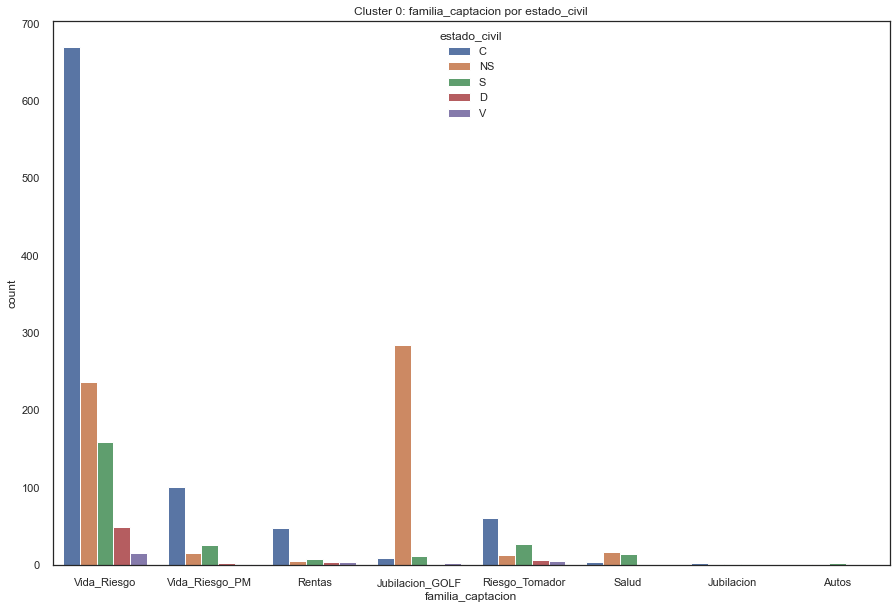

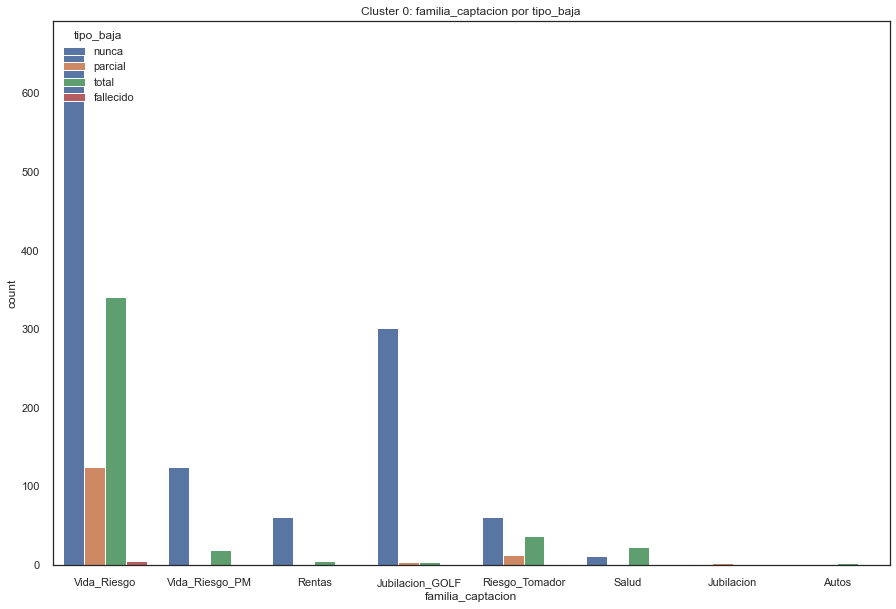

In [239]:
plot_productos_x_cluster(g2_c, 0)
plot_total_productos_x_cluster(g2_c, 0)
plot_total_productos_x_cluster(g2_c, 0, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g2_c, 0,'familia_captacion', e, save=False)
    plt.show();
    

El perfil de este cluster es una mujer casada que no está ya en la empresa, y nunca contratató seguros de vida riesgo, los clientes que si contratan productos dentro de este cluster suelen contratar polizas de jubilación golf, con mucho apego por el producto porque no se suelen dar de baja.

##### Cluster 1

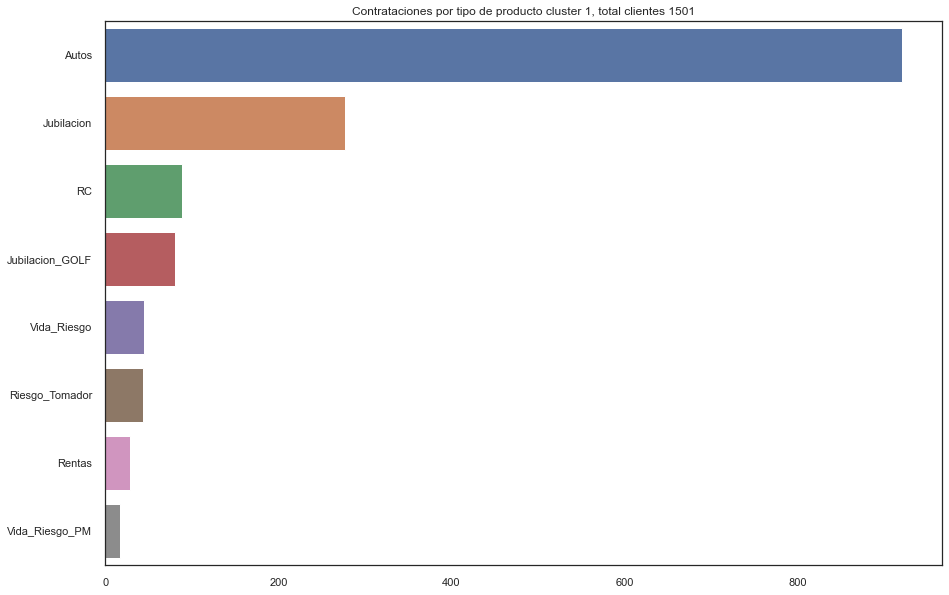

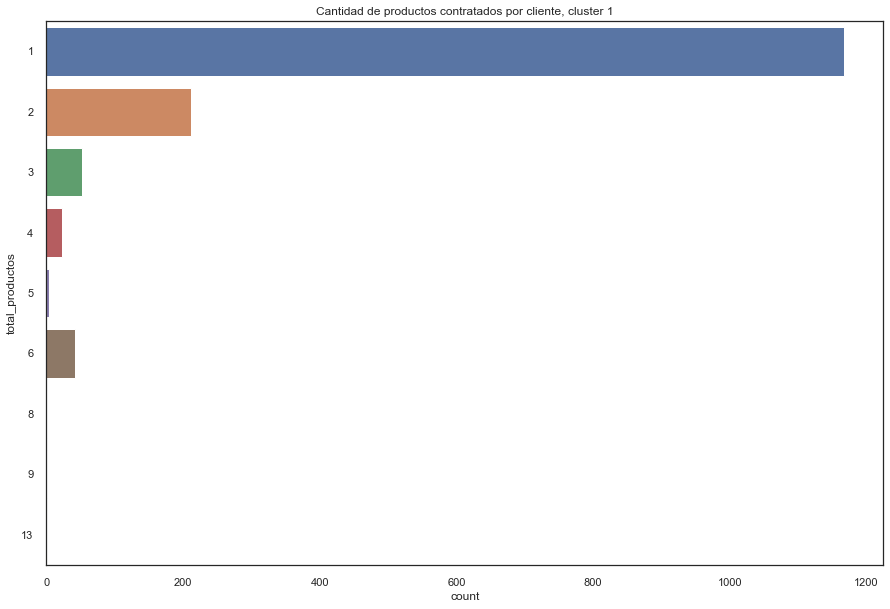

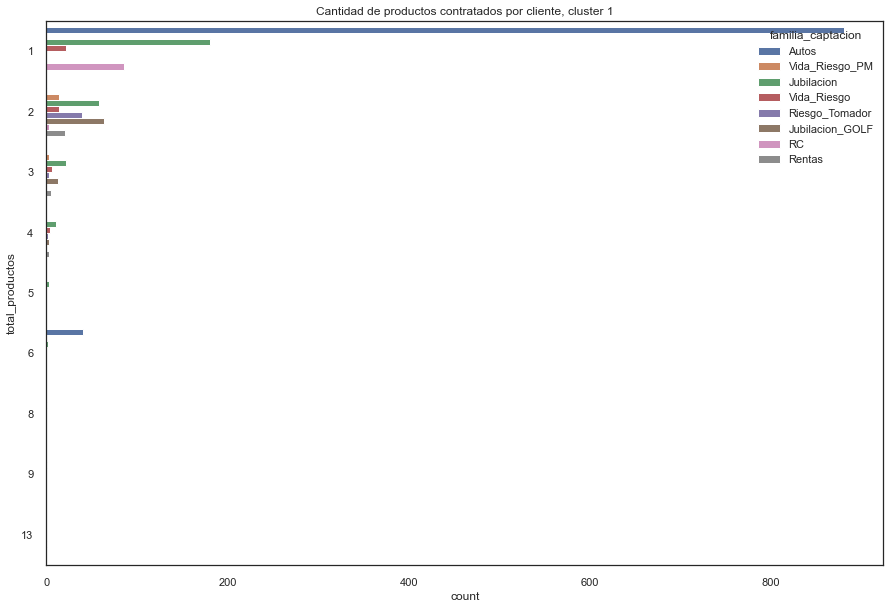

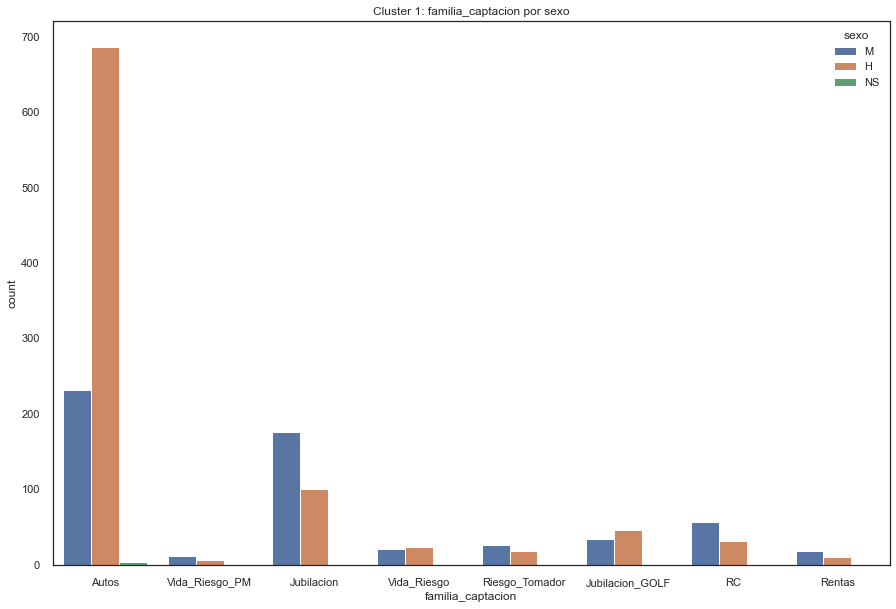

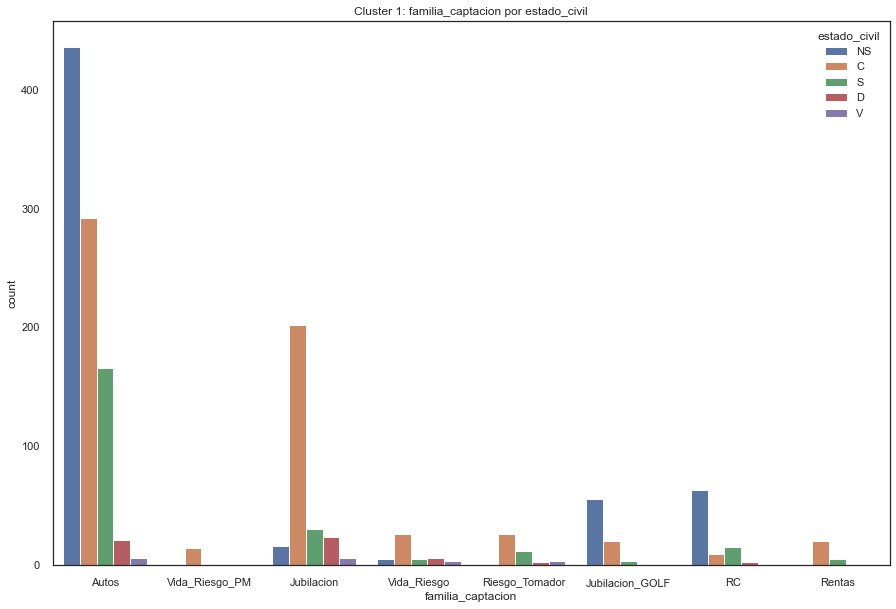

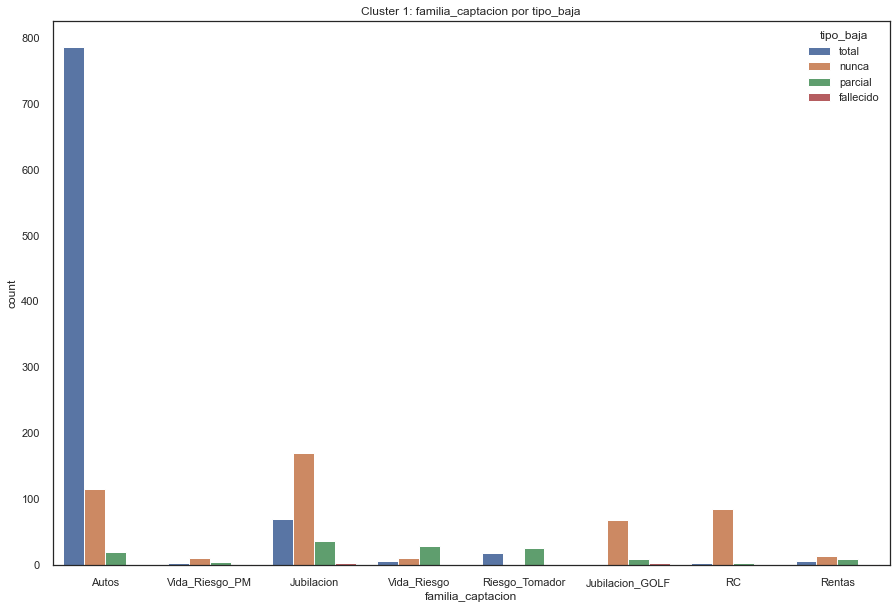

In [253]:
plot_productos_x_cluster(g2_c, 1)
plot_total_productos_x_cluster(g2_c, 1)
plot_total_productos_x_cluster(g2_c, 1, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g2_c, 1,'familia_captacion', e, save=False)

Corregir. El perfil del cluster es un cliente varón con un producto contratado como normal general, casi siempre de Auto que tiene poco apego por el producto porque suele darse de baja con facilidad.

##### Cluster 2


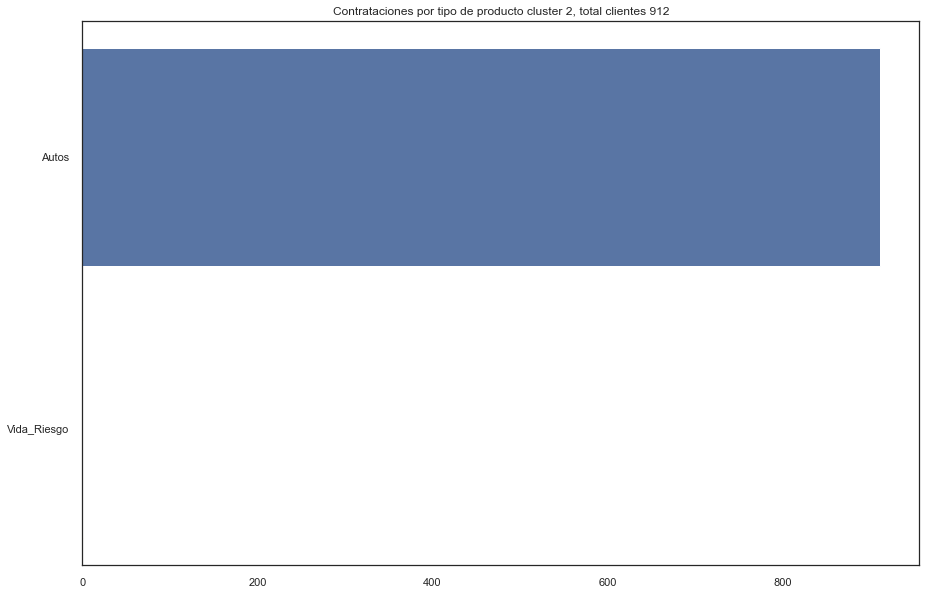

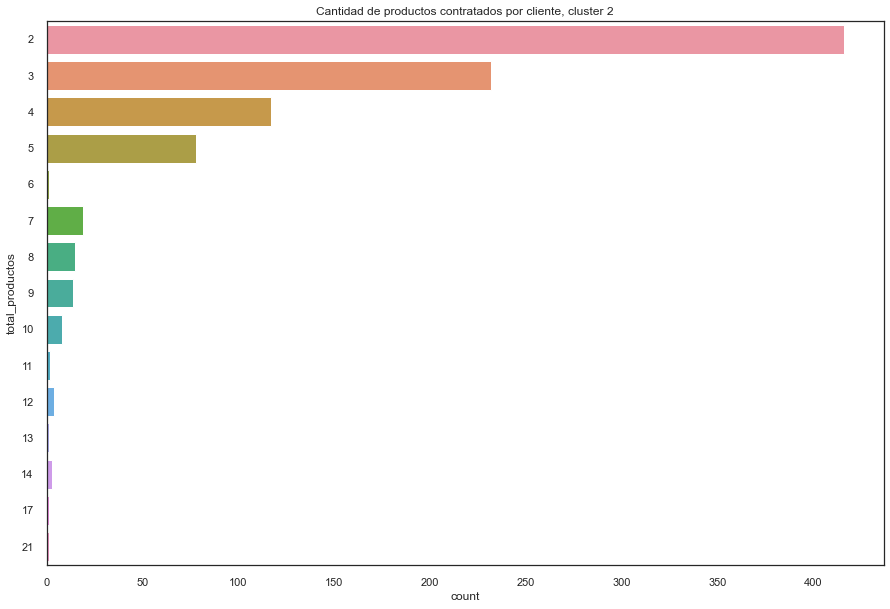

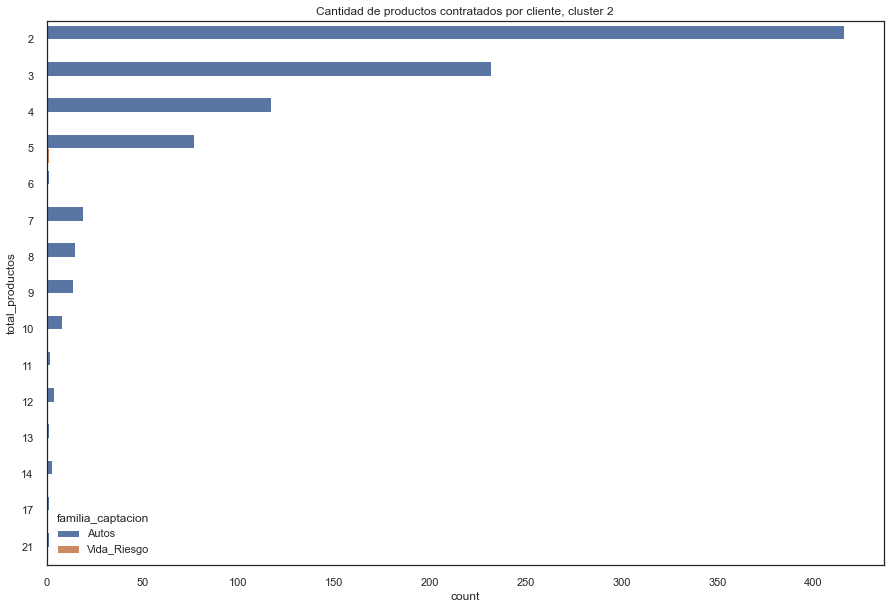

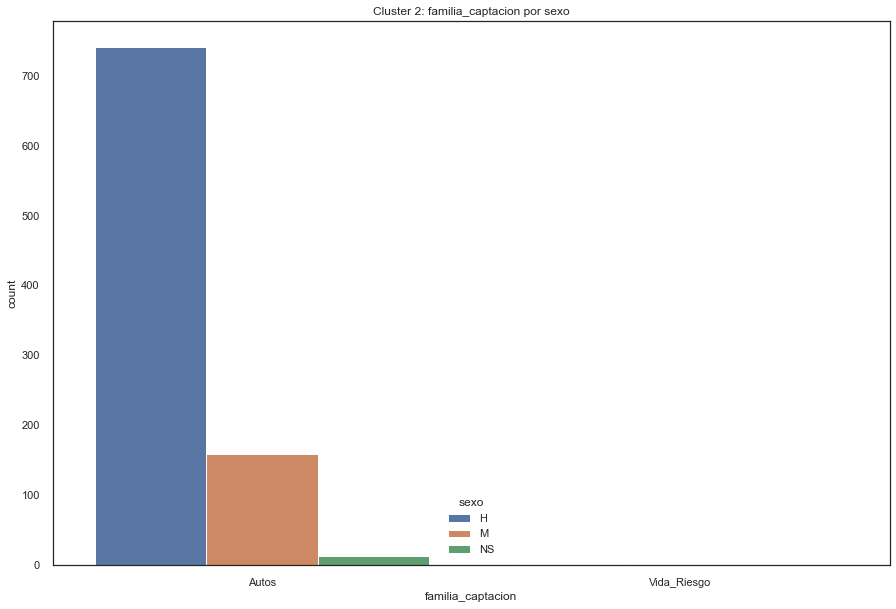

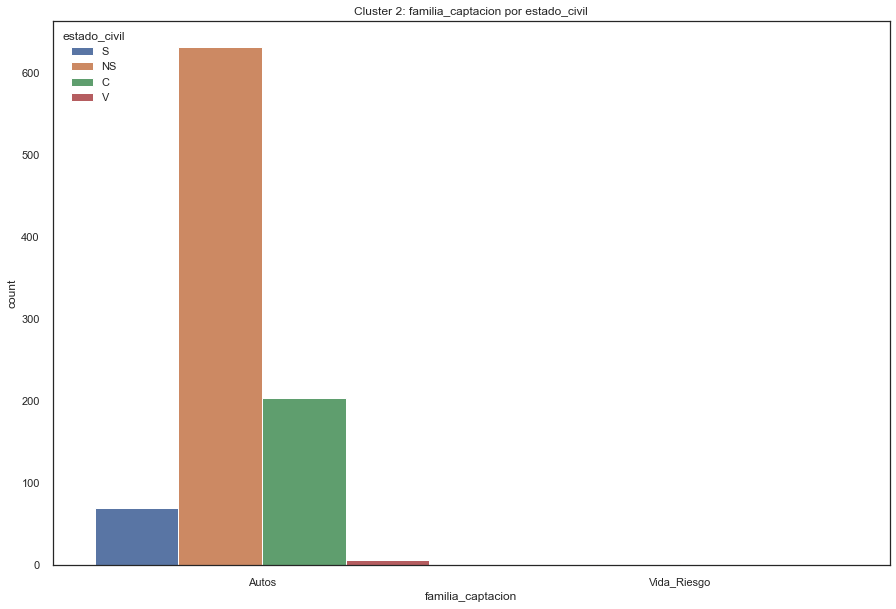

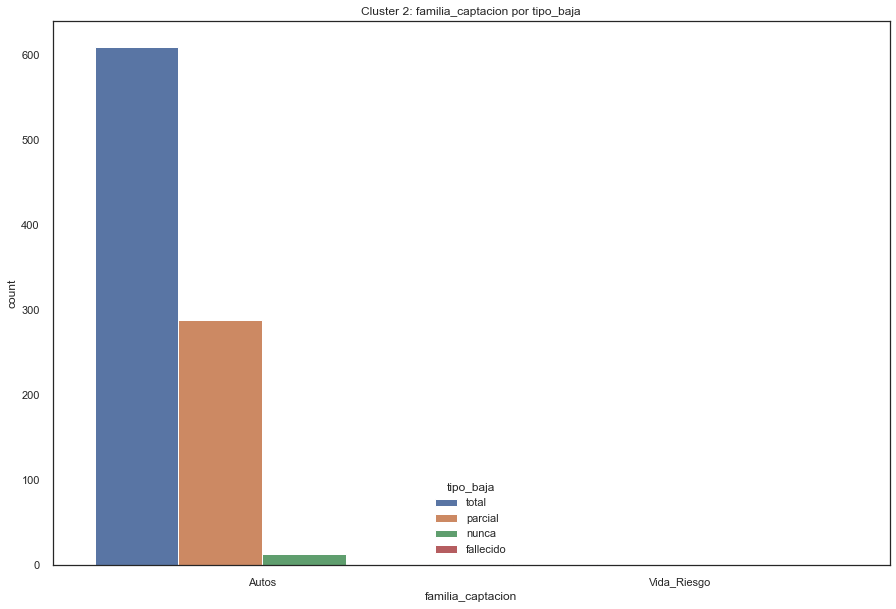

In [254]:
plot_productos_x_cluster(g2_c, 2)
plot_total_productos_x_cluster(g2_c, 2)
plot_total_productos_x_cluster(g2_c, 2, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g2_c, 2,'familia_captacion', e, save=False)

El perfil de este cluster es un varón con varias pólizas de Auto contratadas, y con poco apego por el producto porque suele darse de baja total o parcial de forma asidua.

### DBScan 

Ahora vamos a coger los grupos hechos en el anterior apartado y vamos ha pasalos por el algoritmo de **DBScan** para ver que resultados obtenemos. 

El procedimiento será el mismo que en el anterior, realizaremos experimentos con los datos escalados con `MinMaxScaler` (ya que en los primeros experimentos comprobamos que funcionaba mejor que el `StandarScaler`), luego usaremos **UMAP** para reducir las dimensiones para poder hacer gráficos de dispersión y poder interpretar los resultados, y por último usaremos los embbedings generados con **UMAP** para entrenar otro algoritmo de **DBScan** y realizaremos gráficos de dispersión e interpretaremos los resultados

#### DBScan G1

##### DBScan MinMaxScaler

In [259]:
epsilon_cal = round(np.mean([(max(x1_mm[c])-min(x1_mm[c])) for c in x1_mm.columns])*0.025,3)
samples_min = int(len(x1_mm)*0.025)
dbscan_x1_mm = DBSCAN(eps=epsilon_cal, min_samples=samples_min)
dbscan_x1_mm.fit(x1_mm)
print(dbscan_x1_mm)
dbscan_x1_mm_df = pd.DataFrame(x1_umap_mm)
dbscan_x1_mm_df['cluster']= dbscan_x1_mm.labels_
dbscan_x1_mm_df.cluster.value_counts()

DBSCAN(eps=0.025, min_samples=644)


 0    8031
-1    7634
 2    3542
 4    2491
 1    1259
 5    1039
 6     972
 3     820
Name: cluster, dtype: int64

In [266]:
dbscan_x1_mm_df.head()

emb_1     emb_2  cluster
0  0.341892  0.695235        0
1  0.351465  0.700795        0
2  0.600697  0.286439       -1
3  0.364353  0.745863        0
4  0.342243  0.676933        0

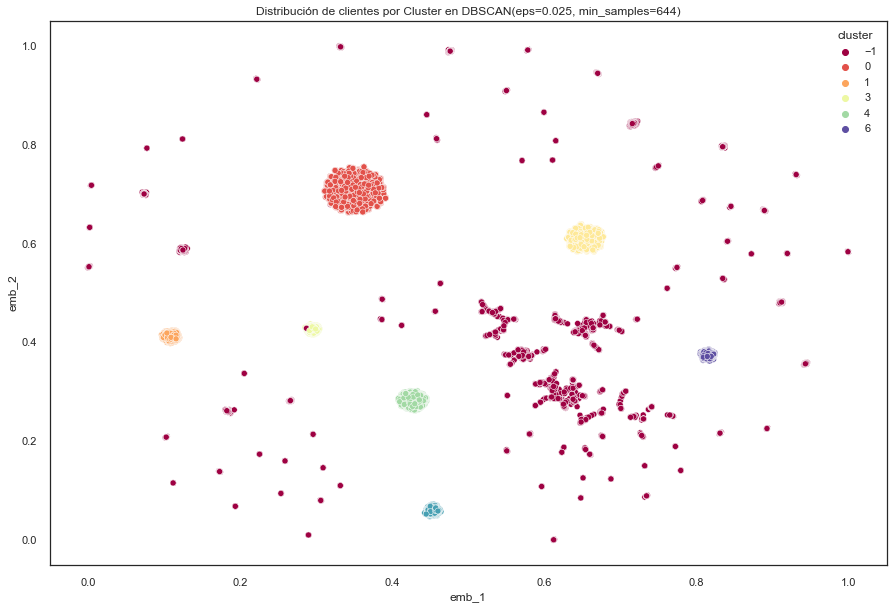

In [267]:
plot_clusters(dbscan_x1_mm_df, dbscan_x1_mm, centroids=False,save=False)

##### DBScan MinManScaler + UMAP

In [279]:
x1_unmap_mm.head()

emb_1     emb_2
0  0.341892  0.695235
1  0.351465  0.700795
2  0.600697  0.286439
3  0.364353  0.745863
4  0.342243  0.676933

In [282]:
epsilon_cal = round(np.mean([(max(x1_umap_mm[c])-min(x1_umap_mm[c])) for c in x1_umap_mm.columns])*0.5,3)
samples_min = int(len(x1_umap_mm)*0.025)
dbscan_x1_umap_mm = DBSCAN(eps=epsilon_cal, min_samples=samples_min)
dbscan_x1_umap_mm.fit(x1_umap_mm)
print(dbscan_x1_umap_mm)
dbscan_x1_umap_mm_df = pd.DataFrame(x1_umap_mm)
dbscan_x1_umap_mm_df['cluster']= dbscan_x1_umap_mm.labels_
dbscan_x1_umap_mm_df.cluster.value_counts()

DBSCAN(eps=0.667, min_samples=644)


0    8053
4    5704
3    3556
6    2497
1    1874
2    1267
7    1040
8     974
5     823
Name: cluster, dtype: int64

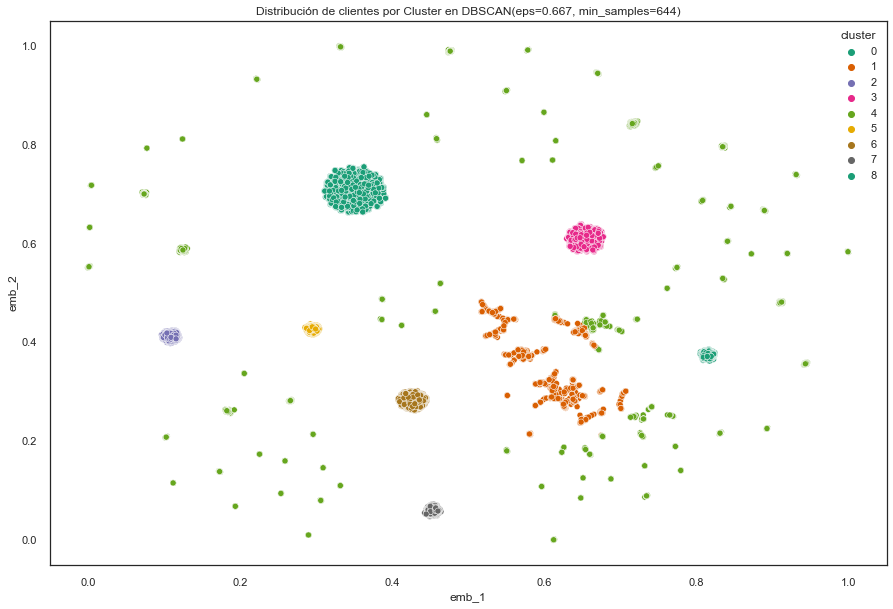

In [283]:
plot_clusters(dbscan_x1_umap_mm_df, dbscan_x1_umap_mm, palette='Dark2' ,centroids=False,save=False)

#### Análisis DBScan G1

In [284]:
g1_c['cluster']= dbscan_x1_umap_mm.labels_

##### Cluster 0

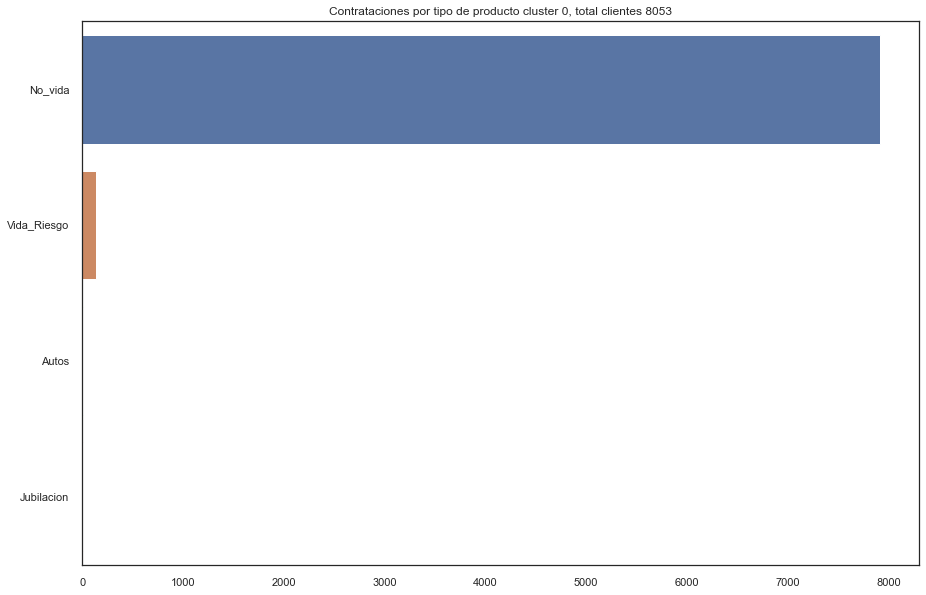

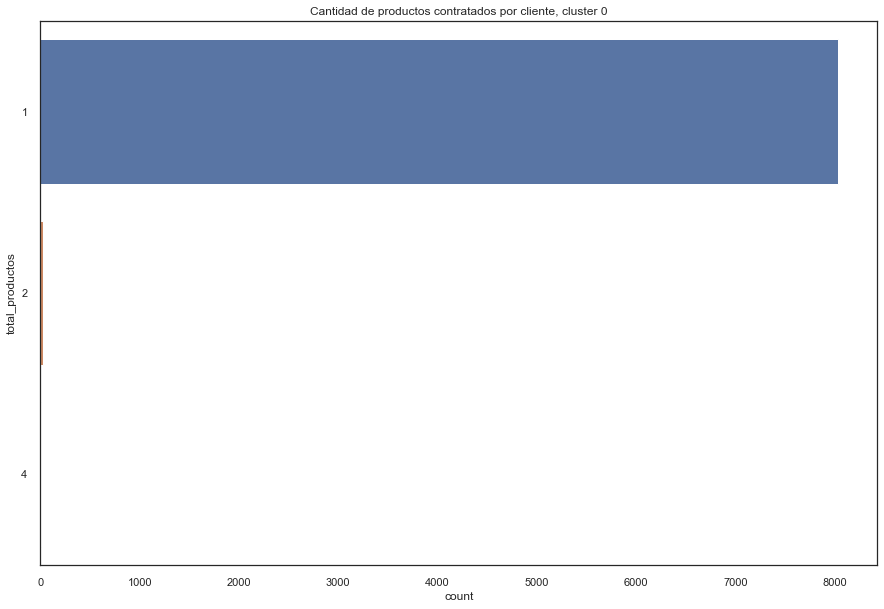

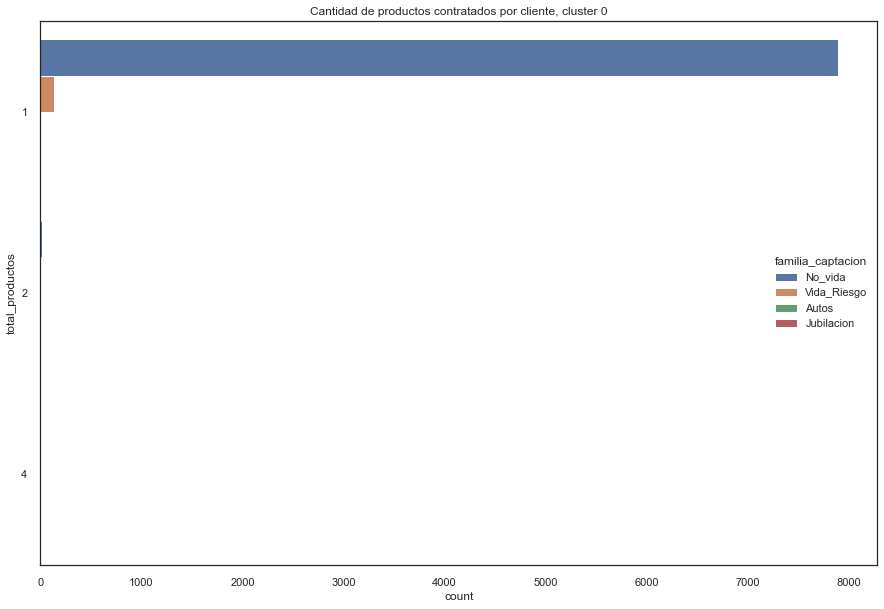

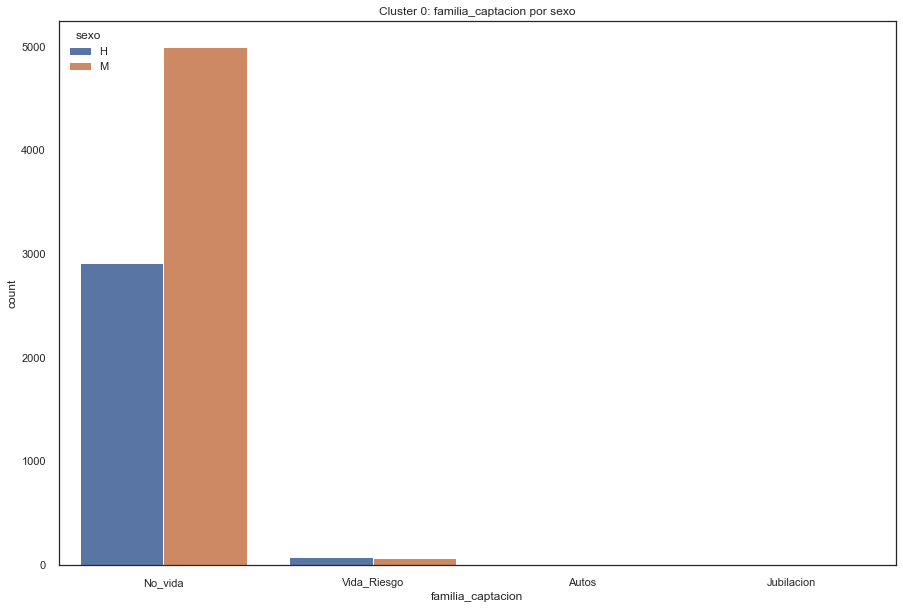

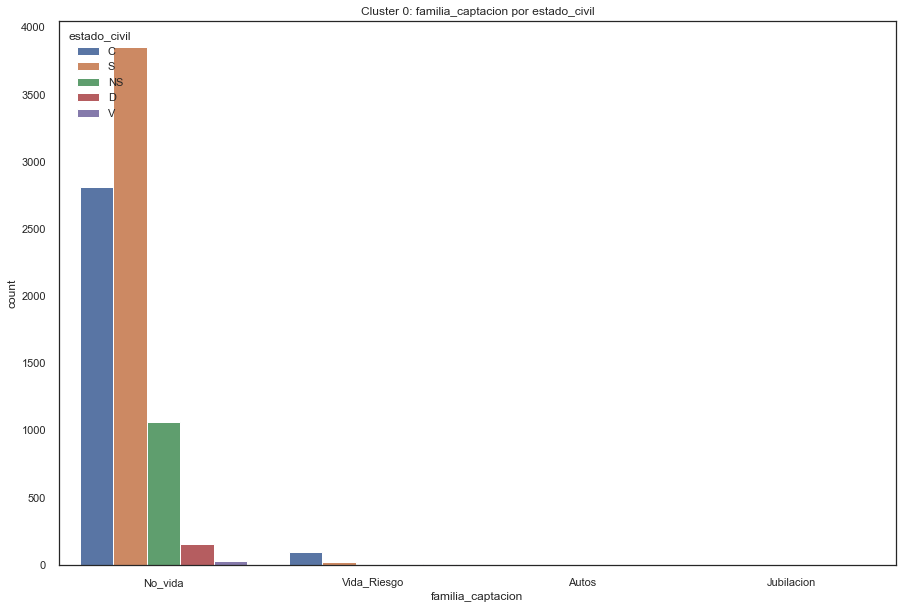

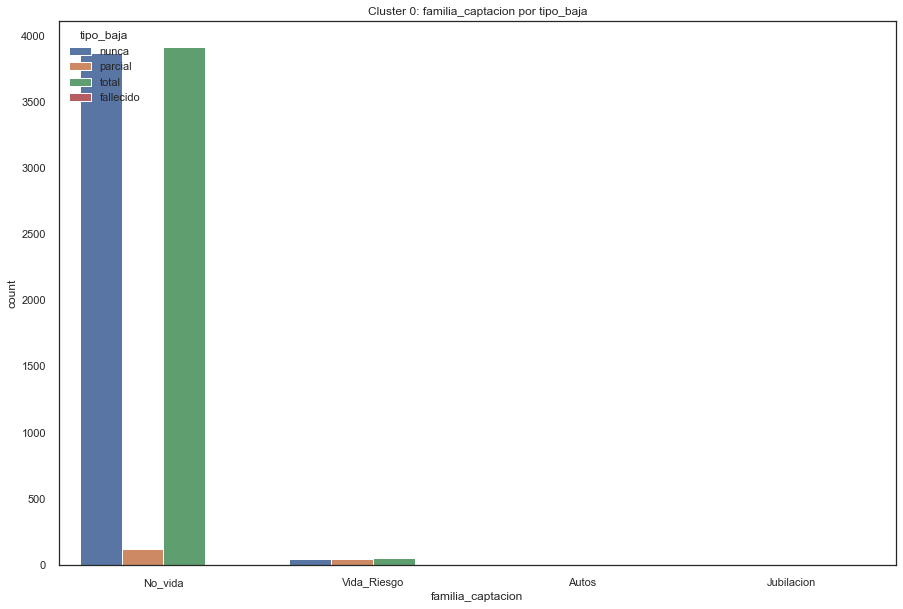

In [315]:
plot_productos_x_cluster(g1_c, 0)
plot_total_productos_x_cluster(g1_c, 0)
plot_total_productos_x_cluster(g1_c, 0, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g1_c, 0,'familia_captacion', e, save=False)
    plt.show();

##### Cluster 1

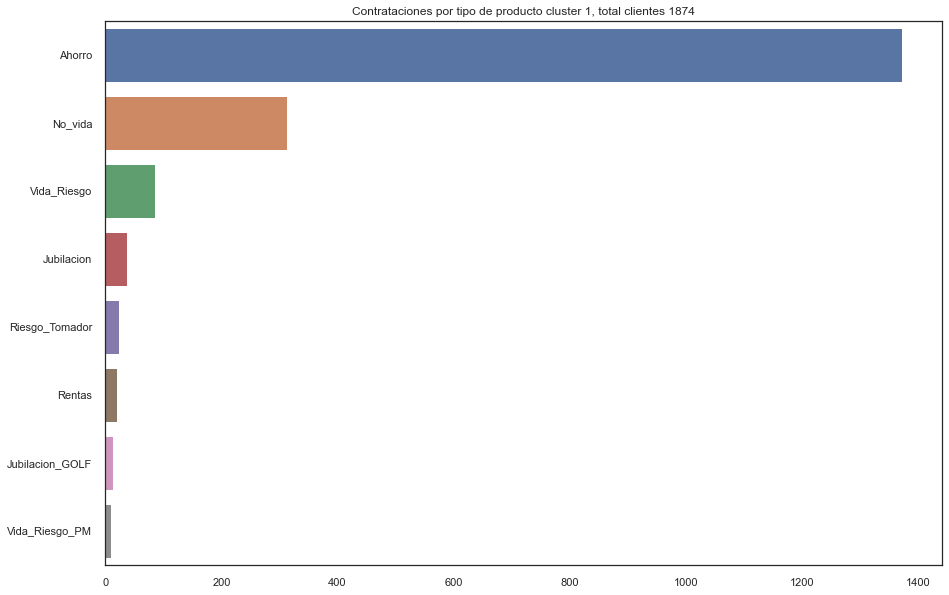

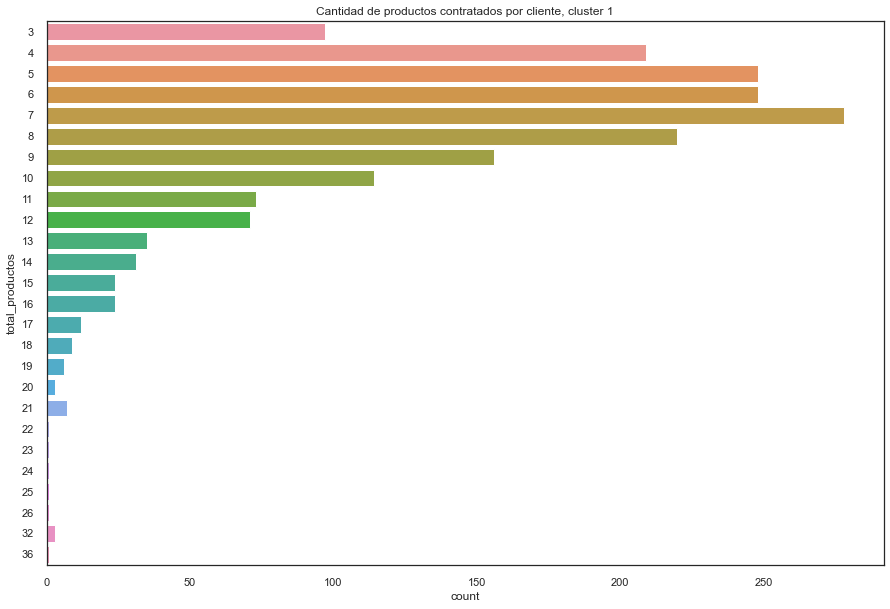

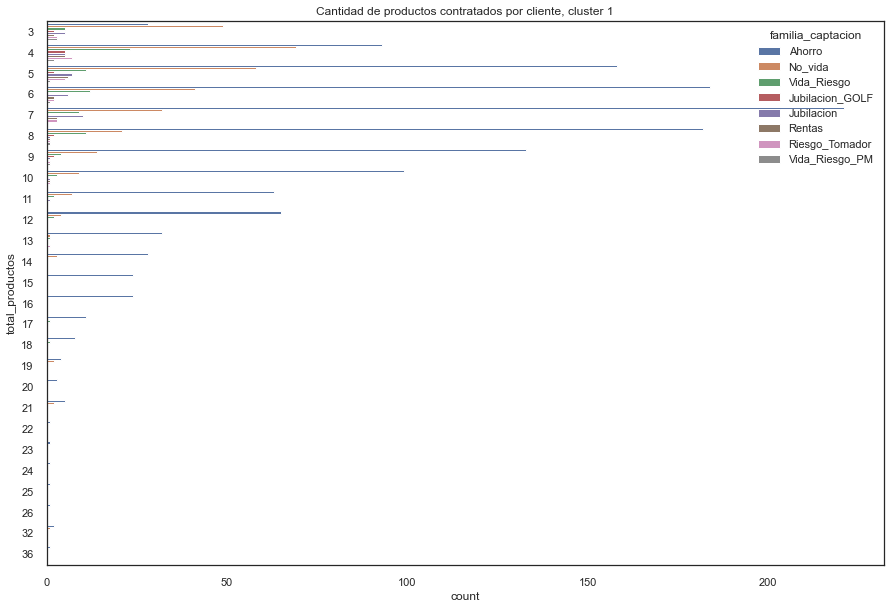

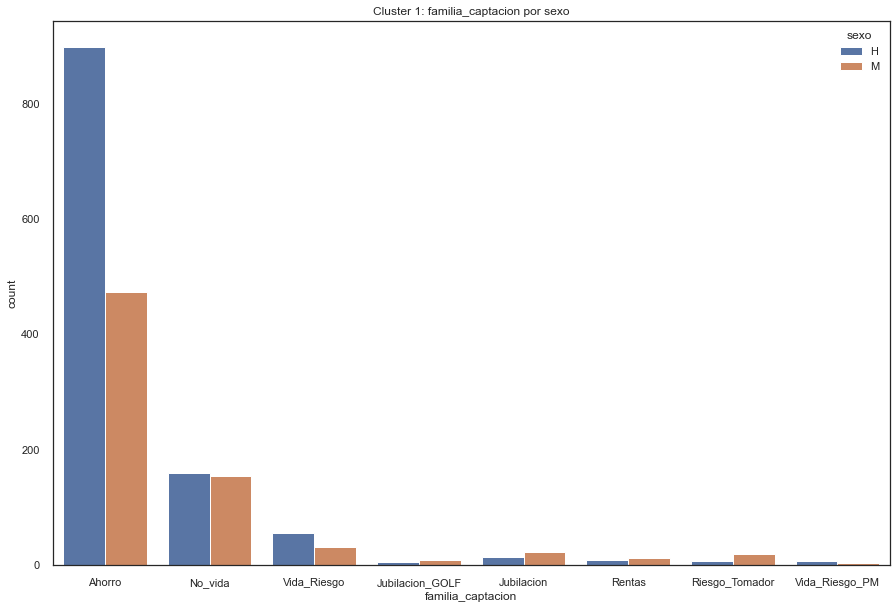

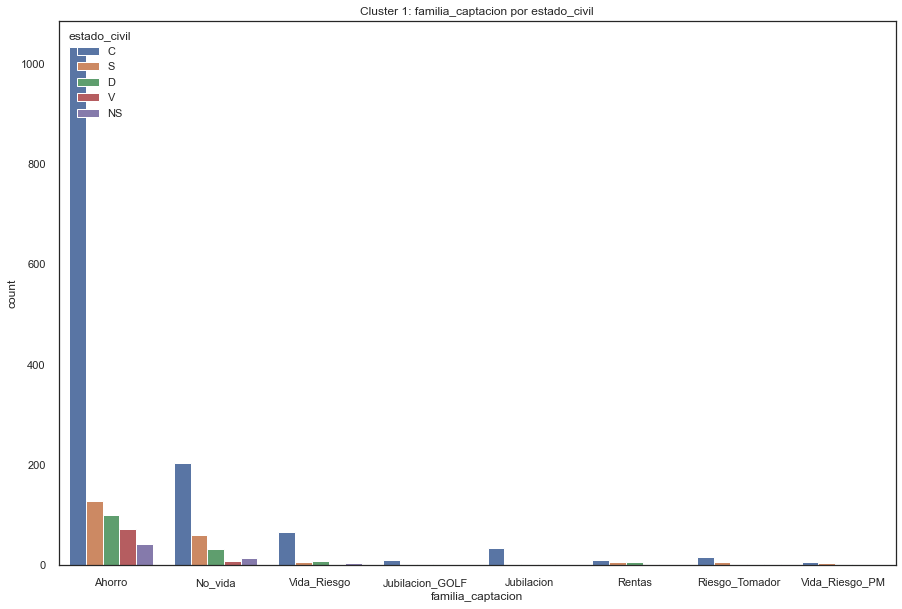

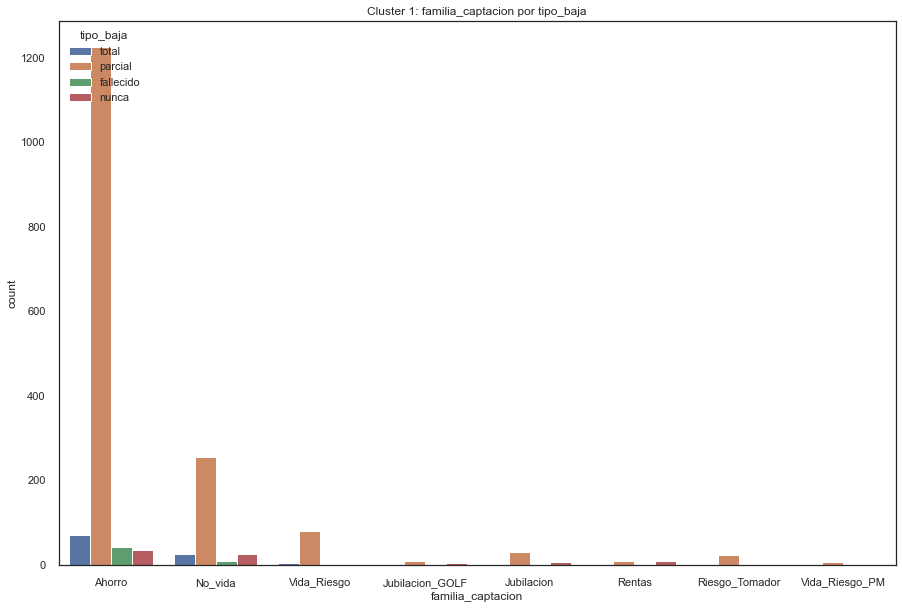

In [316]:
plot_productos_x_cluster(g1_c, 1)
plot_total_productos_x_cluster(g1_c, 1)
plot_total_productos_x_cluster(g1_c, 1, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g1_c, 1,'familia_captacion', e, save=False)
    plt.show();

##### Cluster 2

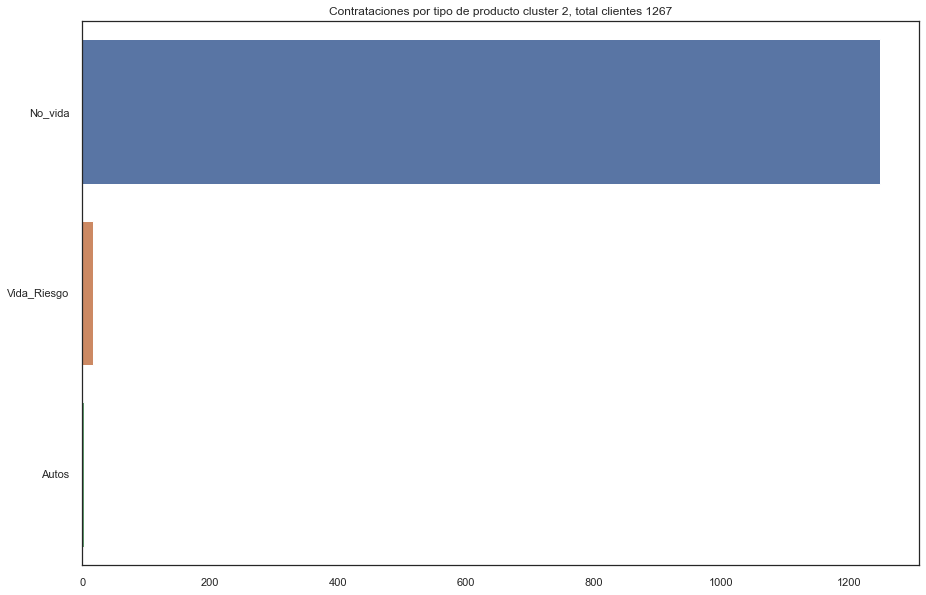

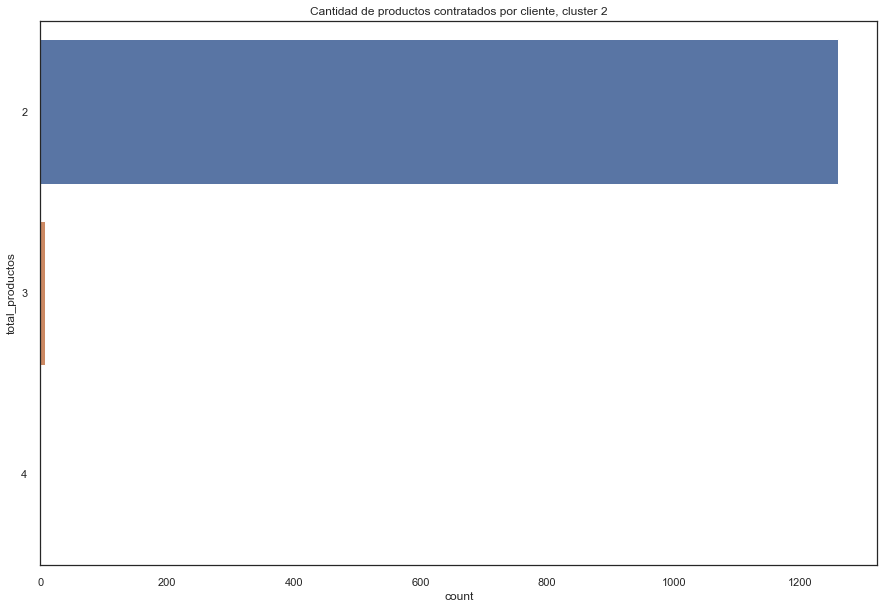

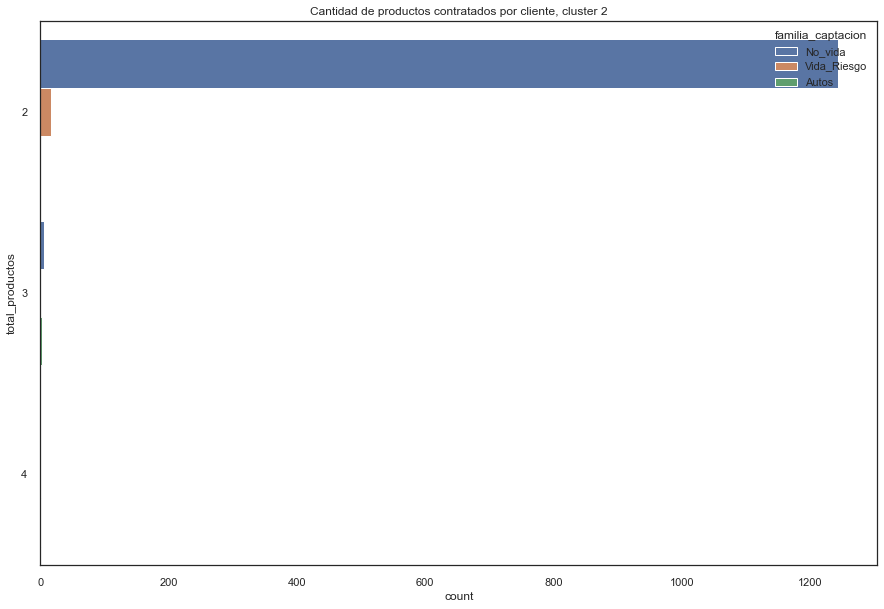

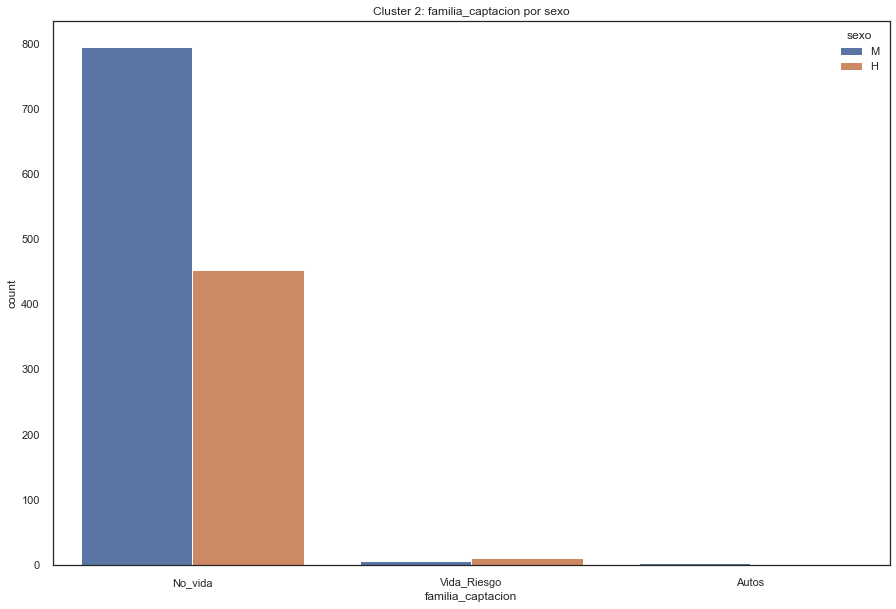

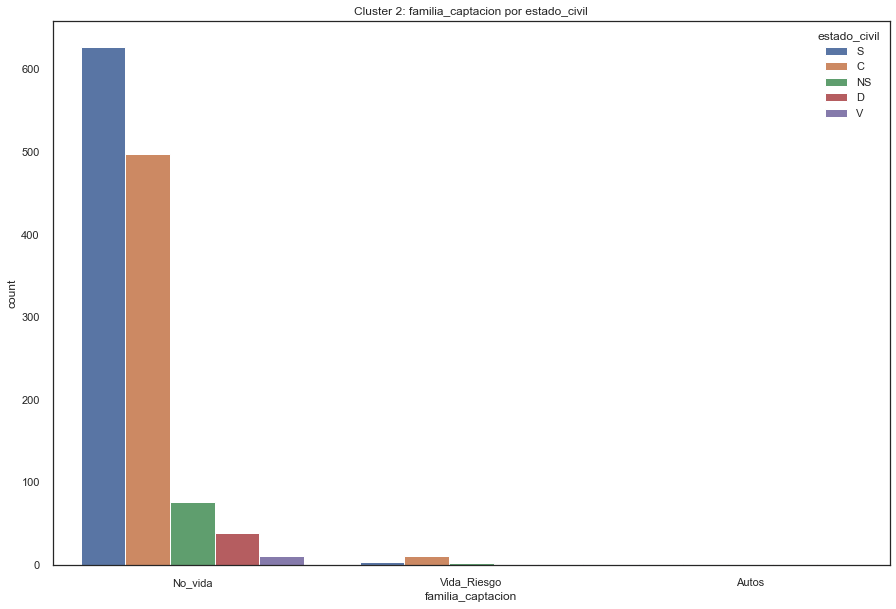

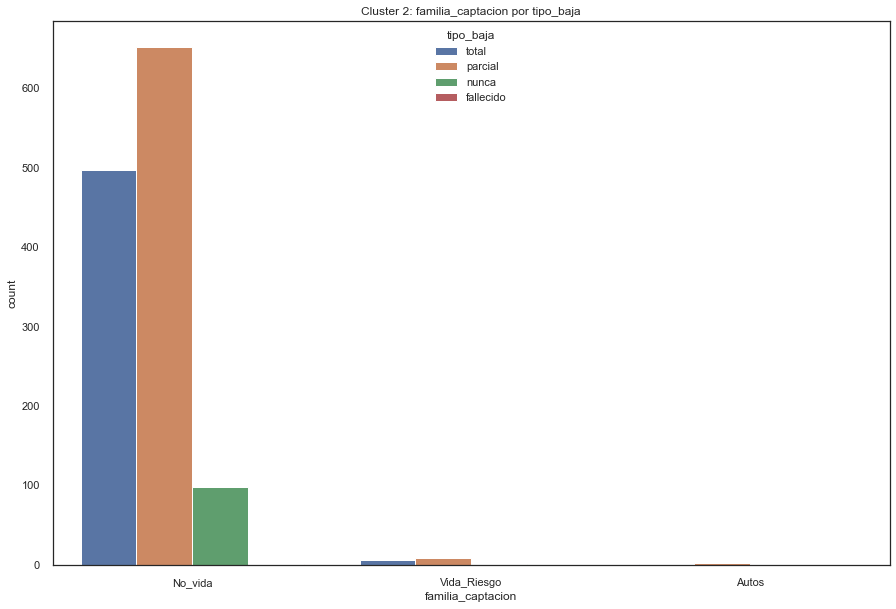

In [317]:
plot_productos_x_cluster(g1_c, 2)
plot_total_productos_x_cluster(g1_c, 2)
plot_total_productos_x_cluster(g1_c, 2, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g1_c, 2,'familia_captacion', e, save=False)
    plt.show();

##### Cluster 3

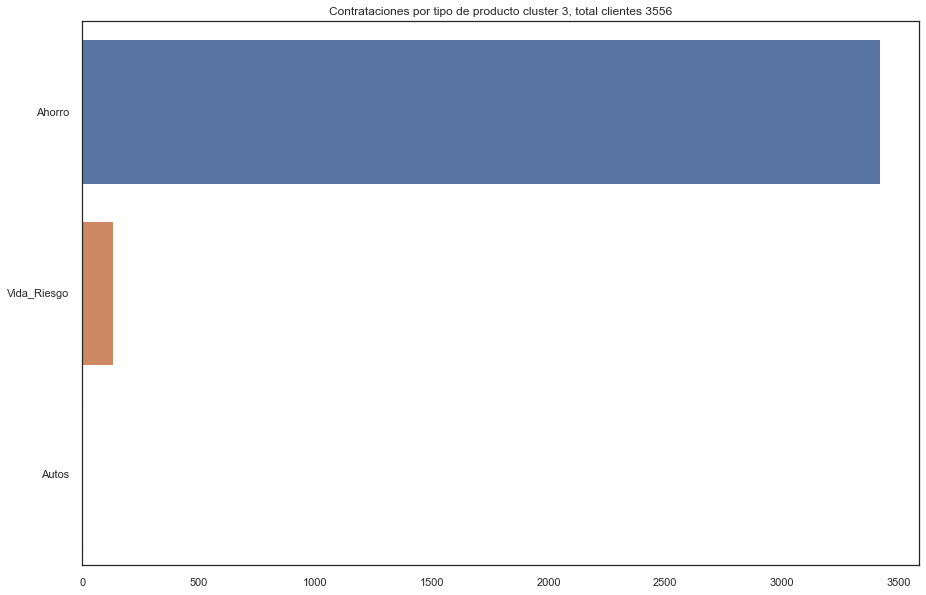

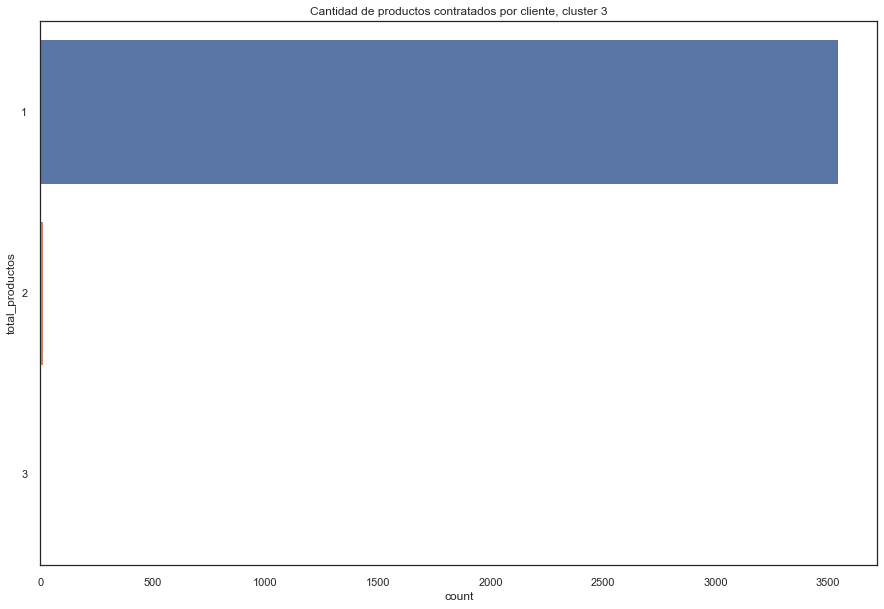

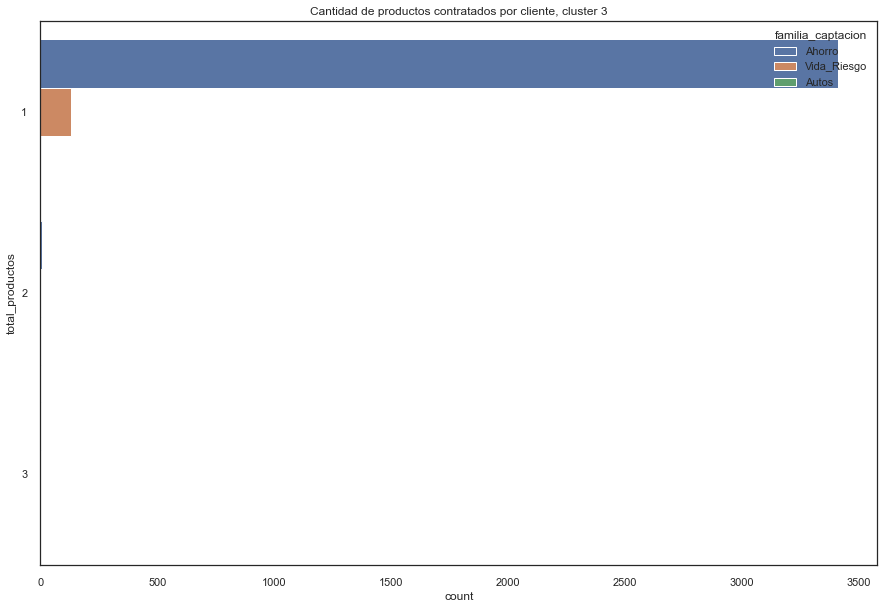

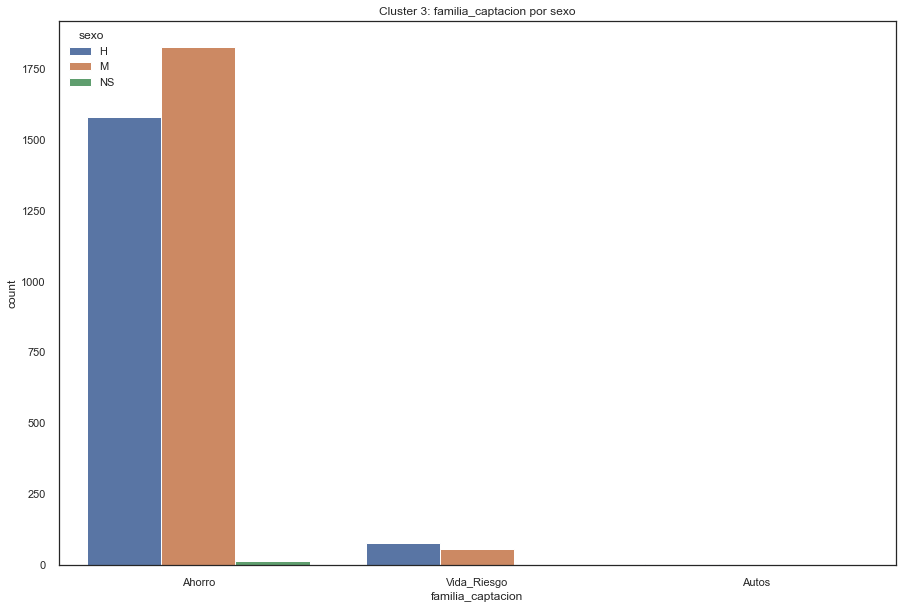

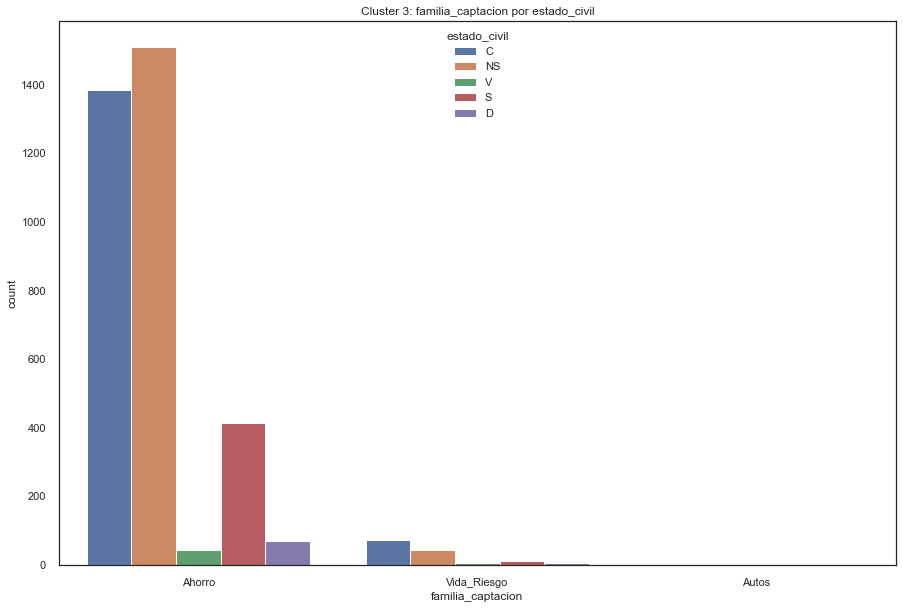

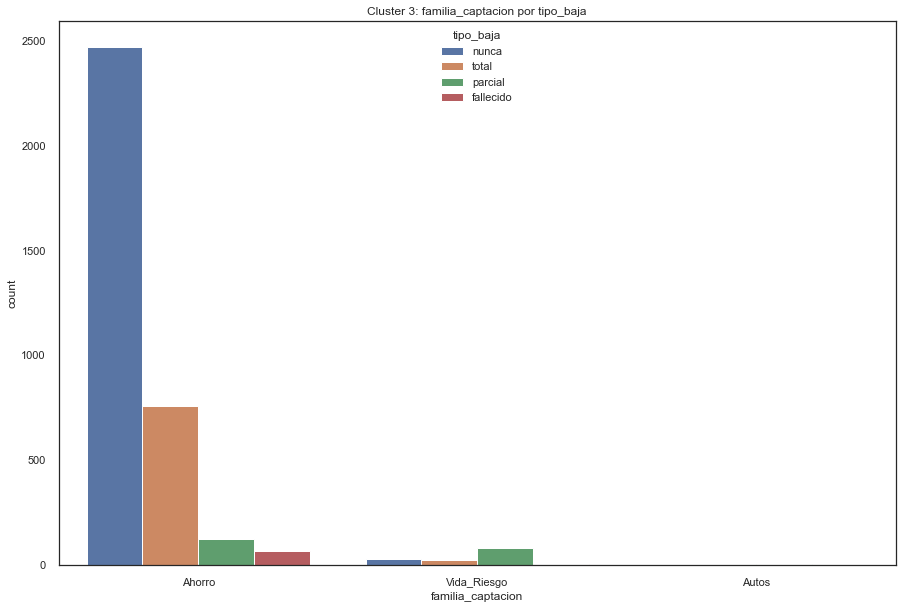

In [318]:
plot_productos_x_cluster(g1_c, 3)
plot_total_productos_x_cluster(g1_c, 3)
plot_total_productos_x_cluster(g1_c, 3, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g1_c, 3,'familia_captacion', e, save=False)
    plt.show();

##### Cluster 4

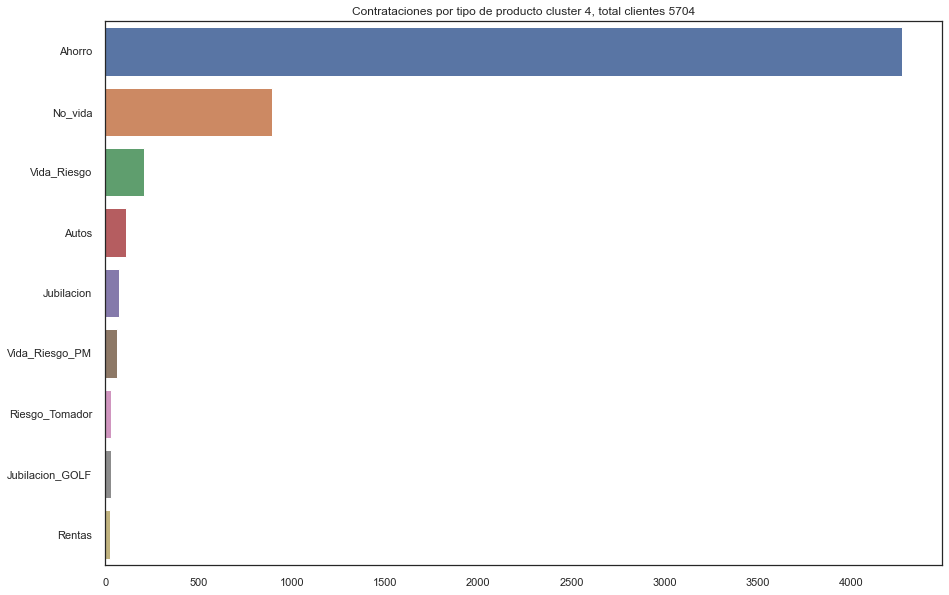

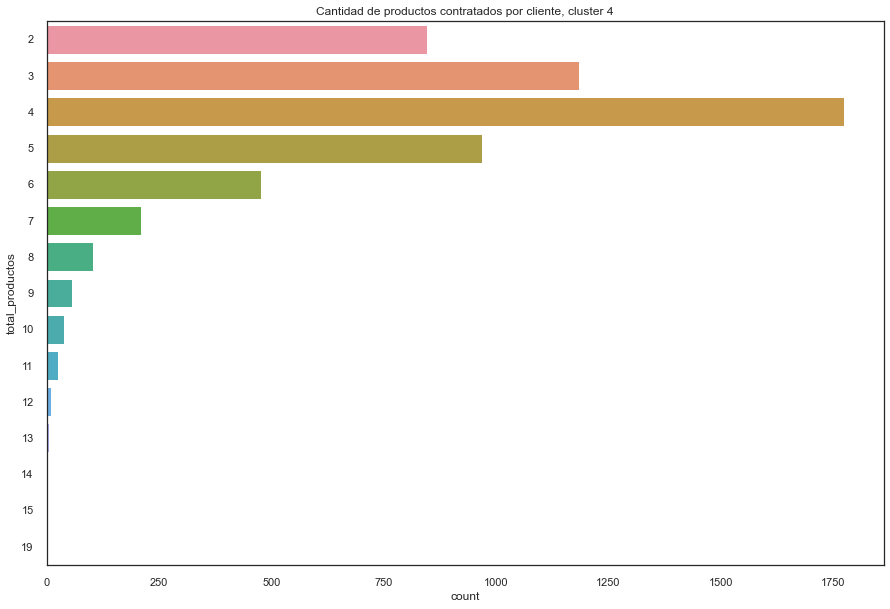

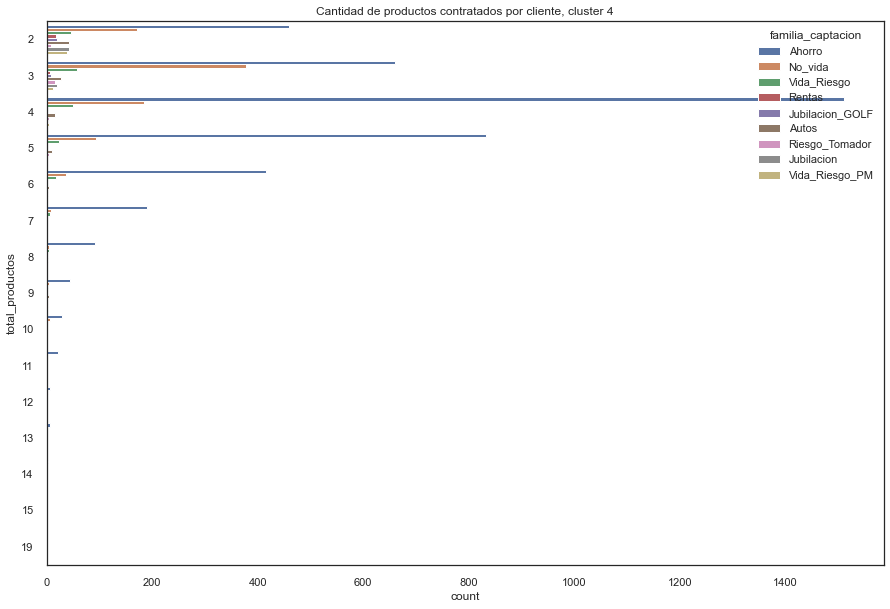

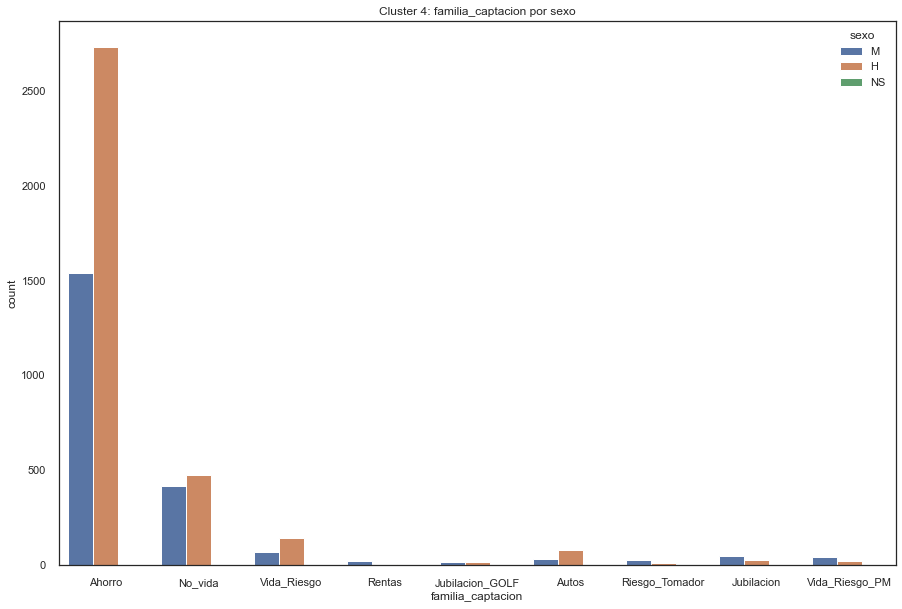

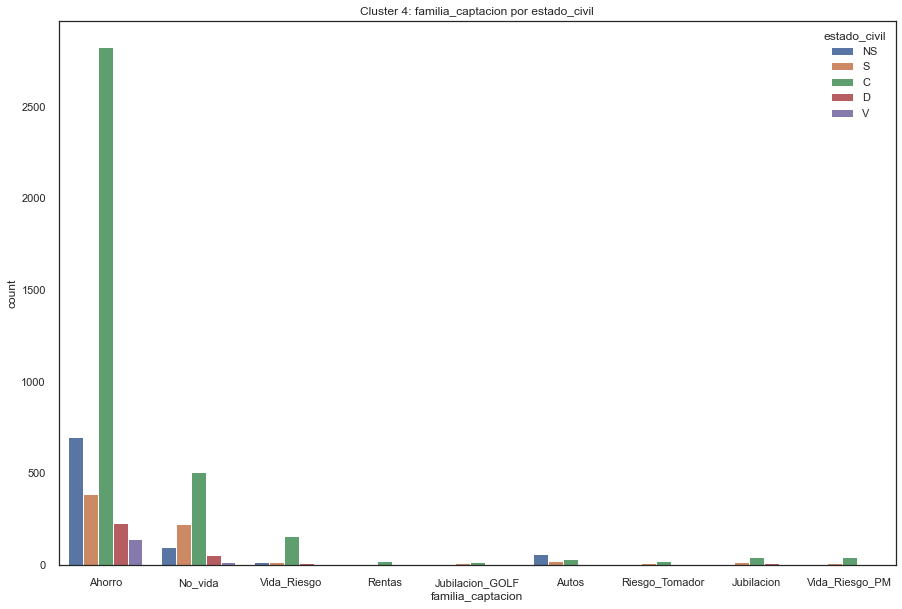

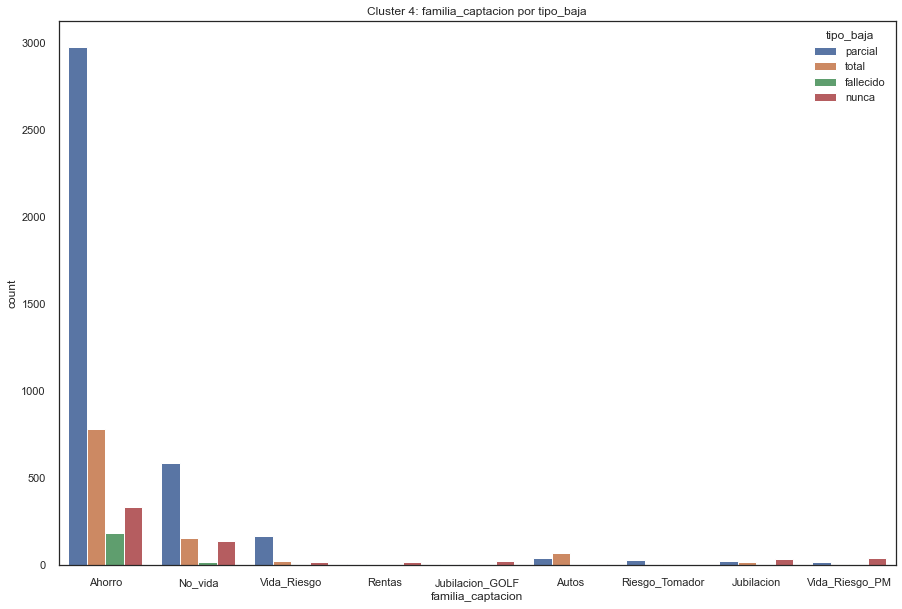

In [319]:
plot_productos_x_cluster(g1_c, 4)
plot_total_productos_x_cluster(g1_c, 4)
plot_total_productos_x_cluster(g1_c, 4, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g1_c, 4,'familia_captacion', e, save=False)
    plt.show();

##### Cluster 5

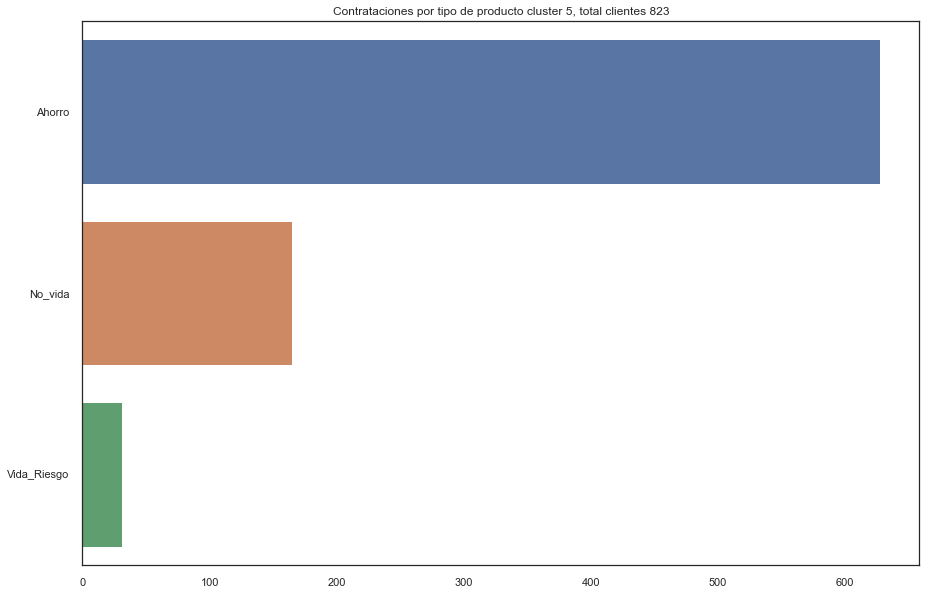

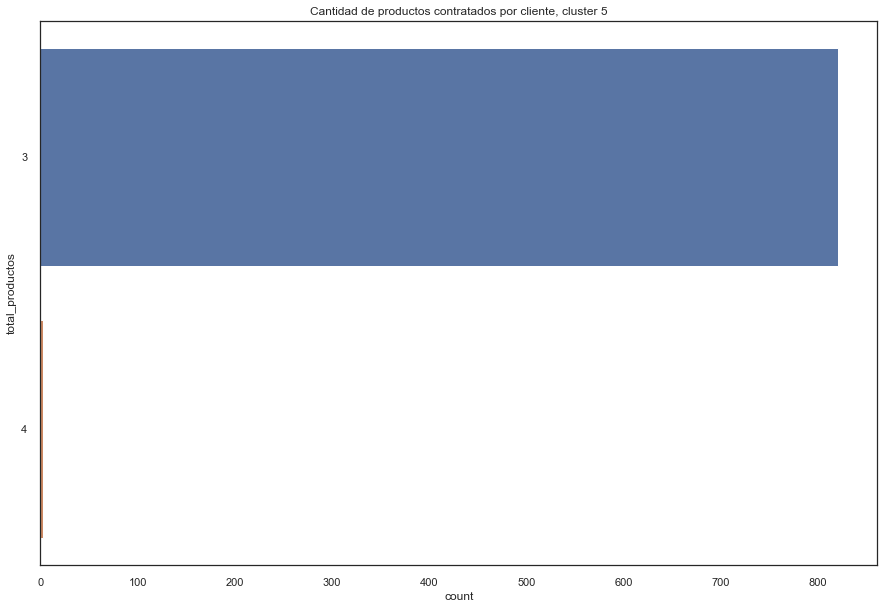

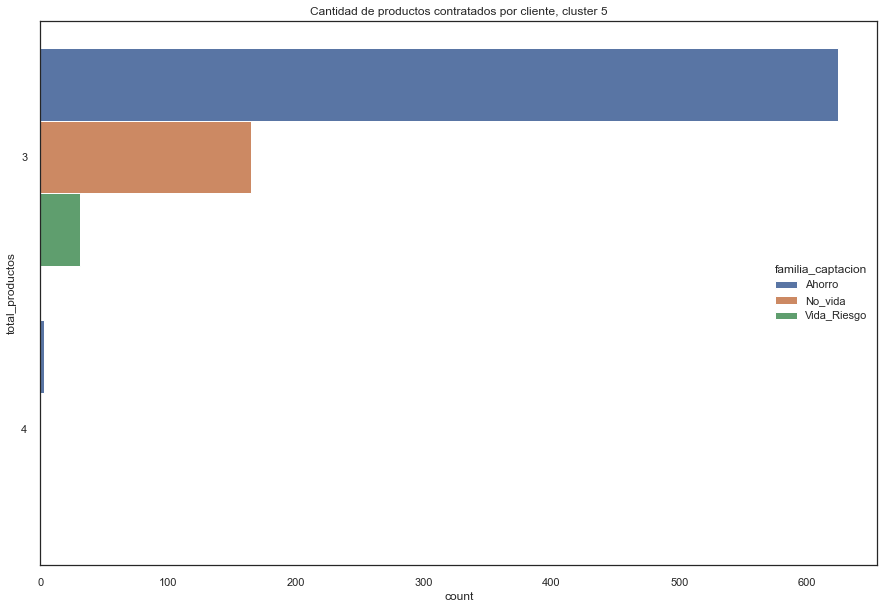

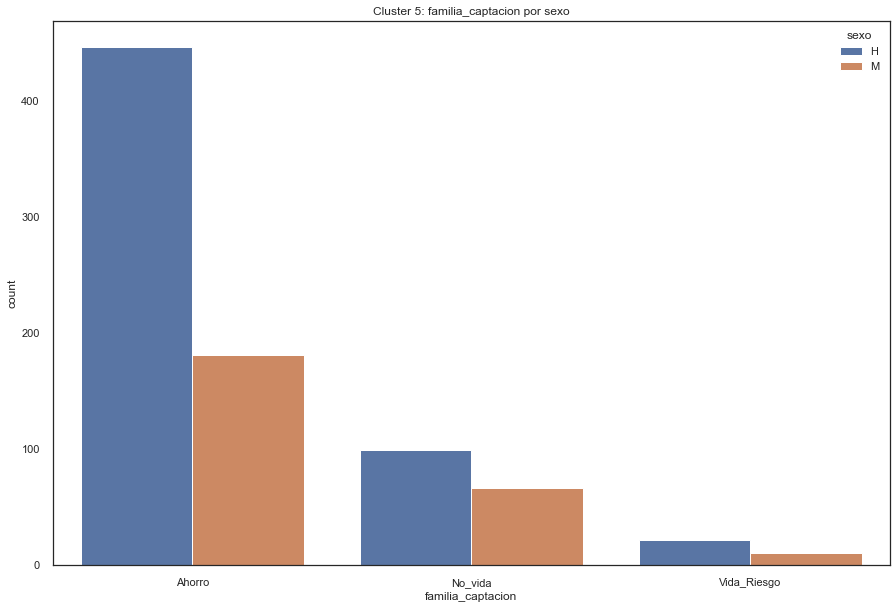

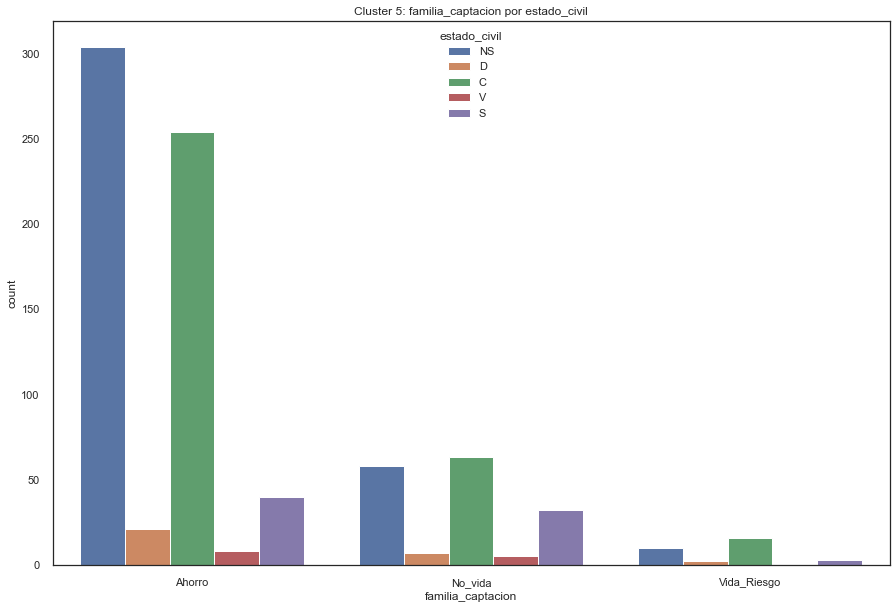

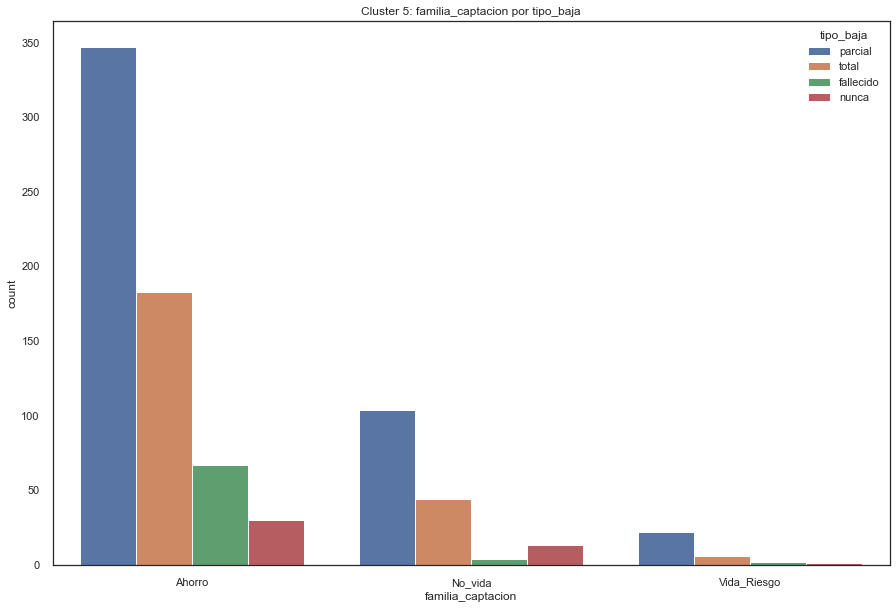

In [320]:
plot_productos_x_cluster(g1_c, 5)
plot_total_productos_x_cluster(g1_c, 5)
plot_total_productos_x_cluster(g1_c, 5, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g1_c, 5,'familia_captacion', e, save=False)
    plt.show();

##### Cluster 6

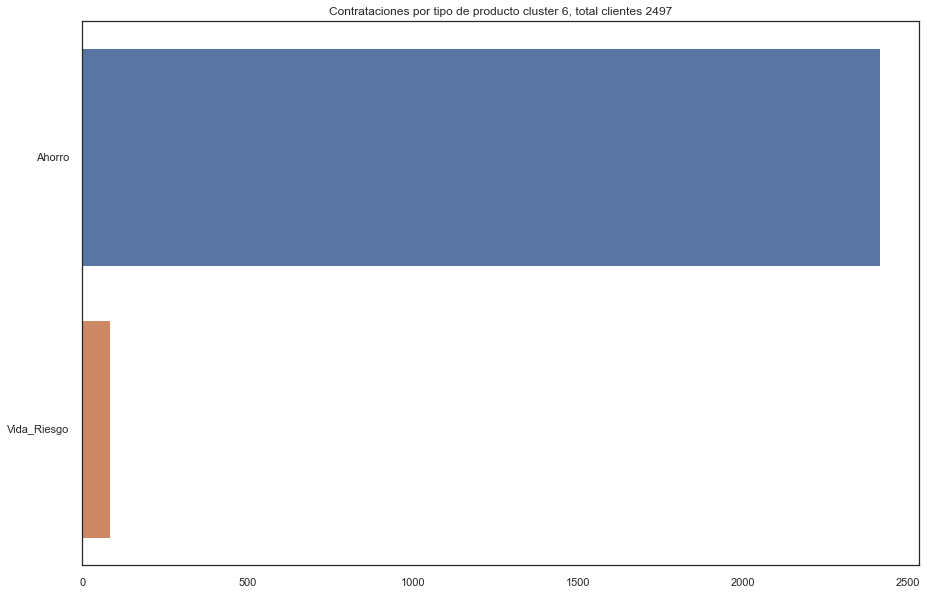

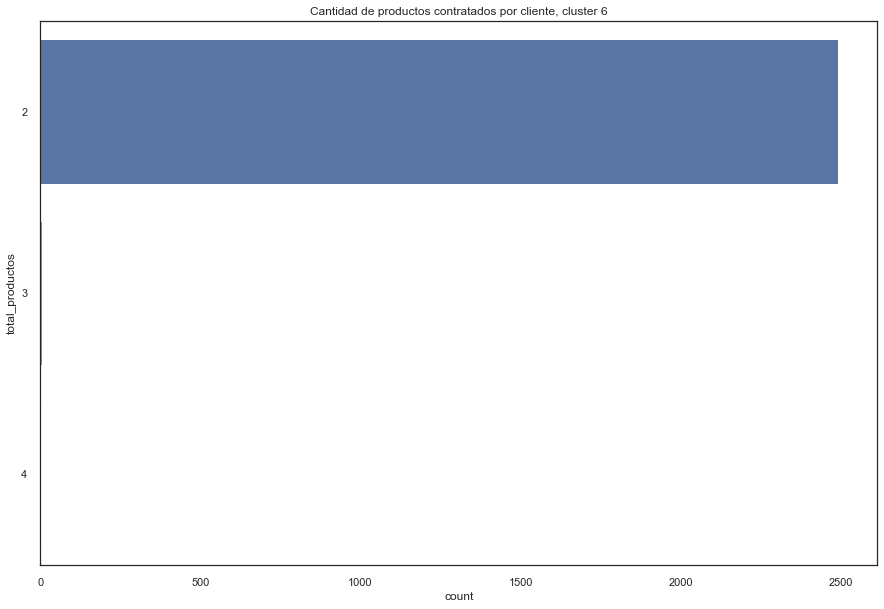

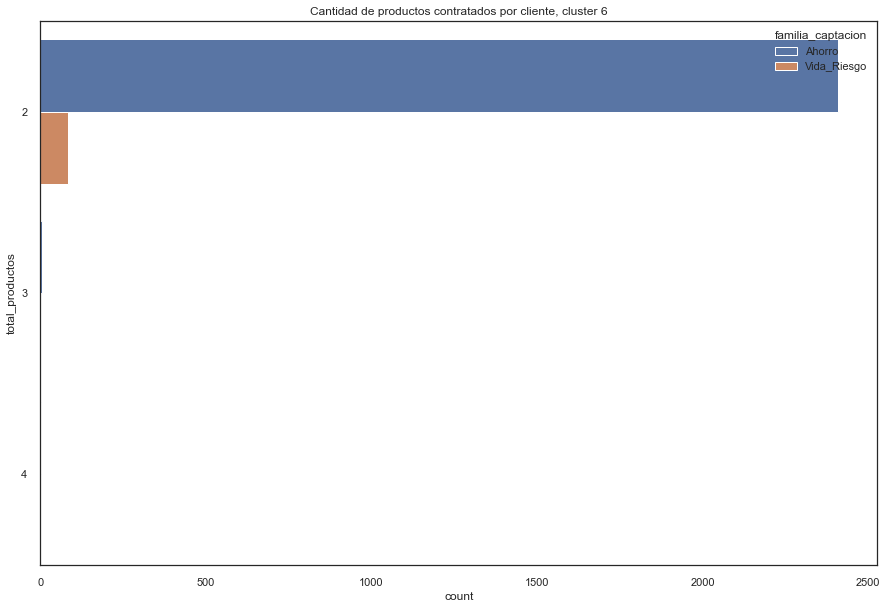

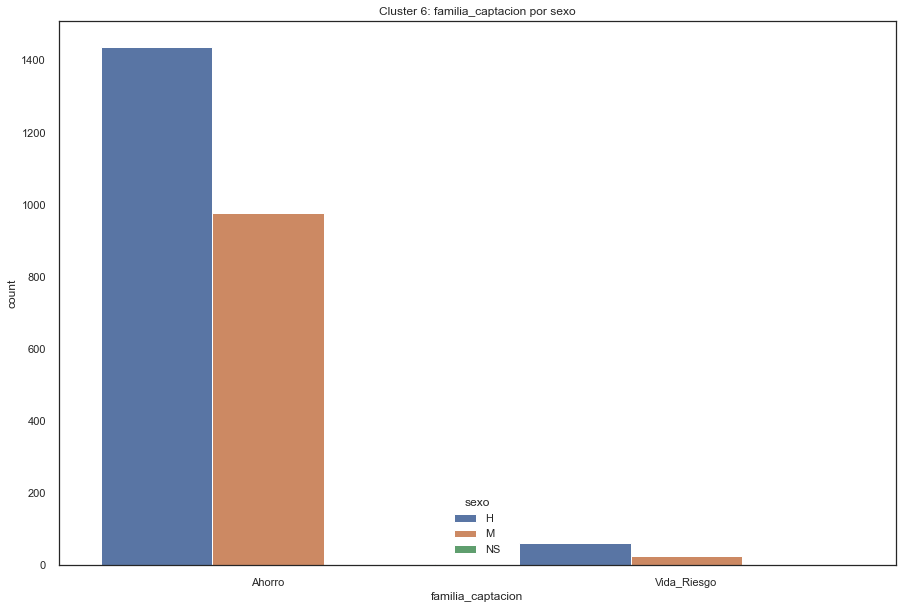

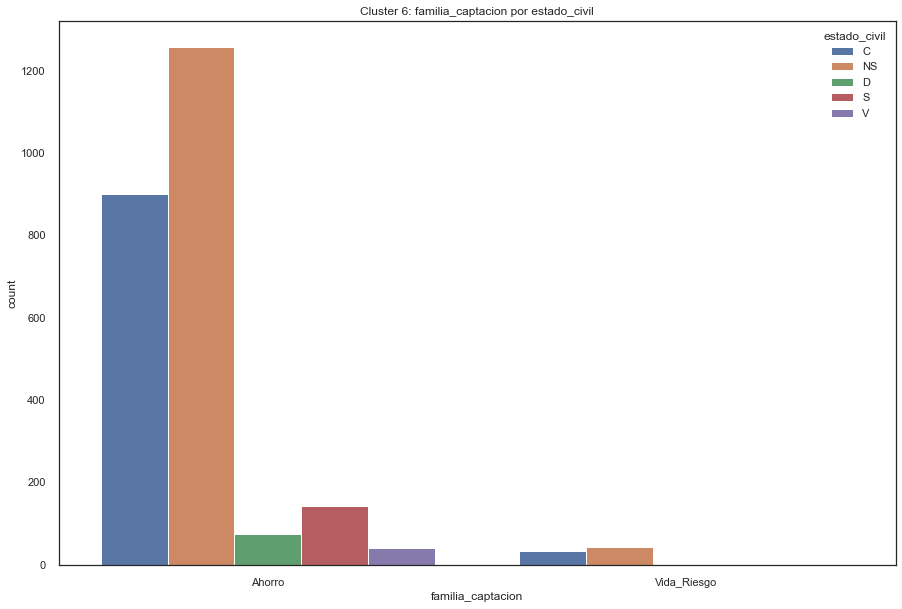

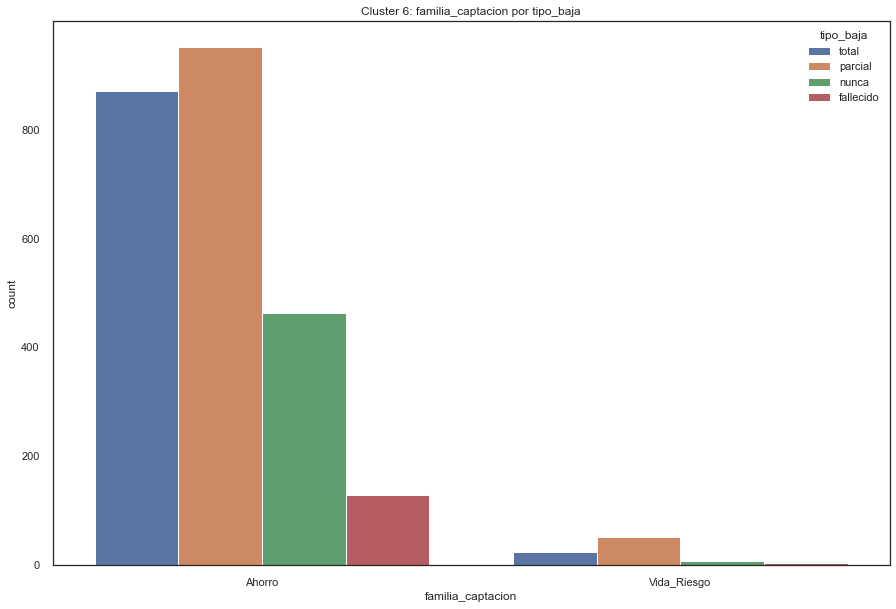

In [321]:
plot_productos_x_cluster(g1_c, 6)
plot_total_productos_x_cluster(g1_c, 6)
plot_total_productos_x_cluster(g1_c, 6, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g1_c, 6,'familia_captacion', e, save=False)
    plt.show();

##### Cluster 7

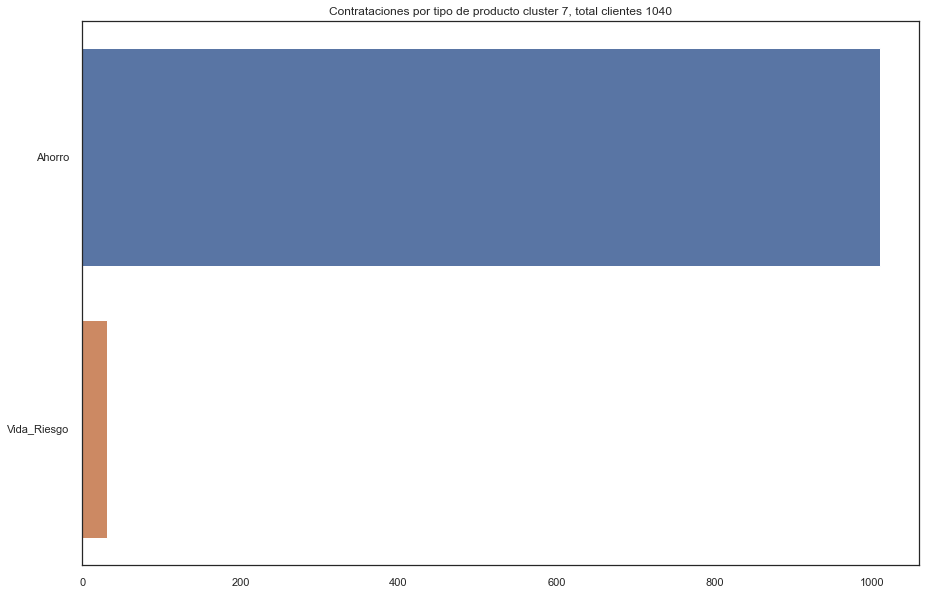

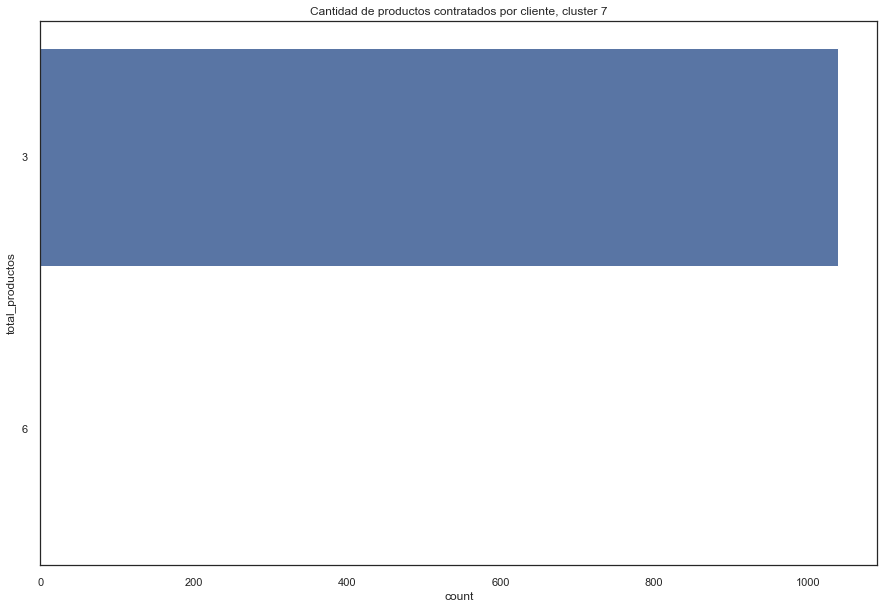

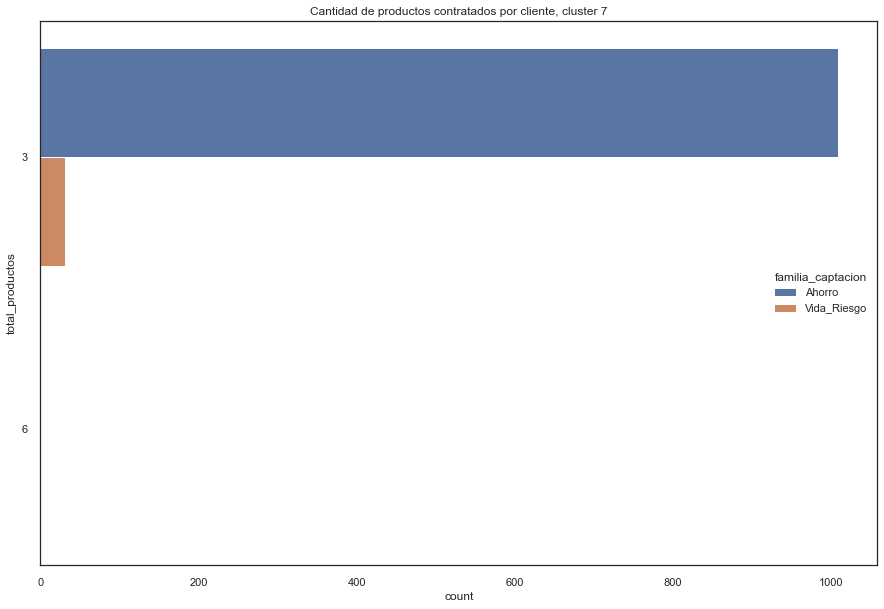

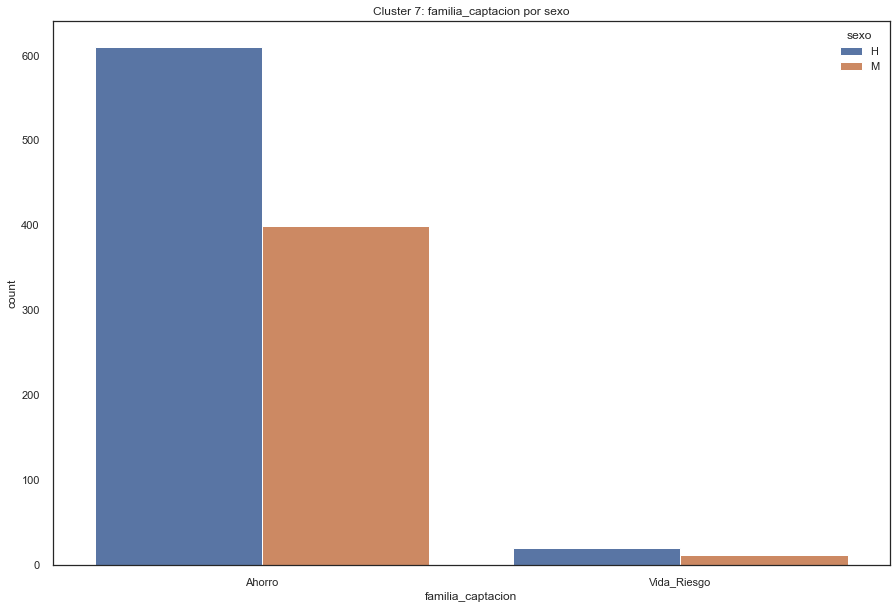

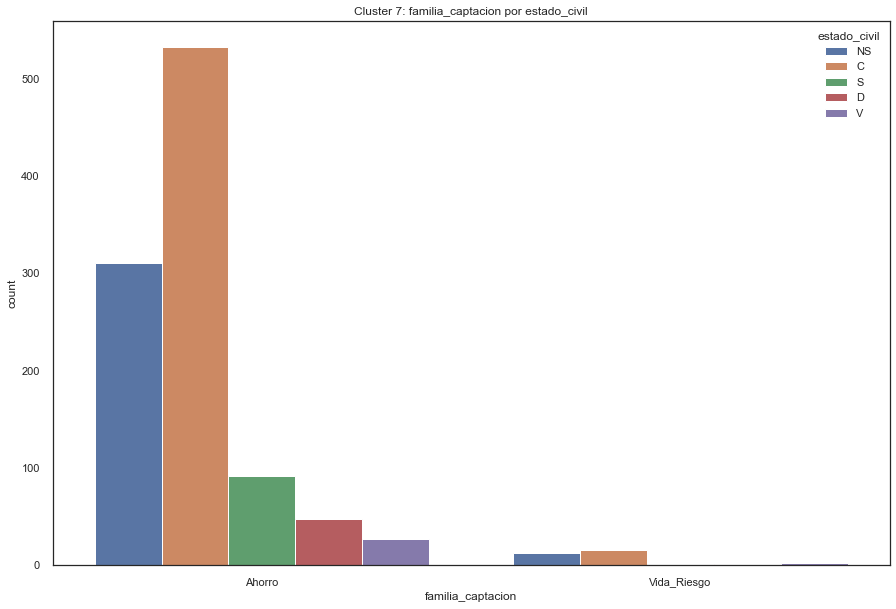

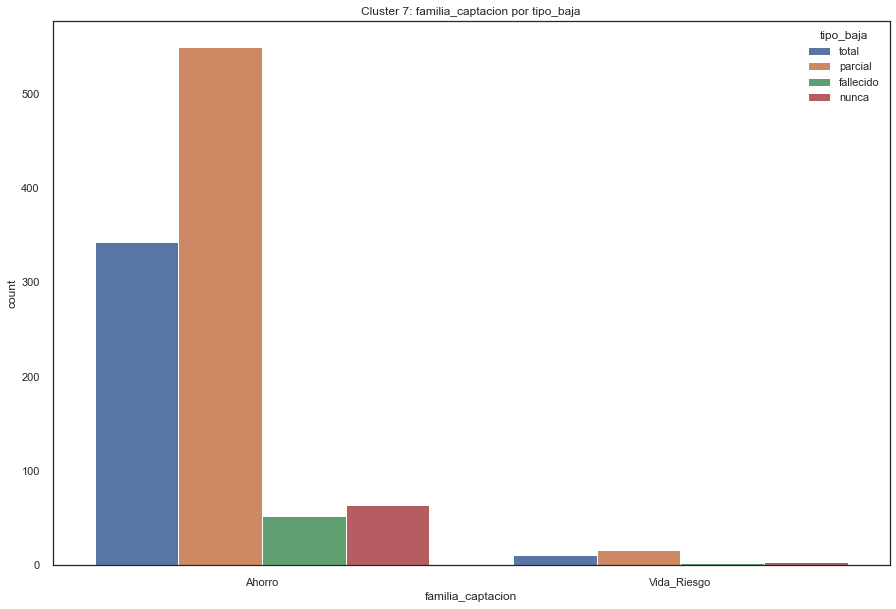

In [322]:
plot_productos_x_cluster(g1_c, 7)
plot_total_productos_x_cluster(g1_c, 7)
plot_total_productos_x_cluster(g1_c, 7, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g1_c, 7,'familia_captacion', e, save=False)
    plt.show();

##### Cluster 8

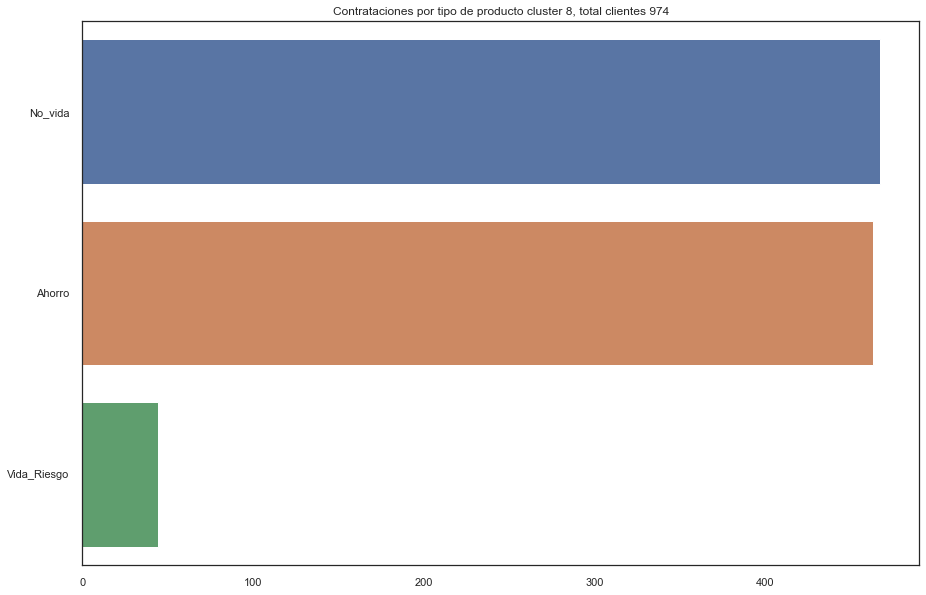

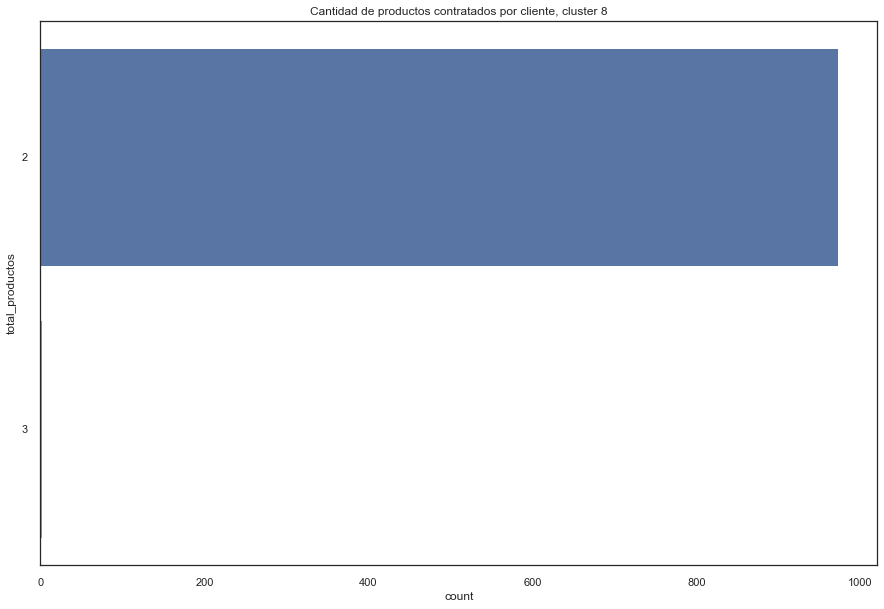

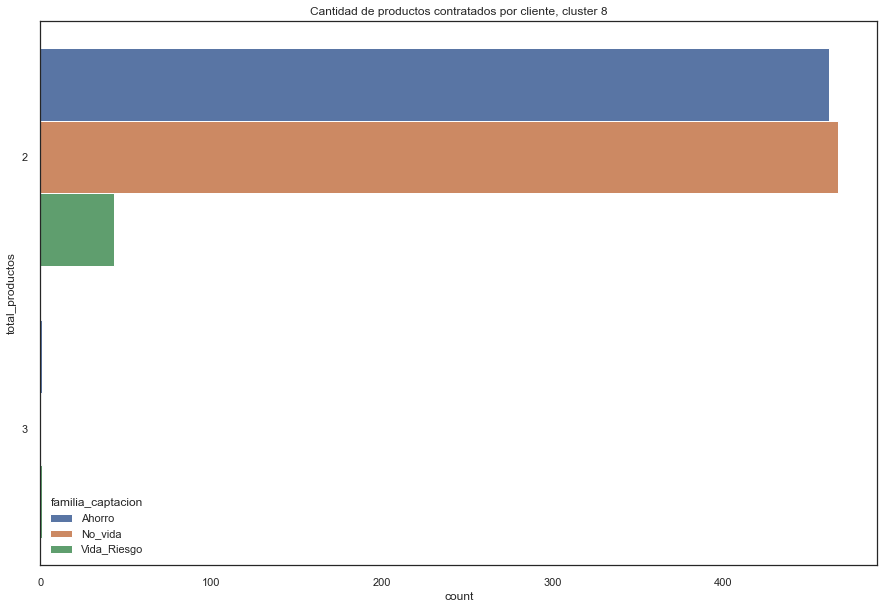

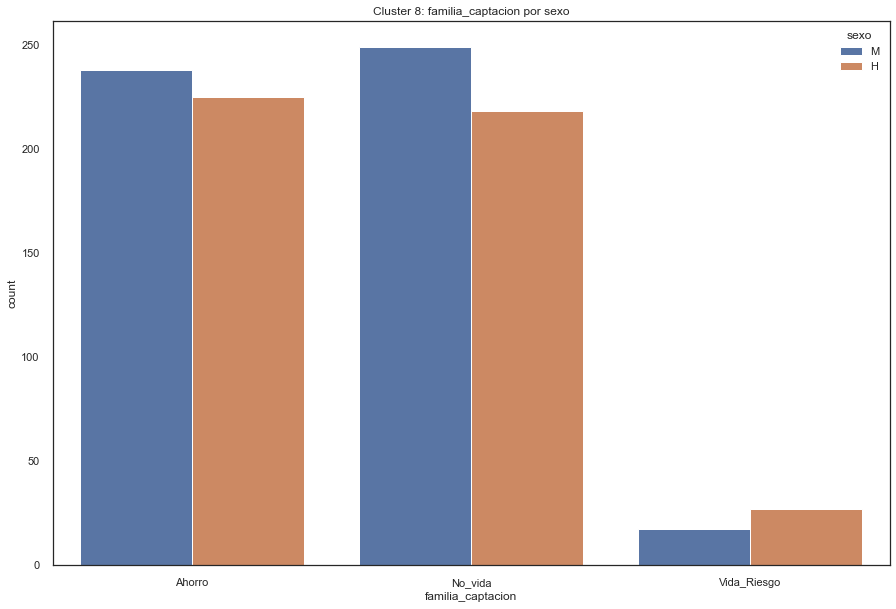

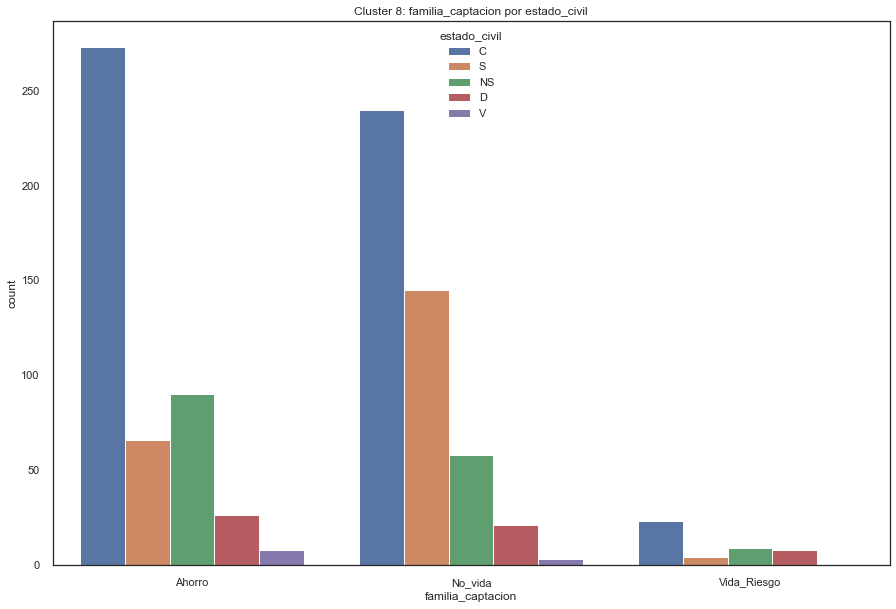

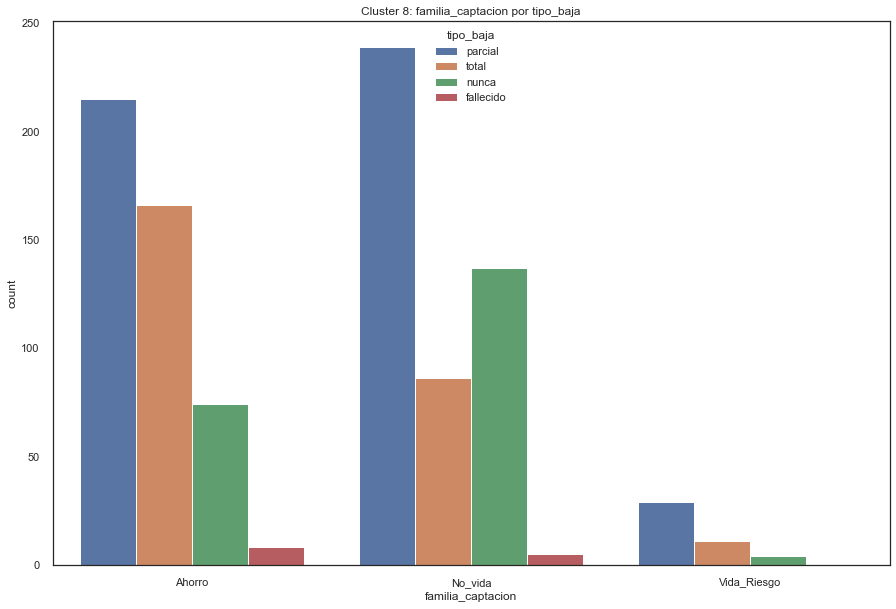

In [323]:
plot_productos_x_cluster(g1_c, 8)
plot_total_productos_x_cluster(g1_c, 8)
plot_total_productos_x_cluster(g1_c, 8, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g1_c, 8,'familia_captacion', e, save=False)
    plt.show();

#### DBScan G2

##### DBScan MinMaxScaler

In [309]:
epsilon_cal = round(np.mean([(max(x2_mm[c])-min(x2_mm[c])) for c in x2_mm.columns])*0.025,3)
samples_min = int(len(x2_mm)*0.05)
dbscan_x2_mm = DBSCAN(eps=epsilon_cal, min_samples=samples_min)
dbscan_x2_mm.fit(x2_mm)
print(dbscan_x2_mm)
dbscan_x2_mm_df = pd.DataFrame(x2_umap_mm)
dbscan_x2_mm_df['cluster']= dbscan_x2_mm.labels_
dbscan_x2_mm_df.cluster.value_counts()

DBSCAN(eps=0.02, min_samples=210)


-1    1289
 3    1081
 1     881
 0     416
 4     314
 2     231
Name: cluster, dtype: int64

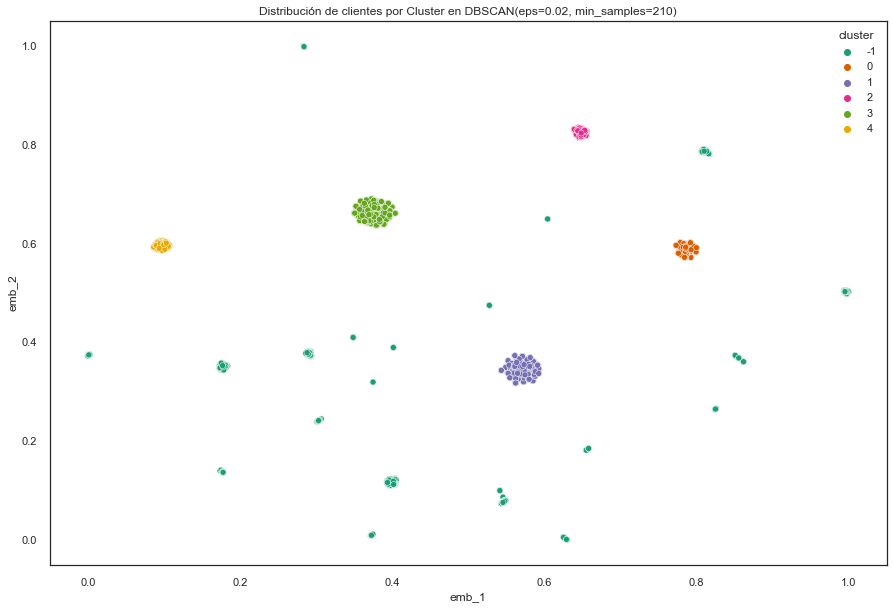

In [311]:
plot_clusters(dbscan_x2_mm_df, dbscan_x2_mm, palette='Dark2' ,centroids=False,save=False)

##### DBScan MinManScaler + UMAP


In [312]:
epsilon_cal = round(np.mean([(max(x2_umap_mm[c])-min(x2_umap_mm[c])) for c in x2_umap_mm.columns])*0.5,3)
samples_min = int(len(x2_umap_mm)*0.025)
dbscan_x2_umap_mm = DBSCAN(eps=epsilon_cal, min_samples=samples_min)
dbscan_x2_umap_mm.fit(x2_umap_mm)
print(dbscan_x2_umap_mm)
dbscan_x2_umap_mm_df = pd.DataFrame(x2_umap_mm)
dbscan_x2_umap_mm_df['cluster']= dbscan_x2_umap_mm.labels_
dbscan_x2_umap_mm_df.cluster.value_counts()

DBSCAN(eps=0.667, min_samples=105)


4    1289
3    1081
1     881
0     416
5     314
2     231
Name: cluster, dtype: int64

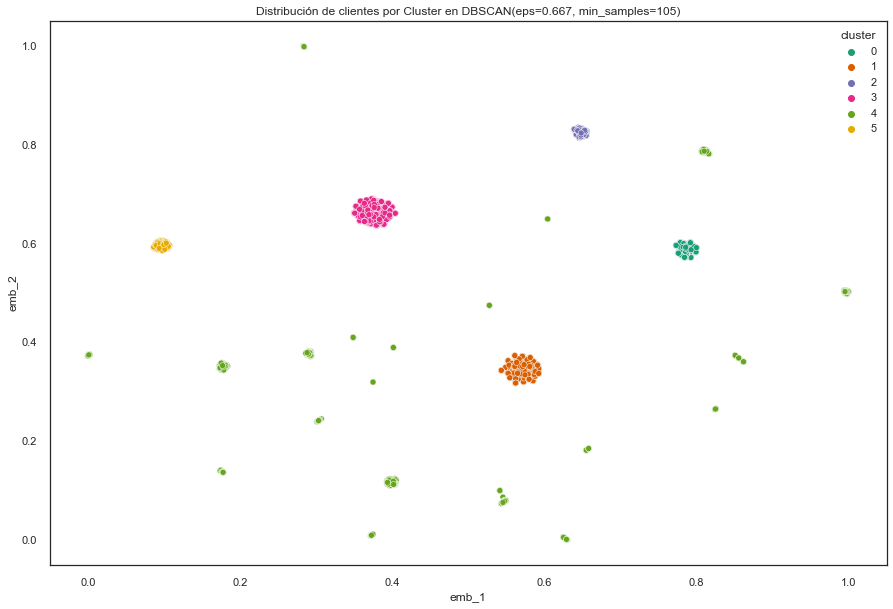

In [313]:
plot_clusters(dbscan_x2_umap_mm_df, dbscan_x2_umap_mm, palette='Dark2' ,centroids=False,save=False)

#### Análisis DBScan G2

In [324]:
g2_c['cluster']= dbscan_x2_umap_mm.labels_

##### Cluster 0

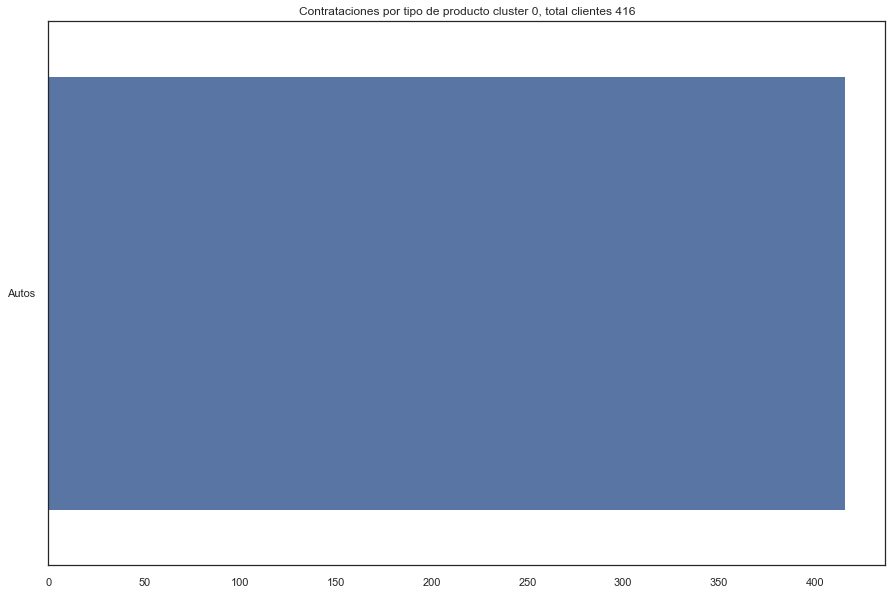

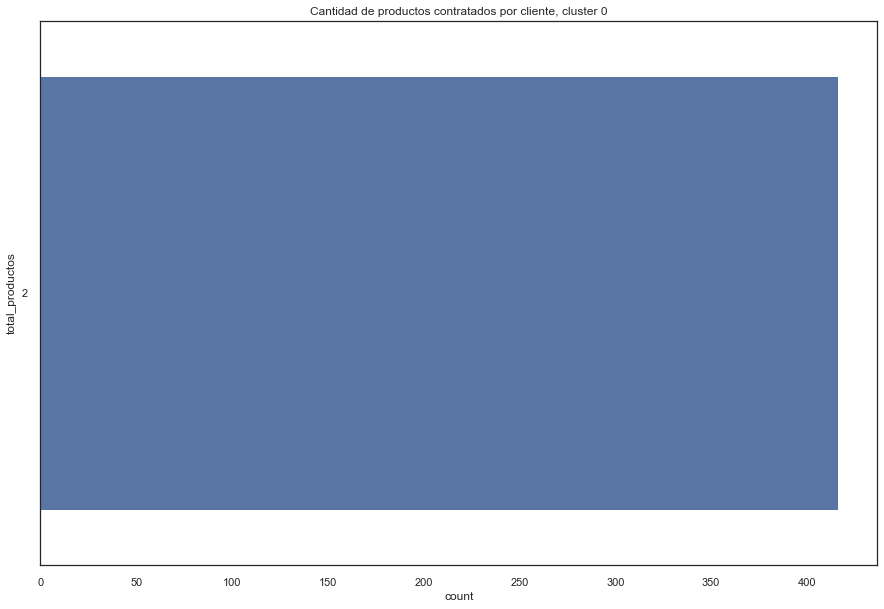

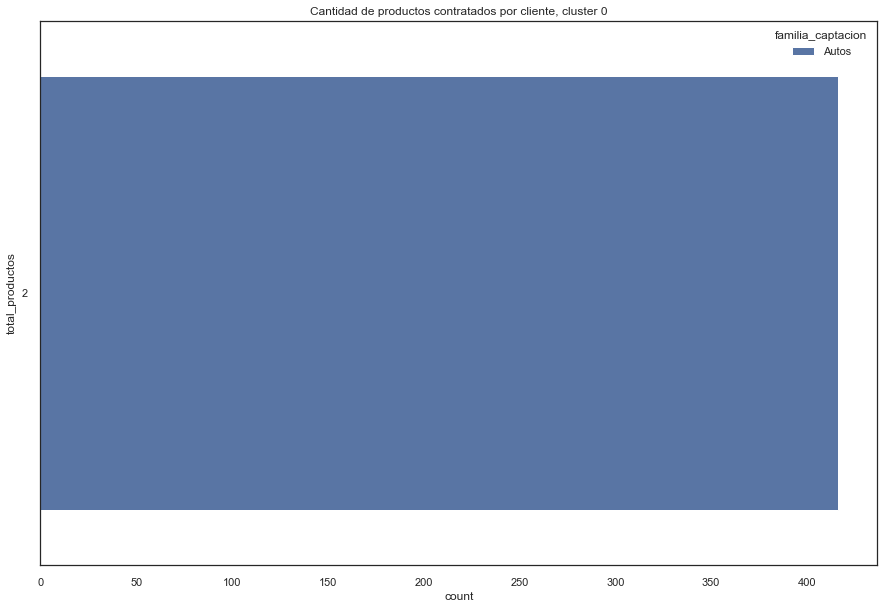

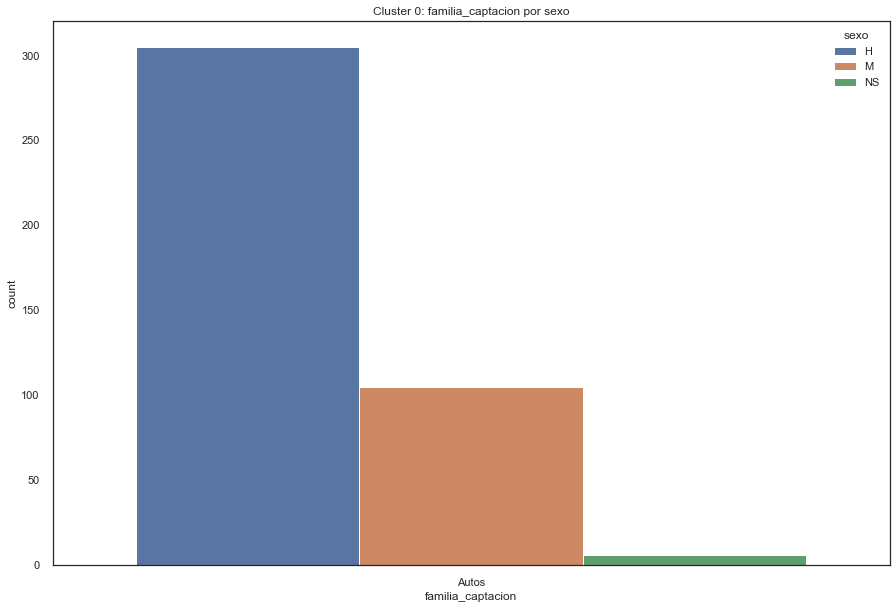

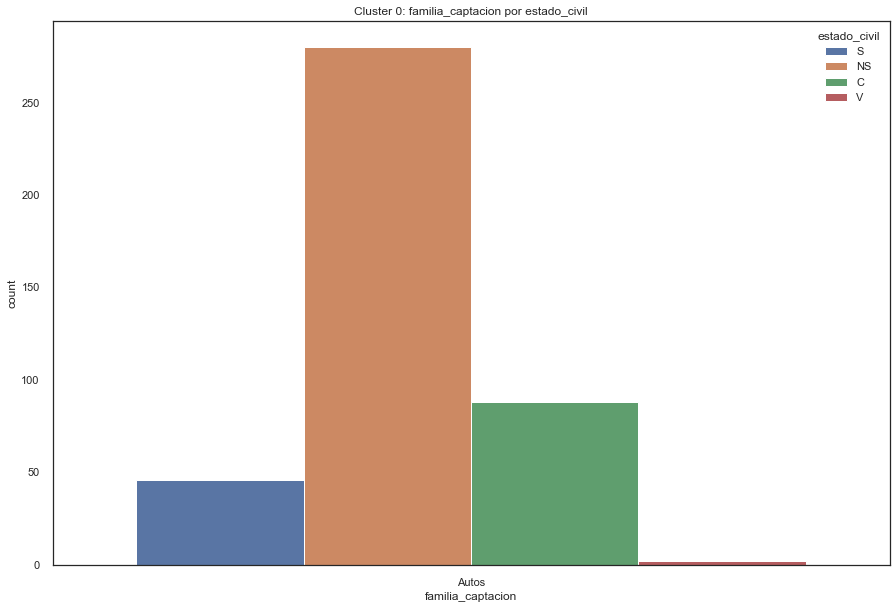

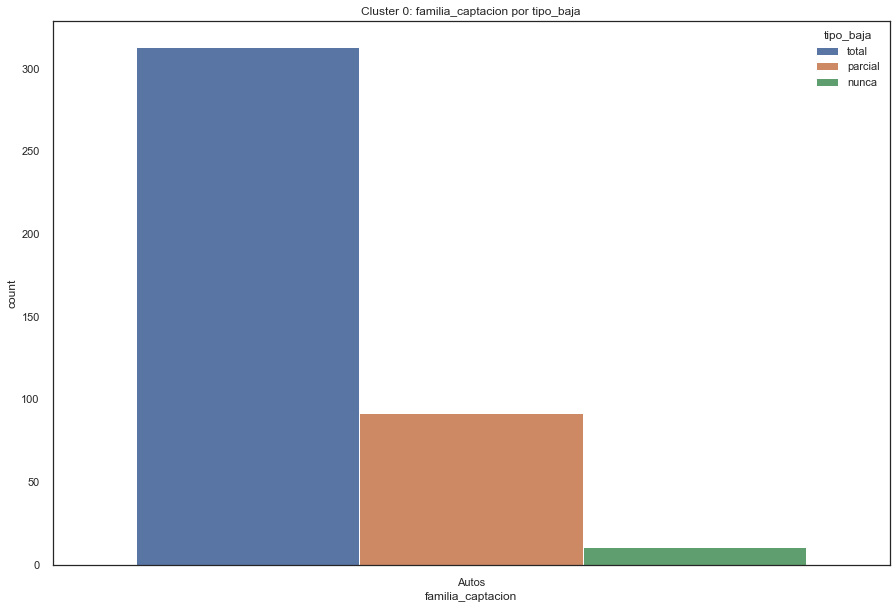

In [325]:
plot_productos_x_cluster(g2_c, 0)
plot_total_productos_x_cluster(g2_c, 0)
plot_total_productos_x_cluster(g2_c, 0, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g2_c, 0,'familia_captacion', e, save=False)
    plt.show();

##### Cluster 1

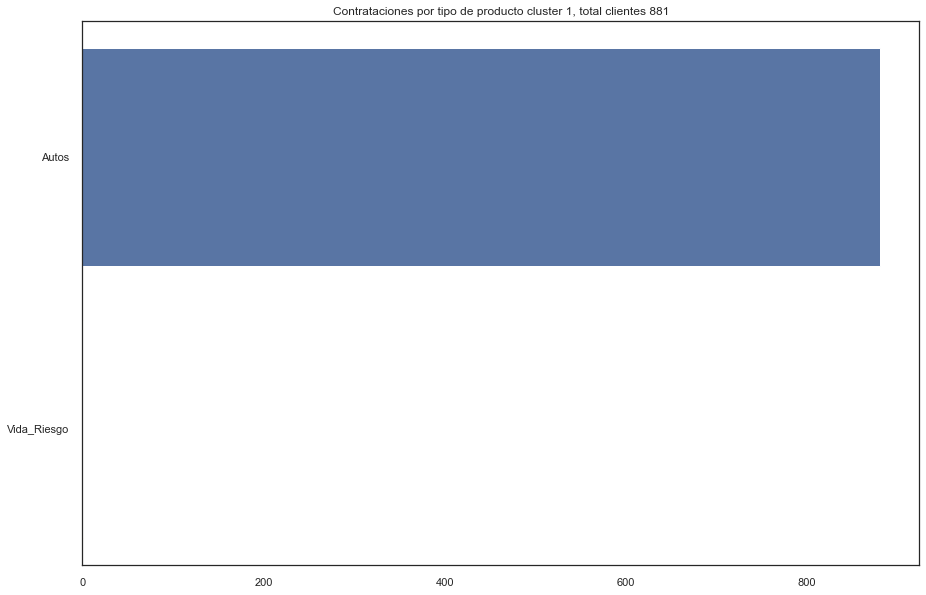

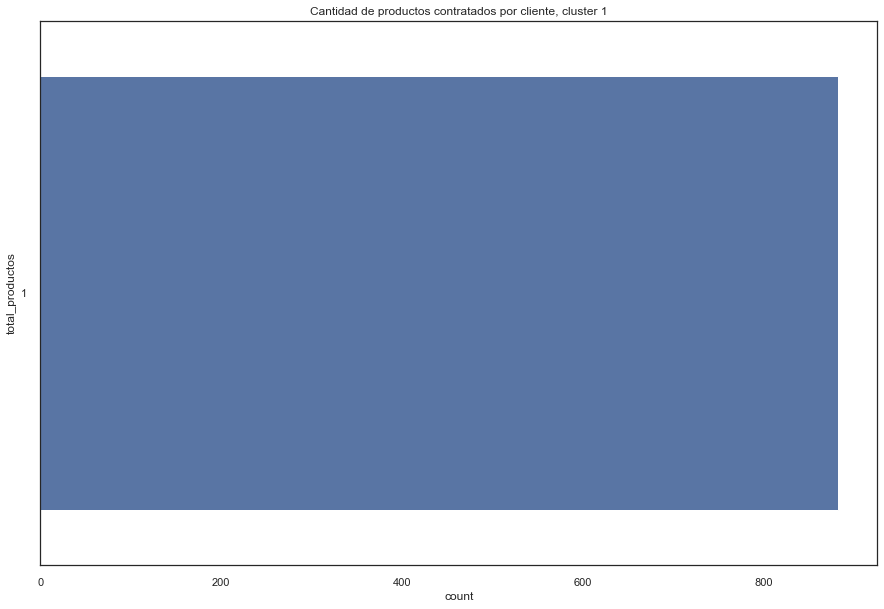

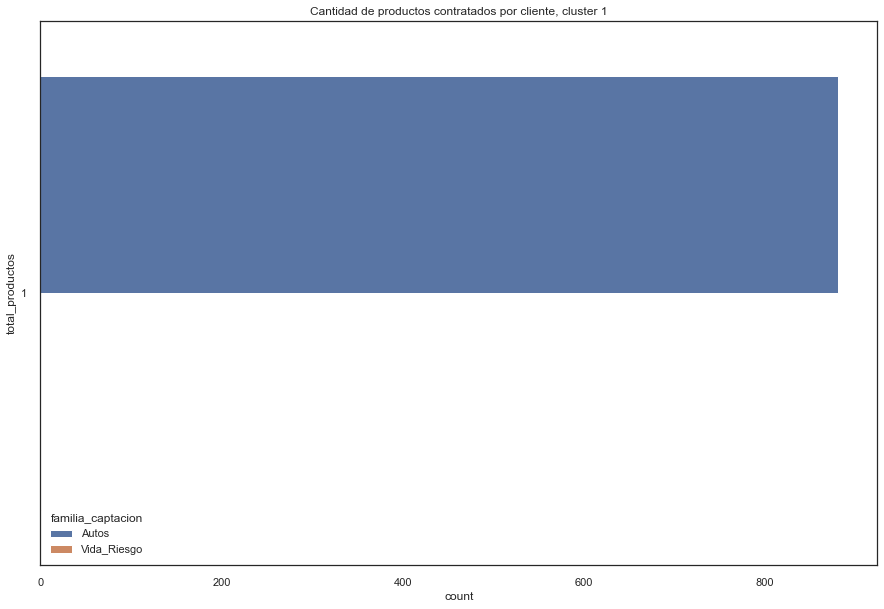

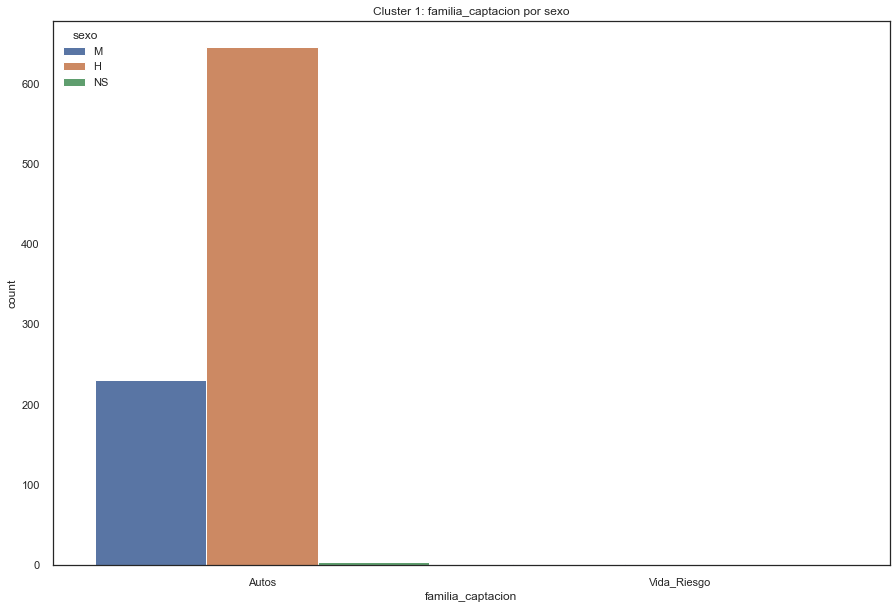

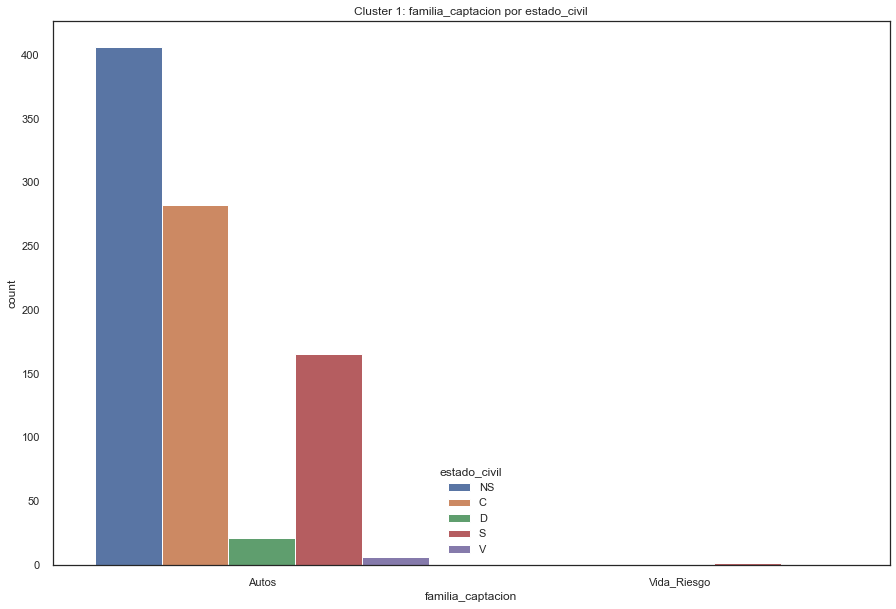

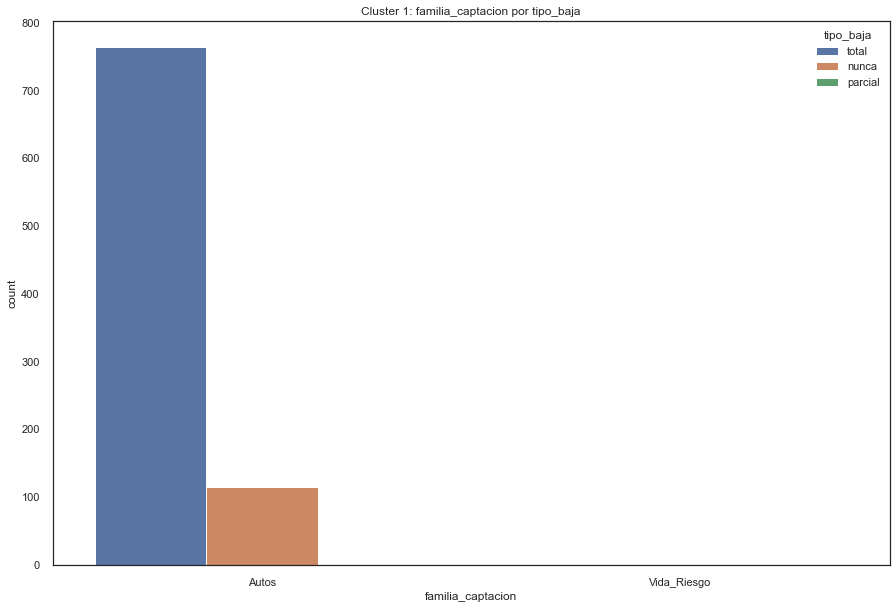

In [326]:
plot_productos_x_cluster(g2_c, 1)
plot_total_productos_x_cluster(g2_c, 1)
plot_total_productos_x_cluster(g2_c, 1, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g2_c, 1,'familia_captacion', e, save=False)
    plt.show();

##### Cluster 2

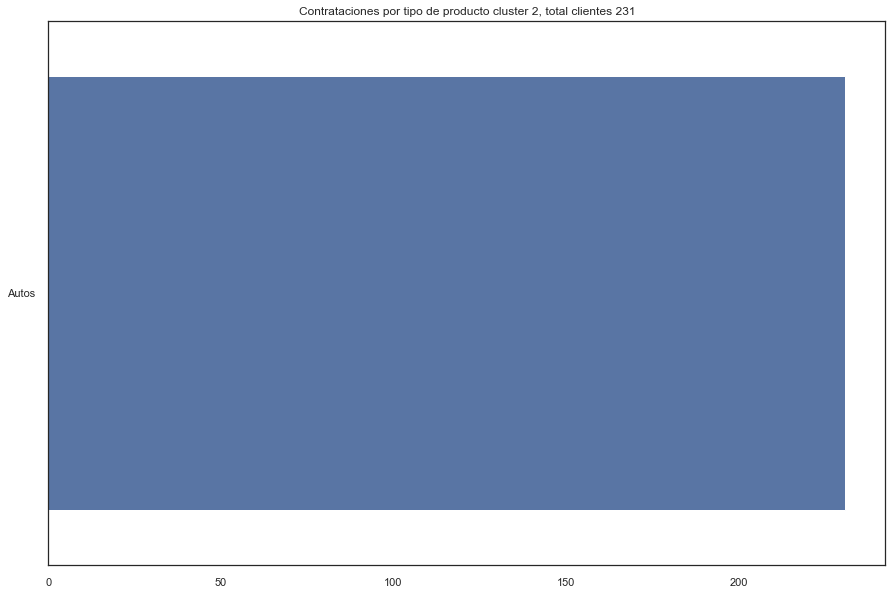

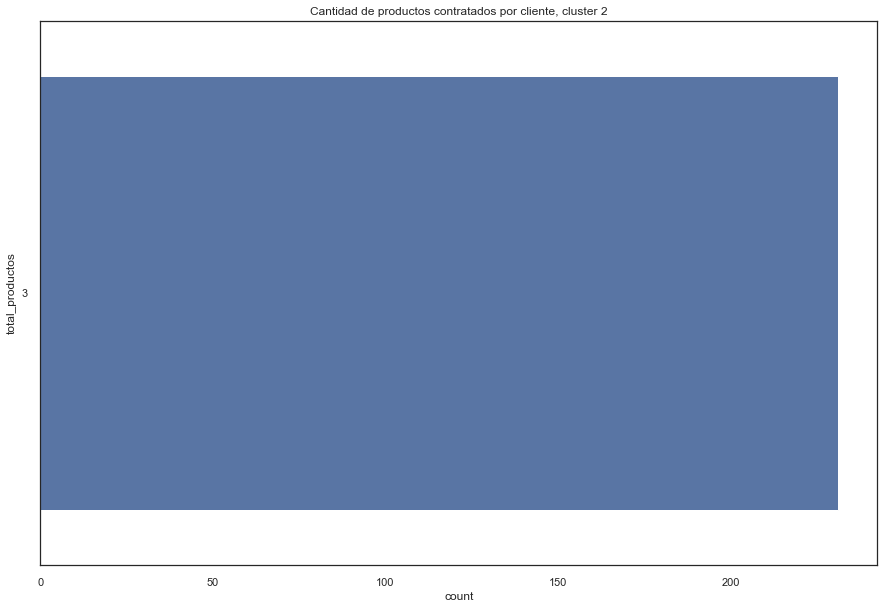

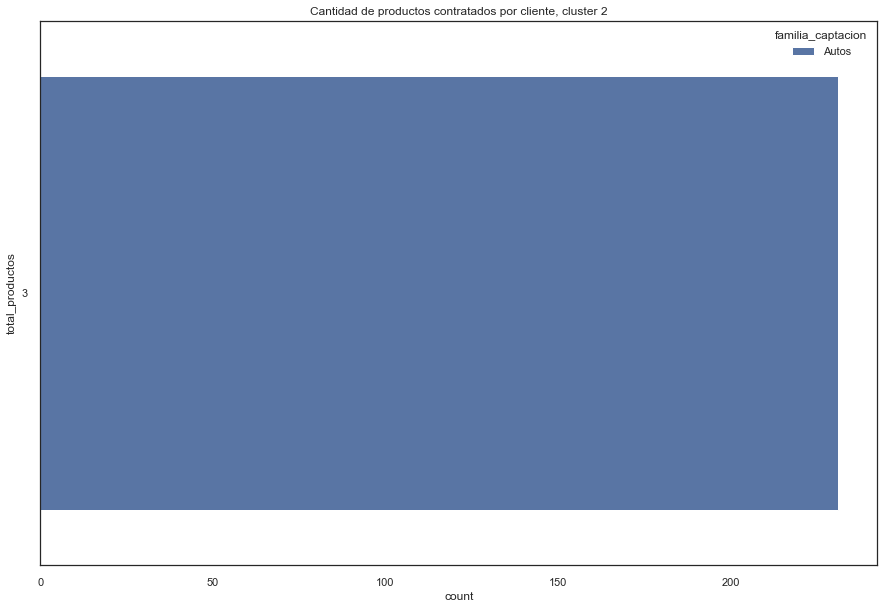

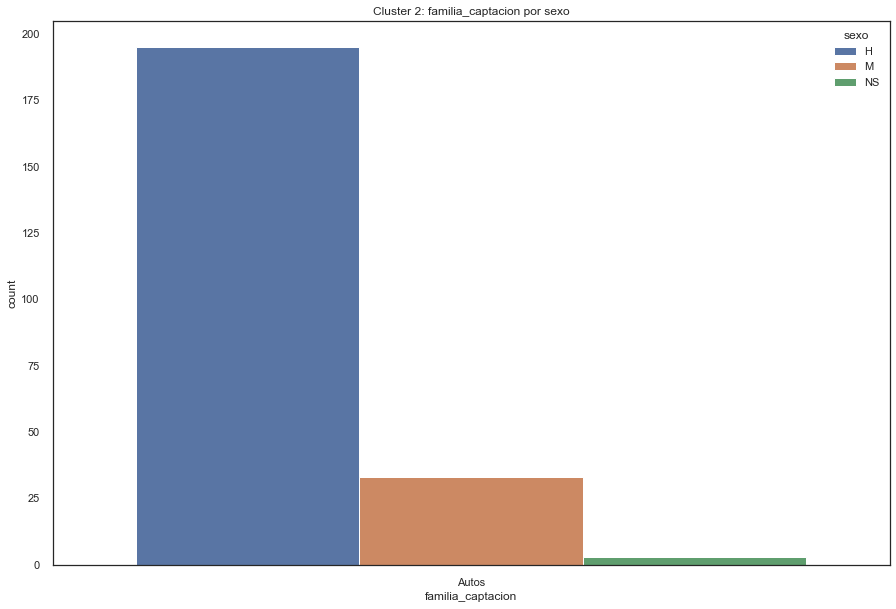

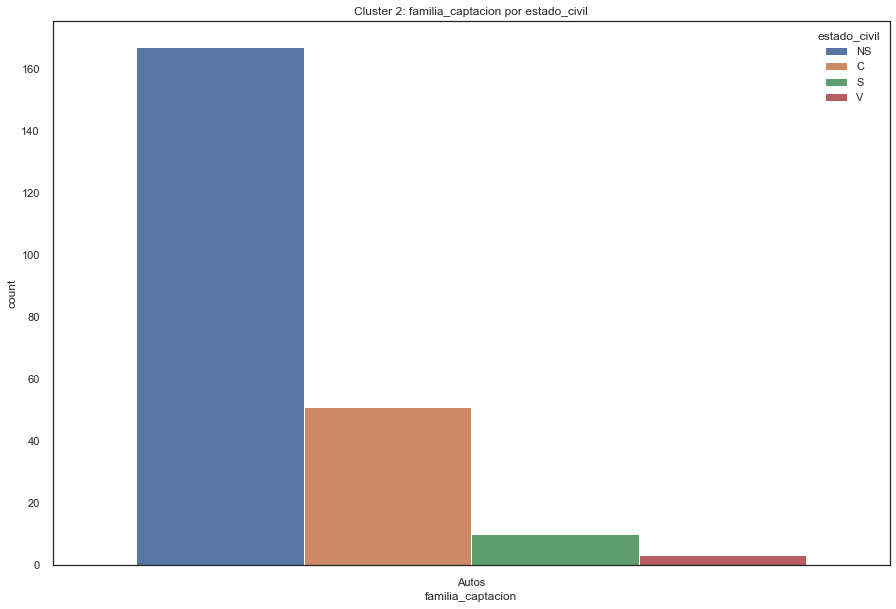

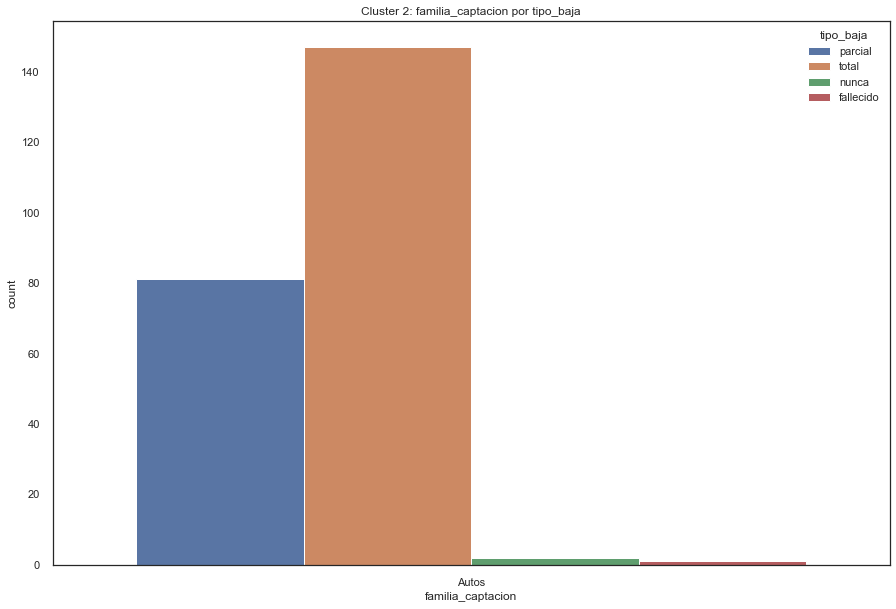

In [327]:
plot_productos_x_cluster(g2_c, 2)
plot_total_productos_x_cluster(g2_c, 2)
plot_total_productos_x_cluster(g2_c, 2, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g2_c, 2,'familia_captacion', e, save=False)
    plt.show();

##### Cluster 3

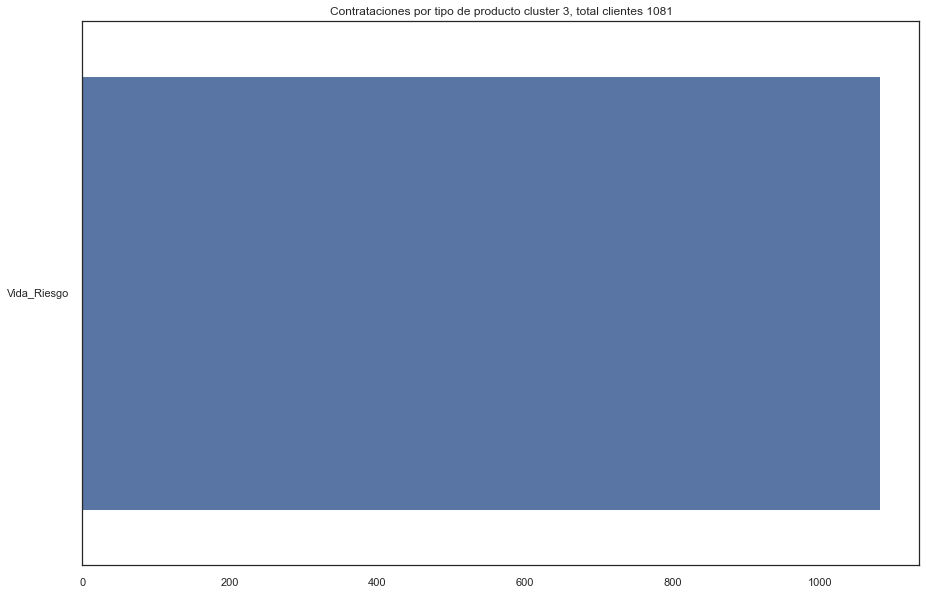

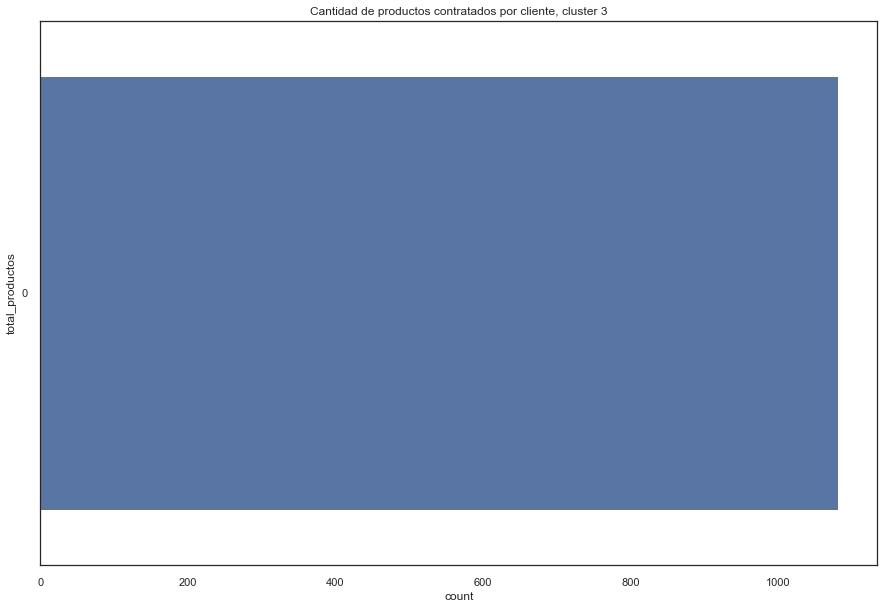

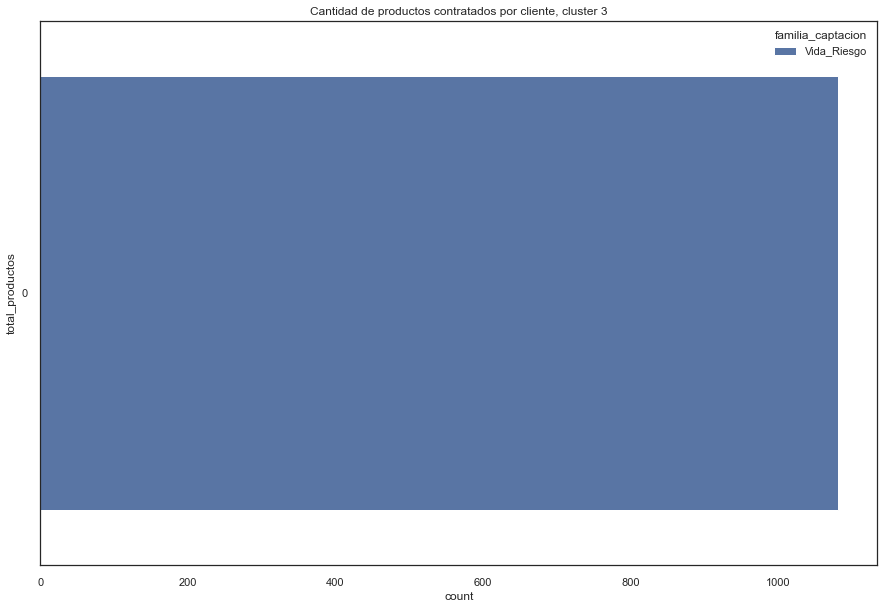

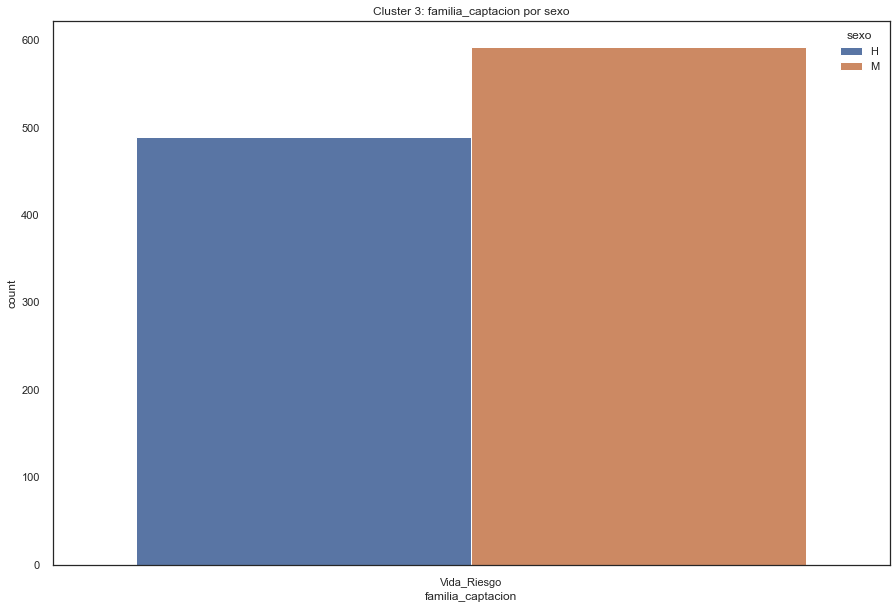

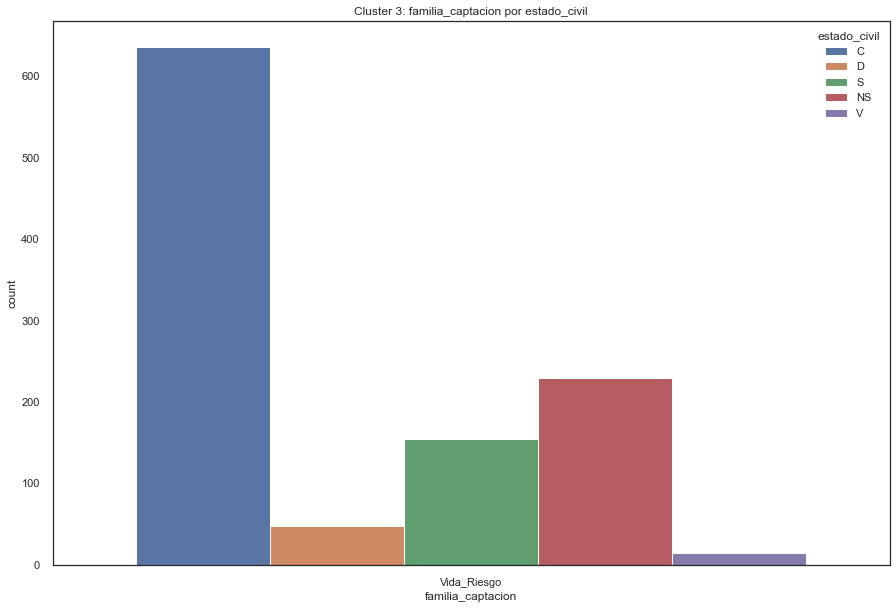

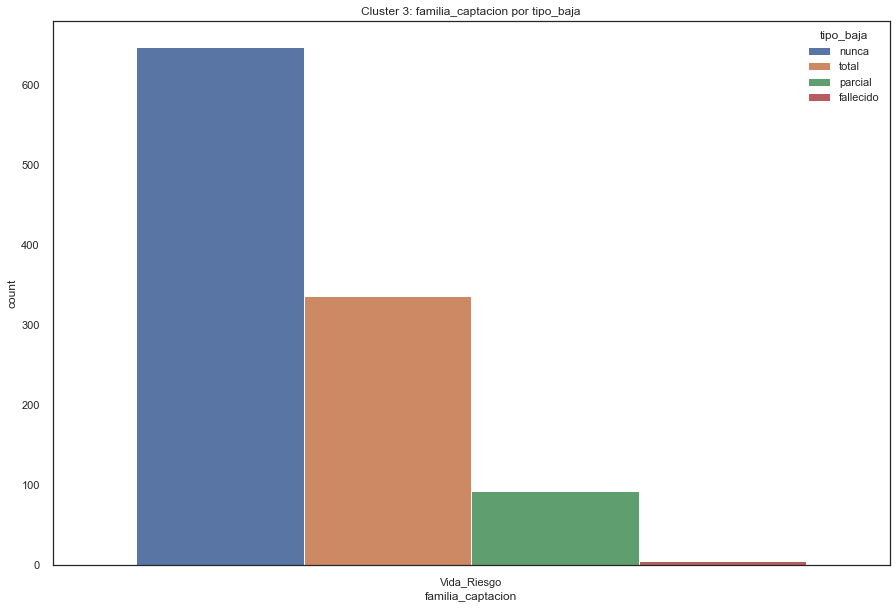

In [328]:
plot_productos_x_cluster(g2_c, 3)
plot_total_productos_x_cluster(g2_c, 3)
plot_total_productos_x_cluster(g2_c, 3, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g2_c, 3,'familia_captacion', e, save=False)
    plt.show();

##### Cluster 4

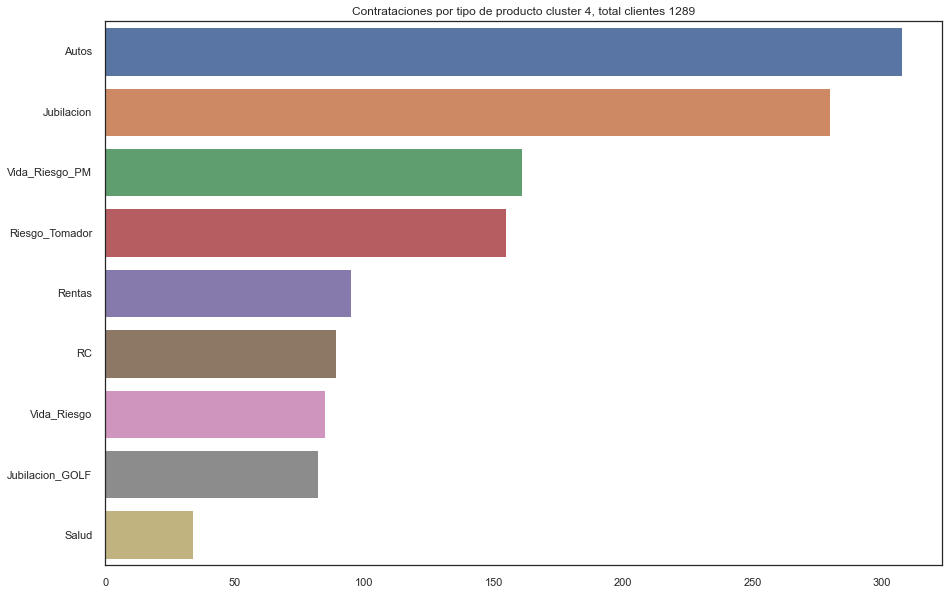

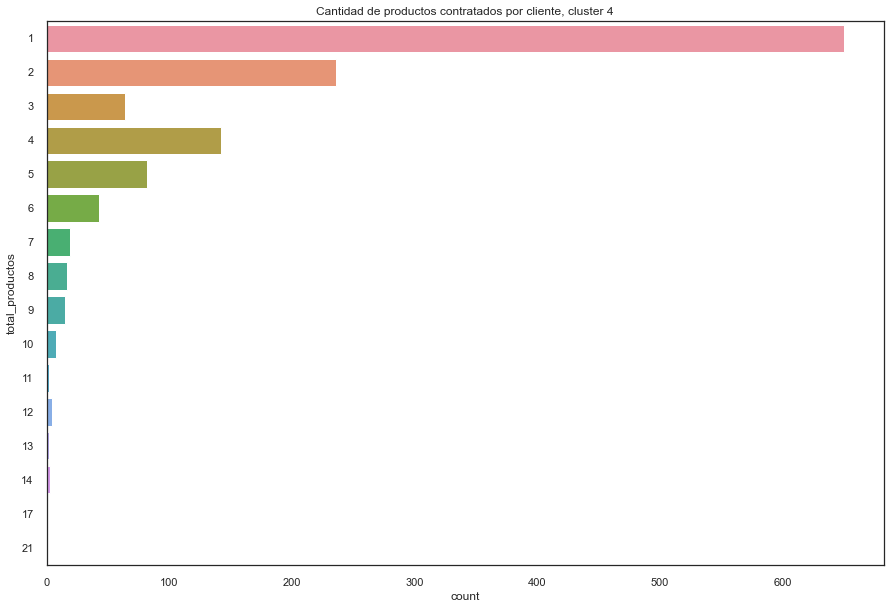

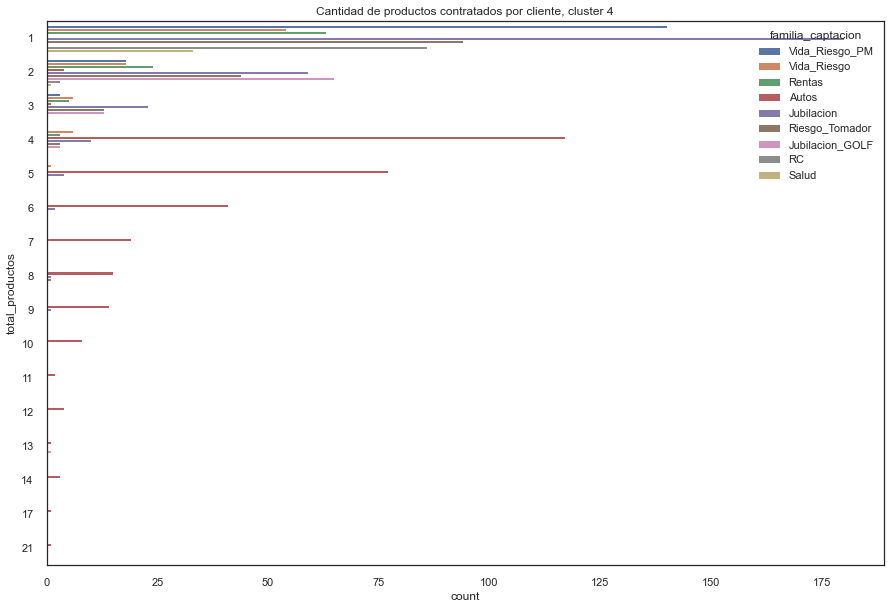

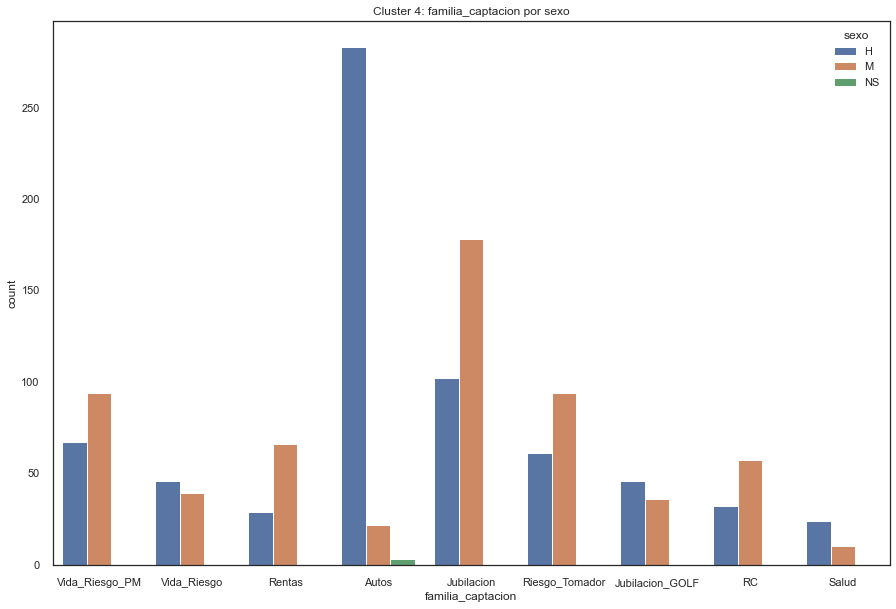

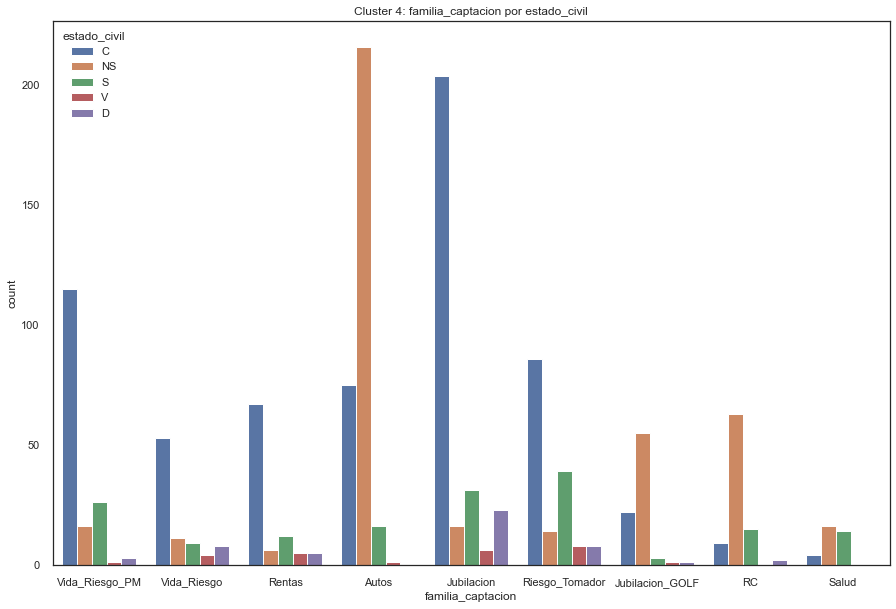

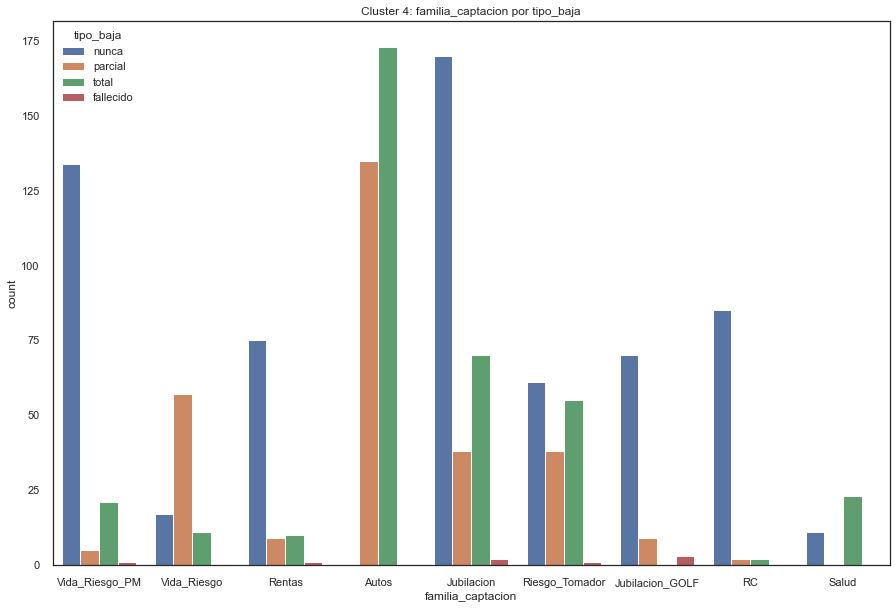

In [329]:
plot_productos_x_cluster(g2_c, 4)
plot_total_productos_x_cluster(g2_c, 4)
plot_total_productos_x_cluster(g2_c, 4, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g2_c, 4,'familia_captacion', e, save=False)
    plt.show();

##### Cluster 5

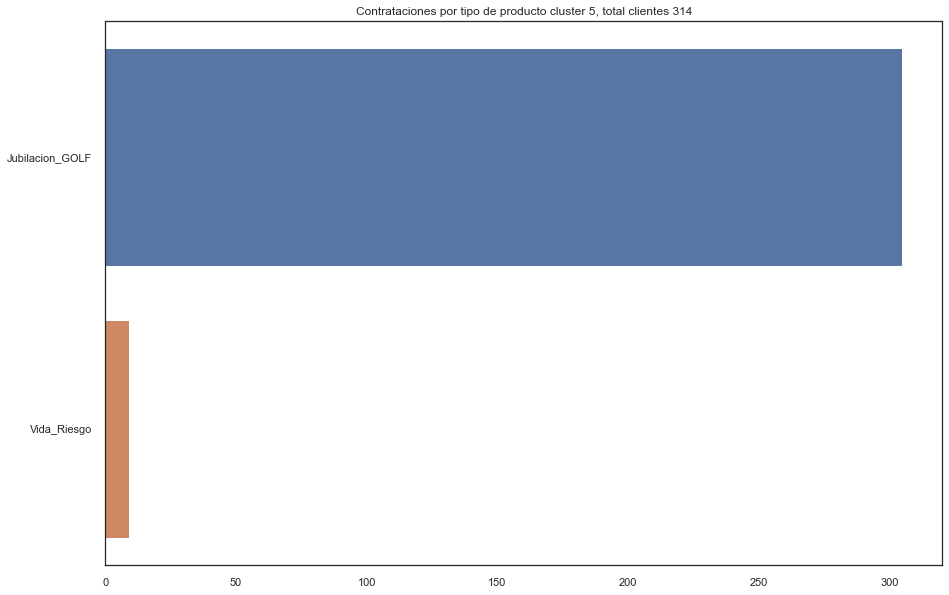

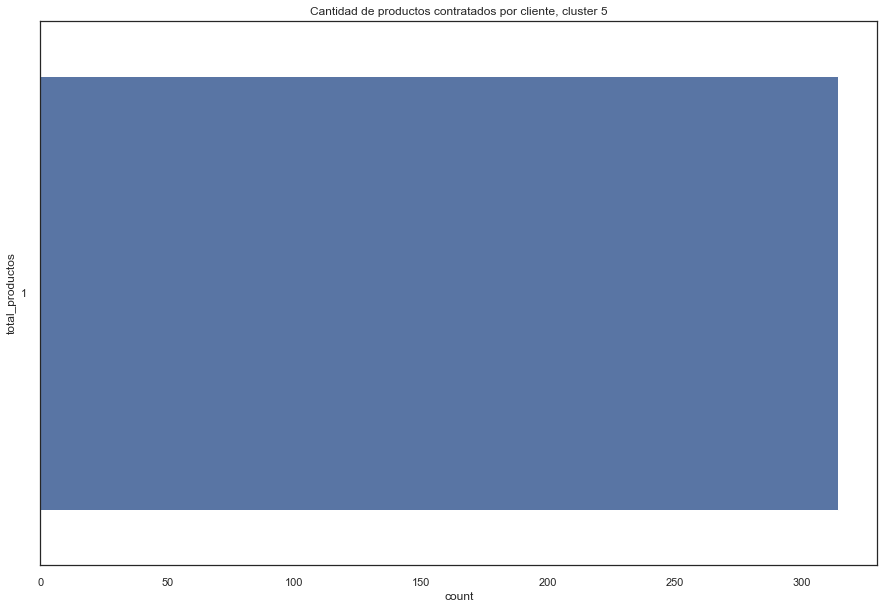

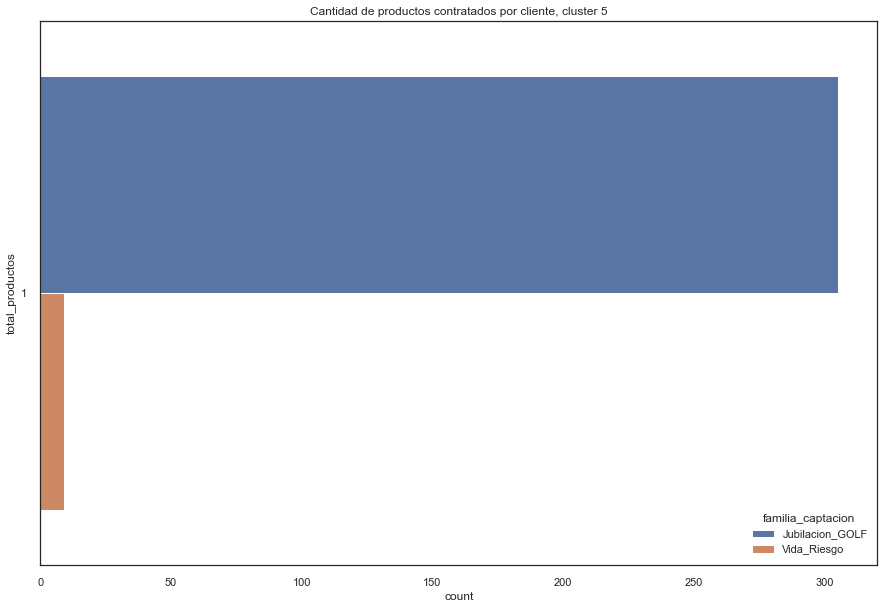

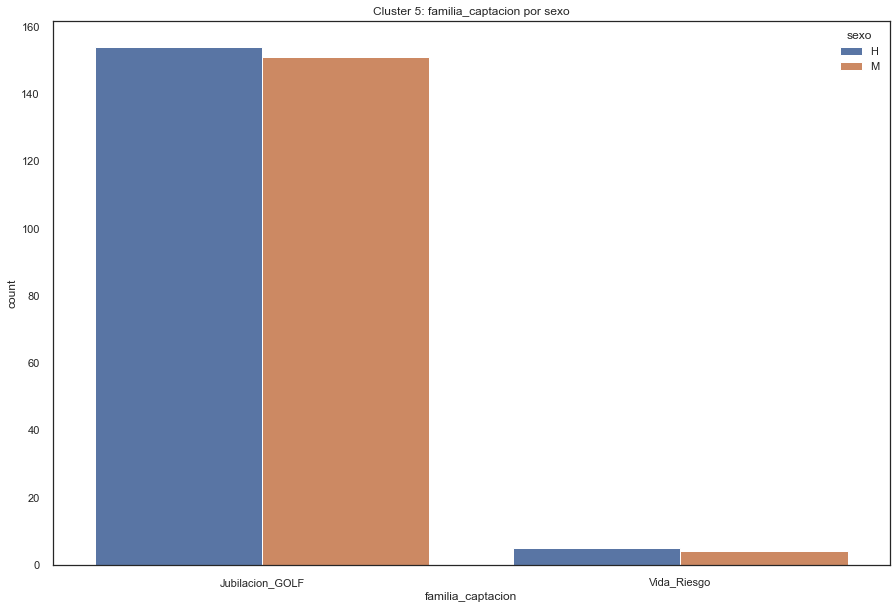

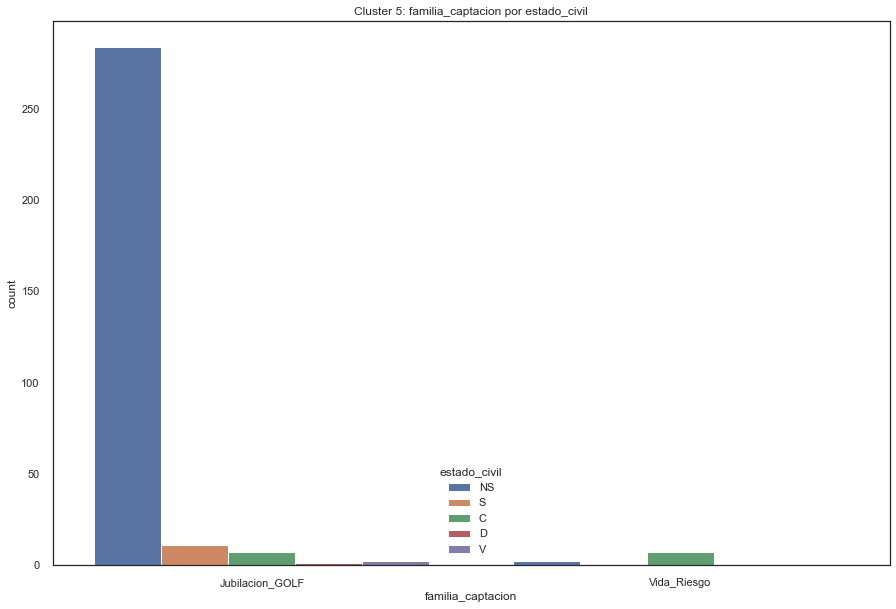

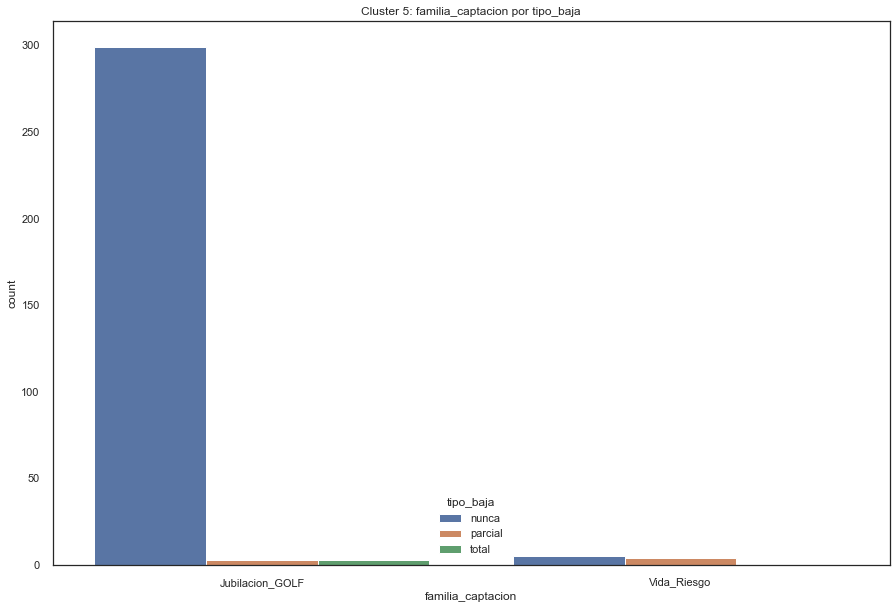

In [330]:
plot_productos_x_cluster(g2_c, 5)
plot_total_productos_x_cluster(g2_c, 5)
plot_total_productos_x_cluster(g2_c, 5, hue='familia_captacion')
for e in ['sexo', 'estado_civil', 'tipo_baja']:
    countplot_cluster(g2_c, 5,'familia_captacion', e, save=False)
    plt.show();

### Guardar Datos 

In [344]:
#g1_c.to_csv('results/Resultados_kmeans_G1.csv', index=False)

In [345]:
#g2_c.to_csv('results/Resultados_kmeans_G2.csv', index=False)

### Conclusiones Finales

- Se han planteado dos tipos de experimentos para buscar la solución más óptima para la problematica propuesta. 

- En un primer caso se han aplicado los algoritmos propuestos para realizar la segmentación de clientes sobre el total de los datos.
    
- En un segundo caso se planteo realizar primero una segmentación de los datos con los clientes que contrataban los productos más demandados, frente a otro grupo que no contrataban ese tipo de productos y se decantaban por alguno del resto de productos que ofrece la empresa.

- En ambos casos se realizaron:

    . Diferentes técnicas de escalado de los datos **StandarScaler** y **MinMaxScaler**
    
    . Entrenamiento de los modelos propuestos **Kmeans** y **DBScan** y estudio de los datos obtenidos
    
    . Técnicas de reducción de dimensiones para tratar de optimizar el desempeño de los modelos

- Conclusiones generales extraidas de ambos experimentos:

    - Para este caso concreto funciona mejor Kmeans ya que generaliza de forma más eficiente, ya que dada la dispersión de los datos dbscan no funciona tan bien ya que al ser un algoritmo basado en densidad y estar los datos tan dispersos a pesar de usar UMAP no está segmentando los clientes de una forma tan optima como lo hace Kmeans
    
    - En el caso del primer experimento realizado con todos los datos KMeans junto con UMAP obtiene unos resultados bastante coherentes, ya que este tipo de problemáticas siempre son dadas a la intepretación.
    
    - En el caso del segundo experimento al igual que en primero Kmeans + UMAP obtiene unos resultado bastante coherentes, ofrece una segmentación de clientes más amplia que quizas se ajuste más a la realidad de la empresa 